<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Layer: 1-2                             --                        --                        --  

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        A.augmentations.crops.transforms.CropAndPad(-4, p=0.5),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

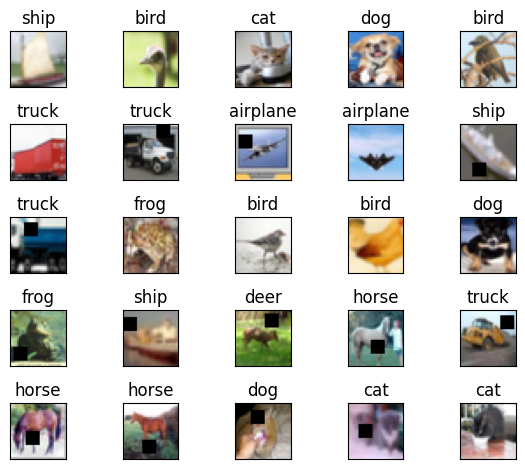

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


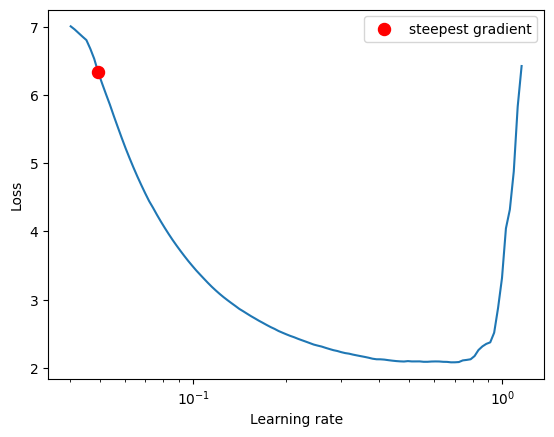

In [7]:
drop_out = 0.05
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear',
        verbose=True
        )
    return scheduler

max_lr = 4.93e-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()
    lr_values.append(optim_obj.optimizer.param_groups[0]['lr'])


Adjusting learning rate of group 0 to 4.9300e-04.
epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:154: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=2.9263336658477783 batch_id=0 Accuracy = 8.79:   1%|          | 1/98 [00:00<01:06,  1.45it/s]

Adjusting learning rate of group 0 to 5.9281e-04.


loss=4.019204616546631 batch_id=1 Accuracy = 11.52:   2%|▏         | 2/98 [00:00<00:41,  2.33it/s]

Adjusting learning rate of group 0 to 6.9262e-04.


loss=2.7369232177734375 batch_id=2 Accuracy = 15.23:   3%|▎         | 3/98 [00:01<00:33,  2.86it/s]

Adjusting learning rate of group 0 to 7.9243e-04.


loss=2.5416457653045654 batch_id=3 Accuracy = 17.29:   4%|▍         | 4/98 [00:01<00:29,  3.18it/s]

Adjusting learning rate of group 0 to 8.9224e-04.


loss=2.1919736862182617 batch_id=4 Accuracy = 19.22:   5%|▌         | 5/98 [00:01<00:27,  3.39it/s]

Adjusting learning rate of group 0 to 9.9205e-04.
Adjusting learning rate of group 0 to 1.0919e-03.


loss=2.0580646991729736 batch_id=6 Accuracy = 22.13:   7%|▋         | 7/98 [00:02<00:24,  3.70it/s]

Adjusting learning rate of group 0 to 1.1917e-03.


loss=2.0574212074279785 batch_id=7 Accuracy = 22.88:   8%|▊         | 8/98 [00:02<00:23,  3.81it/s]

Adjusting learning rate of group 0 to 1.2915e-03.


loss=1.960476040840149 batch_id=8 Accuracy = 23.83:   9%|▉         | 9/98 [00:02<00:23,  3.83it/s]

Adjusting learning rate of group 0 to 1.3913e-03.


loss=1.8683323860168457 batch_id=9 Accuracy = 24.55:  10%|█         | 10/98 [00:02<00:22,  3.90it/s]

Adjusting learning rate of group 0 to 1.4911e-03.


loss=1.8742952346801758 batch_id=10 Accuracy = 25.12:  11%|█         | 11/98 [00:03<00:21,  3.97it/s]

Adjusting learning rate of group 0 to 1.5909e-03.


loss=1.7944865226745605 batch_id=11 Accuracy = 25.91:  12%|█▏        | 12/98 [00:03<00:21,  3.99it/s]

Adjusting learning rate of group 0 to 1.6907e-03.


loss=1.7926982641220093 batch_id=12 Accuracy = 26.68:  13%|█▎        | 13/98 [00:03<00:21,  4.00it/s]

Adjusting learning rate of group 0 to 1.7905e-03.


loss=1.8192479610443115 batch_id=13 Accuracy = 27.29:  14%|█▍        | 14/98 [00:03<00:21,  3.98it/s]

Adjusting learning rate of group 0 to 1.8903e-03.


loss=1.7328261137008667 batch_id=14 Accuracy = 27.81:  15%|█▌        | 15/98 [00:04<00:20,  4.00it/s]

Adjusting learning rate of group 0 to 1.9901e-03.


loss=1.7561498880386353 batch_id=15 Accuracy = 28.36:  16%|█▋        | 16/98 [00:04<00:20,  3.99it/s]

Adjusting learning rate of group 0 to 2.0900e-03.


loss=1.7338404655456543 batch_id=16 Accuracy = 28.71:  17%|█▋        | 17/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 2.1898e-03.


loss=1.7186832427978516 batch_id=17 Accuracy = 29.06:  18%|█▊        | 18/98 [00:04<00:20,  3.94it/s]

Adjusting learning rate of group 0 to 2.2896e-03.


loss=1.7524220943450928 batch_id=18 Accuracy = 29.49:  19%|█▉        | 19/98 [00:05<00:19,  3.97it/s]

Adjusting learning rate of group 0 to 2.3894e-03.


loss=1.6910420656204224 batch_id=19 Accuracy = 29.87:  20%|██        | 20/98 [00:05<00:19,  3.97it/s]

Adjusting learning rate of group 0 to 2.4892e-03.


loss=1.7537410259246826 batch_id=20 Accuracy = 30.28:  21%|██▏       | 21/98 [00:05<00:19,  3.96it/s]

Adjusting learning rate of group 0 to 2.5890e-03.


loss=1.6269699335098267 batch_id=21 Accuracy = 30.66:  22%|██▏       | 22/98 [00:05<00:19,  4.00it/s]

Adjusting learning rate of group 0 to 2.6888e-03.


loss=1.6688989400863647 batch_id=22 Accuracy = 31.08:  23%|██▎       | 23/98 [00:06<00:18,  4.00it/s]

Adjusting learning rate of group 0 to 2.7886e-03.


loss=1.5671273469924927 batch_id=23 Accuracy = 31.67:  24%|██▍       | 24/98 [00:06<00:18,  3.94it/s]

Adjusting learning rate of group 0 to 2.8884e-03.


loss=1.643190622329712 batch_id=24 Accuracy = 31.98:  26%|██▌       | 25/98 [00:06<00:18,  3.93it/s]

Adjusting learning rate of group 0 to 2.9882e-03.


loss=1.6897833347320557 batch_id=25 Accuracy = 32.23:  27%|██▋       | 26/98 [00:06<00:18,  3.93it/s]

Adjusting learning rate of group 0 to 3.0881e-03.


loss=1.6150151491165161 batch_id=26 Accuracy = 32.53:  28%|██▊       | 27/98 [00:07<00:18,  3.93it/s]

Adjusting learning rate of group 0 to 3.1879e-03.
Adjusting learning rate of group 0 to 3.2877e-03.


loss=1.62567138671875 batch_id=28 Accuracy = 33.07:  30%|██▉       | 29/98 [00:07<00:18,  3.83it/s]

Adjusting learning rate of group 0 to 3.3875e-03.
Adjusting learning rate of group 0 to 3.4873e-03.


loss=1.6806854009628296 batch_id=30 Accuracy = 33.47:  32%|███▏      | 31/98 [00:08<00:17,  3.83it/s]

Adjusting learning rate of group 0 to 3.5871e-03.
Adjusting learning rate of group 0 to 3.6869e-03.


loss=1.7342545986175537 batch_id=32 Accuracy = 33.65:  34%|███▎      | 33/98 [00:09<00:22,  2.95it/s]

Adjusting learning rate of group 0 to 3.7867e-03.
Adjusting learning rate of group 0 to 3.8865e-03.


loss=1.6053786277770996 batch_id=34 Accuracy = 34.26:  36%|███▌      | 35/98 [00:09<00:18,  3.36it/s]

Adjusting learning rate of group 0 to 3.9863e-03.
Adjusting learning rate of group 0 to 4.0862e-03.


loss=1.5847604274749756 batch_id=36 Accuracy = 34.73:  38%|███▊      | 37/98 [00:10<00:17,  3.58it/s]

Adjusting learning rate of group 0 to 4.1860e-03.


loss=1.4914226531982422 batch_id=37 Accuracy = 35.02:  39%|███▉      | 38/98 [00:10<00:16,  3.62it/s]

Adjusting learning rate of group 0 to 4.2858e-03.


loss=1.555557131767273 batch_id=38 Accuracy = 35.22:  40%|███▉      | 39/98 [00:10<00:15,  3.69it/s]

Adjusting learning rate of group 0 to 4.3856e-03.


loss=1.512921929359436 batch_id=39 Accuracy = 35.44:  41%|████      | 40/98 [00:10<00:15,  3.76it/s]

Adjusting learning rate of group 0 to 4.4854e-03.


loss=1.5167009830474854 batch_id=40 Accuracy = 35.69:  42%|████▏     | 41/98 [00:11<00:15,  3.75it/s]

Adjusting learning rate of group 0 to 4.5852e-03.
Adjusting learning rate of group 0 to 4.6850e-03.


loss=1.489406943321228 batch_id=42 Accuracy = 36.09:  44%|████▍     | 43/98 [00:11<00:14,  3.83it/s]

Adjusting learning rate of group 0 to 4.7848e-03.


loss=1.6335495710372925 batch_id=43 Accuracy = 36.20:  45%|████▍     | 44/98 [00:11<00:14,  3.82it/s]

Adjusting learning rate of group 0 to 4.8846e-03.


loss=1.561026930809021 batch_id=44 Accuracy = 36.38:  46%|████▌     | 45/98 [00:12<00:13,  3.87it/s]

Adjusting learning rate of group 0 to 4.9844e-03.


loss=1.5196586847305298 batch_id=45 Accuracy = 36.58:  47%|████▋     | 46/98 [00:12<00:13,  3.87it/s]

Adjusting learning rate of group 0 to 5.0843e-03.


loss=1.5899463891983032 batch_id=46 Accuracy = 36.71:  48%|████▊     | 47/98 [00:12<00:13,  3.90it/s]

Adjusting learning rate of group 0 to 5.1841e-03.


loss=1.5545564889907837 batch_id=47 Accuracy = 36.84:  49%|████▉     | 48/98 [00:12<00:12,  3.91it/s]

Adjusting learning rate of group 0 to 5.2839e-03.


loss=1.592953085899353 batch_id=48 Accuracy = 36.95:  50%|█████     | 49/98 [00:13<00:12,  3.91it/s]

Adjusting learning rate of group 0 to 5.3837e-03.


loss=1.5656702518463135 batch_id=49 Accuracy = 37.06:  51%|█████     | 50/98 [00:13<00:12,  3.89it/s]

Adjusting learning rate of group 0 to 5.4835e-03.


loss=1.5941849946975708 batch_id=50 Accuracy = 37.21:  52%|█████▏    | 51/98 [00:13<00:12,  3.91it/s]

Adjusting learning rate of group 0 to 5.5833e-03.


loss=1.563934326171875 batch_id=51 Accuracy = 37.28:  53%|█████▎    | 52/98 [00:13<00:11,  3.90it/s]

Adjusting learning rate of group 0 to 5.6831e-03.


loss=1.618261456489563 batch_id=52 Accuracy = 37.36:  54%|█████▍    | 53/98 [00:14<00:11,  3.90it/s]

Adjusting learning rate of group 0 to 5.7829e-03.


loss=1.497635841369629 batch_id=53 Accuracy = 37.52:  55%|█████▌    | 54/98 [00:14<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 5.8827e-03.


loss=1.5318996906280518 batch_id=54 Accuracy = 37.65:  56%|█████▌    | 55/98 [00:14<00:10,  3.91it/s]

Adjusting learning rate of group 0 to 5.9825e-03.


loss=1.4693809747695923 batch_id=55 Accuracy = 37.80:  57%|█████▋    | 56/98 [00:15<00:10,  3.89it/s]

Adjusting learning rate of group 0 to 6.0823e-03.
Adjusting learning rate of group 0 to 6.1822e-03.


loss=1.4716240167617798 batch_id=57 Accuracy = 38.09:  59%|█████▉    | 58/98 [00:15<00:10,  3.86it/s]

Adjusting learning rate of group 0 to 6.2820e-03.


loss=1.4813145399093628 batch_id=58 Accuracy = 38.22:  60%|██████    | 59/98 [00:15<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 6.3818e-03.


loss=1.5217500925064087 batch_id=59 Accuracy = 38.31:  61%|██████    | 60/98 [00:16<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 6.4816e-03.


loss=1.4404311180114746 batch_id=60 Accuracy = 38.46:  62%|██████▏   | 61/98 [00:16<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 6.5814e-03.
Adjusting learning rate of group 0 to 6.6812e-03.


loss=1.481033205986023 batch_id=62 Accuracy = 38.72:  64%|██████▍   | 63/98 [00:16<00:09,  3.88it/s]

Adjusting learning rate of group 0 to 6.7810e-03.


loss=1.5579662322998047 batch_id=63 Accuracy = 38.89:  65%|██████▌   | 64/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 6.8808e-03.


loss=1.4613540172576904 batch_id=64 Accuracy = 38.98:  66%|██████▋   | 65/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 6.9806e-03.


loss=1.4612313508987427 batch_id=65 Accuracy = 39.11:  67%|██████▋   | 66/98 [00:17<00:08,  3.89it/s]

Adjusting learning rate of group 0 to 7.0804e-03.


loss=1.4101096391677856 batch_id=66 Accuracy = 39.29:  68%|██████▊   | 67/98 [00:17<00:08,  3.87it/s]

Adjusting learning rate of group 0 to 7.1803e-03.


loss=1.522443413734436 batch_id=67 Accuracy = 39.32:  69%|██████▉   | 68/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 7.2801e-03.
Adjusting learning rate of group 0 to 7.3799e-03.


loss=1.4235405921936035 batch_id=69 Accuracy = 39.62:  71%|███████▏  | 70/98 [00:18<00:07,  3.88it/s]

Adjusting learning rate of group 0 to 7.4797e-03.
Adjusting learning rate of group 0 to 7.5795e-03.


loss=1.4415966272354126 batch_id=71 Accuracy = 39.85:  73%|███████▎  | 72/98 [00:19<00:06,  3.87it/s]

Adjusting learning rate of group 0 to 7.6793e-03.


loss=1.4995665550231934 batch_id=72 Accuracy = 39.92:  74%|███████▍  | 73/98 [00:19<00:06,  3.85it/s]

Adjusting learning rate of group 0 to 7.7791e-03.


loss=1.3043607473373413 batch_id=73 Accuracy = 40.10:  76%|███████▌  | 74/98 [00:19<00:06,  3.85it/s]

Adjusting learning rate of group 0 to 7.8789e-03.
Adjusting learning rate of group 0 to 7.9787e-03.


loss=1.4094098806381226 batch_id=75 Accuracy = 40.33:  78%|███████▊  | 76/98 [00:20<00:05,  3.80it/s]

Adjusting learning rate of group 0 to 8.0785e-03.


loss=1.3474838733673096 batch_id=76 Accuracy = 40.44:  79%|███████▊  | 77/98 [00:20<00:05,  3.74it/s]

Adjusting learning rate of group 0 to 8.1784e-03.


loss=1.331341028213501 batch_id=77 Accuracy = 40.60:  80%|███████▉  | 78/98 [00:20<00:05,  3.79it/s]

Adjusting learning rate of group 0 to 8.2782e-03.
Adjusting learning rate of group 0 to 8.3780e-03.


loss=1.3458365201950073 batch_id=79 Accuracy = 40.85:  82%|████████▏ | 80/98 [00:21<00:04,  3.77it/s]

Adjusting learning rate of group 0 to 8.4778e-03.
Adjusting learning rate of group 0 to 8.5776e-03.


loss=1.415921926498413 batch_id=81 Accuracy = 41.15:  84%|████████▎ | 82/98 [00:21<00:04,  3.78it/s]

Adjusting learning rate of group 0 to 8.6774e-03.
Adjusting learning rate of group 0 to 8.7772e-03.


loss=1.324328899383545 batch_id=83 Accuracy = 41.35:  86%|████████▌ | 84/98 [00:22<00:04,  3.49it/s]

Adjusting learning rate of group 0 to 8.8770e-03.


loss=1.1903581619262695 batch_id=84 Accuracy = 41.51:  87%|████████▋ | 85/98 [00:22<00:03,  3.44it/s]

Adjusting learning rate of group 0 to 8.9768e-03.


loss=1.3085899353027344 batch_id=85 Accuracy = 41.65:  88%|████████▊ | 86/98 [00:23<00:03,  3.25it/s]

Adjusting learning rate of group 0 to 9.0766e-03.


loss=1.295282244682312 batch_id=86 Accuracy = 41.76:  89%|████████▉ | 87/98 [00:23<00:03,  3.34it/s]

Adjusting learning rate of group 0 to 9.1765e-03.


loss=1.357666254043579 batch_id=87 Accuracy = 41.90:  90%|████████▉ | 88/98 [00:23<00:02,  3.43it/s]

Adjusting learning rate of group 0 to 9.2763e-03.


loss=1.3636811971664429 batch_id=88 Accuracy = 42.02:  91%|█████████ | 89/98 [00:23<00:02,  3.44it/s]

Adjusting learning rate of group 0 to 9.3761e-03.


loss=1.3488502502441406 batch_id=89 Accuracy = 42.09:  92%|█████████▏| 90/98 [00:24<00:02,  3.53it/s]

Adjusting learning rate of group 0 to 9.4759e-03.


loss=1.3611243963241577 batch_id=90 Accuracy = 42.17:  93%|█████████▎| 91/98 [00:24<00:01,  3.62it/s]

Adjusting learning rate of group 0 to 9.5757e-03.


loss=1.2367305755615234 batch_id=91 Accuracy = 42.31:  94%|█████████▍| 92/98 [00:24<00:01,  3.65it/s]

Adjusting learning rate of group 0 to 9.6755e-03.


loss=1.2819229364395142 batch_id=92 Accuracy = 42.45:  95%|█████████▍| 93/98 [00:24<00:01,  3.63it/s]

Adjusting learning rate of group 0 to 9.7753e-03.


loss=1.3672847747802734 batch_id=93 Accuracy = 42.57:  96%|█████████▌| 94/98 [00:25<00:01,  3.71it/s]

Adjusting learning rate of group 0 to 9.8751e-03.


loss=1.2875754833221436 batch_id=94 Accuracy = 42.65:  97%|█████████▋| 95/98 [00:25<00:00,  3.75it/s]

Adjusting learning rate of group 0 to 9.9749e-03.


loss=1.2996519804000854 batch_id=95 Accuracy = 42.76:  98%|█████████▊| 96/98 [00:25<00:00,  3.75it/s]

Adjusting learning rate of group 0 to 1.0075e-02.


loss=1.2846434116363525 batch_id=96 Accuracy = 42.89:  99%|█████████▉| 97/98 [00:25<00:00,  3.78it/s]

Adjusting learning rate of group 0 to 1.0175e-02.


loss=1.2581714391708374 batch_id=97 Accuracy = 42.97: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]

Adjusting learning rate of group 0 to 1.0274e-02.



Test set: Average loss: 0.0032, Accuracy: 4664/10000 (46.64%)

epoch: 2


loss=1.31611168384552 batch_id=0 Accuracy = 50.78:   1%|          | 1/98 [00:00<01:04,  1.51it/s]

Adjusting learning rate of group 0 to 1.0374e-02.


loss=1.3380483388900757 batch_id=1 Accuracy = 50.29:   2%|▏         | 2/98 [00:00<00:41,  2.32it/s]

Adjusting learning rate of group 0 to 1.0474e-02.


loss=1.271061897277832 batch_id=2 Accuracy = 50.91:   3%|▎         | 3/98 [00:01<00:33,  2.84it/s]

Adjusting learning rate of group 0 to 1.0574e-02.
Adjusting learning rate of group 0 to 1.0674e-02.


loss=1.3466311693191528 batch_id=4 Accuracy = 52.42:   5%|▌         | 5/98 [00:01<00:27,  3.37it/s]

Adjusting learning rate of group 0 to 1.0773e-02.


loss=1.2780662775039673 batch_id=5 Accuracy = 52.86:   6%|▌         | 6/98 [00:01<00:26,  3.50it/s]

Adjusting learning rate of group 0 to 1.0873e-02.


loss=1.2056697607040405 batch_id=6 Accuracy = 53.29:   7%|▋         | 7/98 [00:02<00:25,  3.64it/s]

Adjusting learning rate of group 0 to 1.0973e-02.


loss=1.225351095199585 batch_id=7 Accuracy = 53.69:   8%|▊         | 8/98 [00:02<00:24,  3.70it/s]

Adjusting learning rate of group 0 to 1.1073e-02.


loss=1.2693352699279785 batch_id=8 Accuracy = 53.93:   9%|▉         | 9/98 [00:02<00:23,  3.74it/s]

Adjusting learning rate of group 0 to 1.1173e-02.


loss=1.2452369928359985 batch_id=9 Accuracy = 54.53:  10%|█         | 10/98 [00:03<00:23,  3.77it/s]

Adjusting learning rate of group 0 to 1.1272e-02.


loss=1.2184795141220093 batch_id=10 Accuracy = 54.78:  11%|█         | 11/98 [00:03<00:22,  3.79it/s]

Adjusting learning rate of group 0 to 1.1372e-02.


loss=1.2590805292129517 batch_id=11 Accuracy = 54.90:  12%|█▏        | 12/98 [00:03<00:22,  3.84it/s]

Adjusting learning rate of group 0 to 1.1472e-02.


loss=1.132983922958374 batch_id=12 Accuracy = 55.23:  13%|█▎        | 13/98 [00:03<00:22,  3.76it/s]

Adjusting learning rate of group 0 to 1.1572e-02.


loss=1.2357628345489502 batch_id=13 Accuracy = 55.43:  14%|█▍        | 14/98 [00:04<00:22,  3.75it/s]

Adjusting learning rate of group 0 to 1.1672e-02.


loss=1.291728138923645 batch_id=14 Accuracy = 55.25:  15%|█▌        | 15/98 [00:04<00:22,  3.74it/s]

Adjusting learning rate of group 0 to 1.1772e-02.


loss=1.2820241451263428 batch_id=15 Accuracy = 55.20:  16%|█▋        | 16/98 [00:04<00:21,  3.76it/s]

Adjusting learning rate of group 0 to 1.1871e-02.


loss=1.2457325458526611 batch_id=16 Accuracy = 55.23:  17%|█▋        | 17/98 [00:04<00:21,  3.76it/s]

Adjusting learning rate of group 0 to 1.1971e-02.
Adjusting learning rate of group 0 to 1.2071e-02.


loss=1.1977041959762573 batch_id=18 Accuracy = 55.24:  19%|█▉        | 19/98 [00:05<00:21,  3.68it/s]

Adjusting learning rate of group 0 to 1.2171e-02.
Adjusting learning rate of group 0 to 1.2271e-02.


loss=1.234802007675171 batch_id=20 Accuracy = 54.98:  21%|██▏       | 21/98 [00:05<00:20,  3.79it/s]

Adjusting learning rate of group 0 to 1.2370e-02.


loss=1.179225206375122 batch_id=21 Accuracy = 55.10:  22%|██▏       | 22/98 [00:06<00:20,  3.76it/s]

Adjusting learning rate of group 0 to 1.2470e-02.
Adjusting learning rate of group 0 to 1.2570e-02.


loss=1.336371660232544 batch_id=23 Accuracy = 55.09:  24%|██▍       | 24/98 [00:06<00:21,  3.52it/s]

Adjusting learning rate of group 0 to 1.2670e-02.
Adjusting learning rate of group 0 to 1.2770e-02.


loss=1.296877384185791 batch_id=25 Accuracy = 55.19:  27%|██▋       | 26/98 [00:07<00:22,  3.16it/s]

Adjusting learning rate of group 0 to 1.2869e-02.
Adjusting learning rate of group 0 to 1.2969e-02.


loss=1.2849620580673218 batch_id=27 Accuracy = 54.99:  29%|██▊       | 28/98 [00:08<00:22,  3.12it/s]

Adjusting learning rate of group 0 to 1.3069e-02.


loss=1.3636502027511597 batch_id=28 Accuracy = 54.92:  30%|██▉       | 29/98 [00:08<00:20,  3.30it/s]

Adjusting learning rate of group 0 to 1.3169e-02.


loss=1.3172301054000854 batch_id=29 Accuracy = 54.91:  31%|███       | 30/98 [00:08<00:19,  3.43it/s]

Adjusting learning rate of group 0 to 1.3269e-02.


loss=1.3583924770355225 batch_id=30 Accuracy = 54.78:  32%|███▏      | 31/98 [00:08<00:19,  3.51it/s]

Adjusting learning rate of group 0 to 1.3368e-02.


loss=1.3344875574111938 batch_id=31 Accuracy = 54.73:  33%|███▎      | 32/98 [00:09<00:18,  3.59it/s]

Adjusting learning rate of group 0 to 1.3468e-02.
Adjusting learning rate of group 0 to 1.3568e-02.


loss=1.2058109045028687 batch_id=33 Accuracy = 54.87:  35%|███▍      | 34/98 [00:09<00:17,  3.73it/s]

Adjusting learning rate of group 0 to 1.3668e-02.


loss=1.3133703470230103 batch_id=34 Accuracy = 54.75:  36%|███▌      | 35/98 [00:09<00:16,  3.78it/s]

Adjusting learning rate of group 0 to 1.3768e-02.


loss=1.2216354608535767 batch_id=35 Accuracy = 54.83:  37%|███▋      | 36/98 [00:10<00:16,  3.78it/s]

Adjusting learning rate of group 0 to 1.3868e-02.


loss=1.2732644081115723 batch_id=36 Accuracy = 54.83:  38%|███▊      | 37/98 [00:10<00:15,  3.84it/s]

Adjusting learning rate of group 0 to 1.3967e-02.


loss=1.3065924644470215 batch_id=37 Accuracy = 54.85:  39%|███▉      | 38/98 [00:10<00:15,  3.81it/s]

Adjusting learning rate of group 0 to 1.4067e-02.


loss=1.2118631601333618 batch_id=38 Accuracy = 54.99:  40%|███▉      | 39/98 [00:10<00:15,  3.82it/s]

Adjusting learning rate of group 0 to 1.4167e-02.
Adjusting learning rate of group 0 to 1.4267e-02.


loss=1.180832028388977 batch_id=40 Accuracy = 55.08:  42%|████▏     | 41/98 [00:11<00:14,  3.84it/s]

Adjusting learning rate of group 0 to 1.4367e-02.


loss=1.1578363180160522 batch_id=41 Accuracy = 55.10:  43%|████▎     | 42/98 [00:11<00:14,  3.89it/s]

Adjusting learning rate of group 0 to 1.4466e-02.
Adjusting learning rate of group 0 to 1.4566e-02.


loss=1.2674490213394165 batch_id=43 Accuracy = 55.21:  45%|████▍     | 44/98 [00:12<00:13,  3.87it/s]

Adjusting learning rate of group 0 to 1.4666e-02.
Adjusting learning rate of group 0 to 1.4766e-02.


loss=1.210610270500183 batch_id=45 Accuracy = 55.32:  47%|████▋     | 46/98 [00:12<00:13,  3.88it/s]

Adjusting learning rate of group 0 to 1.4866e-02.


loss=1.1438393592834473 batch_id=46 Accuracy = 55.37:  48%|████▊     | 47/98 [00:13<00:13,  3.85it/s]

Adjusting learning rate of group 0 to 1.4965e-02.


loss=1.1677947044372559 batch_id=47 Accuracy = 55.41:  49%|████▉     | 48/98 [00:13<00:12,  3.86it/s]

Adjusting learning rate of group 0 to 1.5065e-02.


loss=1.1947847604751587 batch_id=48 Accuracy = 55.48:  50%|█████     | 49/98 [00:13<00:12,  3.90it/s]

Adjusting learning rate of group 0 to 1.5165e-02.


loss=1.295287013053894 batch_id=49 Accuracy = 55.44:  51%|█████     | 50/98 [00:13<00:12,  3.86it/s]

Adjusting learning rate of group 0 to 1.5265e-02.


loss=1.1767696142196655 batch_id=50 Accuracy = 55.46:  52%|█████▏    | 51/98 [00:14<00:12,  3.87it/s]

Adjusting learning rate of group 0 to 1.5365e-02.


loss=1.210036277770996 batch_id=51 Accuracy = 55.48:  53%|█████▎    | 52/98 [00:14<00:11,  3.88it/s]

Adjusting learning rate of group 0 to 1.5464e-02.


loss=1.1687146425247192 batch_id=52 Accuracy = 55.50:  54%|█████▍    | 53/98 [00:14<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 1.5564e-02.


loss=1.2112534046173096 batch_id=53 Accuracy = 55.56:  55%|█████▌    | 54/98 [00:14<00:11,  3.89it/s]

Adjusting learning rate of group 0 to 1.5664e-02.


loss=1.273687481880188 batch_id=54 Accuracy = 55.56:  56%|█████▌    | 55/98 [00:15<00:11,  3.88it/s]

Adjusting learning rate of group 0 to 1.5764e-02.
Adjusting learning rate of group 0 to 1.5864e-02.


loss=1.3150519132614136 batch_id=56 Accuracy = 55.56:  58%|█████▊    | 57/98 [00:15<00:10,  3.87it/s]

Adjusting learning rate of group 0 to 1.5964e-02.


loss=1.1241776943206787 batch_id=57 Accuracy = 55.62:  59%|█████▉    | 58/98 [00:15<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 1.6063e-02.


loss=1.114942193031311 batch_id=58 Accuracy = 55.73:  60%|██████    | 59/98 [00:16<00:10,  3.85it/s]

Adjusting learning rate of group 0 to 1.6163e-02.


loss=1.1692955493927002 batch_id=59 Accuracy = 55.84:  61%|██████    | 60/98 [00:16<00:09,  3.87it/s]

Adjusting learning rate of group 0 to 1.6263e-02.


loss=1.1814020872116089 batch_id=60 Accuracy = 55.90:  62%|██████▏   | 61/98 [00:16<00:09,  3.86it/s]

Adjusting learning rate of group 0 to 1.6363e-02.


loss=1.4610661268234253 batch_id=61 Accuracy = 55.91:  63%|██████▎   | 62/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 1.6463e-02.


loss=1.1611887216567993 batch_id=62 Accuracy = 55.98:  64%|██████▍   | 63/98 [00:17<00:09,  3.84it/s]

Adjusting learning rate of group 0 to 1.6562e-02.


loss=1.3682537078857422 batch_id=63 Accuracy = 55.94:  65%|██████▌   | 64/98 [00:17<00:08,  3.87it/s]

Adjusting learning rate of group 0 to 1.6662e-02.


loss=1.1647300720214844 batch_id=64 Accuracy = 56.04:  66%|██████▋   | 65/98 [00:17<00:08,  3.89it/s]

Adjusting learning rate of group 0 to 1.6762e-02.
Adjusting learning rate of group 0 to 1.6862e-02.


loss=1.2355090379714966 batch_id=66 Accuracy = 56.01:  68%|██████▊   | 67/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 1.6962e-02.


loss=1.2476131916046143 batch_id=67 Accuracy = 56.01:  69%|██████▉   | 68/98 [00:18<00:07,  3.86it/s]

Adjusting learning rate of group 0 to 1.7061e-02.
Adjusting learning rate of group 0 to 1.7161e-02.


loss=1.3289579153060913 batch_id=69 Accuracy = 56.06:  71%|███████▏  | 70/98 [00:18<00:07,  3.84it/s]

Adjusting learning rate of group 0 to 1.7261e-02.
Adjusting learning rate of group 0 to 1.7361e-02.


loss=0.9948368668556213 batch_id=71 Accuracy = 56.20:  73%|███████▎  | 72/98 [00:19<00:06,  3.81it/s]

Adjusting learning rate of group 0 to 1.7461e-02.


loss=1.0472079515457153 batch_id=72 Accuracy = 56.31:  74%|███████▍  | 73/98 [00:19<00:06,  3.81it/s]

Adjusting learning rate of group 0 to 1.7560e-02.


loss=1.171169400215149 batch_id=73 Accuracy = 56.38:  76%|███████▌  | 74/98 [00:20<00:06,  3.78it/s]

Adjusting learning rate of group 0 to 1.7660e-02.


loss=1.0025702714920044 batch_id=74 Accuracy = 56.49:  77%|███████▋  | 75/98 [00:20<00:06,  3.67it/s]

Adjusting learning rate of group 0 to 1.7760e-02.
Adjusting learning rate of group 0 to 1.7860e-02.


loss=1.1407829523086548 batch_id=76 Accuracy = 56.60:  79%|███████▊  | 77/98 [00:21<00:06,  3.07it/s]

Adjusting learning rate of group 0 to 1.7960e-02.
Adjusting learning rate of group 0 to 1.8060e-02.


loss=1.095417857170105 batch_id=78 Accuracy = 56.66:  81%|████████  | 79/98 [00:21<00:05,  3.29it/s]

Adjusting learning rate of group 0 to 1.8159e-02.


loss=1.2271387577056885 batch_id=79 Accuracy = 56.69:  82%|████████▏ | 80/98 [00:21<00:05,  3.40it/s]

Adjusting learning rate of group 0 to 1.8259e-02.


loss=1.08732271194458 batch_id=80 Accuracy = 56.78:  83%|████████▎ | 81/98 [00:22<00:04,  3.52it/s]

Adjusting learning rate of group 0 to 1.8359e-02.


loss=1.1350749731063843 batch_id=81 Accuracy = 56.85:  84%|████████▎ | 82/98 [00:22<00:04,  3.56it/s]

Adjusting learning rate of group 0 to 1.8459e-02.


loss=1.2263489961624146 batch_id=82 Accuracy = 56.87:  85%|████████▍ | 83/98 [00:22<00:04,  3.59it/s]

Adjusting learning rate of group 0 to 1.8559e-02.


loss=1.1234265565872192 batch_id=83 Accuracy = 56.90:  86%|████████▌ | 84/98 [00:23<00:03,  3.64it/s]

Adjusting learning rate of group 0 to 1.8658e-02.


loss=1.2347337007522583 batch_id=84 Accuracy = 56.94:  87%|████████▋ | 85/98 [00:23<00:03,  3.73it/s]

Adjusting learning rate of group 0 to 1.8758e-02.


loss=1.2079704999923706 batch_id=85 Accuracy = 56.98:  88%|████████▊ | 86/98 [00:23<00:03,  3.77it/s]

Adjusting learning rate of group 0 to 1.8858e-02.


loss=1.2850967645645142 batch_id=86 Accuracy = 56.96:  89%|████████▉ | 87/98 [00:23<00:02,  3.76it/s]

Adjusting learning rate of group 0 to 1.8958e-02.


loss=1.045130729675293 batch_id=87 Accuracy = 57.04:  90%|████████▉ | 88/98 [00:24<00:02,  3.74it/s]

Adjusting learning rate of group 0 to 1.9058e-02.
Adjusting learning rate of group 0 to 1.9157e-02.


loss=1.0550289154052734 batch_id=89 Accuracy = 57.16:  92%|█████████▏| 90/98 [00:24<00:02,  3.63it/s]

Adjusting learning rate of group 0 to 1.9257e-02.


loss=1.0555661916732788 batch_id=90 Accuracy = 57.20:  93%|█████████▎| 91/98 [00:24<00:01,  3.67it/s]

Adjusting learning rate of group 0 to 1.9357e-02.


loss=1.0653506517410278 batch_id=91 Accuracy = 57.25:  94%|█████████▍| 92/98 [00:25<00:01,  3.69it/s]

Adjusting learning rate of group 0 to 1.9457e-02.


loss=1.0703507661819458 batch_id=92 Accuracy = 57.32:  95%|█████████▍| 93/98 [00:25<00:01,  3.75it/s]

Adjusting learning rate of group 0 to 1.9557e-02.


loss=1.0605671405792236 batch_id=93 Accuracy = 57.37:  96%|█████████▌| 94/98 [00:25<00:01,  3.76it/s]

Adjusting learning rate of group 0 to 1.9656e-02.


loss=1.0937094688415527 batch_id=94 Accuracy = 57.42:  97%|█████████▋| 95/98 [00:25<00:00,  3.85it/s]

Adjusting learning rate of group 0 to 1.9756e-02.


loss=1.1586064100265503 batch_id=95 Accuracy = 57.45:  98%|█████████▊| 96/98 [00:26<00:00,  3.87it/s]

Adjusting learning rate of group 0 to 1.9856e-02.
Adjusting learning rate of group 0 to 1.9956e-02.


loss=1.0105657577514648 batch_id=97 Accuracy = 57.56: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]

Adjusting learning rate of group 0 to 2.0056e-02.



Test set: Average loss: 0.0025, Accuracy: 5659/10000 (56.59%)

epoch: 3


loss=1.0262503623962402 batch_id=0 Accuracy = 64.26:   1%|          | 1/98 [00:00<01:03,  1.53it/s]

Adjusting learning rate of group 0 to 2.0156e-02.


loss=1.0728918313980103 batch_id=1 Accuracy = 62.79:   2%|▏         | 2/98 [00:00<00:40,  2.35it/s]

Adjusting learning rate of group 0 to 2.0255e-02.


loss=1.0827780961990356 batch_id=2 Accuracy = 62.70:   3%|▎         | 3/98 [00:01<00:33,  2.86it/s]

Adjusting learning rate of group 0 to 2.0355e-02.


loss=0.9857184886932373 batch_id=3 Accuracy = 63.09:   4%|▍         | 4/98 [00:01<00:29,  3.15it/s]

Adjusting learning rate of group 0 to 2.0455e-02.
Adjusting learning rate of group 0 to 2.0555e-02.


loss=1.018201231956482 batch_id=5 Accuracy = 62.86:   6%|▌         | 6/98 [00:01<00:26,  3.48it/s]

Adjusting learning rate of group 0 to 2.0655e-02.


loss=1.091810703277588 batch_id=6 Accuracy = 62.78:   7%|▋         | 7/98 [00:02<00:25,  3.64it/s]

Adjusting learning rate of group 0 to 2.0754e-02.


loss=1.051711082458496 batch_id=7 Accuracy = 62.79:   8%|▊         | 8/98 [00:02<00:24,  3.68it/s]

Adjusting learning rate of group 0 to 2.0854e-02.


loss=0.9742895364761353 batch_id=8 Accuracy = 63.15:   9%|▉         | 9/98 [00:02<00:23,  3.72it/s]

Adjusting learning rate of group 0 to 2.0954e-02.


loss=1.0604140758514404 batch_id=9 Accuracy = 63.20:  10%|█         | 10/98 [00:03<00:23,  3.78it/s]

Adjusting learning rate of group 0 to 2.1054e-02.
Adjusting learning rate of group 0 to 2.1154e-02.


loss=0.9863297343254089 batch_id=11 Accuracy = 63.49:  12%|█▏        | 12/98 [00:03<00:22,  3.88it/s]

Adjusting learning rate of group 0 to 2.1253e-02.


loss=1.1287113428115845 batch_id=12 Accuracy = 63.27:  13%|█▎        | 13/98 [00:03<00:22,  3.81it/s]

Adjusting learning rate of group 0 to 2.1353e-02.
Adjusting learning rate of group 0 to 2.1453e-02.


loss=1.0549845695495605 batch_id=15 Accuracy = 63.42:  15%|█▌        | 15/98 [00:04<00:21,  3.85it/s]

Adjusting learning rate of group 0 to 2.1553e-02.
Adjusting learning rate of group 0 to 2.1653e-02.


loss=0.944585382938385 batch_id=17 Accuracy = 63.53:  17%|█▋        | 17/98 [00:05<00:22,  3.61it/s] 

Adjusting learning rate of group 0 to 2.1752e-02.
Adjusting learning rate of group 0 to 2.1852e-02.


loss=0.903488039970398 batch_id=18 Accuracy = 63.83:  19%|█▉        | 19/98 [00:05<00:24,  3.28it/s]

Adjusting learning rate of group 0 to 2.1952e-02.
Adjusting learning rate of group 0 to 2.2052e-02.


loss=0.9447873830795288 batch_id=20 Accuracy = 63.94:  21%|██▏       | 21/98 [00:06<00:22,  3.46it/s]

Adjusting learning rate of group 0 to 2.2152e-02.
Adjusting learning rate of group 0 to 2.2252e-02.


loss=0.9633724689483643 batch_id=22 Accuracy = 64.14:  23%|██▎       | 23/98 [00:06<00:21,  3.47it/s]

Adjusting learning rate of group 0 to 2.2351e-02.
Adjusting learning rate of group 0 to 2.2451e-02.


loss=1.1238512992858887 batch_id=24 Accuracy = 64.27:  26%|██▌       | 25/98 [00:07<00:20,  3.61it/s]

Adjusting learning rate of group 0 to 2.2551e-02.


loss=1.0114049911499023 batch_id=25 Accuracy = 64.30:  27%|██▋       | 26/98 [00:07<00:19,  3.70it/s]

Adjusting learning rate of group 0 to 2.2651e-02.


loss=1.1520222425460815 batch_id=26 Accuracy = 64.25:  28%|██▊       | 27/98 [00:07<00:18,  3.77it/s]

Adjusting learning rate of group 0 to 2.2751e-02.


loss=0.9509562849998474 batch_id=27 Accuracy = 64.40:  29%|██▊       | 28/98 [00:07<00:18,  3.82it/s]

Adjusting learning rate of group 0 to 2.2850e-02.
Adjusting learning rate of group 0 to 2.2950e-02.


loss=0.9257850050926208 batch_id=29 Accuracy = 64.47:  31%|███       | 30/98 [00:08<00:17,  3.87it/s]

Adjusting learning rate of group 0 to 2.3050e-02.


loss=0.9032227396965027 batch_id=30 Accuracy = 64.54:  32%|███▏      | 31/98 [00:08<00:17,  3.88it/s]

Adjusting learning rate of group 0 to 2.3150e-02.


loss=1.0084350109100342 batch_id=31 Accuracy = 64.58:  33%|███▎      | 32/98 [00:08<00:16,  3.91it/s]

Adjusting learning rate of group 0 to 2.3250e-02.


loss=0.8421195149421692 batch_id=32 Accuracy = 64.75:  34%|███▎      | 33/98 [00:09<00:16,  3.90it/s]

Adjusting learning rate of group 0 to 2.3349e-02.


loss=1.1318923234939575 batch_id=33 Accuracy = 64.72:  35%|███▍      | 34/98 [00:09<00:16,  3.94it/s]

Adjusting learning rate of group 0 to 2.3449e-02.


loss=0.9020009636878967 batch_id=34 Accuracy = 64.79:  36%|███▌      | 35/98 [00:09<00:16,  3.93it/s]

Adjusting learning rate of group 0 to 2.3549e-02.


loss=1.123542070388794 batch_id=35 Accuracy = 64.75:  37%|███▋      | 36/98 [00:09<00:15,  3.91it/s]

Adjusting learning rate of group 0 to 2.3649e-02.


loss=0.9405335187911987 batch_id=36 Accuracy = 64.84:  38%|███▊      | 37/98 [00:10<00:15,  3.90it/s]

Adjusting learning rate of group 0 to 2.3749e-02.


loss=0.9918177723884583 batch_id=37 Accuracy = 64.86:  39%|███▉      | 38/98 [00:10<00:15,  3.95it/s]

Adjusting learning rate of group 0 to 2.3848e-02.


loss=0.9943381547927856 batch_id=38 Accuracy = 64.89:  40%|███▉      | 39/98 [00:10<00:15,  3.92it/s]

Adjusting learning rate of group 0 to 2.3948e-02.


loss=0.9435060620307922 batch_id=39 Accuracy = 64.92:  41%|████      | 40/98 [00:11<00:14,  3.97it/s]

Adjusting learning rate of group 0 to 2.4048e-02.


loss=1.0039783716201782 batch_id=40 Accuracy = 64.92:  42%|████▏     | 41/98 [00:11<00:14,  3.97it/s]

Adjusting learning rate of group 0 to 2.4148e-02.


loss=0.8734517097473145 batch_id=41 Accuracy = 65.07:  43%|████▎     | 42/98 [00:11<00:14,  3.97it/s]

Adjusting learning rate of group 0 to 2.4248e-02.


loss=0.8822209239006042 batch_id=42 Accuracy = 65.12:  44%|████▍     | 43/98 [00:11<00:13,  3.96it/s]

Adjusting learning rate of group 0 to 2.4348e-02.


loss=0.8328283429145813 batch_id=43 Accuracy = 65.26:  45%|████▍     | 44/98 [00:12<00:13,  3.94it/s]

Adjusting learning rate of group 0 to 2.4447e-02.


loss=0.845360279083252 batch_id=44 Accuracy = 65.35:  46%|████▌     | 45/98 [00:12<00:13,  3.93it/s]

Adjusting learning rate of group 0 to 2.4547e-02.


loss=0.9259670972824097 batch_id=45 Accuracy = 65.43:  47%|████▋     | 46/98 [00:12<00:13,  3.93it/s]

Adjusting learning rate of group 0 to 2.4647e-02.


loss=0.8710200786590576 batch_id=46 Accuracy = 65.58:  48%|████▊     | 47/98 [00:12<00:12,  3.94it/s]

Adjusting learning rate of group 0 to 2.4747e-02.


loss=1.0110539197921753 batch_id=47 Accuracy = 65.56:  49%|████▉     | 48/98 [00:13<00:12,  3.93it/s]

Adjusting learning rate of group 0 to 2.4847e-02.


loss=0.8983275890350342 batch_id=48 Accuracy = 65.67:  50%|█████     | 49/98 [00:13<00:12,  3.93it/s]

Adjusting learning rate of group 0 to 2.4946e-02.


loss=0.9207497239112854 batch_id=49 Accuracy = 65.74:  51%|█████     | 50/98 [00:13<00:12,  3.93it/s]

Adjusting learning rate of group 0 to 2.5046e-02.


loss=0.912543773651123 batch_id=50 Accuracy = 65.79:  52%|█████▏    | 51/98 [00:13<00:12,  3.89it/s]

Adjusting learning rate of group 0 to 2.5146e-02.
Adjusting learning rate of group 0 to 2.5246e-02.


loss=0.961387574672699 batch_id=52 Accuracy = 65.89:  54%|█████▍    | 53/98 [00:14<00:11,  3.90it/s]

Adjusting learning rate of group 0 to 2.5346e-02.


loss=0.8854444026947021 batch_id=53 Accuracy = 65.96:  55%|█████▌    | 54/98 [00:14<00:11,  3.88it/s]

Adjusting learning rate of group 0 to 2.5445e-02.


loss=1.0389587879180908 batch_id=54 Accuracy = 65.90:  56%|█████▌    | 55/98 [00:14<00:11,  3.90it/s]

Adjusting learning rate of group 0 to 2.5545e-02.


loss=0.9188718795776367 batch_id=55 Accuracy = 65.94:  57%|█████▋    | 56/98 [00:15<00:10,  3.90it/s]

Adjusting learning rate of group 0 to 2.5645e-02.


loss=0.900221049785614 batch_id=56 Accuracy = 66.03:  58%|█████▊    | 57/98 [00:15<00:10,  3.89it/s]

Adjusting learning rate of group 0 to 2.5745e-02.


loss=0.8704428672790527 batch_id=57 Accuracy = 66.08:  59%|█████▉    | 58/98 [00:15<00:10,  3.91it/s]

Adjusting learning rate of group 0 to 2.5845e-02.


loss=0.8852180242538452 batch_id=58 Accuracy = 66.14:  60%|██████    | 59/98 [00:15<00:10,  3.86it/s]

Adjusting learning rate of group 0 to 2.5945e-02.


loss=0.9357755184173584 batch_id=59 Accuracy = 66.16:  61%|██████    | 60/98 [00:16<00:09,  3.88it/s]

Adjusting learning rate of group 0 to 2.6044e-02.


loss=0.8424597978591919 batch_id=60 Accuracy = 66.21:  62%|██████▏   | 61/98 [00:16<00:09,  3.85it/s]

Adjusting learning rate of group 0 to 2.6144e-02.


loss=0.91839200258255 batch_id=61 Accuracy = 66.25:  63%|██████▎   | 62/98 [00:16<00:09,  3.85it/s]

Adjusting learning rate of group 0 to 2.6244e-02.


loss=0.8469028472900391 batch_id=62 Accuracy = 66.30:  64%|██████▍   | 63/98 [00:16<00:09,  3.79it/s]

Adjusting learning rate of group 0 to 2.6344e-02.


loss=0.9623434543609619 batch_id=63 Accuracy = 66.33:  65%|██████▌   | 64/98 [00:17<00:09,  3.71it/s]

Adjusting learning rate of group 0 to 2.6444e-02.


loss=0.9966603517532349 batch_id=64 Accuracy = 66.34:  66%|██████▋   | 65/98 [00:17<00:09,  3.34it/s]

Adjusting learning rate of group 0 to 2.6543e-02.


loss=0.8739563822746277 batch_id=65 Accuracy = 66.38:  67%|██████▋   | 66/98 [00:17<00:09,  3.43it/s]

Adjusting learning rate of group 0 to 2.6643e-02.


loss=0.9700597524642944 batch_id=66 Accuracy = 66.43:  68%|██████▊   | 67/98 [00:18<00:15,  2.01it/s]

Adjusting learning rate of group 0 to 2.6743e-02.


loss=0.8718267679214478 batch_id=67 Accuracy = 66.48:  69%|██████▉   | 68/98 [00:19<00:12,  2.36it/s]

Adjusting learning rate of group 0 to 2.6843e-02.


loss=0.910356342792511 batch_id=68 Accuracy = 66.50:  70%|███████   | 69/98 [00:19<00:12,  2.38it/s]

Adjusting learning rate of group 0 to 2.6943e-02.
Adjusting learning rate of group 0 to 2.7042e-02.


loss=0.9460738897323608 batch_id=70 Accuracy = 66.53:  72%|███████▏  | 71/98 [00:20<00:09,  2.88it/s]

Adjusting learning rate of group 0 to 2.7142e-02.


loss=0.9431790113449097 batch_id=71 Accuracy = 66.54:  73%|███████▎  | 72/98 [00:20<00:08,  3.11it/s]

Adjusting learning rate of group 0 to 2.7242e-02.


loss=0.8665754199028015 batch_id=72 Accuracy = 66.56:  74%|███████▍  | 73/98 [00:20<00:07,  3.30it/s]

Adjusting learning rate of group 0 to 2.7342e-02.


loss=1.0752133131027222 batch_id=73 Accuracy = 66.54:  76%|███████▌  | 74/98 [00:20<00:06,  3.44it/s]

Adjusting learning rate of group 0 to 2.7442e-02.


loss=0.8546938300132751 batch_id=74 Accuracy = 66.57:  77%|███████▋  | 75/98 [00:21<00:06,  3.54it/s]

Adjusting learning rate of group 0 to 2.7541e-02.


loss=0.9706985950469971 batch_id=75 Accuracy = 66.56:  78%|███████▊  | 76/98 [00:21<00:06,  3.60it/s]

Adjusting learning rate of group 0 to 2.7641e-02.


loss=0.8972546458244324 batch_id=76 Accuracy = 66.64:  79%|███████▊  | 77/98 [00:21<00:05,  3.66it/s]

Adjusting learning rate of group 0 to 2.7741e-02.


loss=0.9063068628311157 batch_id=77 Accuracy = 66.63:  80%|███████▉  | 78/98 [00:21<00:05,  3.76it/s]

Adjusting learning rate of group 0 to 2.7841e-02.


loss=0.9273488521575928 batch_id=78 Accuracy = 66.62:  81%|████████  | 79/98 [00:22<00:05,  3.79it/s]

Adjusting learning rate of group 0 to 2.7941e-02.


loss=0.9274638295173645 batch_id=79 Accuracy = 66.63:  82%|████████▏ | 80/98 [00:22<00:04,  3.82it/s]

Adjusting learning rate of group 0 to 2.8041e-02.


loss=0.8556787371635437 batch_id=80 Accuracy = 66.66:  83%|████████▎ | 81/98 [00:22<00:04,  3.81it/s]

Adjusting learning rate of group 0 to 2.8140e-02.


loss=0.9195619821548462 batch_id=81 Accuracy = 66.68:  84%|████████▎ | 82/98 [00:22<00:04,  3.87it/s]

Adjusting learning rate of group 0 to 2.8240e-02.


loss=0.8670271635055542 batch_id=82 Accuracy = 66.73:  85%|████████▍ | 83/98 [00:23<00:03,  3.88it/s]

Adjusting learning rate of group 0 to 2.8340e-02.


loss=0.9780915379524231 batch_id=83 Accuracy = 66.73:  86%|████████▌ | 84/98 [00:23<00:03,  3.85it/s]

Adjusting learning rate of group 0 to 2.8440e-02.


loss=0.8935223817825317 batch_id=84 Accuracy = 66.75:  87%|████████▋ | 85/98 [00:23<00:03,  3.87it/s]

Adjusting learning rate of group 0 to 2.8540e-02.
Adjusting learning rate of group 0 to 2.8639e-02.


loss=0.9340353608131409 batch_id=86 Accuracy = 66.81:  89%|████████▉ | 87/98 [00:24<00:02,  3.92it/s]

Adjusting learning rate of group 0 to 2.8739e-02.


loss=0.9292744994163513 batch_id=87 Accuracy = 66.82:  90%|████████▉ | 88/98 [00:24<00:02,  3.91it/s]

Adjusting learning rate of group 0 to 2.8839e-02.


loss=0.8701742887496948 batch_id=88 Accuracy = 66.86:  91%|█████████ | 89/98 [00:24<00:02,  3.95it/s]

Adjusting learning rate of group 0 to 2.8939e-02.


loss=0.8356351852416992 batch_id=89 Accuracy = 66.89:  92%|█████████▏| 90/98 [00:24<00:02,  3.95it/s]

Adjusting learning rate of group 0 to 2.9039e-02.


loss=0.8690170049667358 batch_id=90 Accuracy = 66.89:  93%|█████████▎| 91/98 [00:25<00:01,  3.96it/s]

Adjusting learning rate of group 0 to 2.9138e-02.


loss=0.9141125679016113 batch_id=91 Accuracy = 66.89:  94%|█████████▍| 92/98 [00:25<00:01,  3.94it/s]

Adjusting learning rate of group 0 to 2.9238e-02.


loss=0.8393317461013794 batch_id=92 Accuracy = 66.95:  95%|█████████▍| 93/98 [00:25<00:01,  3.89it/s]

Adjusting learning rate of group 0 to 2.9338e-02.


loss=0.9629415273666382 batch_id=93 Accuracy = 66.96:  96%|█████████▌| 94/98 [00:25<00:01,  3.85it/s]

Adjusting learning rate of group 0 to 2.9438e-02.
Adjusting learning rate of group 0 to 2.9538e-02.


loss=0.8738329410552979 batch_id=95 Accuracy = 66.96:  98%|█████████▊| 96/98 [00:26<00:00,  3.96it/s]

Adjusting learning rate of group 0 to 2.9637e-02.


loss=0.9593353867530823 batch_id=96 Accuracy = 66.98:  99%|█████████▉| 97/98 [00:26<00:00,  3.95it/s]

Adjusting learning rate of group 0 to 2.9737e-02.


loss=0.8969093561172485 batch_id=97 Accuracy = 66.98: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]

Adjusting learning rate of group 0 to 2.9837e-02.



Test set: Average loss: 0.0019, Accuracy: 6767/10000 (67.67%)

epoch: 4


loss=0.9607468247413635 batch_id=0 Accuracy = 66.99:   1%|          | 1/98 [00:00<01:29,  1.08it/s]

Adjusting learning rate of group 0 to 2.9937e-02.


loss=0.8012465834617615 batch_id=1 Accuracy = 68.85:   2%|▏         | 2/98 [00:01<00:50,  1.90it/s]

Adjusting learning rate of group 0 to 3.0037e-02.


loss=0.9196115732192993 batch_id=2 Accuracy = 68.88:   3%|▎         | 3/98 [00:01<00:42,  2.23it/s]

Adjusting learning rate of group 0 to 3.0137e-02.


loss=0.9049606323242188 batch_id=3 Accuracy = 68.99:   4%|▍         | 4/98 [00:01<00:35,  2.63it/s]

Adjusting learning rate of group 0 to 3.0236e-02.


loss=0.7447353601455688 batch_id=4 Accuracy = 70.12:   5%|▌         | 5/98 [00:02<00:36,  2.57it/s]

Adjusting learning rate of group 0 to 3.0336e-02.
Adjusting learning rate of group 0 to 3.0436e-02.


loss=0.7898632884025574 batch_id=6 Accuracy = 70.98:   7%|▋         | 7/98 [00:02<00:33,  2.75it/s]

Adjusting learning rate of group 0 to 3.0536e-02.


loss=0.870202362537384 batch_id=7 Accuracy = 70.75:   8%|▊         | 8/98 [00:03<00:29,  3.04it/s]

Adjusting learning rate of group 0 to 3.0636e-02.
Adjusting learning rate of group 0 to 3.0735e-02.


loss=0.9051710367202759 batch_id=9 Accuracy = 70.35:  10%|█         | 10/98 [00:03<00:26,  3.26it/s]

Adjusting learning rate of group 0 to 3.0835e-02.


loss=0.7993085980415344 batch_id=10 Accuracy = 70.45:  11%|█         | 11/98 [00:03<00:25,  3.40it/s]

Adjusting learning rate of group 0 to 3.0935e-02.


loss=0.9010859131813049 batch_id=11 Accuracy = 70.23:  12%|█▏        | 12/98 [00:04<00:24,  3.57it/s]

Adjusting learning rate of group 0 to 3.1035e-02.


loss=0.8461758494377136 batch_id=12 Accuracy = 70.30:  13%|█▎        | 13/98 [00:04<00:23,  3.69it/s]

Adjusting learning rate of group 0 to 3.1135e-02.


loss=0.9327487349510193 batch_id=13 Accuracy = 70.09:  14%|█▍        | 14/98 [00:04<00:22,  3.75it/s]

Adjusting learning rate of group 0 to 3.1234e-02.


loss=0.8519934415817261 batch_id=14 Accuracy = 70.21:  15%|█▌        | 15/98 [00:04<00:21,  3.81it/s]

Adjusting learning rate of group 0 to 3.1334e-02.


loss=0.8284279108047485 batch_id=15 Accuracy = 70.23:  16%|█▋        | 16/98 [00:05<00:21,  3.82it/s]

Adjusting learning rate of group 0 to 3.1434e-02.


loss=0.8266268372535706 batch_id=16 Accuracy = 70.27:  17%|█▋        | 17/98 [00:05<00:20,  3.90it/s]

Adjusting learning rate of group 0 to 3.1534e-02.


loss=0.806594729423523 batch_id=17 Accuracy = 70.29:  18%|█▊        | 18/98 [00:05<00:20,  3.86it/s]

Adjusting learning rate of group 0 to 3.1634e-02.
Adjusting learning rate of group 0 to 3.1733e-02.


loss=0.8303178548812866 batch_id=19 Accuracy = 70.24:  20%|██        | 20/98 [00:06<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 3.1833e-02.


loss=0.7533107995986938 batch_id=20 Accuracy = 70.35:  21%|██▏       | 21/98 [00:06<00:19,  3.93it/s]

Adjusting learning rate of group 0 to 3.1933e-02.


loss=0.7775486707687378 batch_id=21 Accuracy = 70.45:  22%|██▏       | 22/98 [00:06<00:19,  3.94it/s]

Adjusting learning rate of group 0 to 3.2033e-02.


loss=0.7963166236877441 batch_id=22 Accuracy = 70.46:  23%|██▎       | 23/98 [00:07<00:19,  3.93it/s]

Adjusting learning rate of group 0 to 3.2133e-02.


loss=0.8537548184394836 batch_id=23 Accuracy = 70.51:  24%|██▍       | 24/98 [00:07<00:18,  3.93it/s]

Adjusting learning rate of group 0 to 3.2233e-02.


loss=0.802632749080658 batch_id=24 Accuracy = 70.57:  26%|██▌       | 25/98 [00:07<00:18,  3.90it/s]

Adjusting learning rate of group 0 to 3.2332e-02.
Adjusting learning rate of group 0 to 3.2432e-02.


loss=0.7817497253417969 batch_id=26 Accuracy = 70.71:  28%|██▊       | 27/98 [00:08<00:18,  3.87it/s]

Adjusting learning rate of group 0 to 3.2532e-02.


loss=0.8043074011802673 batch_id=27 Accuracy = 70.70:  29%|██▊       | 28/98 [00:08<00:17,  3.89it/s]

Adjusting learning rate of group 0 to 3.2632e-02.


loss=0.9175352454185486 batch_id=28 Accuracy = 70.58:  30%|██▉       | 29/98 [00:08<00:17,  3.87it/s]

Adjusting learning rate of group 0 to 3.2732e-02.


loss=0.7298417687416077 batch_id=29 Accuracy = 70.68:  31%|███       | 30/98 [00:08<00:17,  3.88it/s]

Adjusting learning rate of group 0 to 3.2831e-02.


loss=0.8146378993988037 batch_id=30 Accuracy = 70.65:  32%|███▏      | 31/98 [00:09<00:17,  3.90it/s]

Adjusting learning rate of group 0 to 3.2931e-02.


loss=0.8398316502571106 batch_id=31 Accuracy = 70.65:  33%|███▎      | 32/98 [00:09<00:17,  3.88it/s]

Adjusting learning rate of group 0 to 3.3031e-02.


loss=0.9065200686454773 batch_id=32 Accuracy = 70.60:  34%|███▎      | 33/98 [00:09<00:16,  3.88it/s]

Adjusting learning rate of group 0 to 3.3131e-02.


loss=0.8815503120422363 batch_id=33 Accuracy = 70.50:  35%|███▍      | 34/98 [00:09<00:16,  3.89it/s]

Adjusting learning rate of group 0 to 3.3231e-02.
Adjusting learning rate of group 0 to 3.3330e-02.


loss=0.792326033115387 batch_id=35 Accuracy = 70.55:  37%|███▋      | 36/98 [00:10<00:15,  3.90it/s]

Adjusting learning rate of group 0 to 3.3430e-02.


loss=0.8209630846977234 batch_id=36 Accuracy = 70.52:  38%|███▊      | 37/98 [00:10<00:15,  3.90it/s]

Adjusting learning rate of group 0 to 3.3530e-02.


loss=0.9403594136238098 batch_id=37 Accuracy = 70.44:  39%|███▉      | 38/98 [00:10<00:15,  3.89it/s]

Adjusting learning rate of group 0 to 3.3630e-02.


loss=0.9186349511146545 batch_id=38 Accuracy = 70.34:  40%|███▉      | 39/98 [00:11<00:15,  3.91it/s]

Adjusting learning rate of group 0 to 3.3730e-02.


loss=0.7955511212348938 batch_id=39 Accuracy = 70.36:  41%|████      | 40/98 [00:11<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 3.3829e-02.


loss=0.8539254665374756 batch_id=40 Accuracy = 70.34:  42%|████▏     | 41/98 [00:11<00:14,  3.88it/s]

Adjusting learning rate of group 0 to 3.3929e-02.


loss=0.7495713233947754 batch_id=41 Accuracy = 70.40:  43%|████▎     | 42/98 [00:11<00:14,  3.92it/s]

Adjusting learning rate of group 0 to 3.4029e-02.


loss=0.801260769367218 batch_id=42 Accuracy = 70.48:  44%|████▍     | 43/98 [00:12<00:13,  3.95it/s]

Adjusting learning rate of group 0 to 3.4129e-02.


loss=0.8831132054328918 batch_id=43 Accuracy = 70.44:  45%|████▍     | 44/98 [00:12<00:13,  3.91it/s]

Adjusting learning rate of group 0 to 3.4229e-02.


loss=0.824841320514679 batch_id=44 Accuracy = 70.48:  46%|████▌     | 45/98 [00:12<00:13,  3.89it/s]

Adjusting learning rate of group 0 to 3.4329e-02.


loss=0.8481383919715881 batch_id=45 Accuracy = 70.50:  47%|████▋     | 46/98 [00:12<00:13,  3.90it/s]

Adjusting learning rate of group 0 to 3.4428e-02.


loss=0.7615700364112854 batch_id=47 Accuracy = 70.49:  48%|████▊     | 47/98 [00:13<00:13,  3.85it/s]

Adjusting learning rate of group 0 to 3.4528e-02.
Adjusting learning rate of group 0 to 3.4628e-02.


loss=0.8871148228645325 batch_id=48 Accuracy = 70.50:  50%|█████     | 49/98 [00:13<00:12,  3.81it/s]

Adjusting learning rate of group 0 to 3.4728e-02.
Adjusting learning rate of group 0 to 3.4828e-02.


loss=0.901023805141449 batch_id=50 Accuracy = 70.32:  52%|█████▏    | 51/98 [00:14<00:12,  3.84it/s]

Adjusting learning rate of group 0 to 3.4927e-02.


loss=0.8250086903572083 batch_id=51 Accuracy = 70.38:  53%|█████▎    | 52/98 [00:14<00:11,  3.84it/s]

Adjusting learning rate of group 0 to 3.5027e-02.


loss=0.8201873302459717 batch_id=52 Accuracy = 70.37:  54%|█████▍    | 53/98 [00:14<00:11,  3.88it/s]

Adjusting learning rate of group 0 to 3.5127e-02.


loss=0.8255943059921265 batch_id=53 Accuracy = 70.37:  55%|█████▌    | 54/98 [00:14<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 3.5227e-02.


loss=0.8163517713546753 batch_id=54 Accuracy = 70.35:  56%|█████▌    | 55/98 [00:15<00:11,  3.80it/s]

Adjusting learning rate of group 0 to 3.5327e-02.


loss=0.8856263756752014 batch_id=55 Accuracy = 70.36:  57%|█████▋    | 56/98 [00:15<00:12,  3.33it/s]

Adjusting learning rate of group 0 to 3.5426e-02.
Adjusting learning rate of group 0 to 3.5526e-02.


loss=0.7948703169822693 batch_id=57 Accuracy = 70.36:  59%|█████▉    | 58/98 [00:16<00:11,  3.44it/s]

Adjusting learning rate of group 0 to 3.5626e-02.
Adjusting learning rate of group 0 to 3.5726e-02.


loss=0.7648422122001648 batch_id=59 Accuracy = 70.44:  61%|██████    | 60/98 [00:16<00:10,  3.54it/s]

Adjusting learning rate of group 0 to 3.5826e-02.


loss=0.7673611044883728 batch_id=60 Accuracy = 70.48:  62%|██████▏   | 61/98 [00:17<00:10,  3.65it/s]

Adjusting learning rate of group 0 to 3.5925e-02.


loss=0.8641007542610168 batch_id=61 Accuracy = 70.45:  63%|██████▎   | 62/98 [00:17<00:09,  3.66it/s]

Adjusting learning rate of group 0 to 3.6025e-02.


loss=0.8267132639884949 batch_id=62 Accuracy = 70.47:  64%|██████▍   | 63/98 [00:17<00:09,  3.71it/s]

Adjusting learning rate of group 0 to 3.6125e-02.
Adjusting learning rate of group 0 to 3.6225e-02.


loss=0.8110883831977844 batch_id=64 Accuracy = 70.45:  66%|██████▋   | 65/98 [00:18<00:08,  3.81it/s]

Adjusting learning rate of group 0 to 3.6325e-02.


loss=0.8620270490646362 batch_id=65 Accuracy = 70.44:  67%|██████▋   | 66/98 [00:18<00:08,  3.80it/s]

Adjusting learning rate of group 0 to 3.6425e-02.


loss=0.9499081969261169 batch_id=66 Accuracy = 70.42:  68%|██████▊   | 67/98 [00:18<00:08,  3.73it/s]

Adjusting learning rate of group 0 to 3.6524e-02.


loss=0.8146629333496094 batch_id=67 Accuracy = 70.44:  69%|██████▉   | 68/98 [00:18<00:08,  3.68it/s]

Adjusting learning rate of group 0 to 3.6624e-02.


loss=0.7723045349121094 batch_id=68 Accuracy = 70.47:  70%|███████   | 69/98 [00:19<00:07,  3.75it/s]

Adjusting learning rate of group 0 to 3.6724e-02.
Adjusting learning rate of group 0 to 3.6824e-02.


loss=0.7202271223068237 batch_id=70 Accuracy = 70.56:  72%|███████▏  | 71/98 [00:19<00:07,  3.60it/s]

Adjusting learning rate of group 0 to 3.6924e-02.


loss=0.7881767153739929 batch_id=71 Accuracy = 70.60:  73%|███████▎  | 72/98 [00:19<00:07,  3.66it/s]

Adjusting learning rate of group 0 to 3.7023e-02.


loss=0.8267627358436584 batch_id=72 Accuracy = 70.63:  74%|███████▍  | 73/98 [00:20<00:06,  3.75it/s]

Adjusting learning rate of group 0 to 3.7123e-02.


loss=0.8284687399864197 batch_id=73 Accuracy = 70.64:  76%|███████▌  | 74/98 [00:20<00:06,  3.65it/s]

Adjusting learning rate of group 0 to 3.7223e-02.


loss=0.8065105080604553 batch_id=74 Accuracy = 70.66:  77%|███████▋  | 75/98 [00:20<00:06,  3.70it/s]

Adjusting learning rate of group 0 to 3.7323e-02.


loss=0.8794652223587036 batch_id=75 Accuracy = 70.64:  78%|███████▊  | 76/98 [00:21<00:05,  3.72it/s]

Adjusting learning rate of group 0 to 3.7423e-02.


loss=0.841539740562439 batch_id=76 Accuracy = 70.66:  79%|███████▊  | 77/98 [00:21<00:05,  3.74it/s]

Adjusting learning rate of group 0 to 3.7522e-02.
Adjusting learning rate of group 0 to 3.7622e-02.


loss=0.8841234445571899 batch_id=78 Accuracy = 70.74:  81%|████████  | 79/98 [00:21<00:05,  3.74it/s]

Adjusting learning rate of group 0 to 3.7722e-02.


loss=0.8738585114479065 batch_id=79 Accuracy = 70.73:  82%|████████▏ | 80/98 [00:22<00:04,  3.81it/s]

Adjusting learning rate of group 0 to 3.7822e-02.


loss=0.7645911574363708 batch_id=80 Accuracy = 70.75:  83%|████████▎ | 81/98 [00:22<00:04,  3.83it/s]

Adjusting learning rate of group 0 to 3.7922e-02.


loss=0.885512113571167 batch_id=81 Accuracy = 70.75:  84%|████████▎ | 82/98 [00:22<00:04,  3.78it/s]

Adjusting learning rate of group 0 to 3.8021e-02.


loss=0.7928965091705322 batch_id=82 Accuracy = 70.77:  85%|████████▍ | 83/98 [00:22<00:03,  3.82it/s]

Adjusting learning rate of group 0 to 3.8121e-02.
Adjusting learning rate of group 0 to 3.8221e-02.


loss=0.8344766497612 batch_id=84 Accuracy = 70.78:  87%|████████▋ | 85/98 [00:23<00:03,  3.81it/s]

Adjusting learning rate of group 0 to 3.8321e-02.


loss=0.8785944581031799 batch_id=85 Accuracy = 70.78:  88%|████████▊ | 86/98 [00:23<00:03,  3.81it/s]

Adjusting learning rate of group 0 to 3.8421e-02.


loss=0.9501314163208008 batch_id=86 Accuracy = 70.75:  89%|████████▉ | 87/98 [00:23<00:02,  3.82it/s]

Adjusting learning rate of group 0 to 3.8521e-02.


loss=0.9844830632209778 batch_id=87 Accuracy = 70.73:  90%|████████▉ | 88/98 [00:24<00:02,  3.89it/s]

Adjusting learning rate of group 0 to 3.8620e-02.


loss=0.7905415892601013 batch_id=88 Accuracy = 70.76:  91%|█████████ | 89/98 [00:24<00:02,  3.86it/s]

Adjusting learning rate of group 0 to 3.8720e-02.


loss=0.8731241226196289 batch_id=89 Accuracy = 70.76:  92%|█████████▏| 90/98 [00:24<00:02,  3.89it/s]

Adjusting learning rate of group 0 to 3.8820e-02.


loss=0.8690168857574463 batch_id=90 Accuracy = 70.75:  93%|█████████▎| 91/98 [00:24<00:01,  3.91it/s]

Adjusting learning rate of group 0 to 3.8920e-02.


loss=0.7534341812133789 batch_id=91 Accuracy = 70.79:  94%|█████████▍| 92/98 [00:25<00:01,  3.86it/s]

Adjusting learning rate of group 0 to 3.9020e-02.
Adjusting learning rate of group 0 to 3.9119e-02.


loss=0.7332079410552979 batch_id=93 Accuracy = 70.83:  96%|█████████▌| 94/98 [00:25<00:01,  3.86it/s]

Adjusting learning rate of group 0 to 3.9219e-02.


loss=0.8399288654327393 batch_id=94 Accuracy = 70.82:  97%|█████████▋| 95/98 [00:26<00:00,  3.91it/s]

Adjusting learning rate of group 0 to 3.9319e-02.
Adjusting learning rate of group 0 to 3.9419e-02.


loss=0.8038208484649658 batch_id=96 Accuracy = 70.82:  99%|█████████▉| 97/98 [00:26<00:00,  3.85it/s]

Adjusting learning rate of group 0 to 3.9519e-02.


loss=0.8209585547447205 batch_id=97 Accuracy = 70.81: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]

Adjusting learning rate of group 0 to 3.9618e-02.



Test set: Average loss: 0.0020, Accuracy: 6597/10000 (65.97%)

epoch: 5


loss=0.9524854421615601 batch_id=0 Accuracy = 67.77:   1%|          | 1/98 [00:00<01:03,  1.53it/s]

Adjusting learning rate of group 0 to 3.9718e-02.


loss=0.7945106029510498 batch_id=1 Accuracy = 68.95:   2%|▏         | 2/98 [00:00<00:40,  2.36it/s]

Adjusting learning rate of group 0 to 3.9818e-02.


loss=0.8288400173187256 batch_id=2 Accuracy = 70.25:   3%|▎         | 3/98 [00:01<00:33,  2.87it/s]

Adjusting learning rate of group 0 to 3.9918e-02.


loss=0.8586679100990295 batch_id=3 Accuracy = 70.12:   4%|▍         | 4/98 [00:01<00:30,  3.11it/s]

Adjusting learning rate of group 0 to 4.0018e-02.


loss=0.7772250175476074 batch_id=4 Accuracy = 71.09:   5%|▌         | 5/98 [00:01<00:27,  3.34it/s]

Adjusting learning rate of group 0 to 4.0117e-02.


loss=0.7619640231132507 batch_id=5 Accuracy = 71.45:   6%|▌         | 6/98 [00:01<00:25,  3.54it/s]

Adjusting learning rate of group 0 to 4.0217e-02.


loss=0.7683893442153931 batch_id=6 Accuracy = 71.60:   7%|▋         | 7/98 [00:02<00:25,  3.53it/s]

Adjusting learning rate of group 0 to 4.0317e-02.


loss=0.7618201971054077 batch_id=7 Accuracy = 72.07:   8%|▊         | 8/98 [00:02<00:24,  3.64it/s]

Adjusting learning rate of group 0 to 4.0417e-02.
Adjusting learning rate of group 0 to 4.0517e-02.


loss=0.7903935313224792 batch_id=9 Accuracy = 72.32:  10%|█         | 10/98 [00:03<00:23,  3.72it/s]

Adjusting learning rate of group 0 to 4.0617e-02.


loss=0.7783195972442627 batch_id=10 Accuracy = 72.34:  11%|█         | 11/98 [00:03<00:23,  3.78it/s]

Adjusting learning rate of group 0 to 4.0716e-02.


loss=0.8245468735694885 batch_id=11 Accuracy = 72.43:  12%|█▏        | 12/98 [00:03<00:22,  3.82it/s]

Adjusting learning rate of group 0 to 4.0816e-02.


loss=0.77872633934021 batch_id=12 Accuracy = 72.61:  13%|█▎        | 13/98 [00:03<00:22,  3.85it/s]

Adjusting learning rate of group 0 to 4.0916e-02.


loss=0.7961962223052979 batch_id=13 Accuracy = 72.45:  14%|█▍        | 14/98 [00:04<00:22,  3.80it/s]

Adjusting learning rate of group 0 to 4.1016e-02.


loss=0.8505715727806091 batch_id=14 Accuracy = 72.25:  15%|█▌        | 15/98 [00:04<00:21,  3.83it/s]

Adjusting learning rate of group 0 to 4.1116e-02.


loss=0.8574123978614807 batch_id=15 Accuracy = 72.13:  16%|█▋        | 16/98 [00:04<00:21,  3.80it/s]

Adjusting learning rate of group 0 to 4.1215e-02.


loss=0.7949107885360718 batch_id=16 Accuracy = 72.09:  17%|█▋        | 17/98 [00:04<00:21,  3.82it/s]

Adjusting learning rate of group 0 to 4.1315e-02.


loss=0.7932635545730591 batch_id=17 Accuracy = 72.05:  18%|█▊        | 18/98 [00:05<00:20,  3.84it/s]

Adjusting learning rate of group 0 to 4.1415e-02.


loss=0.8274263143539429 batch_id=18 Accuracy = 72.00:  19%|█▉        | 19/98 [00:05<00:20,  3.79it/s]

Adjusting learning rate of group 0 to 4.1515e-02.


loss=0.8414784669876099 batch_id=19 Accuracy = 72.00:  20%|██        | 20/98 [00:05<00:20,  3.82it/s]

Adjusting learning rate of group 0 to 4.1615e-02.


loss=0.7860037088394165 batch_id=21 Accuracy = 72.10:  21%|██▏       | 21/98 [00:06<00:20,  3.83it/s]

Adjusting learning rate of group 0 to 4.1714e-02.
Adjusting learning rate of group 0 to 4.1814e-02.


loss=0.7701411843299866 batch_id=22 Accuracy = 72.20:  23%|██▎       | 23/98 [00:06<00:19,  3.80it/s]

Adjusting learning rate of group 0 to 4.1914e-02.


loss=0.7359404563903809 batch_id=23 Accuracy = 72.29:  24%|██▍       | 24/98 [00:06<00:19,  3.80it/s]

Adjusting learning rate of group 0 to 4.2014e-02.


loss=0.8445269465446472 batch_id=24 Accuracy = 72.17:  26%|██▌       | 25/98 [00:06<00:18,  3.87it/s]

Adjusting learning rate of group 0 to 4.2114e-02.


loss=0.8072386980056763 batch_id=25 Accuracy = 72.15:  27%|██▋       | 26/98 [00:07<00:18,  3.84it/s]

Adjusting learning rate of group 0 to 4.2214e-02.


loss=0.8283907771110535 batch_id=26 Accuracy = 72.06:  28%|██▊       | 27/98 [00:07<00:18,  3.84it/s]

Adjusting learning rate of group 0 to 4.2313e-02.
Adjusting learning rate of group 0 to 4.2413e-02.


loss=0.8567339777946472 batch_id=28 Accuracy = 71.94:  30%|██▉       | 29/98 [00:08<00:18,  3.64it/s]

Adjusting learning rate of group 0 to 4.2513e-02.
Adjusting learning rate of group 0 to 4.2613e-02.


loss=0.8230857849121094 batch_id=30 Accuracy = 71.76:  32%|███▏      | 31/98 [00:08<00:18,  3.55it/s]

Adjusting learning rate of group 0 to 4.2713e-02.
Adjusting learning rate of group 0 to 4.2812e-02.


loss=0.769508421421051 batch_id=32 Accuracy = 71.77:  34%|███▎      | 33/98 [00:09<00:20,  3.13it/s]

Adjusting learning rate of group 0 to 4.2912e-02.


loss=0.7728955149650574 batch_id=33 Accuracy = 71.82:  35%|███▍      | 34/98 [00:09<00:19,  3.29it/s]

Adjusting learning rate of group 0 to 4.3012e-02.


loss=0.9799287915229797 batch_id=34 Accuracy = 71.67:  36%|███▌      | 35/98 [00:09<00:18,  3.43it/s]

Adjusting learning rate of group 0 to 4.3112e-02.


loss=0.8611668348312378 batch_id=35 Accuracy = 71.64:  37%|███▋      | 36/98 [00:10<00:17,  3.51it/s]

Adjusting learning rate of group 0 to 4.3212e-02.
Adjusting learning rate of group 0 to 4.3311e-02.


loss=0.8037327527999878 batch_id=37 Accuracy = 71.73:  39%|███▉      | 38/98 [00:10<00:17,  3.46it/s]

Adjusting learning rate of group 0 to 4.3411e-02.


loss=0.7701441049575806 batch_id=38 Accuracy = 71.77:  40%|███▉      | 39/98 [00:10<00:16,  3.56it/s]

Adjusting learning rate of group 0 to 4.3511e-02.


loss=0.8616737127304077 batch_id=39 Accuracy = 71.70:  41%|████      | 40/98 [00:11<00:18,  3.16it/s]

Adjusting learning rate of group 0 to 4.3611e-02.


loss=0.8814732432365417 batch_id=40 Accuracy = 71.66:  42%|████▏     | 41/98 [00:11<00:16,  3.38it/s]

Adjusting learning rate of group 0 to 4.3711e-02.


loss=0.8925117254257202 batch_id=41 Accuracy = 71.63:  43%|████▎     | 42/98 [00:12<00:18,  2.98it/s]

Adjusting learning rate of group 0 to 4.3810e-02.
Adjusting learning rate of group 0 to 4.3910e-02.


loss=0.9568635821342468 batch_id=43 Accuracy = 71.42:  45%|████▍     | 44/98 [00:12<00:18,  2.87it/s]

Adjusting learning rate of group 0 to 4.4010e-02.
Adjusting learning rate of group 0 to 4.4110e-02.


loss=0.8544719815254211 batch_id=45 Accuracy = 71.31:  47%|████▋     | 46/98 [00:13<00:17,  2.96it/s]

Adjusting learning rate of group 0 to 4.4210e-02.


loss=0.9224128723144531 batch_id=46 Accuracy = 71.24:  48%|████▊     | 47/98 [00:13<00:16,  3.17it/s]

Adjusting learning rate of group 0 to 4.4310e-02.


loss=0.7949609160423279 batch_id=47 Accuracy = 71.28:  49%|████▉     | 48/98 [00:13<00:15,  3.20it/s]

Adjusting learning rate of group 0 to 4.4409e-02.


loss=0.7640331387519836 batch_id=48 Accuracy = 71.34:  50%|█████     | 49/98 [00:14<00:14,  3.35it/s]

Adjusting learning rate of group 0 to 4.4509e-02.


loss=0.7819619178771973 batch_id=49 Accuracy = 71.40:  51%|█████     | 50/98 [00:14<00:13,  3.54it/s]

Adjusting learning rate of group 0 to 4.4609e-02.


loss=0.8002684712409973 batch_id=50 Accuracy = 71.40:  52%|█████▏    | 51/98 [00:14<00:13,  3.59it/s]

Adjusting learning rate of group 0 to 4.4709e-02.
Adjusting learning rate of group 0 to 4.4809e-02.


loss=0.8058300614356995 batch_id=52 Accuracy = 71.38:  54%|█████▍    | 53/98 [00:15<00:12,  3.72it/s]

Adjusting learning rate of group 0 to 4.4908e-02.


loss=0.8071973323822021 batch_id=53 Accuracy = 71.38:  55%|█████▌    | 54/98 [00:15<00:11,  3.81it/s]

Adjusting learning rate of group 0 to 4.5008e-02.


loss=0.8584719896316528 batch_id=54 Accuracy = 71.32:  56%|█████▌    | 55/98 [00:15<00:11,  3.82it/s]

Adjusting learning rate of group 0 to 4.5108e-02.


loss=0.8427253365516663 batch_id=55 Accuracy = 71.31:  57%|█████▋    | 56/98 [00:15<00:10,  3.84it/s]

Adjusting learning rate of group 0 to 4.5208e-02.
Adjusting learning rate of group 0 to 4.5308e-02.


loss=0.7461125254631042 batch_id=57 Accuracy = 71.27:  59%|█████▉    | 58/98 [00:16<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 4.5407e-02.


loss=0.8111991882324219 batch_id=58 Accuracy = 71.29:  60%|██████    | 59/98 [00:16<00:10,  3.84it/s]

Adjusting learning rate of group 0 to 4.5507e-02.


loss=0.8728740215301514 batch_id=59 Accuracy = 71.23:  61%|██████    | 60/98 [00:17<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 4.5607e-02.


loss=0.7540717124938965 batch_id=60 Accuracy = 71.26:  62%|██████▏   | 61/98 [00:17<00:09,  3.88it/s]

Adjusting learning rate of group 0 to 4.5707e-02.


loss=0.8560417294502258 batch_id=61 Accuracy = 71.26:  63%|██████▎   | 62/98 [00:17<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 4.5807e-02.


loss=0.843780517578125 batch_id=62 Accuracy = 71.28:  64%|██████▍   | 63/98 [00:17<00:08,  3.92it/s]

Adjusting learning rate of group 0 to 4.5906e-02.


loss=0.8629159331321716 batch_id=63 Accuracy = 71.26:  65%|██████▌   | 64/98 [00:18<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 4.6006e-02.


loss=0.8412275314331055 batch_id=64 Accuracy = 71.24:  66%|██████▋   | 65/98 [00:18<00:08,  3.82it/s]

Adjusting learning rate of group 0 to 4.6106e-02.


loss=0.9226169586181641 batch_id=65 Accuracy = 71.21:  67%|██████▋   | 66/98 [00:18<00:08,  3.88it/s]

Adjusting learning rate of group 0 to 4.6206e-02.


loss=0.9110665917396545 batch_id=66 Accuracy = 71.14:  68%|██████▊   | 67/98 [00:18<00:07,  3.91it/s]

Adjusting learning rate of group 0 to 4.6306e-02.


loss=0.8879563808441162 batch_id=67 Accuracy = 71.12:  69%|██████▉   | 68/98 [00:19<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 4.6406e-02.
Adjusting learning rate of group 0 to 4.6505e-02.


loss=0.8608866333961487 batch_id=69 Accuracy = 71.06:  71%|███████▏  | 70/98 [00:19<00:07,  3.87it/s]

Adjusting learning rate of group 0 to 4.6605e-02.


loss=0.8208339214324951 batch_id=70 Accuracy = 71.06:  72%|███████▏  | 71/98 [00:19<00:06,  3.90it/s]

Adjusting learning rate of group 0 to 4.6705e-02.


loss=0.9111177921295166 batch_id=71 Accuracy = 71.02:  73%|███████▎  | 72/98 [00:20<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 4.6805e-02.


loss=0.8359768986701965 batch_id=72 Accuracy = 70.99:  74%|███████▍  | 73/98 [00:20<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 4.6905e-02.


loss=0.8383603692054749 batch_id=73 Accuracy = 71.00:  76%|███████▌  | 74/98 [00:20<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 4.7004e-02.


loss=0.8531299233436584 batch_id=74 Accuracy = 70.97:  77%|███████▋  | 75/98 [00:20<00:05,  3.92it/s]

Adjusting learning rate of group 0 to 4.7104e-02.


loss=0.8329724073410034 batch_id=75 Accuracy = 70.98:  78%|███████▊  | 76/98 [00:21<00:05,  3.91it/s]

Adjusting learning rate of group 0 to 4.7204e-02.


loss=0.9159917235374451 batch_id=76 Accuracy = 70.97:  79%|███████▊  | 77/98 [00:21<00:05,  3.93it/s]

Adjusting learning rate of group 0 to 4.7304e-02.


loss=0.9298946857452393 batch_id=77 Accuracy = 70.93:  79%|███████▊  | 77/98 [00:21<00:05,  3.93it/s]

Adjusting learning rate of group 0 to 4.7404e-02.


loss=0.8211466670036316 batch_id=78 Accuracy = 70.92:  81%|████████  | 79/98 [00:21<00:05,  3.77it/s]

Adjusting learning rate of group 0 to 4.7503e-02.


loss=0.870507001876831 batch_id=79 Accuracy = 70.90:  82%|████████▏ | 80/98 [00:22<00:04,  3.86it/s]

Adjusting learning rate of group 0 to 4.7603e-02.


loss=0.8173065185546875 batch_id=80 Accuracy = 70.92:  83%|████████▎ | 81/98 [00:22<00:04,  3.73it/s]

Adjusting learning rate of group 0 to 4.7703e-02.


loss=0.8956342339515686 batch_id=81 Accuracy = 70.89:  84%|████████▎ | 82/98 [00:22<00:04,  3.72it/s]

Adjusting learning rate of group 0 to 4.7803e-02.


loss=0.8226576447486877 batch_id=82 Accuracy = 70.91:  85%|████████▍ | 83/98 [00:22<00:03,  3.78it/s]

Adjusting learning rate of group 0 to 4.7903e-02.


loss=0.8159731030464172 batch_id=83 Accuracy = 70.92:  86%|████████▌ | 84/98 [00:23<00:03,  3.86it/s]

Adjusting learning rate of group 0 to 4.8002e-02.


loss=0.9062433242797852 batch_id=84 Accuracy = 70.88:  87%|████████▋ | 85/98 [00:23<00:03,  3.84it/s]

Adjusting learning rate of group 0 to 4.8102e-02.


loss=0.80793696641922 batch_id=85 Accuracy = 70.87:  88%|████████▊ | 86/98 [00:23<00:03,  3.83it/s]

Adjusting learning rate of group 0 to 4.8202e-02.


loss=0.8480879068374634 batch_id=86 Accuracy = 70.85:  89%|████████▉ | 87/98 [00:24<00:02,  3.84it/s]

Adjusting learning rate of group 0 to 4.8302e-02.


loss=0.8813959956169128 batch_id=87 Accuracy = 70.81:  90%|████████▉ | 88/98 [00:24<00:02,  3.86it/s]

Adjusting learning rate of group 0 to 4.8402e-02.


loss=0.7827274203300476 batch_id=88 Accuracy = 70.84:  91%|█████████ | 89/98 [00:24<00:02,  3.88it/s]

Adjusting learning rate of group 0 to 4.8502e-02.


loss=0.8818289637565613 batch_id=89 Accuracy = 70.83:  92%|█████████▏| 90/98 [00:24<00:02,  3.84it/s]

Adjusting learning rate of group 0 to 4.8601e-02.
Adjusting learning rate of group 0 to 4.8701e-02.


loss=0.9067068696022034 batch_id=91 Accuracy = 70.77:  94%|█████████▍| 92/98 [00:25<00:01,  3.85it/s]

Adjusting learning rate of group 0 to 4.8801e-02.


loss=0.8748716711997986 batch_id=92 Accuracy = 70.77:  95%|█████████▍| 93/98 [00:25<00:01,  3.58it/s]

Adjusting learning rate of group 0 to 4.8901e-02.


loss=0.793481171131134 batch_id=93 Accuracy = 70.80:  96%|█████████▌| 94/98 [00:25<00:01,  3.57it/s]

Adjusting learning rate of group 0 to 4.9001e-02.


loss=0.8214142918586731 batch_id=94 Accuracy = 70.80:  97%|█████████▋| 95/98 [00:26<00:00,  3.62it/s]

Adjusting learning rate of group 0 to 4.9100e-02.


loss=0.8505929112434387 batch_id=95 Accuracy = 70.79:  98%|█████████▊| 96/98 [00:26<00:00,  3.70it/s]

Adjusting learning rate of group 0 to 4.9200e-02.


loss=0.9405978322029114 batch_id=96 Accuracy = 70.77:  99%|█████████▉| 97/98 [00:26<00:00,  3.77it/s]

Adjusting learning rate of group 0 to 4.9300e-02.


loss=0.8744589686393738 batch_id=97 Accuracy = 70.75: 100%|██████████| 98/98 [00:26<00:00,  4.27it/s]

Adjusting learning rate of group 0 to 4.9274e-02.


loss=0.8744589686393738 batch_id=97 Accuracy = 70.75: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s]



Test set: Average loss: 0.0025, Accuracy: 6055/10000 (60.55%)

epoch: 6


loss=0.8138923048973083 batch_id=0 Accuracy = 72.27:   1%|          | 1/98 [00:00<01:03,  1.52it/s]

Adjusting learning rate of group 0 to 4.9247e-02.


loss=0.889201283454895 batch_id=1 Accuracy = 70.70:   2%|▏         | 2/98 [00:00<00:40,  2.39it/s]

Adjusting learning rate of group 0 to 4.9221e-02.


loss=0.7118951082229614 batch_id=2 Accuracy = 72.33:   3%|▎         | 3/98 [00:01<00:33,  2.87it/s]

Adjusting learning rate of group 0 to 4.9194e-02.


loss=0.9340819120407104 batch_id=3 Accuracy = 71.04:   4%|▍         | 4/98 [00:01<00:29,  3.18it/s]

Adjusting learning rate of group 0 to 4.9168e-02.
Adjusting learning rate of group 0 to 4.9141e-02.


loss=0.8694643974304199 batch_id=5 Accuracy = 71.29:   6%|▌         | 6/98 [00:01<00:25,  3.61it/s]

Adjusting learning rate of group 0 to 4.9115e-02.


loss=0.9230184555053711 batch_id=6 Accuracy = 70.95:   7%|▋         | 7/98 [00:02<00:24,  3.66it/s]

Adjusting learning rate of group 0 to 4.9088e-02.


loss=0.7927104234695435 batch_id=7 Accuracy = 71.26:   8%|▊         | 8/98 [00:02<00:24,  3.75it/s]

Adjusting learning rate of group 0 to 4.9062e-02.
Adjusting learning rate of group 0 to 4.9035e-02.


loss=0.6961804628372192 batch_id=9 Accuracy = 71.88:  10%|█         | 10/98 [00:02<00:22,  3.85it/s]

Adjusting learning rate of group 0 to 4.9009e-02.


loss=0.8204609751701355 batch_id=10 Accuracy = 71.93:  11%|█         | 11/98 [00:03<00:22,  3.87it/s]

Adjusting learning rate of group 0 to 4.8982e-02.


loss=0.7767303586006165 batch_id=11 Accuracy = 71.92:  12%|█▏        | 12/98 [00:03<00:21,  3.92it/s]

Adjusting learning rate of group 0 to 4.8956e-02.


loss=0.7523336410522461 batch_id=12 Accuracy = 72.09:  13%|█▎        | 13/98 [00:03<00:21,  3.97it/s]

Adjusting learning rate of group 0 to 4.8929e-02.


loss=0.9026040434837341 batch_id=13 Accuracy = 71.83:  14%|█▍        | 14/98 [00:03<00:21,  3.95it/s]

Adjusting learning rate of group 0 to 4.8903e-02.
Adjusting learning rate of group 0 to 4.8876e-02.


loss=0.7429423332214355 batch_id=15 Accuracy = 71.84:  16%|█▋        | 16/98 [00:04<00:20,  3.94it/s]

Adjusting learning rate of group 0 to 4.8850e-02.


loss=0.9010647535324097 batch_id=16 Accuracy = 71.67:  17%|█▋        | 17/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 4.8823e-02.


loss=0.9266098737716675 batch_id=17 Accuracy = 71.51:  18%|█▊        | 18/98 [00:04<00:20,  3.91it/s]

Adjusting learning rate of group 0 to 4.8797e-02.


loss=0.8720040917396545 batch_id=18 Accuracy = 71.47:  19%|█▉        | 19/98 [00:05<00:19,  3.95it/s]

Adjusting learning rate of group 0 to 4.8771e-02.
Adjusting learning rate of group 0 to 4.8744e-02.


loss=0.8305994868278503 batch_id=20 Accuracy = 71.40:  21%|██▏       | 21/98 [00:05<00:19,  3.95it/s]

Adjusting learning rate of group 0 to 4.8718e-02.


loss=0.8411191701889038 batch_id=21 Accuracy = 71.40:  22%|██▏       | 22/98 [00:05<00:19,  3.96it/s]

Adjusting learning rate of group 0 to 4.8691e-02.


loss=0.8375928401947021 batch_id=22 Accuracy = 71.36:  23%|██▎       | 23/98 [00:06<00:19,  3.94it/s]

Adjusting learning rate of group 0 to 4.8665e-02.


loss=0.8020404577255249 batch_id=23 Accuracy = 71.34:  24%|██▍       | 24/98 [00:06<00:18,  3.91it/s]

Adjusting learning rate of group 0 to 4.8638e-02.


loss=0.8336326479911804 batch_id=24 Accuracy = 71.31:  26%|██▌       | 25/98 [00:06<00:18,  3.96it/s]

Adjusting learning rate of group 0 to 4.8612e-02.


loss=0.8457770943641663 batch_id=25 Accuracy = 71.32:  27%|██▋       | 26/98 [00:07<00:18,  3.93it/s]

Adjusting learning rate of group 0 to 4.8585e-02.


loss=0.8921988010406494 batch_id=26 Accuracy = 71.31:  28%|██▊       | 27/98 [00:07<00:18,  3.91it/s]

Adjusting learning rate of group 0 to 4.8559e-02.


loss=0.8554204702377319 batch_id=27 Accuracy = 71.28:  29%|██▊       | 28/98 [00:07<00:17,  3.94it/s]

Adjusting learning rate of group 0 to 4.8532e-02.


loss=0.8636977076530457 batch_id=28 Accuracy = 71.24:  30%|██▉       | 29/98 [00:07<00:17,  3.89it/s]

Adjusting learning rate of group 0 to 4.8506e-02.


loss=0.8300334215164185 batch_id=29 Accuracy = 71.24:  31%|███       | 30/98 [00:08<00:17,  3.85it/s]

Adjusting learning rate of group 0 to 4.8479e-02.
Adjusting learning rate of group 0 to 4.8453e-02.


loss=0.806743860244751 batch_id=31 Accuracy = 71.06:  33%|███▎      | 32/98 [00:08<00:16,  3.90it/s]

Adjusting learning rate of group 0 to 4.8426e-02.


loss=1.0227094888687134 batch_id=32 Accuracy = 70.85:  34%|███▎      | 33/98 [00:08<00:16,  3.91it/s]

Adjusting learning rate of group 0 to 4.8400e-02.
Adjusting learning rate of group 0 to 4.8373e-02.


loss=0.8129808902740479 batch_id=34 Accuracy = 70.89:  36%|███▌      | 35/98 [00:09<00:17,  3.66it/s]

Adjusting learning rate of group 0 to 4.8347e-02.


loss=0.8302847743034363 batch_id=35 Accuracy = 70.91:  37%|███▋      | 36/98 [00:09<00:16,  3.72it/s]

Adjusting learning rate of group 0 to 4.8320e-02.


loss=0.8551180362701416 batch_id=36 Accuracy = 70.95:  38%|███▊      | 37/98 [00:09<00:16,  3.79it/s]

Adjusting learning rate of group 0 to 4.8294e-02.


loss=0.8102498054504395 batch_id=37 Accuracy = 70.99:  39%|███▉      | 38/98 [00:10<00:15,  3.78it/s]

Adjusting learning rate of group 0 to 4.8268e-02.


loss=0.7734966278076172 batch_id=38 Accuracy = 71.06:  40%|███▉      | 39/98 [00:10<00:15,  3.76it/s]

Adjusting learning rate of group 0 to 4.8241e-02.


loss=0.8197500705718994 batch_id=39 Accuracy = 71.05:  41%|████      | 40/98 [00:10<00:19,  3.05it/s]

Adjusting learning rate of group 0 to 4.8215e-02.


loss=0.7968279123306274 batch_id=40 Accuracy = 71.06:  42%|████▏     | 41/98 [00:11<00:17,  3.24it/s]

Adjusting learning rate of group 0 to 4.8188e-02.


loss=0.7926803827285767 batch_id=41 Accuracy = 71.08:  43%|████▎     | 42/98 [00:11<00:16,  3.39it/s]

Adjusting learning rate of group 0 to 4.8162e-02.


loss=0.8076474666595459 batch_id=42 Accuracy = 71.09:  44%|████▍     | 43/98 [00:11<00:16,  3.27it/s]

Adjusting learning rate of group 0 to 4.8135e-02.


loss=0.6348711848258972 batch_id=43 Accuracy = 71.26:  45%|████▍     | 44/98 [00:12<00:15,  3.42it/s]

Adjusting learning rate of group 0 to 4.8109e-02.


loss=0.8251902461051941 batch_id=44 Accuracy = 71.26:  46%|████▌     | 45/98 [00:12<00:15,  3.52it/s]

Adjusting learning rate of group 0 to 4.8082e-02.


loss=0.7214396595954895 batch_id=45 Accuracy = 71.33:  47%|████▋     | 46/98 [00:12<00:14,  3.52it/s]

Adjusting learning rate of group 0 to 4.8056e-02.


loss=0.7422966957092285 batch_id=46 Accuracy = 71.39:  48%|████▊     | 47/98 [00:12<00:14,  3.60it/s]

Adjusting learning rate of group 0 to 4.8029e-02.


loss=0.7660272121429443 batch_id=47 Accuracy = 71.48:  49%|████▉     | 48/98 [00:13<00:13,  3.70it/s]

Adjusting learning rate of group 0 to 4.8003e-02.


loss=0.8263867497444153 batch_id=48 Accuracy = 71.51:  50%|█████     | 49/98 [00:13<00:13,  3.71it/s]

Adjusting learning rate of group 0 to 4.7976e-02.
Adjusting learning rate of group 0 to 4.7950e-02.


loss=0.78434818983078 batch_id=50 Accuracy = 71.46:  52%|█████▏    | 51/98 [00:13<00:12,  3.72it/s]

Adjusting learning rate of group 0 to 4.7923e-02.


loss=0.8626858592033386 batch_id=51 Accuracy = 71.42:  53%|█████▎    | 52/98 [00:14<00:12,  3.77it/s]

Adjusting learning rate of group 0 to 4.7897e-02.
Adjusting learning rate of group 0 to 4.7870e-02.


loss=0.7991782426834106 batch_id=53 Accuracy = 71.50:  55%|█████▌    | 54/98 [00:14<00:11,  3.86it/s]

Adjusting learning rate of group 0 to 4.7844e-02.


loss=0.7989554405212402 batch_id=54 Accuracy = 71.51:  56%|█████▌    | 55/98 [00:14<00:11,  3.85it/s]

Adjusting learning rate of group 0 to 4.7817e-02.


loss=0.8079208731651306 batch_id=55 Accuracy = 71.48:  57%|█████▋    | 56/98 [00:15<00:10,  3.82it/s]

Adjusting learning rate of group 0 to 4.7791e-02.


loss=0.8065252304077148 batch_id=56 Accuracy = 71.51:  58%|█████▊    | 57/98 [00:15<00:10,  3.90it/s]

Adjusting learning rate of group 0 to 4.7764e-02.
Adjusting learning rate of group 0 to 4.7738e-02.


loss=0.846045970916748 batch_id=58 Accuracy = 71.48:  60%|██████    | 59/98 [00:15<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 4.7712e-02.


loss=0.8167776465415955 batch_id=59 Accuracy = 71.48:  61%|██████    | 60/98 [00:16<00:09,  3.86it/s]

Adjusting learning rate of group 0 to 4.7685e-02.


loss=0.8155601024627686 batch_id=60 Accuracy = 71.46:  62%|██████▏   | 61/98 [00:16<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 4.7659e-02.


loss=0.7674960494041443 batch_id=61 Accuracy = 71.51:  63%|██████▎   | 62/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 4.7632e-02.
Adjusting learning rate of group 0 to 4.7606e-02.


loss=0.8073756694793701 batch_id=63 Accuracy = 71.49:  65%|██████▌   | 64/98 [00:17<00:08,  3.84it/s]

Adjusting learning rate of group 0 to 4.7579e-02.
Adjusting learning rate of group 0 to 4.7553e-02.


loss=0.8584405779838562 batch_id=65 Accuracy = 71.48:  67%|██████▋   | 66/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 4.7526e-02.


loss=0.8914033770561218 batch_id=66 Accuracy = 71.46:  68%|██████▊   | 67/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 4.7500e-02.


loss=0.8362438678741455 batch_id=67 Accuracy = 71.48:  69%|██████▉   | 68/98 [00:18<00:07,  3.91it/s]

Adjusting learning rate of group 0 to 4.7473e-02.
Adjusting learning rate of group 0 to 4.7447e-02.


loss=0.7895827293395996 batch_id=69 Accuracy = 71.39:  71%|███████▏  | 70/98 [00:18<00:07,  3.93it/s]

Adjusting learning rate of group 0 to 4.7420e-02.


loss=0.8615996241569519 batch_id=70 Accuracy = 71.37:  72%|███████▏  | 71/98 [00:19<00:06,  3.89it/s]

Adjusting learning rate of group 0 to 4.7394e-02.
Adjusting learning rate of group 0 to 4.7367e-02.


loss=0.8519688248634338 batch_id=72 Accuracy = 71.37:  74%|███████▍  | 73/98 [00:19<00:06,  3.90it/s]

Adjusting learning rate of group 0 to 4.7341e-02.


loss=0.9155282974243164 batch_id=73 Accuracy = 71.34:  76%|███████▌  | 74/98 [00:19<00:06,  3.90it/s]

Adjusting learning rate of group 0 to 4.7314e-02.


loss=0.8534498810768127 batch_id=74 Accuracy = 71.29:  77%|███████▋  | 75/98 [00:20<00:05,  3.89it/s]

Adjusting learning rate of group 0 to 4.7288e-02.


loss=0.8510646224021912 batch_id=75 Accuracy = 71.26:  78%|███████▊  | 76/98 [00:20<00:05,  3.93it/s]

Adjusting learning rate of group 0 to 4.7261e-02.


loss=0.9086209535598755 batch_id=76 Accuracy = 71.22:  79%|███████▊  | 77/98 [00:20<00:05,  3.91it/s]

Adjusting learning rate of group 0 to 4.7235e-02.
Adjusting learning rate of group 0 to 4.7209e-02.


loss=0.807379961013794 batch_id=78 Accuracy = 71.20:  81%|████████  | 79/98 [00:21<00:04,  3.97it/s]

Adjusting learning rate of group 0 to 4.7182e-02.


loss=0.773247480392456 batch_id=79 Accuracy = 71.22:  82%|████████▏ | 80/98 [00:21<00:04,  3.96it/s]

Adjusting learning rate of group 0 to 4.7156e-02.


loss=0.8064818978309631 batch_id=80 Accuracy = 71.25:  83%|████████▎ | 81/98 [00:21<00:04,  3.93it/s]

Adjusting learning rate of group 0 to 4.7129e-02.
Adjusting learning rate of group 0 to 4.7103e-02.


loss=0.7685612440109253 batch_id=82 Accuracy = 71.23:  85%|████████▍ | 83/98 [00:22<00:03,  3.91it/s]

Adjusting learning rate of group 0 to 4.7076e-02.
Adjusting learning rate of group 0 to 4.7050e-02.


loss=0.774820864200592 batch_id=84 Accuracy = 71.25:  87%|████████▋ | 85/98 [00:22<00:03,  3.85it/s]

Adjusting learning rate of group 0 to 4.7023e-02.


loss=0.9344994425773621 batch_id=85 Accuracy = 71.21:  88%|████████▊ | 86/98 [00:22<00:03,  3.85it/s]

Adjusting learning rate of group 0 to 4.6997e-02.


loss=0.8992729783058167 batch_id=86 Accuracy = 71.16:  89%|████████▉ | 87/98 [00:23<00:02,  3.89it/s]

Adjusting learning rate of group 0 to 4.6970e-02.


loss=0.8140808939933777 batch_id=87 Accuracy = 71.15:  90%|████████▉ | 88/98 [00:23<00:02,  3.89it/s]

Adjusting learning rate of group 0 to 4.6944e-02.


loss=0.9572942852973938 batch_id=88 Accuracy = 71.10:  91%|█████████ | 89/98 [00:23<00:02,  3.91it/s]

Adjusting learning rate of group 0 to 4.6917e-02.


loss=0.7967230677604675 batch_id=89 Accuracy = 71.11:  92%|█████████▏| 90/98 [00:23<00:02,  3.85it/s]

Adjusting learning rate of group 0 to 4.6891e-02.


loss=0.8804335594177246 batch_id=91 Accuracy = 71.10:  93%|█████████▎| 91/98 [00:24<00:01,  3.83it/s]

Adjusting learning rate of group 0 to 4.6864e-02.
Adjusting learning rate of group 0 to 4.6838e-02.


loss=0.8912933468818665 batch_id=92 Accuracy = 71.09:  95%|█████████▍| 93/98 [00:24<00:01,  3.59it/s]

Adjusting learning rate of group 0 to 4.6811e-02.
Adjusting learning rate of group 0 to 4.6785e-02.


loss=0.9433141946792603 batch_id=94 Accuracy = 71.06:  97%|█████████▋| 95/98 [00:25<00:00,  3.28it/s]

Adjusting learning rate of group 0 to 4.6758e-02.


loss=0.8491107821464539 batch_id=95 Accuracy = 71.06:  98%|█████████▊| 96/98 [00:25<00:00,  3.19it/s]

Adjusting learning rate of group 0 to 4.6732e-02.


loss=0.9312342405319214 batch_id=96 Accuracy = 71.02:  99%|█████████▉| 97/98 [00:26<00:00,  3.38it/s]

Adjusting learning rate of group 0 to 4.6706e-02.


loss=0.8235125541687012 batch_id=97 Accuracy = 71.03: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]

Adjusting learning rate of group 0 to 4.6679e-02.



Test set: Average loss: 0.0023, Accuracy: 6100/10000 (61.00%)

epoch: 7


loss=0.7703750133514404 batch_id=0 Accuracy = 72.27:   1%|          | 1/98 [00:00<01:01,  1.58it/s]

Adjusting learning rate of group 0 to 4.6653e-02.


loss=0.8048025965690613 batch_id=1 Accuracy = 72.36:   2%|▏         | 2/98 [00:00<00:40,  2.40it/s]

Adjusting learning rate of group 0 to 4.6626e-02.
Adjusting learning rate of group 0 to 4.6600e-02.


loss=0.8436267375946045 batch_id=3 Accuracy = 71.34:   4%|▍         | 4/98 [00:01<00:29,  3.20it/s]

Adjusting learning rate of group 0 to 4.6573e-02.


loss=0.7784422636032104 batch_id=4 Accuracy = 71.60:   5%|▌         | 5/98 [00:01<00:27,  3.38it/s]

Adjusting learning rate of group 0 to 4.6547e-02.


loss=0.6867778301239014 batch_id=5 Accuracy = 72.36:   6%|▌         | 6/98 [00:01<00:25,  3.57it/s]

Adjusting learning rate of group 0 to 4.6520e-02.


loss=0.833585798740387 batch_id=6 Accuracy = 72.24:   7%|▋         | 7/98 [00:02<00:25,  3.63it/s]

Adjusting learning rate of group 0 to 4.6494e-02.
Adjusting learning rate of group 0 to 4.6467e-02.


loss=0.9007059335708618 batch_id=8 Accuracy = 71.72:   9%|▉         | 9/98 [00:02<00:23,  3.79it/s]

Adjusting learning rate of group 0 to 4.6441e-02.


loss=0.8305668234825134 batch_id=9 Accuracy = 71.68:  10%|█         | 10/98 [00:02<00:22,  3.85it/s]

Adjusting learning rate of group 0 to 4.6414e-02.


loss=0.7805474996566772 batch_id=10 Accuracy = 71.91:  11%|█         | 11/98 [00:03<00:22,  3.79it/s]

Adjusting learning rate of group 0 to 4.6388e-02.


loss=0.8303769826889038 batch_id=11 Accuracy = 72.07:  12%|█▏        | 12/98 [00:03<00:22,  3.86it/s]

Adjusting learning rate of group 0 to 4.6361e-02.


loss=0.7514200210571289 batch_id=12 Accuracy = 72.21:  13%|█▎        | 13/98 [00:03<00:21,  3.88it/s]

Adjusting learning rate of group 0 to 4.6335e-02.
Adjusting learning rate of group 0 to 4.6308e-02.


loss=0.8415683507919312 batch_id=14 Accuracy = 72.11:  15%|█▌        | 15/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 4.6282e-02.


loss=0.7442182302474976 batch_id=15 Accuracy = 72.17:  16%|█▋        | 16/98 [00:04<00:21,  3.87it/s]

Adjusting learning rate of group 0 to 4.6255e-02.
Adjusting learning rate of group 0 to 4.6229e-02.


loss=0.7468925714492798 batch_id=17 Accuracy = 72.16:  18%|█▊        | 18/98 [00:05<00:20,  3.94it/s]

Adjusting learning rate of group 0 to 4.6203e-02.


loss=0.7510209679603577 batch_id=18 Accuracy = 72.36:  19%|█▉        | 19/98 [00:05<00:20,  3.92it/s]

Adjusting learning rate of group 0 to 4.6176e-02.


loss=0.8226702809333801 batch_id=19 Accuracy = 72.28:  20%|██        | 20/98 [00:05<00:19,  3.94it/s]

Adjusting learning rate of group 0 to 4.6150e-02.


loss=0.8598635196685791 batch_id=20 Accuracy = 72.26:  21%|██▏       | 21/98 [00:05<00:19,  3.94it/s]

Adjusting learning rate of group 0 to 4.6123e-02.


loss=0.9466318488121033 batch_id=21 Accuracy = 72.03:  22%|██▏       | 22/98 [00:06<00:19,  3.92it/s]

Adjusting learning rate of group 0 to 4.6097e-02.


loss=0.8006314039230347 batch_id=22 Accuracy = 72.12:  23%|██▎       | 23/98 [00:06<00:18,  3.96it/s]

Adjusting learning rate of group 0 to 4.6070e-02.
Adjusting learning rate of group 0 to 4.6044e-02.


loss=0.7414885759353638 batch_id=24 Accuracy = 72.25:  26%|██▌       | 25/98 [00:06<00:18,  3.87it/s]

Adjusting learning rate of group 0 to 4.6017e-02.


loss=0.7887029647827148 batch_id=25 Accuracy = 72.21:  27%|██▋       | 26/98 [00:07<00:18,  3.88it/s]

Adjusting learning rate of group 0 to 4.5991e-02.


loss=0.8365733027458191 batch_id=26 Accuracy = 72.21:  28%|██▊       | 27/98 [00:07<00:18,  3.82it/s]

Adjusting learning rate of group 0 to 4.5964e-02.
Adjusting learning rate of group 0 to 4.5938e-02.


loss=0.8709641695022583 batch_id=28 Accuracy = 72.12:  30%|██▉       | 29/98 [00:07<00:18,  3.82it/s]

Adjusting learning rate of group 0 to 4.5911e-02.


loss=0.8144636750221252 batch_id=29 Accuracy = 72.14:  31%|███       | 30/98 [00:08<00:18,  3.64it/s]

Adjusting learning rate of group 0 to 4.5885e-02.


loss=0.7628047466278076 batch_id=30 Accuracy = 72.15:  32%|███▏      | 31/98 [00:08<00:19,  3.46it/s]

Adjusting learning rate of group 0 to 4.5858e-02.
Adjusting learning rate of group 0 to 4.5832e-02.


loss=0.8526236414909363 batch_id=32 Accuracy = 72.15:  34%|███▎      | 33/98 [00:09<00:18,  3.59it/s]

Adjusting learning rate of group 0 to 4.5805e-02.


loss=0.7023317813873291 batch_id=33 Accuracy = 72.28:  35%|███▍      | 34/98 [00:09<00:17,  3.65it/s]

Adjusting learning rate of group 0 to 4.5779e-02.


loss=0.7987918257713318 batch_id=34 Accuracy = 72.25:  36%|███▌      | 35/98 [00:09<00:16,  3.75it/s]

Adjusting learning rate of group 0 to 4.5752e-02.


loss=0.7555267214775085 batch_id=35 Accuracy = 72.30:  37%|███▋      | 36/98 [00:09<00:19,  3.13it/s]

Adjusting learning rate of group 0 to 4.5726e-02.


loss=0.8422483205795288 batch_id=36 Accuracy = 72.33:  38%|███▊      | 37/98 [00:10<00:18,  3.34it/s]

Adjusting learning rate of group 0 to 4.5700e-02.


loss=0.8673732280731201 batch_id=37 Accuracy = 72.29:  39%|███▉      | 38/98 [00:10<00:18,  3.18it/s]

Adjusting learning rate of group 0 to 4.5673e-02.


loss=0.7703872919082642 batch_id=38 Accuracy = 72.38:  40%|███▉      | 39/98 [00:10<00:17,  3.41it/s]

Adjusting learning rate of group 0 to 4.5647e-02.


loss=0.8025685548782349 batch_id=39 Accuracy = 72.32:  41%|████      | 40/98 [00:11<00:16,  3.49it/s]

Adjusting learning rate of group 0 to 4.5620e-02.
Adjusting learning rate of group 0 to 4.5594e-02.


loss=0.828610897064209 batch_id=41 Accuracy = 72.23:  43%|████▎     | 42/98 [00:11<00:15,  3.69it/s]

Adjusting learning rate of group 0 to 4.5567e-02.


loss=0.8348937034606934 batch_id=42 Accuracy = 72.25:  44%|████▍     | 43/98 [00:11<00:14,  3.75it/s]

Adjusting learning rate of group 0 to 4.5541e-02.


loss=0.7157660126686096 batch_id=43 Accuracy = 72.31:  45%|████▍     | 44/98 [00:12<00:14,  3.83it/s]

Adjusting learning rate of group 0 to 4.5514e-02.


loss=0.8513259291648865 batch_id=44 Accuracy = 72.27:  46%|████▌     | 45/98 [00:12<00:13,  3.82it/s]

Adjusting learning rate of group 0 to 4.5488e-02.


loss=0.7990525960922241 batch_id=45 Accuracy = 72.24:  47%|████▋     | 46/98 [00:12<00:13,  3.80it/s]

Adjusting learning rate of group 0 to 4.5461e-02.


loss=0.832959771156311 batch_id=46 Accuracy = 72.19:  48%|████▊     | 47/98 [00:12<00:13,  3.90it/s]

Adjusting learning rate of group 0 to 4.5435e-02.


loss=0.7630535364151001 batch_id=47 Accuracy = 72.26:  49%|████▉     | 48/98 [00:13<00:12,  3.94it/s]

Adjusting learning rate of group 0 to 4.5408e-02.


loss=0.8563953638076782 batch_id=48 Accuracy = 72.22:  50%|█████     | 49/98 [00:13<00:12,  3.89it/s]

Adjusting learning rate of group 0 to 4.5382e-02.


loss=0.8659399747848511 batch_id=49 Accuracy = 72.16:  51%|█████     | 50/98 [00:13<00:12,  3.86it/s]

Adjusting learning rate of group 0 to 4.5355e-02.


loss=0.8860146999359131 batch_id=50 Accuracy = 72.10:  52%|█████▏    | 51/98 [00:13<00:12,  3.89it/s]

Adjusting learning rate of group 0 to 4.5329e-02.
Adjusting learning rate of group 0 to 4.5302e-02.


loss=0.7873929738998413 batch_id=52 Accuracy = 72.12:  54%|█████▍    | 53/98 [00:14<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 4.5276e-02.


loss=0.8066226243972778 batch_id=53 Accuracy = 72.09:  55%|█████▌    | 54/98 [00:14<00:11,  3.89it/s]

Adjusting learning rate of group 0 to 4.5249e-02.


loss=0.748177707195282 batch_id=54 Accuracy = 72.10:  56%|█████▌    | 55/98 [00:14<00:11,  3.84it/s]

Adjusting learning rate of group 0 to 4.5223e-02.


loss=0.910038948059082 batch_id=55 Accuracy = 72.04:  57%|█████▋    | 56/98 [00:15<00:10,  3.83it/s]

Adjusting learning rate of group 0 to 4.5196e-02.


loss=0.8387987613677979 batch_id=56 Accuracy = 72.01:  58%|█████▊    | 57/98 [00:15<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 4.5170e-02.


loss=0.8652988076210022 batch_id=57 Accuracy = 71.98:  59%|█████▉    | 58/98 [00:15<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 4.5144e-02.
Adjusting learning rate of group 0 to 4.5117e-02.


loss=0.7714077830314636 batch_id=59 Accuracy = 71.98:  61%|██████    | 60/98 [00:16<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 4.5091e-02.


loss=0.7645788192749023 batch_id=60 Accuracy = 72.02:  62%|██████▏   | 61/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 4.5064e-02.


loss=0.8646403551101685 batch_id=61 Accuracy = 71.99:  63%|██████▎   | 62/98 [00:16<00:09,  3.89it/s]

Adjusting learning rate of group 0 to 4.5038e-02.


loss=0.8066996335983276 batch_id=62 Accuracy = 71.98:  64%|██████▍   | 63/98 [00:16<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 4.5011e-02.


loss=0.8613380193710327 batch_id=63 Accuracy = 71.97:  65%|██████▌   | 64/98 [00:17<00:08,  3.89it/s]

Adjusting learning rate of group 0 to 4.4985e-02.


loss=0.9522766470909119 batch_id=64 Accuracy = 71.91:  66%|██████▋   | 65/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 4.4958e-02.


loss=0.7236189842224121 batch_id=65 Accuracy = 71.94:  67%|██████▋   | 66/98 [00:17<00:08,  3.87it/s]

Adjusting learning rate of group 0 to 4.4932e-02.


loss=0.8077667355537415 batch_id=66 Accuracy = 71.91:  68%|██████▊   | 67/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 4.4905e-02.


loss=0.839986264705658 batch_id=67 Accuracy = 71.91:  69%|██████▉   | 68/98 [00:18<00:07,  3.92it/s]

Adjusting learning rate of group 0 to 4.4879e-02.


loss=0.8379069566726685 batch_id=68 Accuracy = 71.90:  70%|███████   | 69/98 [00:18<00:07,  3.92it/s]

Adjusting learning rate of group 0 to 4.4852e-02.


loss=0.7968543171882629 batch_id=69 Accuracy = 71.93:  71%|███████▏  | 70/98 [00:18<00:07,  3.96it/s]

Adjusting learning rate of group 0 to 4.4826e-02.


loss=0.8848430514335632 batch_id=70 Accuracy = 71.88:  72%|███████▏  | 71/98 [00:19<00:06,  3.88it/s]

Adjusting learning rate of group 0 to 4.4799e-02.


loss=0.7764352560043335 batch_id=71 Accuracy = 71.87:  73%|███████▎  | 72/98 [00:19<00:06,  3.87it/s]

Adjusting learning rate of group 0 to 4.4773e-02.


loss=0.7071850299835205 batch_id=72 Accuracy = 71.93:  74%|███████▍  | 73/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 4.4746e-02.


loss=0.8090075850486755 batch_id=73 Accuracy = 71.93:  76%|███████▌  | 74/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 4.4720e-02.


loss=0.799637496471405 batch_id=74 Accuracy = 71.97:  77%|███████▋  | 75/98 [00:20<00:05,  3.95it/s]

Adjusting learning rate of group 0 to 4.4693e-02.


loss=0.8141664862632751 batch_id=75 Accuracy = 71.96:  78%|███████▊  | 76/98 [00:20<00:05,  3.99it/s]

Adjusting learning rate of group 0 to 4.4667e-02.


loss=0.7489430904388428 batch_id=76 Accuracy = 71.98:  79%|███████▊  | 77/98 [00:20<00:05,  4.02it/s]

Adjusting learning rate of group 0 to 4.4641e-02.


loss=0.8577402830123901 batch_id=77 Accuracy = 71.97:  80%|███████▉  | 78/98 [00:20<00:05,  4.00it/s]

Adjusting learning rate of group 0 to 4.4614e-02.


loss=0.7546662092208862 batch_id=78 Accuracy = 71.99:  81%|████████  | 79/98 [00:21<00:04,  3.95it/s]

Adjusting learning rate of group 0 to 4.4588e-02.


loss=0.8422600626945496 batch_id=79 Accuracy = 71.96:  82%|████████▏ | 80/98 [00:21<00:04,  3.91it/s]

Adjusting learning rate of group 0 to 4.4561e-02.


loss=0.8149924278259277 batch_id=80 Accuracy = 71.94:  83%|████████▎ | 81/98 [00:21<00:04,  3.96it/s]

Adjusting learning rate of group 0 to 4.4535e-02.


loss=0.8048185110092163 batch_id=81 Accuracy = 71.95:  84%|████████▎ | 82/98 [00:21<00:04,  3.95it/s]

Adjusting learning rate of group 0 to 4.4508e-02.


loss=0.750390350818634 batch_id=82 Accuracy = 71.97:  85%|████████▍ | 83/98 [00:22<00:03,  3.82it/s]

Adjusting learning rate of group 0 to 4.4482e-02.


loss=0.9370821714401245 batch_id=83 Accuracy = 71.90:  86%|████████▌ | 84/98 [00:22<00:03,  3.70it/s]

Adjusting learning rate of group 0 to 4.4455e-02.


loss=0.7744007110595703 batch_id=84 Accuracy = 71.93:  87%|████████▋ | 85/98 [00:22<00:03,  3.75it/s]

Adjusting learning rate of group 0 to 4.4429e-02.


loss=0.7347463369369507 batch_id=85 Accuracy = 71.96:  88%|████████▊ | 86/98 [00:22<00:03,  3.75it/s]

Adjusting learning rate of group 0 to 4.4402e-02.
Adjusting learning rate of group 0 to 4.4376e-02.


loss=0.8091314435005188 batch_id=87 Accuracy = 72.00:  90%|████████▉ | 88/98 [00:23<00:02,  3.60it/s]

Adjusting learning rate of group 0 to 4.4349e-02.


loss=0.8600514531135559 batch_id=88 Accuracy = 71.99:  91%|█████████ | 89/98 [00:23<00:02,  3.03it/s]

Adjusting learning rate of group 0 to 4.4323e-02.


loss=0.8968071937561035 batch_id=89 Accuracy = 71.96:  92%|█████████▏| 90/98 [00:24<00:02,  3.27it/s]

Adjusting learning rate of group 0 to 4.4296e-02.


loss=0.8768883943557739 batch_id=90 Accuracy = 71.95:  93%|█████████▎| 91/98 [00:24<00:02,  3.40it/s]

Adjusting learning rate of group 0 to 4.4270e-02.


loss=0.8234045505523682 batch_id=91 Accuracy = 71.95:  94%|█████████▍| 92/98 [00:24<00:01,  3.48it/s]

Adjusting learning rate of group 0 to 4.4243e-02.


loss=0.8356190919876099 batch_id=92 Accuracy = 71.94:  95%|█████████▍| 93/98 [00:25<00:01,  3.27it/s]

Adjusting learning rate of group 0 to 4.4217e-02.


loss=0.8120467066764832 batch_id=93 Accuracy = 71.92:  96%|█████████▌| 94/98 [00:25<00:01,  3.40it/s]

Adjusting learning rate of group 0 to 4.4190e-02.


loss=0.8950180411338806 batch_id=94 Accuracy = 71.88:  97%|█████████▋| 95/98 [00:25<00:00,  3.52it/s]

Adjusting learning rate of group 0 to 4.4164e-02.


loss=0.7768564224243164 batch_id=95 Accuracy = 71.89:  98%|█████████▊| 96/98 [00:25<00:00,  3.64it/s]

Adjusting learning rate of group 0 to 4.4138e-02.
Adjusting learning rate of group 0 to 4.4111e-02.


loss=0.9065999388694763 batch_id=97 Accuracy = 71.89: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]

Adjusting learning rate of group 0 to 4.4085e-02.



Test set: Average loss: 0.0024, Accuracy: 6077/10000 (60.77%)

epoch: 8


loss=0.7351647019386292 batch_id=0 Accuracy = 72.85:   1%|          | 1/98 [00:00<01:03,  1.53it/s]

Adjusting learning rate of group 0 to 4.4058e-02.


loss=0.7450219392776489 batch_id=1 Accuracy = 71.68:   2%|▏         | 2/98 [00:00<00:40,  2.39it/s]

Adjusting learning rate of group 0 to 4.4032e-02.


loss=0.8871033191680908 batch_id=2 Accuracy = 71.09:   3%|▎         | 3/98 [00:01<00:32,  2.89it/s]

Adjusting learning rate of group 0 to 4.4005e-02.
Adjusting learning rate of group 0 to 4.3979e-02.


loss=0.7294179797172546 batch_id=4 Accuracy = 71.99:   5%|▌         | 5/98 [00:01<00:27,  3.44it/s]

Adjusting learning rate of group 0 to 4.3952e-02.


loss=0.7037179470062256 batch_id=5 Accuracy = 72.33:   6%|▌         | 6/98 [00:01<00:25,  3.59it/s]

Adjusting learning rate of group 0 to 4.3926e-02.


loss=0.7695550918579102 batch_id=6 Accuracy = 72.52:   7%|▋         | 7/98 [00:02<00:24,  3.66it/s]

Adjusting learning rate of group 0 to 4.3899e-02.


loss=0.7716336846351624 batch_id=7 Accuracy = 72.78:   8%|▊         | 8/98 [00:02<00:24,  3.72it/s]

Adjusting learning rate of group 0 to 4.3873e-02.


loss=0.745882511138916 batch_id=8 Accuracy = 72.98:   9%|▉         | 9/98 [00:02<00:23,  3.74it/s]

Adjusting learning rate of group 0 to 4.3846e-02.


loss=0.7928910851478577 batch_id=9 Accuracy = 73.05:  10%|█         | 10/98 [00:03<00:23,  3.70it/s]

Adjusting learning rate of group 0 to 4.3820e-02.
Adjusting learning rate of group 0 to 4.3793e-02.


loss=0.6799778938293457 batch_id=11 Accuracy = 73.10:  12%|█▏        | 12/98 [00:03<00:22,  3.83it/s]

Adjusting learning rate of group 0 to 4.3767e-02.


loss=0.7970970273017883 batch_id=12 Accuracy = 73.03:  13%|█▎        | 13/98 [00:03<00:22,  3.81it/s]

Adjusting learning rate of group 0 to 4.3740e-02.


loss=0.7584053874015808 batch_id=13 Accuracy = 73.14:  14%|█▍        | 14/98 [00:04<00:21,  3.87it/s]

Adjusting learning rate of group 0 to 4.3714e-02.


loss=0.725167989730835 batch_id=14 Accuracy = 73.18:  15%|█▌        | 15/98 [00:04<00:21,  3.91it/s]

Adjusting learning rate of group 0 to 4.3687e-02.


loss=0.8562136888504028 batch_id=15 Accuracy = 73.21:  16%|█▋        | 16/98 [00:04<00:20,  3.92it/s]

Adjusting learning rate of group 0 to 4.3661e-02.


loss=0.675116777420044 batch_id=16 Accuracy = 73.29:  17%|█▋        | 17/98 [00:04<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 4.3635e-02.
Adjusting learning rate of group 0 to 4.3608e-02.


loss=0.812944769859314 batch_id=18 Accuracy = 73.28:  19%|█▉        | 19/98 [00:05<00:20,  3.88it/s]

Adjusting learning rate of group 0 to 4.3582e-02.


loss=0.756581723690033 batch_id=19 Accuracy = 73.25:  20%|██        | 20/98 [00:05<00:19,  3.93it/s]

Adjusting learning rate of group 0 to 4.3555e-02.


loss=0.7646491527557373 batch_id=20 Accuracy = 73.26:  21%|██▏       | 21/98 [00:05<00:19,  3.90it/s]

Adjusting learning rate of group 0 to 4.3529e-02.


loss=0.7800076603889465 batch_id=21 Accuracy = 73.24:  22%|██▏       | 22/98 [00:06<00:19,  3.93it/s]

Adjusting learning rate of group 0 to 4.3502e-02.
Adjusting learning rate of group 0 to 4.3476e-02.


loss=0.8074748516082764 batch_id=23 Accuracy = 73.06:  24%|██▍       | 24/98 [00:06<00:18,  3.95it/s]

Adjusting learning rate of group 0 to 4.3449e-02.


loss=0.8946099281311035 batch_id=24 Accuracy = 72.91:  26%|██▌       | 25/98 [00:06<00:18,  3.92it/s]

Adjusting learning rate of group 0 to 4.3423e-02.


loss=0.9054639935493469 batch_id=25 Accuracy = 72.69:  27%|██▋       | 26/98 [00:07<00:18,  3.94it/s]

Adjusting learning rate of group 0 to 4.3396e-02.
Adjusting learning rate of group 0 to 4.3370e-02.


loss=0.7334280014038086 batch_id=27 Accuracy = 72.77:  29%|██▊       | 28/98 [00:07<00:18,  3.89it/s]

Adjusting learning rate of group 0 to 4.3343e-02.


loss=0.7293970584869385 batch_id=28 Accuracy = 72.81:  30%|██▉       | 29/98 [00:07<00:19,  3.63it/s]

Adjusting learning rate of group 0 to 4.3317e-02.


loss=0.783077597618103 batch_id=29 Accuracy = 72.88:  31%|███       | 30/98 [00:08<00:18,  3.63it/s]

Adjusting learning rate of group 0 to 4.3290e-02.


loss=0.824988842010498 batch_id=30 Accuracy = 72.83:  32%|███▏      | 31/98 [00:08<00:18,  3.55it/s]

Adjusting learning rate of group 0 to 4.3264e-02.


loss=0.8435582518577576 batch_id=32 Accuracy = 72.82:  34%|███▎      | 33/98 [00:09<00:20,  3.24it/s]

Adjusting learning rate of group 0 to 4.3237e-02.
Adjusting learning rate of group 0 to 4.3211e-02.
Adjusting learning rate of group 0 to 4.3184e-02.


loss=0.8034893274307251 batch_id=34 Accuracy = 72.77:  36%|███▌      | 35/98 [00:09<00:19,  3.17it/s]

Adjusting learning rate of group 0 to 4.3158e-02.
Adjusting learning rate of group 0 to 4.3131e-02.


loss=0.7293755412101746 batch_id=36 Accuracy = 72.97:  38%|███▊      | 37/98 [00:10<00:17,  3.48it/s]

Adjusting learning rate of group 0 to 4.3105e-02.
Adjusting learning rate of group 0 to 4.3079e-02.


loss=0.7926484942436218 batch_id=38 Accuracy = 72.97:  40%|███▉      | 39/98 [00:10<00:16,  3.51it/s]

Adjusting learning rate of group 0 to 4.3052e-02.


loss=0.6380784511566162 batch_id=39 Accuracy = 73.10:  41%|████      | 40/98 [00:11<00:15,  3.64it/s]

Adjusting learning rate of group 0 to 4.3026e-02.
Adjusting learning rate of group 0 to 4.2999e-02.


loss=0.7280813455581665 batch_id=41 Accuracy = 73.09:  43%|████▎     | 42/98 [00:11<00:14,  3.75it/s]

Adjusting learning rate of group 0 to 4.2973e-02.


loss=0.7640473246574402 batch_id=42 Accuracy = 73.13:  44%|████▍     | 43/98 [00:11<00:14,  3.78it/s]

Adjusting learning rate of group 0 to 4.2946e-02.
Adjusting learning rate of group 0 to 4.2920e-02.


loss=0.7371422052383423 batch_id=44 Accuracy = 73.20:  46%|████▌     | 45/98 [00:12<00:13,  3.89it/s]

Adjusting learning rate of group 0 to 4.2893e-02.


loss=0.7286668419837952 batch_id=45 Accuracy = 73.20:  47%|████▋     | 46/98 [00:12<00:13,  3.83it/s]

Adjusting learning rate of group 0 to 4.2867e-02.


loss=0.8367345333099365 batch_id=46 Accuracy = 73.13:  48%|████▊     | 47/98 [00:12<00:13,  3.89it/s]

Adjusting learning rate of group 0 to 4.2840e-02.
Adjusting learning rate of group 0 to 4.2814e-02.


loss=0.7454883456230164 batch_id=48 Accuracy = 73.20:  50%|█████     | 49/98 [00:13<00:12,  3.96it/s]

Adjusting learning rate of group 0 to 4.2787e-02.


loss=0.7090726494789124 batch_id=49 Accuracy = 73.22:  51%|█████     | 50/98 [00:13<00:12,  3.95it/s]

Adjusting learning rate of group 0 to 4.2761e-02.
Adjusting learning rate of group 0 to 4.2734e-02.


loss=0.827808678150177 batch_id=51 Accuracy = 73.19:  53%|█████▎    | 52/98 [00:14<00:11,  3.95it/s]

Adjusting learning rate of group 0 to 4.2708e-02.
Adjusting learning rate of group 0 to 4.2681e-02.


loss=0.7530993223190308 batch_id=53 Accuracy = 73.14:  55%|█████▌    | 54/98 [00:14<00:11,  3.99it/s]

Adjusting learning rate of group 0 to 4.2655e-02.


loss=0.727477490901947 batch_id=54 Accuracy = 73.18:  56%|█████▌    | 55/98 [00:14<00:10,  4.01it/s]

Adjusting learning rate of group 0 to 4.2628e-02.
Adjusting learning rate of group 0 to 4.2602e-02.


loss=0.7447077631950378 batch_id=56 Accuracy = 73.27:  58%|█████▊    | 57/98 [00:15<00:10,  3.98it/s]

Adjusting learning rate of group 0 to 4.2576e-02.


loss=0.7592349648475647 batch_id=57 Accuracy = 73.26:  59%|█████▉    | 58/98 [00:15<00:10,  3.95it/s]

Adjusting learning rate of group 0 to 4.2549e-02.
Adjusting learning rate of group 0 to 4.2523e-02.


loss=0.6948671936988831 batch_id=59 Accuracy = 73.26:  61%|██████    | 60/98 [00:16<00:09,  3.98it/s]

Adjusting learning rate of group 0 to 4.2496e-02.


loss=0.7344416379928589 batch_id=60 Accuracy = 73.27:  62%|██████▏   | 61/98 [00:16<00:09,  3.98it/s]

Adjusting learning rate of group 0 to 4.2470e-02.


loss=0.7818025946617126 batch_id=61 Accuracy = 73.25:  63%|██████▎   | 62/98 [00:16<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 4.2443e-02.
Adjusting learning rate of group 0 to 4.2417e-02.


loss=0.7721059322357178 batch_id=63 Accuracy = 73.27:  65%|██████▌   | 64/98 [00:17<00:08,  3.97it/s]

Adjusting learning rate of group 0 to 4.2390e-02.


loss=0.8049103021621704 batch_id=64 Accuracy = 73.25:  66%|██████▋   | 65/98 [00:17<00:08,  4.00it/s]

Adjusting learning rate of group 0 to 4.2364e-02.


loss=0.8262264132499695 batch_id=65 Accuracy = 73.26:  67%|██████▋   | 66/98 [00:17<00:08,  4.00it/s]

Adjusting learning rate of group 0 to 4.2337e-02.
Adjusting learning rate of group 0 to 4.2311e-02.


loss=0.8738250136375427 batch_id=67 Accuracy = 73.17:  69%|██████▉   | 68/98 [00:18<00:07,  4.01it/s]

Adjusting learning rate of group 0 to 4.2284e-02.


loss=0.7055267095565796 batch_id=68 Accuracy = 73.22:  70%|███████   | 69/98 [00:18<00:07,  4.02it/s]

Adjusting learning rate of group 0 to 4.2258e-02.


loss=0.8323826789855957 batch_id=69 Accuracy = 73.20:  71%|███████▏  | 70/98 [00:18<00:07,  3.97it/s]

Adjusting learning rate of group 0 to 4.2231e-02.


loss=0.7873805165290833 batch_id=70 Accuracy = 73.20:  72%|███████▏  | 71/98 [00:19<00:06,  3.92it/s]

Adjusting learning rate of group 0 to 4.2205e-02.


loss=0.8235180974006653 batch_id=71 Accuracy = 73.17:  73%|███████▎  | 72/98 [00:19<00:06,  3.93it/s]

Adjusting learning rate of group 0 to 4.2178e-02.


loss=0.790624737739563 batch_id=72 Accuracy = 73.14:  74%|███████▍  | 73/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 4.2152e-02.
Adjusting learning rate of group 0 to 4.2125e-02.


loss=0.6992184519767761 batch_id=74 Accuracy = 73.12:  77%|███████▋  | 75/98 [00:20<00:05,  3.89it/s]

Adjusting learning rate of group 0 to 4.2099e-02.


loss=0.8452165722846985 batch_id=75 Accuracy = 73.10:  78%|███████▊  | 76/98 [00:20<00:05,  3.88it/s]

Adjusting learning rate of group 0 to 4.2073e-02.


loss=0.7980733513832092 batch_id=76 Accuracy = 73.08:  79%|███████▊  | 77/98 [00:20<00:05,  3.94it/s]

Adjusting learning rate of group 0 to 4.2046e-02.


loss=0.8279828429222107 batch_id=77 Accuracy = 73.09:  80%|███████▉  | 78/98 [00:20<00:05,  3.91it/s]

Adjusting learning rate of group 0 to 4.2020e-02.


loss=0.7664268016815186 batch_id=78 Accuracy = 73.08:  81%|████████  | 79/98 [00:21<00:04,  3.88it/s]

Adjusting learning rate of group 0 to 4.1993e-02.


loss=0.7539056539535522 batch_id=79 Accuracy = 73.07:  82%|████████▏ | 80/98 [00:21<00:04,  3.84it/s]

Adjusting learning rate of group 0 to 4.1967e-02.


loss=0.7766285538673401 batch_id=80 Accuracy = 73.08:  83%|████████▎ | 81/98 [00:21<00:04,  3.53it/s]

Adjusting learning rate of group 0 to 4.1940e-02.


loss=0.8006094098091125 batch_id=81 Accuracy = 73.08:  84%|████████▎ | 82/98 [00:21<00:04,  3.61it/s]

Adjusting learning rate of group 0 to 4.1914e-02.


loss=0.7751712799072266 batch_id=82 Accuracy = 73.08:  85%|████████▍ | 83/98 [00:22<00:04,  3.36it/s]

Adjusting learning rate of group 0 to 4.1887e-02.


loss=0.7960092425346375 batch_id=83 Accuracy = 73.06:  86%|████████▌ | 84/98 [00:22<00:04,  3.41it/s]

Adjusting learning rate of group 0 to 4.1861e-02.


loss=0.8540983200073242 batch_id=84 Accuracy = 73.04:  87%|████████▋ | 85/98 [00:22<00:04,  3.10it/s]

Adjusting learning rate of group 0 to 4.1834e-02.


loss=0.899262011051178 batch_id=85 Accuracy = 72.99:  88%|████████▊ | 86/98 [00:23<00:03,  3.29it/s]

Adjusting learning rate of group 0 to 4.1808e-02.


loss=0.8128976821899414 batch_id=86 Accuracy = 72.98:  89%|████████▉ | 87/98 [00:23<00:03,  2.96it/s]

Adjusting learning rate of group 0 to 4.1781e-02.


loss=0.956879198551178 batch_id=87 Accuracy = 72.92:  90%|████████▉ | 88/98 [00:23<00:03,  3.19it/s]

Adjusting learning rate of group 0 to 4.1755e-02.


loss=0.8629862666130066 batch_id=88 Accuracy = 72.89:  91%|█████████ | 89/98 [00:24<00:02,  3.32it/s]

Adjusting learning rate of group 0 to 4.1728e-02.


loss=0.7552618980407715 batch_id=89 Accuracy = 72.89:  92%|█████████▏| 90/98 [00:24<00:02,  3.46it/s]

Adjusting learning rate of group 0 to 4.1702e-02.


loss=0.7603121995925903 batch_id=90 Accuracy = 72.91:  93%|█████████▎| 91/98 [00:24<00:01,  3.55it/s]

Adjusting learning rate of group 0 to 4.1675e-02.
Adjusting learning rate of group 0 to 4.1649e-02.


loss=0.7685470581054688 batch_id=92 Accuracy = 72.92:  95%|█████████▍| 93/98 [00:25<00:01,  3.71it/s]

Adjusting learning rate of group 0 to 4.1622e-02.


loss=0.7572236657142639 batch_id=93 Accuracy = 72.93:  96%|█████████▌| 94/98 [00:25<00:01,  3.71it/s]

Adjusting learning rate of group 0 to 4.1596e-02.


loss=0.8600954413414001 batch_id=94 Accuracy = 72.90:  97%|█████████▋| 95/98 [00:25<00:00,  3.80it/s]

Adjusting learning rate of group 0 to 4.1570e-02.


loss=0.7673762440681458 batch_id=95 Accuracy = 72.88:  98%|█████████▊| 96/98 [00:25<00:00,  3.88it/s]

Adjusting learning rate of group 0 to 4.1543e-02.
Adjusting learning rate of group 0 to 4.1517e-02.


loss=0.8931581377983093 batch_id=97 Accuracy = 72.86: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]

Adjusting learning rate of group 0 to 4.1490e-02.



Test set: Average loss: 0.0018, Accuracy: 6968/10000 (69.68%)

epoch: 9


loss=0.7908589243888855 batch_id=0 Accuracy = 73.05:   1%|          | 1/98 [00:00<01:02,  1.55it/s]

Adjusting learning rate of group 0 to 4.1464e-02.


loss=0.8005024790763855 batch_id=1 Accuracy = 73.44:   2%|▏         | 2/98 [00:00<00:40,  2.38it/s]

Adjusting learning rate of group 0 to 4.1437e-02.
Adjusting learning rate of group 0 to 4.1411e-02.


loss=0.827405571937561 batch_id=3 Accuracy = 72.95:   4%|▍         | 4/98 [00:01<00:29,  3.21it/s]

Adjusting learning rate of group 0 to 4.1384e-02.


loss=0.746849775314331 batch_id=4 Accuracy = 73.09:   5%|▌         | 5/98 [00:01<00:26,  3.48it/s]

Adjusting learning rate of group 0 to 4.1358e-02.
Adjusting learning rate of group 0 to 4.1331e-02.


loss=0.8329905271530151 batch_id=6 Accuracy = 72.91:   7%|▋         | 7/98 [00:02<00:24,  3.71it/s]

Adjusting learning rate of group 0 to 4.1305e-02.


loss=0.7510641813278198 batch_id=7 Accuracy = 72.78:   8%|▊         | 8/98 [00:02<00:23,  3.77it/s]

Adjusting learning rate of group 0 to 4.1278e-02.


loss=0.8439400792121887 batch_id=8 Accuracy = 72.22:   9%|▉         | 9/98 [00:02<00:23,  3.79it/s]

Adjusting learning rate of group 0 to 4.1252e-02.
Adjusting learning rate of group 0 to 4.1225e-02.


loss=0.8135265707969666 batch_id=10 Accuracy = 72.25:  11%|█         | 11/98 [00:03<00:22,  3.90it/s]

Adjusting learning rate of group 0 to 4.1199e-02.


loss=0.8008468151092529 batch_id=11 Accuracy = 72.25:  12%|█▏        | 12/98 [00:03<00:22,  3.91it/s]

Adjusting learning rate of group 0 to 4.1172e-02.


loss=0.8270796537399292 batch_id=12 Accuracy = 72.18:  13%|█▎        | 13/98 [00:03<00:21,  3.92it/s]

Adjusting learning rate of group 0 to 4.1146e-02.


loss=0.7397366762161255 batch_id=13 Accuracy = 72.27:  14%|█▍        | 14/98 [00:03<00:21,  3.89it/s]

Adjusting learning rate of group 0 to 4.1119e-02.


loss=0.8096226453781128 batch_id=14 Accuracy = 72.20:  15%|█▌        | 15/98 [00:04<00:21,  3.88it/s]

Adjusting learning rate of group 0 to 4.1093e-02.


loss=0.7169674634933472 batch_id=15 Accuracy = 72.31:  16%|█▋        | 16/98 [00:04<00:21,  3.90it/s]

Adjusting learning rate of group 0 to 4.1067e-02.


loss=0.7992426156997681 batch_id=16 Accuracy = 72.25:  17%|█▋        | 17/98 [00:04<00:21,  3.85it/s]

Adjusting learning rate of group 0 to 4.1040e-02.


loss=0.8295542001724243 batch_id=17 Accuracy = 72.17:  18%|█▊        | 18/98 [00:05<00:20,  3.88it/s]

Adjusting learning rate of group 0 to 4.1014e-02.


loss=0.8004807233810425 batch_id=18 Accuracy = 72.14:  19%|█▉        | 19/98 [00:05<00:20,  3.82it/s]

Adjusting learning rate of group 0 to 4.0987e-02.


loss=0.8392501473426819 batch_id=19 Accuracy = 72.11:  20%|██        | 20/98 [00:05<00:20,  3.83it/s]

Adjusting learning rate of group 0 to 4.0961e-02.
Adjusting learning rate of group 0 to 4.0934e-02.


loss=0.7169914245605469 batch_id=21 Accuracy = 72.30:  22%|██▏       | 22/98 [00:06<00:19,  3.83it/s]

Adjusting learning rate of group 0 to 4.0908e-02.


loss=0.7864283323287964 batch_id=22 Accuracy = 72.38:  23%|██▎       | 23/98 [00:06<00:19,  3.87it/s]

Adjusting learning rate of group 0 to 4.0881e-02.
Adjusting learning rate of group 0 to 4.0855e-02.


loss=0.8042765855789185 batch_id=24 Accuracy = 72.23:  26%|██▌       | 25/98 [00:06<00:19,  3.77it/s]

Adjusting learning rate of group 0 to 4.0828e-02.
Adjusting learning rate of group 0 to 4.0802e-02.


loss=0.8122577667236328 batch_id=26 Accuracy = 72.21:  28%|██▊       | 27/98 [00:07<00:19,  3.70it/s]

Adjusting learning rate of group 0 to 4.0775e-02.


loss=0.818426251411438 batch_id=27 Accuracy = 72.17:  29%|██▊       | 28/98 [00:07<00:19,  3.57it/s]

Adjusting learning rate of group 0 to 4.0749e-02.


loss=0.7538843750953674 batch_id=28 Accuracy = 72.22:  30%|██▉       | 29/98 [00:08<00:21,  3.19it/s]

Adjusting learning rate of group 0 to 4.0722e-02.
Adjusting learning rate of group 0 to 4.0696e-02.


loss=0.8925153017044067 batch_id=30 Accuracy = 72.06:  32%|███▏      | 31/98 [00:08<00:22,  2.99it/s]

Adjusting learning rate of group 0 to 4.0669e-02.


loss=0.7471333742141724 batch_id=31 Accuracy = 72.17:  33%|███▎      | 32/98 [00:09<00:20,  3.20it/s]

Adjusting learning rate of group 0 to 4.0643e-02.


loss=0.7646021842956543 batch_id=32 Accuracy = 72.26:  34%|███▎      | 33/98 [00:09<00:19,  3.41it/s]

Adjusting learning rate of group 0 to 4.0616e-02.


loss=0.7948870658874512 batch_id=33 Accuracy = 72.21:  35%|███▍      | 34/98 [00:09<00:18,  3.54it/s]

Adjusting learning rate of group 0 to 4.0590e-02.


loss=0.8122983574867249 batch_id=34 Accuracy = 72.19:  36%|███▌      | 35/98 [00:09<00:17,  3.56it/s]

Adjusting learning rate of group 0 to 4.0563e-02.


loss=0.8309658169746399 batch_id=35 Accuracy = 72.22:  37%|███▋      | 36/98 [00:10<00:16,  3.68it/s]

Adjusting learning rate of group 0 to 4.0537e-02.


loss=0.7895622253417969 batch_id=36 Accuracy = 72.24:  38%|███▊      | 37/98 [00:10<00:16,  3.62it/s]

Adjusting learning rate of group 0 to 4.0511e-02.
Adjusting learning rate of group 0 to 4.0484e-02.


loss=0.8038318157196045 batch_id=38 Accuracy = 72.20:  40%|███▉      | 39/98 [00:10<00:15,  3.73it/s]

Adjusting learning rate of group 0 to 4.0458e-02.


loss=0.7436845302581787 batch_id=39 Accuracy = 72.21:  41%|████      | 40/98 [00:11<00:15,  3.73it/s]

Adjusting learning rate of group 0 to 4.0431e-02.


loss=0.750086784362793 batch_id=40 Accuracy = 72.25:  42%|████▏     | 41/98 [00:11<00:14,  3.83it/s]

Adjusting learning rate of group 0 to 4.0405e-02.


loss=0.7720462679862976 batch_id=41 Accuracy = 72.25:  43%|████▎     | 42/98 [00:11<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 4.0378e-02.
Adjusting learning rate of group 0 to 4.0352e-02.


loss=0.775571882724762 batch_id=43 Accuracy = 72.31:  45%|████▍     | 44/98 [00:12<00:13,  3.88it/s]

Adjusting learning rate of group 0 to 4.0325e-02.


loss=0.7198479771614075 batch_id=44 Accuracy = 72.37:  46%|████▌     | 45/98 [00:12<00:13,  3.86it/s]

Adjusting learning rate of group 0 to 4.0299e-02.
Adjusting learning rate of group 0 to 4.0272e-02.


loss=0.8470401763916016 batch_id=46 Accuracy = 72.39:  48%|████▊     | 47/98 [00:12<00:13,  3.88it/s]

Adjusting learning rate of group 0 to 4.0246e-02.


loss=0.737114429473877 batch_id=47 Accuracy = 72.45:  49%|████▉     | 48/98 [00:13<00:12,  3.86it/s]

Adjusting learning rate of group 0 to 4.0219e-02.
Adjusting learning rate of group 0 to 4.0193e-02.


loss=0.8144935369491577 batch_id=49 Accuracy = 72.45:  51%|█████     | 50/98 [00:13<00:12,  3.91it/s]

Adjusting learning rate of group 0 to 4.0166e-02.


loss=0.8065292239189148 batch_id=50 Accuracy = 72.41:  52%|█████▏    | 51/98 [00:13<00:11,  3.95it/s]

Adjusting learning rate of group 0 to 4.0140e-02.


loss=0.7219023108482361 batch_id=51 Accuracy = 72.51:  53%|█████▎    | 52/98 [00:14<00:11,  3.97it/s]

Adjusting learning rate of group 0 to 4.0113e-02.


loss=0.6770230531692505 batch_id=52 Accuracy = 72.63:  54%|█████▍    | 53/98 [00:14<00:11,  3.99it/s]

Adjusting learning rate of group 0 to 4.0087e-02.


loss=0.6571796536445618 batch_id=53 Accuracy = 72.71:  55%|█████▌    | 54/98 [00:14<00:11,  3.99it/s]

Adjusting learning rate of group 0 to 4.0060e-02.


loss=0.7352589964866638 batch_id=54 Accuracy = 72.72:  56%|█████▌    | 55/98 [00:14<00:10,  4.01it/s]

Adjusting learning rate of group 0 to 4.0034e-02.


loss=0.7049413919448853 batch_id=55 Accuracy = 72.75:  57%|█████▋    | 56/98 [00:15<00:10,  3.95it/s]

Adjusting learning rate of group 0 to 4.0008e-02.


loss=0.7443946003913879 batch_id=56 Accuracy = 72.73:  58%|█████▊    | 57/98 [00:15<00:10,  3.94it/s]

Adjusting learning rate of group 0 to 3.9981e-02.
Adjusting learning rate of group 0 to 3.9955e-02.


loss=0.7296220660209656 batch_id=58 Accuracy = 72.79:  60%|██████    | 59/98 [00:15<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 3.9928e-02.


loss=0.7560837268829346 batch_id=59 Accuracy = 72.79:  61%|██████    | 60/98 [00:16<00:09,  3.93it/s]

Adjusting learning rate of group 0 to 3.9902e-02.


loss=0.7864640355110168 batch_id=60 Accuracy = 72.80:  62%|██████▏   | 61/98 [00:16<00:09,  3.93it/s]

Adjusting learning rate of group 0 to 3.9875e-02.


loss=0.7506657838821411 batch_id=61 Accuracy = 72.80:  63%|██████▎   | 62/98 [00:16<00:09,  3.99it/s]

Adjusting learning rate of group 0 to 3.9849e-02.


loss=0.7292141318321228 batch_id=62 Accuracy = 72.85:  64%|██████▍   | 63/98 [00:16<00:08,  3.97it/s]

Adjusting learning rate of group 0 to 3.9822e-02.
Adjusting learning rate of group 0 to 3.9796e-02.


loss=0.6832860112190247 batch_id=64 Accuracy = 72.95:  66%|██████▋   | 65/98 [00:17<00:08,  4.03it/s]

Adjusting learning rate of group 0 to 3.9769e-02.


loss=0.897129476070404 batch_id=65 Accuracy = 72.89:  67%|██████▋   | 66/98 [00:17<00:07,  4.03it/s]

Adjusting learning rate of group 0 to 3.9743e-02.


loss=0.7474028468132019 batch_id=66 Accuracy = 72.93:  68%|██████▊   | 67/98 [00:17<00:07,  4.07it/s]

Adjusting learning rate of group 0 to 3.9716e-02.


loss=0.7789492607116699 batch_id=67 Accuracy = 72.94:  69%|██████▉   | 68/98 [00:18<00:07,  4.03it/s]

Adjusting learning rate of group 0 to 3.9690e-02.


loss=0.8030890822410583 batch_id=68 Accuracy = 72.91:  70%|███████   | 69/98 [00:18<00:07,  4.00it/s]

Adjusting learning rate of group 0 to 3.9663e-02.


loss=0.7729691863059998 batch_id=69 Accuracy = 72.92:  71%|███████▏  | 70/98 [00:18<00:07,  3.98it/s]

Adjusting learning rate of group 0 to 3.9637e-02.


loss=0.7692795991897583 batch_id=70 Accuracy = 72.93:  72%|███████▏  | 71/98 [00:18<00:06,  3.95it/s]

Adjusting learning rate of group 0 to 3.9610e-02.
Adjusting learning rate of group 0 to 3.9584e-02.


loss=0.7887470722198486 batch_id=72 Accuracy = 73.02:  74%|███████▍  | 73/98 [00:19<00:06,  3.89it/s]

Adjusting learning rate of group 0 to 3.9557e-02.
Adjusting learning rate of group 0 to 3.9531e-02.


loss=0.7392237186431885 batch_id=74 Accuracy = 73.09:  77%|███████▋  | 75/98 [00:20<00:06,  3.81it/s]

Adjusting learning rate of group 0 to 3.9505e-02.


loss=0.7730432152748108 batch_id=75 Accuracy = 73.09:  78%|███████▊  | 76/98 [00:20<00:05,  3.82it/s]

Adjusting learning rate of group 0 to 3.9478e-02.


loss=0.7949910163879395 batch_id=77 Accuracy = 73.06:  79%|███████▊  | 77/98 [00:20<00:05,  3.89it/s]

Adjusting learning rate of group 0 to 3.9452e-02.
Adjusting learning rate of group 0 to 3.9425e-02.


loss=0.8165965676307678 batch_id=78 Accuracy = 73.04:  81%|████████  | 79/98 [00:21<00:04,  3.84it/s]

Adjusting learning rate of group 0 to 3.9399e-02.


loss=0.7962157130241394 batch_id=79 Accuracy = 73.04:  82%|████████▏ | 80/98 [00:21<00:05,  3.03it/s]

Adjusting learning rate of group 0 to 3.9372e-02.


loss=0.6984295845031738 batch_id=80 Accuracy = 73.08:  83%|████████▎ | 81/98 [00:21<00:05,  3.25it/s]

Adjusting learning rate of group 0 to 3.9346e-02.
Adjusting learning rate of group 0 to 3.9319e-02.


loss=0.7491153478622437 batch_id=82 Accuracy = 73.14:  85%|████████▍ | 83/98 [00:22<00:04,  3.56it/s]

Adjusting learning rate of group 0 to 3.9293e-02.


loss=0.8135849237442017 batch_id=83 Accuracy = 73.13:  86%|████████▌ | 84/98 [00:22<00:03,  3.55it/s]

Adjusting learning rate of group 0 to 3.9266e-02.


loss=0.7687534093856812 batch_id=84 Accuracy = 73.12:  87%|████████▋ | 85/98 [00:22<00:03,  3.64it/s]

Adjusting learning rate of group 0 to 3.9240e-02.
Adjusting learning rate of group 0 to 3.9213e-02.


loss=0.6472896933555603 batch_id=86 Accuracy = 73.13:  89%|████████▉ | 87/98 [00:23<00:02,  3.70it/s]

Adjusting learning rate of group 0 to 3.9187e-02.
Adjusting learning rate of group 0 to 3.9160e-02.


loss=0.773765504360199 batch_id=88 Accuracy = 73.10:  91%|█████████ | 89/98 [00:23<00:02,  3.79it/s]

Adjusting learning rate of group 0 to 3.9134e-02.
Adjusting learning rate of group 0 to 3.9107e-02.


loss=0.7707465291023254 batch_id=90 Accuracy = 73.09:  93%|█████████▎| 91/98 [00:24<00:01,  3.83it/s]

Adjusting learning rate of group 0 to 3.9081e-02.


loss=0.8065446615219116 batch_id=91 Accuracy = 73.09:  94%|█████████▍| 92/98 [00:24<00:01,  3.79it/s]

Adjusting learning rate of group 0 to 3.9054e-02.


loss=0.7819035649299622 batch_id=92 Accuracy = 73.10:  95%|█████████▍| 93/98 [00:25<00:01,  3.71it/s]

Adjusting learning rate of group 0 to 3.9028e-02.


loss=0.7462902069091797 batch_id=93 Accuracy = 73.09:  96%|█████████▌| 94/98 [00:25<00:01,  3.78it/s]

Adjusting learning rate of group 0 to 3.9002e-02.


loss=0.8219658136367798 batch_id=94 Accuracy = 73.09:  97%|█████████▋| 95/98 [00:25<00:00,  3.83it/s]

Adjusting learning rate of group 0 to 3.8975e-02.


loss=0.6515076160430908 batch_id=95 Accuracy = 73.15:  98%|█████████▊| 96/98 [00:25<00:00,  3.86it/s]

Adjusting learning rate of group 0 to 3.8949e-02.
Adjusting learning rate of group 0 to 3.8922e-02.


loss=0.7368166446685791 batch_id=97 Accuracy = 73.17: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]

Adjusting learning rate of group 0 to 3.8896e-02.



Test set: Average loss: 0.0019, Accuracy: 7034/10000 (70.34%)

epoch: 10


loss=0.6089842915534973 batch_id=0 Accuracy = 78.91:   1%|          | 1/98 [00:00<01:02,  1.55it/s]

Adjusting learning rate of group 0 to 3.8869e-02.


loss=0.7383740544319153 batch_id=1 Accuracy = 77.15:   2%|▏         | 2/98 [00:00<00:39,  2.43it/s]

Adjusting learning rate of group 0 to 3.8843e-02.


loss=0.7707789540290833 batch_id=2 Accuracy = 75.20:   3%|▎         | 3/98 [00:01<00:32,  2.94it/s]

Adjusting learning rate of group 0 to 3.8816e-02.


loss=0.8365029096603394 batch_id=3 Accuracy = 74.37:   4%|▍         | 4/98 [00:01<00:28,  3.25it/s]

Adjusting learning rate of group 0 to 3.8790e-02.


loss=0.7121171355247498 batch_id=4 Accuracy = 74.14:   5%|▌         | 5/98 [00:01<00:27,  3.40it/s]

Adjusting learning rate of group 0 to 3.8763e-02.


loss=0.8076391220092773 batch_id=5 Accuracy = 73.93:   6%|▌         | 6/98 [00:01<00:26,  3.50it/s]

Adjusting learning rate of group 0 to 3.8737e-02.


loss=0.6201807260513306 batch_id=6 Accuracy = 74.55:   7%|▋         | 7/98 [00:02<00:25,  3.59it/s]

Adjusting learning rate of group 0 to 3.8710e-02.


loss=0.6820570230484009 batch_id=7 Accuracy = 74.88:   8%|▊         | 8/98 [00:02<00:24,  3.66it/s]

Adjusting learning rate of group 0 to 3.8684e-02.


loss=0.773918628692627 batch_id=8 Accuracy = 74.89:   9%|▉         | 9/98 [00:02<00:23,  3.77it/s]

Adjusting learning rate of group 0 to 3.8657e-02.


loss=0.7015140056610107 batch_id=9 Accuracy = 75.08:  10%|█         | 10/98 [00:02<00:22,  3.86it/s]

Adjusting learning rate of group 0 to 3.8631e-02.


loss=0.682402491569519 batch_id=10 Accuracy = 75.14:  11%|█         | 11/98 [00:03<00:22,  3.86it/s]

Adjusting learning rate of group 0 to 3.8604e-02.
Adjusting learning rate of group 0 to 3.8578e-02.


loss=0.6974056959152222 batch_id=12 Accuracy = 75.11:  13%|█▎        | 13/98 [00:03<00:21,  3.91it/s]

Adjusting learning rate of group 0 to 3.8551e-02.


loss=0.6790764331817627 batch_id=13 Accuracy = 75.24:  14%|█▍        | 14/98 [00:03<00:21,  3.95it/s]

Adjusting learning rate of group 0 to 3.8525e-02.


loss=0.6775553822517395 batch_id=14 Accuracy = 75.26:  15%|█▌        | 15/98 [00:04<00:21,  3.90it/s]

Adjusting learning rate of group 0 to 3.8499e-02.


loss=0.7493277192115784 batch_id=15 Accuracy = 75.22:  16%|█▋        | 16/98 [00:04<00:20,  3.94it/s]

Adjusting learning rate of group 0 to 3.8472e-02.
Adjusting learning rate of group 0 to 3.8446e-02.


loss=0.7020824551582336 batch_id=17 Accuracy = 75.27:  18%|█▊        | 18/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 3.8419e-02.
Adjusting learning rate of group 0 to 3.8393e-02.


loss=0.7733266353607178 batch_id=19 Accuracy = 75.13:  20%|██        | 20/98 [00:05<00:20,  3.86it/s]

Adjusting learning rate of group 0 to 3.8366e-02.
Adjusting learning rate of group 0 to 3.8340e-02.


loss=0.7600325345993042 batch_id=21 Accuracy = 74.98:  22%|██▏       | 22/98 [00:06<00:19,  3.87it/s]

Adjusting learning rate of group 0 to 3.8313e-02.


loss=0.7204553484916687 batch_id=22 Accuracy = 75.04:  23%|██▎       | 23/98 [00:06<00:20,  3.67it/s]

Adjusting learning rate of group 0 to 3.8287e-02.
Adjusting learning rate of group 0 to 3.8260e-02.


loss=0.7676163911819458 batch_id=24 Accuracy = 74.73:  26%|██▌       | 25/98 [00:06<00:20,  3.60it/s]

Adjusting learning rate of group 0 to 3.8234e-02.
Adjusting learning rate of group 0 to 3.8207e-02.


loss=0.7363308668136597 batch_id=26 Accuracy = 74.65:  28%|██▊       | 27/98 [00:07<00:19,  3.57it/s]

Adjusting learning rate of group 0 to 3.8181e-02.
Adjusting learning rate of group 0 to 3.8154e-02.


loss=0.7236203551292419 batch_id=28 Accuracy = 74.67:  30%|██▉       | 29/98 [00:08<00:21,  3.24it/s]

Adjusting learning rate of group 0 to 3.8128e-02.
Adjusting learning rate of group 0 to 3.8101e-02.


loss=0.6726781129837036 batch_id=30 Accuracy = 74.82:  32%|███▏      | 31/98 [00:08<00:21,  3.15it/s]

Adjusting learning rate of group 0 to 3.8075e-02.


loss=0.7157124876976013 batch_id=31 Accuracy = 74.77:  33%|███▎      | 32/98 [00:09<00:19,  3.37it/s]

Adjusting learning rate of group 0 to 3.8048e-02.


loss=0.73598712682724 batch_id=32 Accuracy = 74.78:  34%|███▎      | 33/98 [00:09<00:18,  3.48it/s]

Adjusting learning rate of group 0 to 3.8022e-02.
Adjusting learning rate of group 0 to 3.7995e-02.


loss=0.6715406179428101 batch_id=34 Accuracy = 74.78:  36%|███▌      | 35/98 [00:09<00:17,  3.59it/s]

Adjusting learning rate of group 0 to 3.7969e-02.


loss=0.6687220931053162 batch_id=35 Accuracy = 74.86:  37%|███▋      | 36/98 [00:10<00:16,  3.70it/s]

Adjusting learning rate of group 0 to 3.7943e-02.


loss=0.8034783005714417 batch_id=36 Accuracy = 74.79:  38%|███▊      | 37/98 [00:10<00:16,  3.73it/s]

Adjusting learning rate of group 0 to 3.7916e-02.


loss=0.7663338780403137 batch_id=37 Accuracy = 74.76:  39%|███▉      | 38/98 [00:10<00:16,  3.75it/s]

Adjusting learning rate of group 0 to 3.7890e-02.


loss=0.8334352374076843 batch_id=38 Accuracy = 74.64:  40%|███▉      | 39/98 [00:10<00:15,  3.82it/s]

Adjusting learning rate of group 0 to 3.7863e-02.


loss=0.7410461902618408 batch_id=39 Accuracy = 74.67:  41%|████      | 40/98 [00:11<00:15,  3.84it/s]

Adjusting learning rate of group 0 to 3.7837e-02.


loss=0.7563443779945374 batch_id=40 Accuracy = 74.61:  42%|████▏     | 41/98 [00:11<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 3.7810e-02.


loss=0.7828434705734253 batch_id=41 Accuracy = 74.58:  43%|████▎     | 42/98 [00:11<00:14,  3.89it/s]

Adjusting learning rate of group 0 to 3.7784e-02.
Adjusting learning rate of group 0 to 3.7757e-02.


loss=0.8670516014099121 batch_id=43 Accuracy = 74.45:  45%|████▍     | 44/98 [00:12<00:13,  3.94it/s]

Adjusting learning rate of group 0 to 3.7731e-02.


loss=0.7379258871078491 batch_id=44 Accuracy = 74.35:  46%|████▌     | 45/98 [00:12<00:13,  3.91it/s]

Adjusting learning rate of group 0 to 3.7704e-02.


loss=0.826251745223999 batch_id=45 Accuracy = 74.31:  47%|████▋     | 46/98 [00:12<00:13,  3.91it/s]

Adjusting learning rate of group 0 to 3.7678e-02.


loss=0.7021960616111755 batch_id=46 Accuracy = 74.34:  48%|████▊     | 47/98 [00:12<00:12,  3.99it/s]

Adjusting learning rate of group 0 to 3.7651e-02.


loss=0.6972941160202026 batch_id=47 Accuracy = 74.34:  49%|████▉     | 48/98 [00:13<00:12,  3.96it/s]

Adjusting learning rate of group 0 to 3.7625e-02.
Adjusting learning rate of group 0 to 3.7598e-02.


loss=0.8097040057182312 batch_id=49 Accuracy = 74.25:  51%|█████     | 50/98 [00:13<00:11,  4.00it/s]

Adjusting learning rate of group 0 to 3.7572e-02.


loss=0.6710863709449768 batch_id=50 Accuracy = 74.28:  52%|█████▏    | 51/98 [00:13<00:11,  4.02it/s]

Adjusting learning rate of group 0 to 3.7545e-02.


loss=0.6864848732948303 batch_id=51 Accuracy = 74.30:  53%|█████▎    | 52/98 [00:14<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 3.7519e-02.


loss=0.7940008640289307 batch_id=52 Accuracy = 74.27:  54%|█████▍    | 53/98 [00:14<00:11,  3.95it/s]

Adjusting learning rate of group 0 to 3.7492e-02.
Adjusting learning rate of group 0 to 3.7466e-02.


loss=0.7508862018585205 batch_id=54 Accuracy = 74.19:  56%|█████▌    | 55/98 [00:14<00:10,  3.92it/s]

Adjusting learning rate of group 0 to 3.7440e-02.


loss=0.796012818813324 batch_id=55 Accuracy = 74.18:  57%|█████▋    | 56/98 [00:15<00:10,  3.95it/s]

Adjusting learning rate of group 0 to 3.7413e-02.


loss=0.6742548942565918 batch_id=56 Accuracy = 74.21:  58%|█████▊    | 57/98 [00:15<00:10,  3.95it/s]

Adjusting learning rate of group 0 to 3.7387e-02.


loss=0.8199058175086975 batch_id=57 Accuracy = 74.18:  59%|█████▉    | 58/98 [00:15<00:10,  3.98it/s]

Adjusting learning rate of group 0 to 3.7360e-02.


loss=0.8705729246139526 batch_id=58 Accuracy = 74.10:  60%|██████    | 59/98 [00:15<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 3.7334e-02.


loss=0.8566467761993408 batch_id=59 Accuracy = 74.02:  61%|██████    | 60/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 3.7307e-02.


loss=0.7245917916297913 batch_id=60 Accuracy = 74.01:  62%|██████▏   | 61/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 3.7281e-02.


loss=0.74331134557724 batch_id=61 Accuracy = 74.00:  63%|██████▎   | 62/98 [00:16<00:09,  3.89it/s]

Adjusting learning rate of group 0 to 3.7254e-02.
Adjusting learning rate of group 0 to 3.7228e-02.


loss=0.8263087868690491 batch_id=63 Accuracy = 73.95:  65%|██████▌   | 64/98 [00:17<00:08,  3.92it/s]

Adjusting learning rate of group 0 to 3.7201e-02.


loss=0.7224227786064148 batch_id=64 Accuracy = 73.98:  66%|██████▋   | 65/98 [00:17<00:08,  3.95it/s]

Adjusting learning rate of group 0 to 3.7175e-02.


loss=0.8541918396949768 batch_id=65 Accuracy = 73.93:  67%|██████▋   | 66/98 [00:17<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 3.7148e-02.


loss=0.8712269067764282 batch_id=66 Accuracy = 73.87:  68%|██████▊   | 67/98 [00:17<00:07,  3.94it/s]

Adjusting learning rate of group 0 to 3.7122e-02.


loss=0.8214779496192932 batch_id=67 Accuracy = 73.85:  69%|██████▉   | 68/98 [00:18<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 3.7095e-02.


loss=0.8168977499008179 batch_id=68 Accuracy = 73.82:  70%|███████   | 69/98 [00:18<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 3.7069e-02.


loss=0.7479292154312134 batch_id=69 Accuracy = 73.81:  71%|███████▏  | 70/98 [00:18<00:07,  3.88it/s]

Adjusting learning rate of group 0 to 3.7042e-02.


loss=0.7450419068336487 batch_id=70 Accuracy = 73.83:  72%|███████▏  | 71/98 [00:18<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 3.7016e-02.


loss=0.7611099481582642 batch_id=71 Accuracy = 73.83:  73%|███████▎  | 72/98 [00:19<00:06,  3.93it/s]

Adjusting learning rate of group 0 to 3.6989e-02.


loss=0.7389688491821289 batch_id=72 Accuracy = 73.80:  74%|███████▍  | 73/98 [00:19<00:06,  3.95it/s]

Adjusting learning rate of group 0 to 3.6963e-02.


loss=0.7426156997680664 batch_id=73 Accuracy = 73.78:  76%|███████▌  | 74/98 [00:19<00:06,  3.96it/s]

Adjusting learning rate of group 0 to 3.6937e-02.


loss=0.7432727217674255 batch_id=74 Accuracy = 73.78:  77%|███████▋  | 75/98 [00:19<00:05,  3.94it/s]

Adjusting learning rate of group 0 to 3.6910e-02.


loss=0.8071343898773193 batch_id=75 Accuracy = 73.77:  78%|███████▊  | 76/98 [00:20<00:05,  3.93it/s]

Adjusting learning rate of group 0 to 3.6884e-02.


loss=0.8101997971534729 batch_id=76 Accuracy = 73.75:  79%|███████▊  | 77/98 [00:20<00:05,  3.92it/s]

Adjusting learning rate of group 0 to 3.6857e-02.


loss=0.8161448240280151 batch_id=77 Accuracy = 73.72:  80%|███████▉  | 78/98 [00:20<00:05,  3.51it/s]

Adjusting learning rate of group 0 to 3.6831e-02.


loss=0.7071557641029358 batch_id=78 Accuracy = 73.73:  81%|████████  | 79/98 [00:21<00:05,  3.45it/s]

Adjusting learning rate of group 0 to 3.6804e-02.


loss=0.8819020986557007 batch_id=79 Accuracy = 73.69:  82%|████████▏ | 80/98 [00:21<00:05,  3.52it/s]

Adjusting learning rate of group 0 to 3.6778e-02.


loss=0.6877048015594482 batch_id=80 Accuracy = 73.71:  83%|████████▎ | 81/98 [00:21<00:05,  3.29it/s]

Adjusting learning rate of group 0 to 3.6751e-02.


loss=0.7735612392425537 batch_id=81 Accuracy = 73.72:  84%|████████▎ | 82/98 [00:22<00:04,  3.22it/s]

Adjusting learning rate of group 0 to 3.6725e-02.


loss=0.8368396162986755 batch_id=82 Accuracy = 73.69:  85%|████████▍ | 83/98 [00:22<00:04,  3.16it/s]

Adjusting learning rate of group 0 to 3.6698e-02.


loss=0.7030966281890869 batch_id=83 Accuracy = 73.71:  86%|████████▌ | 84/98 [00:22<00:04,  2.96it/s]

Adjusting learning rate of group 0 to 3.6672e-02.


loss=0.7371707558631897 batch_id=84 Accuracy = 73.71:  87%|████████▋ | 85/98 [00:23<00:04,  3.03it/s]

Adjusting learning rate of group 0 to 3.6645e-02.


loss=0.7865223288536072 batch_id=85 Accuracy = 73.69:  88%|████████▊ | 86/98 [00:23<00:04,  2.82it/s]

Adjusting learning rate of group 0 to 3.6619e-02.


loss=0.7641702890396118 batch_id=86 Accuracy = 73.69:  89%|████████▉ | 87/98 [00:23<00:03,  3.02it/s]

Adjusting learning rate of group 0 to 3.6592e-02.


loss=0.8281287550926208 batch_id=87 Accuracy = 73.66:  90%|████████▉ | 88/98 [00:24<00:03,  2.90it/s]

Adjusting learning rate of group 0 to 3.6566e-02.


loss=0.7949422001838684 batch_id=88 Accuracy = 73.66:  91%|█████████ | 89/98 [00:24<00:03,  2.87it/s]

Adjusting learning rate of group 0 to 3.6539e-02.


loss=0.8783966302871704 batch_id=89 Accuracy = 73.61:  92%|█████████▏| 90/98 [00:24<00:02,  3.09it/s]

Adjusting learning rate of group 0 to 3.6513e-02.


loss=0.8193730115890503 batch_id=90 Accuracy = 73.58:  93%|█████████▎| 91/98 [00:25<00:02,  2.84it/s]

Adjusting learning rate of group 0 to 3.6486e-02.


loss=0.7605703473091125 batch_id=91 Accuracy = 73.58:  94%|█████████▍| 92/98 [00:25<00:01,  3.07it/s]

Adjusting learning rate of group 0 to 3.6460e-02.


loss=0.7808526158332825 batch_id=92 Accuracy = 73.57:  95%|█████████▍| 93/98 [00:25<00:01,  2.98it/s]

Adjusting learning rate of group 0 to 3.6434e-02.


loss=0.7150682210922241 batch_id=93 Accuracy = 73.57:  96%|█████████▌| 94/98 [00:26<00:01,  3.15it/s]

Adjusting learning rate of group 0 to 3.6407e-02.


loss=0.7052035927772522 batch_id=94 Accuracy = 73.60:  97%|█████████▋| 95/98 [00:26<00:00,  3.07it/s]

Adjusting learning rate of group 0 to 3.6381e-02.


loss=0.8003965020179749 batch_id=95 Accuracy = 73.56:  98%|█████████▊| 96/98 [00:26<00:00,  3.31it/s]

Adjusting learning rate of group 0 to 3.6354e-02.


loss=0.7841847538948059 batch_id=96 Accuracy = 73.56:  99%|█████████▉| 97/98 [00:26<00:00,  3.51it/s]

Adjusting learning rate of group 0 to 3.6328e-02.
Adjusting learning rate of group 0 to 3.6301e-02.


loss=0.7372139096260071 batch_id=97 Accuracy = 73.56: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0016, Accuracy: 7098/10000 (70.98%)

epoch: 11


loss=0.6999362707138062 batch_id=0 Accuracy = 76.76:   1%|          | 1/98 [00:00<01:00,  1.61it/s]

Adjusting learning rate of group 0 to 3.6275e-02.


loss=0.7060821652412415 batch_id=1 Accuracy = 76.27:   2%|▏         | 2/98 [00:00<00:38,  2.46it/s]

Adjusting learning rate of group 0 to 3.6248e-02.
Adjusting learning rate of group 0 to 3.6222e-02.


loss=0.7236503958702087 batch_id=3 Accuracy = 75.68:   4%|▍         | 4/98 [00:01<00:28,  3.28it/s]

Adjusting learning rate of group 0 to 3.6195e-02.


loss=0.6749899983406067 batch_id=4 Accuracy = 76.17:   5%|▌         | 5/98 [00:01<00:26,  3.48it/s]

Adjusting learning rate of group 0 to 3.6169e-02.


loss=0.6946435570716858 batch_id=5 Accuracy = 76.46:   6%|▌         | 6/98 [00:01<00:25,  3.57it/s]

Adjusting learning rate of group 0 to 3.6142e-02.
Adjusting learning rate of group 0 to 3.6116e-02.


loss=0.6594465970993042 batch_id=7 Accuracy = 76.37:   8%|▊         | 8/98 [00:02<00:24,  3.69it/s]

Adjusting learning rate of group 0 to 3.6089e-02.


loss=0.739668071269989 batch_id=8 Accuracy = 76.13:   9%|▉         | 9/98 [00:02<00:23,  3.76it/s]

Adjusting learning rate of group 0 to 3.6063e-02.
Adjusting learning rate of group 0 to 3.6036e-02.


loss=0.656765878200531 batch_id=10 Accuracy = 75.96:  11%|█         | 11/98 [00:03<00:22,  3.92it/s]

Adjusting learning rate of group 0 to 3.6010e-02.


loss=0.8002448678016663 batch_id=11 Accuracy = 75.52:  12%|█▏        | 12/98 [00:03<00:21,  3.93it/s]

Adjusting learning rate of group 0 to 3.5983e-02.


loss=0.7377519607543945 batch_id=12 Accuracy = 75.47:  13%|█▎        | 13/98 [00:03<00:21,  3.93it/s]

Adjusting learning rate of group 0 to 3.5957e-02.


loss=0.8235750198364258 batch_id=13 Accuracy = 75.29:  14%|█▍        | 14/98 [00:03<00:21,  3.93it/s]

Adjusting learning rate of group 0 to 3.5930e-02.


loss=0.7251600623130798 batch_id=14 Accuracy = 75.30:  15%|█▌        | 15/98 [00:04<00:21,  3.92it/s]

Adjusting learning rate of group 0 to 3.5904e-02.


loss=0.8469429612159729 batch_id=15 Accuracy = 75.18:  16%|█▋        | 16/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 3.5878e-02.


loss=0.6794668436050415 batch_id=16 Accuracy = 75.21:  17%|█▋        | 17/98 [00:04<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 3.5851e-02.


loss=0.7282370328903198 batch_id=17 Accuracy = 75.22:  18%|█▊        | 18/98 [00:04<00:21,  3.80it/s]

Adjusting learning rate of group 0 to 3.5825e-02.


loss=0.7032078504562378 batch_id=18 Accuracy = 75.35:  19%|█▉        | 19/98 [00:05<00:20,  3.80it/s]

Adjusting learning rate of group 0 to 3.5798e-02.
Adjusting learning rate of group 0 to 3.5772e-02.


loss=0.6931886076927185 batch_id=20 Accuracy = 75.23:  21%|██▏       | 21/98 [00:05<00:20,  3.71it/s]

Adjusting learning rate of group 0 to 3.5745e-02.


loss=0.760077178478241 batch_id=21 Accuracy = 75.14:  22%|██▏       | 22/98 [00:06<00:22,  3.41it/s]

Adjusting learning rate of group 0 to 3.5719e-02.
Adjusting learning rate of group 0 to 3.5692e-02.


loss=0.8047690987586975 batch_id=23 Accuracy = 74.94:  24%|██▍       | 24/98 [00:06<00:24,  3.05it/s]

Adjusting learning rate of group 0 to 3.5666e-02.


loss=0.7560778856277466 batch_id=24 Accuracy = 74.96:  26%|██▌       | 25/98 [00:07<00:22,  3.27it/s]

Adjusting learning rate of group 0 to 3.5639e-02.


loss=0.6174588799476624 batch_id=25 Accuracy = 75.07:  27%|██▋       | 26/98 [00:07<00:21,  3.28it/s]

Adjusting learning rate of group 0 to 3.5613e-02.
Adjusting learning rate of group 0 to 3.5586e-02.


loss=0.7578436732292175 batch_id=27 Accuracy = 75.15:  29%|██▊       | 28/98 [00:07<00:19,  3.51it/s]

Adjusting learning rate of group 0 to 3.5560e-02.
Adjusting learning rate of group 0 to 3.5533e-02.


loss=0.7376022338867188 batch_id=29 Accuracy = 75.20:  31%|███       | 30/98 [00:08<00:19,  3.53it/s]

Adjusting learning rate of group 0 to 3.5507e-02.


loss=0.7419532537460327 batch_id=30 Accuracy = 75.15:  32%|███▏      | 31/98 [00:08<00:19,  3.52it/s]

Adjusting learning rate of group 0 to 3.5480e-02.


loss=0.6820535659790039 batch_id=31 Accuracy = 75.21:  33%|███▎      | 32/98 [00:09<00:18,  3.55it/s]

Adjusting learning rate of group 0 to 3.5454e-02.


loss=0.7360063791275024 batch_id=32 Accuracy = 75.22:  34%|███▎      | 33/98 [00:09<00:17,  3.68it/s]

Adjusting learning rate of group 0 to 3.5427e-02.


loss=0.6393433213233948 batch_id=33 Accuracy = 75.34:  35%|███▍      | 34/98 [00:09<00:17,  3.76it/s]

Adjusting learning rate of group 0 to 3.5401e-02.


loss=0.8308566808700562 batch_id=34 Accuracy = 75.21:  36%|███▌      | 35/98 [00:09<00:16,  3.83it/s]

Adjusting learning rate of group 0 to 3.5375e-02.
Adjusting learning rate of group 0 to 3.5348e-02.


loss=0.6669455170631409 batch_id=36 Accuracy = 75.36:  38%|███▊      | 37/98 [00:10<00:16,  3.80it/s]

Adjusting learning rate of group 0 to 3.5322e-02.
Adjusting learning rate of group 0 to 3.5295e-02.


loss=0.7646726965904236 batch_id=38 Accuracy = 75.39:  40%|███▉      | 39/98 [00:10<00:15,  3.85it/s]

Adjusting learning rate of group 0 to 3.5269e-02.


loss=0.7220445275306702 batch_id=39 Accuracy = 75.34:  41%|████      | 40/98 [00:11<00:14,  3.92it/s]

Adjusting learning rate of group 0 to 3.5242e-02.


loss=0.7733105421066284 batch_id=40 Accuracy = 75.27:  42%|████▏     | 41/98 [00:11<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 3.5216e-02.


loss=0.7880003452301025 batch_id=41 Accuracy = 75.20:  43%|████▎     | 42/98 [00:11<00:14,  3.92it/s]

Adjusting learning rate of group 0 to 3.5189e-02.


loss=0.7578474283218384 batch_id=42 Accuracy = 75.14:  44%|████▍     | 43/98 [00:11<00:13,  4.01it/s]

Adjusting learning rate of group 0 to 3.5163e-02.


loss=0.7261821627616882 batch_id=43 Accuracy = 75.13:  45%|████▍     | 44/98 [00:12<00:13,  4.00it/s]

Adjusting learning rate of group 0 to 3.5136e-02.


loss=0.7487522959709167 batch_id=44 Accuracy = 75.08:  46%|████▌     | 45/98 [00:12<00:13,  4.04it/s]

Adjusting learning rate of group 0 to 3.5110e-02.


loss=0.7215678095817566 batch_id=45 Accuracy = 75.08:  47%|████▋     | 46/98 [00:12<00:12,  4.03it/s]

Adjusting learning rate of group 0 to 3.5083e-02.


loss=0.7421658635139465 batch_id=46 Accuracy = 75.07:  48%|████▊     | 47/98 [00:12<00:13,  3.88it/s]

Adjusting learning rate of group 0 to 3.5057e-02.


loss=0.6899028420448303 batch_id=47 Accuracy = 75.13:  49%|████▉     | 48/98 [00:13<00:12,  3.85it/s]

Adjusting learning rate of group 0 to 3.5030e-02.


loss=0.703565776348114 batch_id=48 Accuracy = 75.12:  50%|█████     | 49/98 [00:13<00:12,  3.92it/s]

Adjusting learning rate of group 0 to 3.5004e-02.


loss=0.8208510875701904 batch_id=49 Accuracy = 75.09:  51%|█████     | 50/98 [00:13<00:12,  3.92it/s]

Adjusting learning rate of group 0 to 3.4977e-02.


loss=0.7193305492401123 batch_id=50 Accuracy = 75.07:  52%|█████▏    | 51/98 [00:13<00:12,  3.91it/s]

Adjusting learning rate of group 0 to 3.4951e-02.


loss=0.6739112734794617 batch_id=51 Accuracy = 75.14:  53%|█████▎    | 52/98 [00:14<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 3.4924e-02.


loss=0.7481454014778137 batch_id=52 Accuracy = 75.11:  54%|█████▍    | 53/98 [00:14<00:11,  3.96it/s]

Adjusting learning rate of group 0 to 3.4898e-02.
Adjusting learning rate of group 0 to 3.4872e-02.


loss=0.7694777846336365 batch_id=54 Accuracy = 75.10:  56%|█████▌    | 55/98 [00:14<00:10,  4.01it/s]

Adjusting learning rate of group 0 to 3.4845e-02.


loss=0.7230239510536194 batch_id=55 Accuracy = 75.08:  57%|█████▋    | 56/98 [00:15<00:10,  3.97it/s]

Adjusting learning rate of group 0 to 3.4819e-02.
Adjusting learning rate of group 0 to 3.4792e-02.


loss=0.7473209500312805 batch_id=57 Accuracy = 75.08:  59%|█████▉    | 58/98 [00:15<00:10,  3.94it/s]

Adjusting learning rate of group 0 to 3.4766e-02.


loss=0.7794600129127502 batch_id=58 Accuracy = 75.02:  60%|██████    | 59/98 [00:15<00:09,  3.97it/s]

Adjusting learning rate of group 0 to 3.4739e-02.


loss=0.7109782695770264 batch_id=59 Accuracy = 75.03:  61%|██████    | 60/98 [00:16<00:09,  3.95it/s]

Adjusting learning rate of group 0 to 3.4713e-02.


loss=0.7136256694793701 batch_id=60 Accuracy = 75.03:  62%|██████▏   | 61/98 [00:16<00:09,  3.95it/s]

Adjusting learning rate of group 0 to 3.4686e-02.


loss=0.7462285161018372 batch_id=61 Accuracy = 75.03:  63%|██████▎   | 62/98 [00:16<00:09,  3.94it/s]

Adjusting learning rate of group 0 to 3.4660e-02.


loss=0.6588389277458191 batch_id=62 Accuracy = 75.09:  64%|██████▍   | 63/98 [00:16<00:08,  3.97it/s]

Adjusting learning rate of group 0 to 3.4633e-02.


loss=0.6680403351783752 batch_id=63 Accuracy = 75.14:  65%|██████▌   | 64/98 [00:17<00:08,  3.95it/s]

Adjusting learning rate of group 0 to 3.4607e-02.


loss=0.7845746874809265 batch_id=64 Accuracy = 75.12:  66%|██████▋   | 65/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 3.4580e-02.


loss=0.6965829133987427 batch_id=65 Accuracy = 75.14:  67%|██████▋   | 66/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 3.4554e-02.


loss=0.7845799326896667 batch_id=67 Accuracy = 75.05:  68%|██████▊   | 67/98 [00:18<00:07,  3.95it/s]

Adjusting learning rate of group 0 to 3.4527e-02.
Adjusting learning rate of group 0 to 3.4501e-02.


loss=0.7939824461936951 batch_id=68 Accuracy = 74.97:  70%|███████   | 69/98 [00:18<00:07,  3.96it/s]

Adjusting learning rate of group 0 to 3.4474e-02.


loss=0.7050130367279053 batch_id=69 Accuracy = 75.00:  71%|███████▏  | 70/98 [00:18<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 3.4448e-02.
Adjusting learning rate of group 0 to 3.4421e-02.


loss=0.7595213055610657 batch_id=71 Accuracy = 74.93:  73%|███████▎  | 72/98 [00:19<00:06,  3.92it/s]

Adjusting learning rate of group 0 to 3.4395e-02.


loss=0.650865912437439 batch_id=72 Accuracy = 74.99:  74%|███████▍  | 73/98 [00:19<00:06,  3.89it/s]

Adjusting learning rate of group 0 to 3.4369e-02.


loss=0.6846903562545776 batch_id=73 Accuracy = 75.02:  76%|███████▌  | 74/98 [00:19<00:06,  3.96it/s]

Adjusting learning rate of group 0 to 3.4342e-02.


loss=0.784998893737793 batch_id=74 Accuracy = 74.98:  77%|███████▋  | 75/98 [00:20<00:06,  3.40it/s]

Adjusting learning rate of group 0 to 3.4316e-02.


loss=0.6532793045043945 batch_id=75 Accuracy = 75.03:  78%|███████▊  | 76/98 [00:20<00:07,  2.99it/s]

Adjusting learning rate of group 0 to 3.4289e-02.


loss=0.7005825638771057 batch_id=76 Accuracy = 75.04:  79%|███████▊  | 77/98 [00:20<00:06,  3.24it/s]

Adjusting learning rate of group 0 to 3.4263e-02.


loss=0.6993363499641418 batch_id=77 Accuracy = 75.05:  80%|███████▉  | 78/98 [00:21<00:05,  3.44it/s]

Adjusting learning rate of group 0 to 3.4236e-02.


loss=0.7023353576660156 batch_id=78 Accuracy = 75.03:  81%|████████  | 79/98 [00:21<00:05,  3.58it/s]

Adjusting learning rate of group 0 to 3.4210e-02.


loss=0.7098504900932312 batch_id=79 Accuracy = 75.00:  82%|████████▏ | 80/98 [00:21<00:05,  3.59it/s]

Adjusting learning rate of group 0 to 3.4183e-02.
Adjusting learning rate of group 0 to 3.4157e-02.


loss=0.6836279034614563 batch_id=81 Accuracy = 75.00:  84%|████████▎ | 82/98 [00:22<00:04,  3.56it/s]

Adjusting learning rate of group 0 to 3.4130e-02.


loss=0.7241495251655579 batch_id=82 Accuracy = 74.99:  85%|████████▍ | 83/98 [00:22<00:04,  3.34it/s]

Adjusting learning rate of group 0 to 3.4104e-02.


loss=0.8841297626495361 batch_id=83 Accuracy = 74.92:  86%|████████▌ | 84/98 [00:22<00:03,  3.50it/s]

Adjusting learning rate of group 0 to 3.4077e-02.


loss=0.7773570418357849 batch_id=84 Accuracy = 74.89:  87%|████████▋ | 85/98 [00:23<00:03,  3.36it/s]

Adjusting learning rate of group 0 to 3.4051e-02.


loss=0.684806227684021 batch_id=85 Accuracy = 74.90:  88%|████████▊ | 86/98 [00:23<00:03,  3.52it/s]

Adjusting learning rate of group 0 to 3.4024e-02.
Adjusting learning rate of group 0 to 3.3998e-02.


loss=0.7426029443740845 batch_id=87 Accuracy = 74.92:  90%|████████▉ | 88/98 [00:23<00:02,  3.62it/s]

Adjusting learning rate of group 0 to 3.3971e-02.


loss=0.7666926383972168 batch_id=88 Accuracy = 74.89:  91%|█████████ | 89/98 [00:24<00:02,  3.69it/s]

Adjusting learning rate of group 0 to 3.3945e-02.


loss=0.6870818734169006 batch_id=89 Accuracy = 74.92:  92%|█████████▏| 90/98 [00:24<00:02,  3.74it/s]

Adjusting learning rate of group 0 to 3.3918e-02.


loss=0.700821042060852 batch_id=90 Accuracy = 74.91:  93%|█████████▎| 91/98 [00:24<00:01,  3.76it/s]

Adjusting learning rate of group 0 to 3.3892e-02.


loss=0.6966822147369385 batch_id=91 Accuracy = 74.92:  94%|█████████▍| 92/98 [00:24<00:01,  3.80it/s]

Adjusting learning rate of group 0 to 3.3866e-02.
Adjusting learning rate of group 0 to 3.3839e-02.


loss=0.7922770380973816 batch_id=93 Accuracy = 74.93:  96%|█████████▌| 94/98 [00:25<00:01,  3.87it/s]

Adjusting learning rate of group 0 to 3.3813e-02.


loss=0.7434648275375366 batch_id=94 Accuracy = 74.94:  97%|█████████▋| 95/98 [00:25<00:00,  3.94it/s]

Adjusting learning rate of group 0 to 3.3786e-02.


loss=0.7259337902069092 batch_id=95 Accuracy = 74.95:  98%|█████████▊| 96/98 [00:25<00:00,  3.97it/s]

Adjusting learning rate of group 0 to 3.3760e-02.


loss=0.8309832811355591 batch_id=97 Accuracy = 74.91: 100%|██████████| 98/98 [00:26<00:00,  4.50it/s]

Adjusting learning rate of group 0 to 3.3733e-02.
Adjusting learning rate of group 0 to 3.3707e-02.


loss=0.8309832811355591 batch_id=97 Accuracy = 74.91: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0020, Accuracy: 6630/10000 (66.30%)

epoch: 12


loss=0.6811527013778687 batch_id=0 Accuracy = 75.20:   1%|          | 1/98 [00:00<01:04,  1.51it/s]

Adjusting learning rate of group 0 to 3.3680e-02.


loss=0.7492724061012268 batch_id=1 Accuracy = 73.83:   2%|▏         | 2/98 [00:00<00:40,  2.39it/s]

Adjusting learning rate of group 0 to 3.3654e-02.


loss=0.6962893009185791 batch_id=2 Accuracy = 74.67:   3%|▎         | 3/98 [00:01<00:32,  2.91it/s]

Adjusting learning rate of group 0 to 3.3627e-02.
Adjusting learning rate of group 0 to 3.3601e-02.


loss=0.8224232196807861 batch_id=4 Accuracy = 73.67:   5%|▌         | 5/98 [00:01<00:26,  3.52it/s]

Adjusting learning rate of group 0 to 3.3574e-02.


loss=0.7062574028968811 batch_id=5 Accuracy = 74.12:   6%|▌         | 6/98 [00:01<00:25,  3.57it/s]

Adjusting learning rate of group 0 to 3.3548e-02.
Adjusting learning rate of group 0 to 3.3521e-02.


loss=0.6842963099479675 batch_id=7 Accuracy = 74.66:   8%|▊         | 8/98 [00:02<00:23,  3.79it/s]

Adjusting learning rate of group 0 to 3.3495e-02.
Adjusting learning rate of group 0 to 3.3468e-02.


loss=0.7419990301132202 batch_id=9 Accuracy = 74.63:  10%|█         | 10/98 [00:02<00:23,  3.80it/s]

Adjusting learning rate of group 0 to 3.3442e-02.
Adjusting learning rate of group 0 to 3.3415e-02.


loss=0.6337462663650513 batch_id=11 Accuracy = 74.89:  12%|█▏        | 12/98 [00:03<00:22,  3.82it/s]

Adjusting learning rate of group 0 to 3.3389e-02.


loss=0.7316932678222656 batch_id=12 Accuracy = 74.89:  13%|█▎        | 13/98 [00:03<00:22,  3.81it/s]

Adjusting learning rate of group 0 to 3.3362e-02.
Adjusting learning rate of group 0 to 3.3336e-02.


loss=0.7692819237709045 batch_id=14 Accuracy = 74.79:  15%|█▌        | 15/98 [00:04<00:21,  3.94it/s]

Adjusting learning rate of group 0 to 3.3310e-02.


loss=0.6915122866630554 batch_id=15 Accuracy = 74.87:  16%|█▋        | 16/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 3.3283e-02.
Adjusting learning rate of group 0 to 3.3257e-02.


loss=0.6079792380332947 batch_id=18 Accuracy = 75.19:  18%|█▊        | 18/98 [00:05<00:20,  3.91it/s]

Adjusting learning rate of group 0 to 3.3230e-02.
Adjusting learning rate of group 0 to 3.3204e-02.


loss=0.7193828821182251 batch_id=19 Accuracy = 75.17:  20%|██        | 20/98 [00:05<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 3.3177e-02.


loss=0.6752671599388123 batch_id=20 Accuracy = 75.18:  21%|██▏       | 21/98 [00:05<00:23,  3.23it/s]

Adjusting learning rate of group 0 to 3.3151e-02.


loss=0.7621501088142395 batch_id=21 Accuracy = 75.09:  22%|██▏       | 22/98 [00:06<00:23,  3.19it/s]

Adjusting learning rate of group 0 to 3.3124e-02.


loss=0.6456920504570007 batch_id=22 Accuracy = 75.29:  23%|██▎       | 23/98 [00:06<00:23,  3.20it/s]

Adjusting learning rate of group 0 to 3.3098e-02.


loss=0.7654943466186523 batch_id=23 Accuracy = 75.21:  24%|██▍       | 24/98 [00:06<00:23,  3.14it/s]

Adjusting learning rate of group 0 to 3.3071e-02.
Adjusting learning rate of group 0 to 3.3045e-02.


loss=0.6145622730255127 batch_id=25 Accuracy = 75.42:  27%|██▋       | 26/98 [00:07<00:23,  3.08it/s]

Adjusting learning rate of group 0 to 3.3018e-02.
Adjusting learning rate of group 0 to 3.2992e-02.


loss=0.6972253918647766 batch_id=27 Accuracy = 75.46:  29%|██▊       | 28/98 [00:08<00:21,  3.20it/s]

Adjusting learning rate of group 0 to 3.2965e-02.


loss=0.6542141437530518 batch_id=28 Accuracy = 75.50:  30%|██▉       | 29/98 [00:08<00:20,  3.40it/s]

Adjusting learning rate of group 0 to 3.2939e-02.
Adjusting learning rate of group 0 to 3.2912e-02.


loss=0.739806056022644 batch_id=30 Accuracy = 75.39:  32%|███▏      | 31/98 [00:08<00:18,  3.55it/s]

Adjusting learning rate of group 0 to 3.2886e-02.


loss=0.8011793494224548 batch_id=31 Accuracy = 75.30:  33%|███▎      | 32/98 [00:09<00:17,  3.69it/s]

Adjusting learning rate of group 0 to 3.2859e-02.


loss=0.6676119565963745 batch_id=32 Accuracy = 75.32:  34%|███▎      | 33/98 [00:09<00:17,  3.77it/s]

Adjusting learning rate of group 0 to 3.2833e-02.


loss=0.7605138421058655 batch_id=33 Accuracy = 75.27:  35%|███▍      | 34/98 [00:09<00:17,  3.76it/s]

Adjusting learning rate of group 0 to 3.2807e-02.


loss=0.628268837928772 batch_id=34 Accuracy = 75.35:  36%|███▌      | 35/98 [00:09<00:16,  3.79it/s]

Adjusting learning rate of group 0 to 3.2780e-02.


loss=0.7791367173194885 batch_id=35 Accuracy = 75.21:  37%|███▋      | 36/98 [00:10<00:15,  3.89it/s]

Adjusting learning rate of group 0 to 3.2754e-02.
Adjusting learning rate of group 0 to 3.2727e-02.


loss=0.7720284461975098 batch_id=37 Accuracy = 75.14:  39%|███▉      | 38/98 [00:10<00:15,  3.96it/s]

Adjusting learning rate of group 0 to 3.2701e-02.


loss=0.6906991600990295 batch_id=38 Accuracy = 75.13:  40%|███▉      | 39/98 [00:10<00:14,  3.95it/s]

Adjusting learning rate of group 0 to 3.2674e-02.
Adjusting learning rate of group 0 to 3.2648e-02.


loss=0.6782934665679932 batch_id=40 Accuracy = 75.09:  42%|████▏     | 41/98 [00:11<00:14,  3.95it/s]

Adjusting learning rate of group 0 to 3.2621e-02.


loss=0.7004913687705994 batch_id=41 Accuracy = 75.10:  43%|████▎     | 42/98 [00:11<00:14,  3.96it/s]

Adjusting learning rate of group 0 to 3.2595e-02.
Adjusting learning rate of group 0 to 3.2568e-02.


loss=0.7046802639961243 batch_id=43 Accuracy = 75.17:  45%|████▍     | 44/98 [00:12<00:13,  3.97it/s]

Adjusting learning rate of group 0 to 3.2542e-02.


loss=0.8212445378303528 batch_id=44 Accuracy = 75.11:  46%|████▌     | 45/98 [00:12<00:13,  3.97it/s]

Adjusting learning rate of group 0 to 3.2515e-02.


loss=0.770820140838623 batch_id=45 Accuracy = 75.06:  47%|████▋     | 46/98 [00:12<00:13,  4.00it/s]

Adjusting learning rate of group 0 to 3.2489e-02.
Adjusting learning rate of group 0 to 3.2462e-02.


loss=0.7284441590309143 batch_id=47 Accuracy = 75.08:  49%|████▉     | 48/98 [00:13<00:12,  4.02it/s]

Adjusting learning rate of group 0 to 3.2436e-02.


loss=0.6464989185333252 batch_id=48 Accuracy = 75.08:  50%|█████     | 49/98 [00:13<00:12,  3.97it/s]

Adjusting learning rate of group 0 to 3.2409e-02.


loss=0.6550513505935669 batch_id=49 Accuracy = 75.14:  51%|█████     | 50/98 [00:13<00:12,  3.99it/s]

Adjusting learning rate of group 0 to 3.2383e-02.


loss=0.780082643032074 batch_id=50 Accuracy = 75.09:  52%|█████▏    | 51/98 [00:14<00:11,  3.94it/s]

Adjusting learning rate of group 0 to 3.2356e-02.
Adjusting learning rate of group 0 to 3.2330e-02.


loss=0.6662066578865051 batch_id=52 Accuracy = 75.13:  54%|█████▍    | 53/98 [00:14<00:11,  3.92it/s]

Adjusting learning rate of group 0 to 3.2304e-02.


loss=0.7170450687408447 batch_id=53 Accuracy = 75.13:  55%|█████▌    | 54/98 [00:14<00:11,  3.93it/s]

Adjusting learning rate of group 0 to 3.2277e-02.
Adjusting learning rate of group 0 to 3.2251e-02.


loss=0.6784332990646362 batch_id=55 Accuracy = 75.17:  57%|█████▋    | 56/98 [00:15<00:10,  3.98it/s]

Adjusting learning rate of group 0 to 3.2224e-02.


loss=0.7386268377304077 batch_id=56 Accuracy = 75.17:  58%|█████▊    | 57/98 [00:15<00:10,  4.00it/s]

Adjusting learning rate of group 0 to 3.2198e-02.


loss=0.6869866251945496 batch_id=57 Accuracy = 75.21:  59%|█████▉    | 58/98 [00:15<00:10,  3.90it/s]

Adjusting learning rate of group 0 to 3.2171e-02.


loss=0.7016873359680176 batch_id=58 Accuracy = 75.22:  60%|██████    | 59/98 [00:16<00:10,  3.90it/s]

Adjusting learning rate of group 0 to 3.2145e-02.
Adjusting learning rate of group 0 to 3.2118e-02.


loss=0.6903107762336731 batch_id=60 Accuracy = 75.25:  62%|██████▏   | 61/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 3.2092e-02.
Adjusting learning rate of group 0 to 3.2065e-02.


loss=0.7086464762687683 batch_id=62 Accuracy = 75.23:  64%|██████▍   | 63/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 3.2039e-02.


loss=0.7091865539550781 batch_id=63 Accuracy = 75.23:  65%|██████▌   | 64/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 3.2012e-02.


loss=0.6844004988670349 batch_id=64 Accuracy = 75.23:  66%|██████▋   | 65/98 [00:17<00:08,  3.95it/s]

Adjusting learning rate of group 0 to 3.1986e-02.
Adjusting learning rate of group 0 to 3.1959e-02.


loss=0.7140551805496216 batch_id=66 Accuracy = 75.24:  68%|██████▊   | 67/98 [00:18<00:08,  3.87it/s]

Adjusting learning rate of group 0 to 3.1933e-02.


loss=0.6760047078132629 batch_id=67 Accuracy = 75.28:  69%|██████▉   | 68/98 [00:18<00:07,  3.92it/s]

Adjusting learning rate of group 0 to 3.1906e-02.


loss=0.6718899011611938 batch_id=68 Accuracy = 75.28:  70%|███████   | 69/98 [00:18<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 3.1880e-02.
Adjusting learning rate of group 0 to 3.1853e-02.


loss=0.6917889714241028 batch_id=70 Accuracy = 75.28:  72%|███████▏  | 71/98 [00:19<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 3.1827e-02.
Adjusting learning rate of group 0 to 3.1801e-02.


loss=0.7218589782714844 batch_id=72 Accuracy = 75.29:  74%|███████▍  | 73/98 [00:19<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 3.1774e-02.


loss=0.7096974849700928 batch_id=73 Accuracy = 75.34:  76%|███████▌  | 74/98 [00:19<00:06,  3.61it/s]

Adjusting learning rate of group 0 to 3.1748e-02.
Adjusting learning rate of group 0 to 3.1721e-02.


loss=0.6453935503959656 batch_id=75 Accuracy = 75.40:  78%|███████▊  | 76/98 [00:20<00:06,  3.23it/s]

Adjusting learning rate of group 0 to 3.1695e-02.
Adjusting learning rate of group 0 to 3.1668e-02.


loss=0.6791126728057861 batch_id=77 Accuracy = 75.39:  80%|███████▉  | 78/98 [00:21<00:06,  2.98it/s]

Adjusting learning rate of group 0 to 3.1642e-02.
Adjusting learning rate of group 0 to 3.1615e-02.


loss=0.7438802123069763 batch_id=79 Accuracy = 75.38:  82%|████████▏ | 80/98 [00:21<00:06,  2.94it/s]

Adjusting learning rate of group 0 to 3.1589e-02.


loss=0.6838317513465881 batch_id=80 Accuracy = 75.40:  83%|████████▎ | 81/98 [00:22<00:05,  3.18it/s]

Adjusting learning rate of group 0 to 3.1562e-02.


loss=0.799869954586029 batch_id=81 Accuracy = 75.38:  84%|████████▎ | 82/98 [00:22<00:04,  3.30it/s]

Adjusting learning rate of group 0 to 3.1536e-02.
Adjusting learning rate of group 0 to 3.1509e-02.


loss=0.7383441925048828 batch_id=83 Accuracy = 75.39:  86%|████████▌ | 84/98 [00:23<00:03,  3.54it/s]

Adjusting learning rate of group 0 to 3.1483e-02.


loss=0.7703332901000977 batch_id=84 Accuracy = 75.34:  87%|████████▋ | 85/98 [00:23<00:03,  3.66it/s]

Adjusting learning rate of group 0 to 3.1456e-02.
Adjusting learning rate of group 0 to 3.1430e-02.


loss=0.745327889919281 batch_id=86 Accuracy = 75.33:  89%|████████▉ | 87/98 [00:23<00:02,  3.82it/s]

Adjusting learning rate of group 0 to 3.1403e-02.


loss=0.7335683703422546 batch_id=87 Accuracy = 75.34:  90%|████████▉ | 88/98 [00:24<00:02,  3.82it/s]

Adjusting learning rate of group 0 to 3.1377e-02.


loss=0.7311158180236816 batch_id=88 Accuracy = 75.35:  91%|█████████ | 89/98 [00:24<00:02,  3.85it/s]

Adjusting learning rate of group 0 to 3.1350e-02.


loss=0.7111449241638184 batch_id=89 Accuracy = 75.36:  92%|█████████▏| 90/98 [00:24<00:02,  3.80it/s]

Adjusting learning rate of group 0 to 3.1324e-02.


loss=0.8274925351142883 batch_id=90 Accuracy = 75.30:  93%|█████████▎| 91/98 [00:24<00:01,  3.88it/s]

Adjusting learning rate of group 0 to 3.1298e-02.


loss=0.7657665014266968 batch_id=91 Accuracy = 75.30:  94%|█████████▍| 92/98 [00:25<00:01,  3.85it/s]

Adjusting learning rate of group 0 to 3.1271e-02.
Adjusting learning rate of group 0 to 3.1245e-02.


loss=0.7295891642570496 batch_id=93 Accuracy = 75.31:  96%|█████████▌| 94/98 [00:25<00:01,  3.90it/s]

Adjusting learning rate of group 0 to 3.1218e-02.


loss=0.7301384806632996 batch_id=94 Accuracy = 75.32:  97%|█████████▋| 95/98 [00:25<00:00,  3.97it/s]

Adjusting learning rate of group 0 to 3.1192e-02.
Adjusting learning rate of group 0 to 3.1165e-02.


loss=0.7935237884521484 batch_id=96 Accuracy = 75.30:  99%|█████████▉| 97/98 [00:26<00:00,  4.00it/s]

Adjusting learning rate of group 0 to 3.1139e-02.


loss=0.6652460694313049 batch_id=97 Accuracy = 75.33: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]

Adjusting learning rate of group 0 to 3.1112e-02.



Test set: Average loss: 0.0022, Accuracy: 6217/10000 (62.17%)

epoch: 13


loss=0.7151795029640198 batch_id=0 Accuracy = 73.83:   1%|          | 1/98 [00:00<01:02,  1.56it/s]

Adjusting learning rate of group 0 to 3.1086e-02.


loss=0.7095345854759216 batch_id=1 Accuracy = 75.00:   2%|▏         | 2/98 [00:00<00:40,  2.38it/s]

Adjusting learning rate of group 0 to 3.1059e-02.


loss=0.7550491094589233 batch_id=2 Accuracy = 75.07:   3%|▎         | 3/98 [00:01<00:31,  2.97it/s]

Adjusting learning rate of group 0 to 3.1033e-02.


loss=0.7343968749046326 batch_id=3 Accuracy = 74.95:   4%|▍         | 4/98 [00:01<00:28,  3.25it/s]

Adjusting learning rate of group 0 to 3.1006e-02.


loss=0.6842638254165649 batch_id=4 Accuracy = 75.35:   5%|▌         | 5/98 [00:01<00:26,  3.48it/s]

Adjusting learning rate of group 0 to 3.0980e-02.
Adjusting learning rate of group 0 to 3.0953e-02.


loss=0.7041009664535522 batch_id=6 Accuracy = 76.06:   7%|▋         | 7/98 [00:02<00:24,  3.65it/s]

Adjusting learning rate of group 0 to 3.0927e-02.


loss=0.7366555333137512 batch_id=7 Accuracy = 75.95:   8%|▊         | 8/98 [00:02<00:24,  3.68it/s]

Adjusting learning rate of group 0 to 3.0900e-02.


loss=0.7874609231948853 batch_id=8 Accuracy = 75.63:   9%|▉         | 9/98 [00:02<00:23,  3.75it/s]

Adjusting learning rate of group 0 to 3.0874e-02.


loss=0.6054831147193909 batch_id=9 Accuracy = 75.80:  10%|█         | 10/98 [00:02<00:23,  3.82it/s]

Adjusting learning rate of group 0 to 3.0847e-02.


loss=0.6345908641815186 batch_id=10 Accuracy = 76.07:  11%|█         | 11/98 [00:03<00:23,  3.74it/s]

Adjusting learning rate of group 0 to 3.0821e-02.


loss=0.6341862678527832 batch_id=11 Accuracy = 76.29:  12%|█▏        | 12/98 [00:03<00:23,  3.74it/s]

Adjusting learning rate of group 0 to 3.0794e-02.


loss=0.7377438545227051 batch_id=12 Accuracy = 76.08:  13%|█▎        | 13/98 [00:03<00:22,  3.74it/s]

Adjusting learning rate of group 0 to 3.0768e-02.
Adjusting learning rate of group 0 to 3.0742e-02.


loss=0.6910906434059143 batch_id=14 Accuracy = 76.25:  15%|█▌        | 15/98 [00:04<00:21,  3.80it/s]

Adjusting learning rate of group 0 to 3.0715e-02.


loss=0.7212080359458923 batch_id=15 Accuracy = 76.12:  16%|█▋        | 16/98 [00:04<00:21,  3.87it/s]

Adjusting learning rate of group 0 to 3.0689e-02.


loss=0.7337398529052734 batch_id=16 Accuracy = 76.05:  17%|█▋        | 17/98 [00:04<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 3.0662e-02.


loss=0.6591176390647888 batch_id=17 Accuracy = 76.18:  18%|█▊        | 18/98 [00:05<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 3.0636e-02.


loss=0.6836345791816711 batch_id=18 Accuracy = 76.22:  19%|█▉        | 19/98 [00:05<00:21,  3.68it/s]

Adjusting learning rate of group 0 to 3.0609e-02.


loss=0.6888526678085327 batch_id=19 Accuracy = 76.30:  20%|██        | 20/98 [00:05<00:21,  3.59it/s]

Adjusting learning rate of group 0 to 3.0583e-02.


loss=0.6356292963027954 batch_id=20 Accuracy = 76.43:  21%|██▏       | 21/98 [00:05<00:20,  3.68it/s]

Adjusting learning rate of group 0 to 3.0556e-02.


loss=0.6345070004463196 batch_id=21 Accuracy = 76.50:  22%|██▏       | 22/98 [00:06<00:22,  3.33it/s]

Adjusting learning rate of group 0 to 3.0530e-02.


loss=0.6753286123275757 batch_id=22 Accuracy = 76.48:  23%|██▎       | 23/98 [00:06<00:23,  3.13it/s]

Adjusting learning rate of group 0 to 3.0503e-02.


loss=0.6847537159919739 batch_id=23 Accuracy = 76.46:  24%|██▍       | 24/98 [00:06<00:24,  3.05it/s]

Adjusting learning rate of group 0 to 3.0477e-02.


loss=0.6046603322029114 batch_id=24 Accuracy = 76.60:  26%|██▌       | 25/98 [00:07<00:22,  3.22it/s]

Adjusting learning rate of group 0 to 3.0450e-02.


loss=0.6826122999191284 batch_id=25 Accuracy = 76.52:  27%|██▋       | 26/98 [00:07<00:23,  3.12it/s]

Adjusting learning rate of group 0 to 3.0424e-02.


loss=0.737349271774292 batch_id=26 Accuracy = 76.46:  28%|██▊       | 27/98 [00:07<00:21,  3.32it/s]

Adjusting learning rate of group 0 to 3.0397e-02.
Adjusting learning rate of group 0 to 3.0371e-02.


loss=0.6184259653091431 batch_id=28 Accuracy = 76.62:  30%|██▉       | 29/98 [00:08<00:19,  3.57it/s]

Adjusting learning rate of group 0 to 3.0344e-02.


loss=0.7152476906776428 batch_id=29 Accuracy = 76.59:  31%|███       | 30/98 [00:08<00:18,  3.70it/s]

Adjusting learning rate of group 0 to 3.0318e-02.
Adjusting learning rate of group 0 to 3.0291e-02.


loss=0.6415256261825562 batch_id=31 Accuracy = 76.64:  33%|███▎      | 32/98 [00:09<00:17,  3.74it/s]

Adjusting learning rate of group 0 to 3.0265e-02.
Adjusting learning rate of group 0 to 3.0239e-02.


loss=0.6551645994186401 batch_id=33 Accuracy = 76.63:  35%|███▍      | 34/98 [00:09<00:16,  3.92it/s]

Adjusting learning rate of group 0 to 3.0212e-02.


loss=0.710050642490387 batch_id=34 Accuracy = 76.57:  36%|███▌      | 35/98 [00:09<00:16,  3.86it/s]

Adjusting learning rate of group 0 to 3.0186e-02.


loss=0.7513658404350281 batch_id=35 Accuracy = 76.56:  37%|███▋      | 36/98 [00:10<00:16,  3.86it/s]

Adjusting learning rate of group 0 to 3.0159e-02.


loss=0.7776039838790894 batch_id=36 Accuracy = 76.39:  38%|███▊      | 37/98 [00:10<00:15,  3.93it/s]

Adjusting learning rate of group 0 to 3.0133e-02.


loss=0.7186610698699951 batch_id=37 Accuracy = 76.36:  39%|███▉      | 38/98 [00:10<00:14,  4.00it/s]

Adjusting learning rate of group 0 to 3.0106e-02.


loss=0.697677493095398 batch_id=38 Accuracy = 76.38:  40%|███▉      | 39/98 [00:10<00:14,  3.96it/s]

Adjusting learning rate of group 0 to 3.0080e-02.


loss=0.7026610970497131 batch_id=39 Accuracy = 76.30:  41%|████      | 40/98 [00:11<00:14,  3.97it/s]

Adjusting learning rate of group 0 to 3.0053e-02.


loss=0.6908422708511353 batch_id=40 Accuracy = 76.29:  42%|████▏     | 41/98 [00:11<00:14,  3.94it/s]

Adjusting learning rate of group 0 to 3.0027e-02.


loss=0.6578081250190735 batch_id=41 Accuracy = 76.32:  43%|████▎     | 42/98 [00:11<00:14,  3.96it/s]

Adjusting learning rate of group 0 to 3.0000e-02.


loss=0.7235120534896851 batch_id=42 Accuracy = 76.28:  44%|████▍     | 43/98 [00:11<00:13,  3.99it/s]

Adjusting learning rate of group 0 to 2.9974e-02.


loss=0.7309790849685669 batch_id=43 Accuracy = 76.23:  45%|████▍     | 44/98 [00:12<00:13,  3.93it/s]

Adjusting learning rate of group 0 to 2.9947e-02.
Adjusting learning rate of group 0 to 2.9921e-02.


loss=0.7277624607086182 batch_id=45 Accuracy = 76.14:  47%|████▋     | 46/98 [00:12<00:13,  3.94it/s]

Adjusting learning rate of group 0 to 2.9894e-02.


loss=0.631606936454773 batch_id=46 Accuracy = 76.18:  48%|████▊     | 47/98 [00:12<00:12,  3.96it/s]

Adjusting learning rate of group 0 to 2.9868e-02.


loss=0.6559401154518127 batch_id=47 Accuracy = 76.22:  49%|████▉     | 48/98 [00:13<00:12,  3.93it/s]

Adjusting learning rate of group 0 to 2.9841e-02.


loss=0.7307964563369751 batch_id=48 Accuracy = 76.18:  50%|█████     | 49/98 [00:13<00:12,  3.90it/s]

Adjusting learning rate of group 0 to 2.9815e-02.


loss=0.6700960397720337 batch_id=49 Accuracy = 76.19:  51%|█████     | 50/98 [00:13<00:12,  3.93it/s]

Adjusting learning rate of group 0 to 2.9788e-02.


loss=0.7119934558868408 batch_id=50 Accuracy = 76.18:  52%|█████▏    | 51/98 [00:13<00:11,  3.96it/s]

Adjusting learning rate of group 0 to 2.9762e-02.
Adjusting learning rate of group 0 to 2.9736e-02.


loss=0.715330183506012 batch_id=52 Accuracy = 76.17:  54%|█████▍    | 53/98 [00:14<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 2.9709e-02.


loss=0.7115985155105591 batch_id=53 Accuracy = 76.14:  55%|█████▌    | 54/98 [00:14<00:11,  3.93it/s]

Adjusting learning rate of group 0 to 2.9683e-02.
Adjusting learning rate of group 0 to 2.9656e-02.


loss=0.6630495190620422 batch_id=55 Accuracy = 76.18:  57%|█████▋    | 56/98 [00:15<00:10,  3.96it/s]

Adjusting learning rate of group 0 to 2.9630e-02.
Adjusting learning rate of group 0 to 2.9603e-02.


loss=0.7158576250076294 batch_id=57 Accuracy = 76.20:  59%|█████▉    | 58/98 [00:15<00:10,  3.92it/s]

Adjusting learning rate of group 0 to 2.9577e-02.


loss=0.6345664858818054 batch_id=58 Accuracy = 76.22:  60%|██████    | 59/98 [00:15<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 2.9550e-02.


loss=0.6976103186607361 batch_id=59 Accuracy = 76.24:  61%|██████    | 60/98 [00:16<00:09,  3.95it/s]

Adjusting learning rate of group 0 to 2.9524e-02.
Adjusting learning rate of group 0 to 2.9497e-02.


loss=0.7494933605194092 batch_id=61 Accuracy = 76.16:  63%|██████▎   | 62/98 [00:16<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 2.9471e-02.


loss=0.6523751020431519 batch_id=62 Accuracy = 76.20:  64%|██████▍   | 63/98 [00:17<00:08,  3.96it/s]

Adjusting learning rate of group 0 to 2.9444e-02.


loss=0.6687701940536499 batch_id=63 Accuracy = 76.21:  65%|██████▌   | 64/98 [00:17<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 2.9418e-02.
Adjusting learning rate of group 0 to 2.9391e-02.


loss=0.7838402390480042 batch_id=65 Accuracy = 76.17:  67%|██████▋   | 66/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 2.9365e-02.


loss=0.7435424327850342 batch_id=66 Accuracy = 76.12:  68%|██████▊   | 67/98 [00:18<00:07,  3.93it/s]

Adjusting learning rate of group 0 to 2.9338e-02.


loss=0.7289572358131409 batch_id=67 Accuracy = 76.10:  69%|██████▉   | 68/98 [00:18<00:07,  3.94it/s]

Adjusting learning rate of group 0 to 2.9312e-02.
Adjusting learning rate of group 0 to 2.9285e-02.


loss=0.669485330581665 batch_id=69 Accuracy = 76.14:  71%|███████▏  | 70/98 [00:18<00:07,  3.93it/s]

Adjusting learning rate of group 0 to 2.9259e-02.
Adjusting learning rate of group 0 to 2.9233e-02.


loss=0.6989728212356567 batch_id=71 Accuracy = 76.06:  73%|███████▎  | 72/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 2.9206e-02.
Adjusting learning rate of group 0 to 2.9180e-02.


loss=0.8306406736373901 batch_id=73 Accuracy = 76.00:  76%|███████▌  | 74/98 [00:19<00:06,  3.58it/s]

Adjusting learning rate of group 0 to 2.9153e-02.
Adjusting learning rate of group 0 to 2.9127e-02.


loss=0.7009149789810181 batch_id=75 Accuracy = 75.98:  78%|███████▊  | 76/98 [00:20<00:06,  3.29it/s]

Adjusting learning rate of group 0 to 2.9100e-02.
Adjusting learning rate of group 0 to 2.9074e-02.


loss=0.8437041640281677 batch_id=77 Accuracy = 75.87:  80%|███████▉  | 78/98 [00:21<00:06,  2.98it/s]

Adjusting learning rate of group 0 to 2.9047e-02.
Adjusting learning rate of group 0 to 2.9021e-02.


loss=0.8614035844802856 batch_id=79 Accuracy = 75.76:  82%|████████▏ | 80/98 [00:21<00:05,  3.11it/s]

Adjusting learning rate of group 0 to 2.8994e-02.


loss=0.7799267768859863 batch_id=80 Accuracy = 75.72:  83%|████████▎ | 81/98 [00:22<00:05,  3.30it/s]

Adjusting learning rate of group 0 to 2.8968e-02.


loss=0.7384721040725708 batch_id=81 Accuracy = 75.68:  84%|████████▎ | 82/98 [00:22<00:04,  3.45it/s]

Adjusting learning rate of group 0 to 2.8941e-02.


loss=0.8062157034873962 batch_id=82 Accuracy = 75.65:  85%|████████▍ | 83/98 [00:22<00:04,  3.55it/s]

Adjusting learning rate of group 0 to 2.8915e-02.
Adjusting learning rate of group 0 to 2.8888e-02.


loss=0.7101534605026245 batch_id=84 Accuracy = 75.67:  87%|████████▋ | 85/98 [00:23<00:03,  3.74it/s]

Adjusting learning rate of group 0 to 2.8862e-02.


loss=0.7559536695480347 batch_id=85 Accuracy = 75.63:  88%|████████▊ | 86/98 [00:23<00:03,  3.78it/s]

Adjusting learning rate of group 0 to 2.8835e-02.
Adjusting learning rate of group 0 to 2.8809e-02.


loss=0.7648680806159973 batch_id=87 Accuracy = 75.57:  90%|████████▉ | 88/98 [00:23<00:02,  3.86it/s]

Adjusting learning rate of group 0 to 2.8782e-02.


loss=0.7919626235961914 batch_id=88 Accuracy = 75.54:  91%|█████████ | 89/98 [00:24<00:02,  3.88it/s]

Adjusting learning rate of group 0 to 2.8756e-02.


loss=0.6681534051895142 batch_id=89 Accuracy = 75.55:  92%|█████████▏| 90/98 [00:24<00:02,  3.92it/s]

Adjusting learning rate of group 0 to 2.8730e-02.


loss=0.7327840924263 batch_id=90 Accuracy = 75.55:  93%|█████████▎| 91/98 [00:24<00:01,  3.95it/s]

Adjusting learning rate of group 0 to 2.8703e-02.


loss=0.7065167427062988 batch_id=91 Accuracy = 75.53:  94%|█████████▍| 92/98 [00:24<00:01,  3.95it/s]

Adjusting learning rate of group 0 to 2.8677e-02.


loss=0.704802393913269 batch_id=92 Accuracy = 75.55:  95%|█████████▍| 93/98 [00:25<00:01,  3.98it/s]

Adjusting learning rate of group 0 to 2.8650e-02.
Adjusting learning rate of group 0 to 2.8624e-02.


loss=0.7277555465698242 batch_id=94 Accuracy = 75.54:  97%|█████████▋| 95/98 [00:25<00:00,  4.01it/s]

Adjusting learning rate of group 0 to 2.8597e-02.


loss=0.7174093723297119 batch_id=95 Accuracy = 75.54:  98%|█████████▊| 96/98 [00:25<00:00,  4.03it/s]

Adjusting learning rate of group 0 to 2.8571e-02.


loss=0.6667388677597046 batch_id=96 Accuracy = 75.55:  99%|█████████▉| 97/98 [00:26<00:00,  4.03it/s]

Adjusting learning rate of group 0 to 2.8544e-02.


loss=0.655260443687439 batch_id=97 Accuracy = 75.56: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]

Adjusting learning rate of group 0 to 2.8518e-02.



Test set: Average loss: 0.0016, Accuracy: 7343/10000 (73.43%)

epoch: 14


loss=0.647436797618866 batch_id=0 Accuracy = 79.69:   1%|          | 1/98 [00:00<01:05,  1.49it/s]

Adjusting learning rate of group 0 to 2.8491e-02.


loss=0.7663505673408508 batch_id=1 Accuracy = 76.95:   2%|▏         | 2/98 [00:00<00:41,  2.33it/s]

Adjusting learning rate of group 0 to 2.8465e-02.


loss=0.7350261807441711 batch_id=2 Accuracy = 76.17:   3%|▎         | 3/98 [00:01<00:33,  2.81it/s]

Adjusting learning rate of group 0 to 2.8438e-02.


loss=0.6889409422874451 batch_id=3 Accuracy = 76.61:   4%|▍         | 4/98 [00:01<00:30,  3.10it/s]

Adjusting learning rate of group 0 to 2.8412e-02.


loss=0.6648449897766113 batch_id=4 Accuracy = 76.80:   5%|▌         | 5/98 [00:01<00:27,  3.35it/s]

Adjusting learning rate of group 0 to 2.8385e-02.


loss=0.6782072186470032 batch_id=5 Accuracy = 76.63:   6%|▌         | 6/98 [00:01<00:25,  3.55it/s]

Adjusting learning rate of group 0 to 2.8359e-02.
Adjusting learning rate of group 0 to 2.8332e-02.


loss=0.6295925378799438 batch_id=7 Accuracy = 77.00:   8%|▊         | 8/98 [00:02<00:23,  3.78it/s]

Adjusting learning rate of group 0 to 2.8306e-02.
Adjusting learning rate of group 0 to 2.8279e-02.


loss=0.6687245965003967 batch_id=9 Accuracy = 76.93:  10%|█         | 10/98 [00:03<00:23,  3.81it/s]

Adjusting learning rate of group 0 to 2.8253e-02.


loss=0.7084293961524963 batch_id=10 Accuracy = 76.74:  11%|█         | 11/98 [00:03<00:22,  3.85it/s]

Adjusting learning rate of group 0 to 2.8226e-02.
Adjusting learning rate of group 0 to 2.8200e-02.


loss=0.655829668045044 batch_id=12 Accuracy = 76.82:  13%|█▎        | 13/98 [00:03<00:22,  3.77it/s]

Adjusting learning rate of group 0 to 2.8174e-02.
Adjusting learning rate of group 0 to 2.8147e-02.


loss=0.7153782844543457 batch_id=14 Accuracy = 76.94:  15%|█▌        | 15/98 [00:04<00:22,  3.77it/s]

Adjusting learning rate of group 0 to 2.8121e-02.


loss=0.6809871792793274 batch_id=15 Accuracy = 76.90:  16%|█▋        | 16/98 [00:04<00:21,  3.83it/s]

Adjusting learning rate of group 0 to 2.8094e-02.
Adjusting learning rate of group 0 to 2.8068e-02.


loss=0.6786739826202393 batch_id=18 Accuracy = 76.71:  18%|█▊        | 18/98 [00:05<00:23,  3.43it/s]

Adjusting learning rate of group 0 to 2.8041e-02.
Adjusting learning rate of group 0 to 2.8015e-02.


loss=0.7330911755561829 batch_id=19 Accuracy = 76.65:  20%|██        | 20/98 [00:05<00:24,  3.20it/s]

Adjusting learning rate of group 0 to 2.7988e-02.
Adjusting learning rate of group 0 to 2.7962e-02.


loss=0.6282761096954346 batch_id=21 Accuracy = 76.61:  22%|██▏       | 22/98 [00:06<00:23,  3.25it/s]

Adjusting learning rate of group 0 to 2.7935e-02.


loss=0.6995078921318054 batch_id=22 Accuracy = 76.51:  23%|██▎       | 23/98 [00:06<00:23,  3.25it/s]

Adjusting learning rate of group 0 to 2.7909e-02.
Adjusting learning rate of group 0 to 2.7882e-02.


loss=0.7301793694496155 batch_id=24 Accuracy = 76.40:  26%|██▌       | 25/98 [00:07<00:21,  3.41it/s]

Adjusting learning rate of group 0 to 2.7856e-02.


loss=0.6063642501831055 batch_id=25 Accuracy = 76.45:  27%|██▋       | 26/98 [00:07<00:20,  3.54it/s]

Adjusting learning rate of group 0 to 2.7829e-02.


loss=0.7843518257141113 batch_id=26 Accuracy = 76.39:  28%|██▊       | 27/98 [00:07<00:19,  3.61it/s]

Adjusting learning rate of group 0 to 2.7803e-02.


loss=0.6757962107658386 batch_id=27 Accuracy = 76.36:  29%|██▊       | 28/98 [00:08<00:18,  3.70it/s]

Adjusting learning rate of group 0 to 2.7776e-02.


loss=0.6398102641105652 batch_id=28 Accuracy = 76.45:  30%|██▉       | 29/98 [00:08<00:18,  3.74it/s]

Adjusting learning rate of group 0 to 2.7750e-02.


loss=0.7025448679924011 batch_id=29 Accuracy = 76.41:  31%|███       | 30/98 [00:08<00:17,  3.79it/s]

Adjusting learning rate of group 0 to 2.7723e-02.
Adjusting learning rate of group 0 to 2.7697e-02.


loss=0.745420515537262 batch_id=31 Accuracy = 76.29:  33%|███▎      | 32/98 [00:09<00:17,  3.80it/s]

Adjusting learning rate of group 0 to 2.7671e-02.


loss=0.6379802227020264 batch_id=32 Accuracy = 76.33:  34%|███▎      | 33/98 [00:09<00:17,  3.82it/s]

Adjusting learning rate of group 0 to 2.7644e-02.
Adjusting learning rate of group 0 to 2.7618e-02.


loss=0.6320739984512329 batch_id=34 Accuracy = 76.46:  36%|███▌      | 35/98 [00:09<00:16,  3.86it/s]

Adjusting learning rate of group 0 to 2.7591e-02.
Adjusting learning rate of group 0 to 2.7565e-02.


loss=0.6574579477310181 batch_id=36 Accuracy = 76.43:  38%|███▊      | 37/98 [00:10<00:15,  3.86it/s]

Adjusting learning rate of group 0 to 2.7538e-02.


loss=0.685838520526886 batch_id=37 Accuracy = 76.39:  39%|███▉      | 38/98 [00:10<00:15,  3.78it/s]

Adjusting learning rate of group 0 to 2.7512e-02.
Adjusting learning rate of group 0 to 2.7485e-02.


loss=0.813270092010498 batch_id=39 Accuracy = 76.38:  41%|████      | 40/98 [00:11<00:14,  3.92it/s]

Adjusting learning rate of group 0 to 2.7459e-02.


loss=0.6660093069076538 batch_id=40 Accuracy = 76.42:  42%|████▏     | 41/98 [00:11<00:14,  3.90it/s]

Adjusting learning rate of group 0 to 2.7432e-02.


loss=0.6700528860092163 batch_id=41 Accuracy = 76.41:  43%|████▎     | 42/98 [00:11<00:14,  3.90it/s]

Adjusting learning rate of group 0 to 2.7406e-02.


loss=0.5796648859977722 batch_id=42 Accuracy = 76.47:  44%|████▍     | 43/98 [00:12<00:13,  3.93it/s]

Adjusting learning rate of group 0 to 2.7379e-02.


loss=0.6862294673919678 batch_id=43 Accuracy = 76.46:  45%|████▍     | 44/98 [00:12<00:13,  3.92it/s]

Adjusting learning rate of group 0 to 2.7353e-02.


loss=0.6838645339012146 batch_id=44 Accuracy = 76.48:  46%|████▌     | 45/98 [00:12<00:13,  3.88it/s]

Adjusting learning rate of group 0 to 2.7326e-02.


loss=0.6253073215484619 batch_id=45 Accuracy = 76.55:  47%|████▋     | 46/98 [00:12<00:13,  3.82it/s]

Adjusting learning rate of group 0 to 2.7300e-02.


loss=0.6922290921211243 batch_id=46 Accuracy = 76.53:  48%|████▊     | 47/98 [00:13<00:13,  3.83it/s]

Adjusting learning rate of group 0 to 2.7273e-02.


loss=0.7456378936767578 batch_id=47 Accuracy = 76.48:  49%|████▉     | 48/98 [00:13<00:12,  3.94it/s]

Adjusting learning rate of group 0 to 2.7247e-02.


loss=0.6763865947723389 batch_id=48 Accuracy = 76.44:  50%|█████     | 49/98 [00:13<00:12,  3.88it/s]

Adjusting learning rate of group 0 to 2.7220e-02.


loss=0.6141913533210754 batch_id=49 Accuracy = 76.49:  51%|█████     | 50/98 [00:13<00:12,  3.83it/s]

Adjusting learning rate of group 0 to 2.7194e-02.


loss=0.66193026304245 batch_id=50 Accuracy = 76.47:  52%|█████▏    | 51/98 [00:14<00:12,  3.86it/s]

Adjusting learning rate of group 0 to 2.7168e-02.


loss=0.7663903832435608 batch_id=51 Accuracy = 76.45:  53%|█████▎    | 52/98 [00:14<00:12,  3.80it/s]

Adjusting learning rate of group 0 to 2.7141e-02.
Adjusting learning rate of group 0 to 2.7115e-02.


loss=0.689567506313324 batch_id=53 Accuracy = 76.41:  55%|█████▌    | 54/98 [00:14<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 2.7088e-02.
Adjusting learning rate of group 0 to 2.7062e-02.


loss=0.6416242122650146 batch_id=55 Accuracy = 76.42:  57%|█████▋    | 56/98 [00:15<00:10,  3.98it/s]

Adjusting learning rate of group 0 to 2.7035e-02.


loss=0.6036051511764526 batch_id=56 Accuracy = 76.48:  58%|█████▊    | 57/98 [00:15<00:10,  3.94it/s]

Adjusting learning rate of group 0 to 2.7009e-02.


loss=0.6687493324279785 batch_id=57 Accuracy = 76.51:  59%|█████▉    | 58/98 [00:15<00:09,  4.01it/s]

Adjusting learning rate of group 0 to 2.6982e-02.


loss=0.6661211252212524 batch_id=58 Accuracy = 76.52:  60%|██████    | 59/98 [00:16<00:09,  4.02it/s]

Adjusting learning rate of group 0 to 2.6956e-02.
Adjusting learning rate of group 0 to 2.6929e-02.


loss=0.6753682494163513 batch_id=60 Accuracy = 76.54:  62%|██████▏   | 61/98 [00:16<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 2.6903e-02.


loss=0.5861800909042358 batch_id=62 Accuracy = 76.56:  63%|██████▎   | 62/98 [00:17<00:09,  3.95it/s]

Adjusting learning rate of group 0 to 2.6876e-02.
Adjusting learning rate of group 0 to 2.6850e-02.


loss=0.6794565320014954 batch_id=63 Accuracy = 76.57:  65%|██████▌   | 64/98 [00:17<00:08,  3.89it/s]

Adjusting learning rate of group 0 to 2.6823e-02.


loss=0.6920062899589539 batch_id=64 Accuracy = 76.57:  66%|██████▋   | 65/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 2.6797e-02.


loss=0.6036007404327393 batch_id=65 Accuracy = 76.61:  67%|██████▋   | 66/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 2.6770e-02.
Adjusting learning rate of group 0 to 2.6744e-02.


loss=0.5808299779891968 batch_id=67 Accuracy = 76.65:  69%|██████▉   | 68/98 [00:18<00:07,  3.93it/s]

Adjusting learning rate of group 0 to 2.6717e-02.


loss=0.697620689868927 batch_id=68 Accuracy = 76.61:  70%|███████   | 69/98 [00:18<00:07,  3.94it/s]

Adjusting learning rate of group 0 to 2.6691e-02.


loss=0.723725438117981 batch_id=69 Accuracy = 76.59:  71%|███████▏  | 70/98 [00:18<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 2.6665e-02.


loss=0.7790623903274536 batch_id=70 Accuracy = 76.56:  72%|███████▏  | 71/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 2.6638e-02.


loss=0.6704710125923157 batch_id=71 Accuracy = 76.56:  73%|███████▎  | 72/98 [00:19<00:07,  3.53it/s]

Adjusting learning rate of group 0 to 2.6612e-02.


loss=0.6887316107749939 batch_id=72 Accuracy = 76.58:  74%|███████▍  | 73/98 [00:19<00:07,  3.57it/s]

Adjusting learning rate of group 0 to 2.6585e-02.


loss=0.7185915112495422 batch_id=73 Accuracy = 76.54:  76%|███████▌  | 74/98 [00:20<00:07,  3.20it/s]

Adjusting learning rate of group 0 to 2.6559e-02.


loss=0.7772422432899475 batch_id=74 Accuracy = 76.51:  77%|███████▋  | 75/98 [00:20<00:07,  2.97it/s]

Adjusting learning rate of group 0 to 2.6532e-02.


loss=0.6983464956283569 batch_id=75 Accuracy = 76.52:  78%|███████▊  | 76/98 [00:20<00:07,  2.99it/s]

Adjusting learning rate of group 0 to 2.6506e-02.


loss=0.7370803356170654 batch_id=76 Accuracy = 76.49:  79%|███████▊  | 77/98 [00:21<00:06,  3.19it/s]

Adjusting learning rate of group 0 to 2.6479e-02.


loss=0.6993058919906616 batch_id=77 Accuracy = 76.48:  80%|███████▉  | 78/98 [00:21<00:06,  3.26it/s]

Adjusting learning rate of group 0 to 2.6453e-02.
Adjusting learning rate of group 0 to 2.6426e-02.


loss=0.7668277025222778 batch_id=79 Accuracy = 76.42:  82%|████████▏ | 80/98 [00:22<00:05,  3.29it/s]

Adjusting learning rate of group 0 to 2.6400e-02.
Adjusting learning rate of group 0 to 2.6373e-02.


loss=0.6159792542457581 batch_id=81 Accuracy = 76.46:  84%|████████▎ | 82/98 [00:22<00:04,  3.45it/s]

Adjusting learning rate of group 0 to 2.6347e-02.


loss=0.7180303931236267 batch_id=82 Accuracy = 76.45:  85%|████████▍ | 83/98 [00:22<00:04,  3.53it/s]

Adjusting learning rate of group 0 to 2.6320e-02.
Adjusting learning rate of group 0 to 2.6294e-02.


loss=0.6878238320350647 batch_id=84 Accuracy = 76.48:  87%|████████▋ | 85/98 [00:23<00:03,  3.69it/s]

Adjusting learning rate of group 0 to 2.6267e-02.


loss=0.669636607170105 batch_id=85 Accuracy = 76.50:  88%|████████▊ | 86/98 [00:23<00:03,  3.72it/s]

Adjusting learning rate of group 0 to 2.6241e-02.


loss=0.6761553883552551 batch_id=86 Accuracy = 76.50:  89%|████████▉ | 87/98 [00:23<00:02,  3.72it/s]

Adjusting learning rate of group 0 to 2.6214e-02.


loss=0.7038397192955017 batch_id=87 Accuracy = 76.48:  90%|████████▉ | 88/98 [00:24<00:02,  3.80it/s]

Adjusting learning rate of group 0 to 2.6188e-02.
Adjusting learning rate of group 0 to 2.6161e-02.


loss=0.7051626443862915 batch_id=89 Accuracy = 76.44:  92%|█████████▏| 90/98 [00:24<00:02,  3.89it/s]

Adjusting learning rate of group 0 to 2.6135e-02.


loss=0.6244038939476013 batch_id=90 Accuracy = 76.45:  93%|█████████▎| 91/98 [00:24<00:01,  3.90it/s]

Adjusting learning rate of group 0 to 2.6109e-02.


loss=0.6626087427139282 batch_id=91 Accuracy = 76.44:  94%|█████████▍| 92/98 [00:25<00:01,  3.88it/s]

Adjusting learning rate of group 0 to 2.6082e-02.
Adjusting learning rate of group 0 to 2.6056e-02.


loss=0.6700799465179443 batch_id=93 Accuracy = 76.44:  96%|█████████▌| 94/98 [00:25<00:01,  3.89it/s]

Adjusting learning rate of group 0 to 2.6029e-02.


loss=0.6851311326026917 batch_id=94 Accuracy = 76.45:  97%|█████████▋| 95/98 [00:25<00:00,  3.91it/s]

Adjusting learning rate of group 0 to 2.6003e-02.


loss=0.6952813267707825 batch_id=95 Accuracy = 76.46:  98%|█████████▊| 96/98 [00:26<00:00,  3.95it/s]

Adjusting learning rate of group 0 to 2.5976e-02.


loss=0.5595848560333252 batch_id=97 Accuracy = 76.49: 100%|██████████| 98/98 [00:26<00:00,  4.49it/s]

Adjusting learning rate of group 0 to 2.5950e-02.
Adjusting learning rate of group 0 to 2.5923e-02.


loss=0.5595848560333252 batch_id=97 Accuracy = 76.49: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.0018, Accuracy: 7000/10000 (70.00%)

epoch: 15


loss=0.601458728313446 batch_id=0 Accuracy = 79.30:   1%|          | 1/98 [00:00<01:02,  1.56it/s]

Adjusting learning rate of group 0 to 2.5897e-02.


loss=0.6485189199447632 batch_id=1 Accuracy = 78.61:   2%|▏         | 2/98 [00:00<00:39,  2.43it/s]

Adjusting learning rate of group 0 to 2.5870e-02.


loss=0.644403874874115 batch_id=2 Accuracy = 78.26:   3%|▎         | 3/98 [00:01<00:33,  2.81it/s]

Adjusting learning rate of group 0 to 2.5844e-02.


loss=0.6515509486198425 batch_id=3 Accuracy = 78.37:   4%|▍         | 4/98 [00:01<00:30,  3.13it/s]

Adjusting learning rate of group 0 to 2.5817e-02.


loss=0.637301504611969 batch_id=4 Accuracy = 78.16:   5%|▌         | 5/98 [00:01<00:27,  3.38it/s]

Adjusting learning rate of group 0 to 2.5791e-02.
Adjusting learning rate of group 0 to 2.5764e-02.


loss=0.6202423572540283 batch_id=6 Accuracy = 78.66:   7%|▋         | 7/98 [00:02<00:25,  3.63it/s]

Adjusting learning rate of group 0 to 2.5738e-02.


loss=0.5901652574539185 batch_id=7 Accuracy = 78.86:   8%|▊         | 8/98 [00:02<00:24,  3.74it/s]

Adjusting learning rate of group 0 to 2.5711e-02.


loss=0.6423648595809937 batch_id=8 Accuracy = 78.67:   9%|▉         | 9/98 [00:02<00:23,  3.84it/s]

Adjusting learning rate of group 0 to 2.5685e-02.


loss=0.6178576946258545 batch_id=9 Accuracy = 78.75:  10%|█         | 10/98 [00:02<00:22,  3.87it/s]

Adjusting learning rate of group 0 to 2.5658e-02.


loss=0.7018221616744995 batch_id=11 Accuracy = 78.50:  11%|█         | 11/98 [00:03<00:22,  3.87it/s]

Adjusting learning rate of group 0 to 2.5632e-02.
Adjusting learning rate of group 0 to 2.5606e-02.


loss=0.681668758392334 batch_id=12 Accuracy = 78.23:  13%|█▎        | 13/98 [00:03<00:21,  3.91it/s]

Adjusting learning rate of group 0 to 2.5579e-02.
Adjusting learning rate of group 0 to 2.5553e-02.


loss=0.5804734230041504 batch_id=14 Accuracy = 78.29:  15%|█▌        | 15/98 [00:04<00:22,  3.64it/s]

Adjusting learning rate of group 0 to 2.5526e-02.


loss=0.7668678164482117 batch_id=15 Accuracy = 78.12:  16%|█▋        | 16/98 [00:04<00:21,  3.75it/s]

Adjusting learning rate of group 0 to 2.5500e-02.


loss=0.7517939209938049 batch_id=16 Accuracy = 78.07:  17%|█▋        | 17/98 [00:04<00:24,  3.33it/s]

Adjusting learning rate of group 0 to 2.5473e-02.


loss=0.7346374988555908 batch_id=17 Accuracy = 77.84:  18%|█▊        | 18/98 [00:05<00:22,  3.49it/s]

Adjusting learning rate of group 0 to 2.5447e-02.


loss=0.6510189175605774 batch_id=18 Accuracy = 77.75:  19%|█▉        | 19/98 [00:05<00:25,  3.10it/s]

Adjusting learning rate of group 0 to 2.5420e-02.


loss=0.6098268032073975 batch_id=19 Accuracy = 77.84:  20%|██        | 20/98 [00:05<00:24,  3.21it/s]

Adjusting learning rate of group 0 to 2.5394e-02.


loss=0.6187288761138916 batch_id=20 Accuracy = 77.88:  21%|██▏       | 21/98 [00:06<00:23,  3.23it/s]

Adjusting learning rate of group 0 to 2.5367e-02.


loss=0.6486091613769531 batch_id=21 Accuracy = 77.81:  22%|██▏       | 22/98 [00:06<00:24,  3.12it/s]

Adjusting learning rate of group 0 to 2.5341e-02.


loss=0.703860878944397 batch_id=22 Accuracy = 77.65:  23%|██▎       | 23/98 [00:06<00:24,  3.10it/s]

Adjusting learning rate of group 0 to 2.5314e-02.


loss=0.6479249000549316 batch_id=23 Accuracy = 77.67:  24%|██▍       | 24/98 [00:07<00:22,  3.30it/s]

Adjusting learning rate of group 0 to 2.5288e-02.


loss=0.6484193205833435 batch_id=24 Accuracy = 77.61:  26%|██▌       | 25/98 [00:07<00:22,  3.25it/s]

Adjusting learning rate of group 0 to 2.5261e-02.


loss=0.5836573243141174 batch_id=25 Accuracy = 77.67:  27%|██▋       | 26/98 [00:07<00:20,  3.45it/s]

Adjusting learning rate of group 0 to 2.5235e-02.


loss=0.6615095734596252 batch_id=26 Accuracy = 77.62:  28%|██▊       | 27/98 [00:07<00:20,  3.43it/s]

Adjusting learning rate of group 0 to 2.5208e-02.


loss=0.57499760389328 batch_id=27 Accuracy = 77.67:  29%|██▊       | 28/98 [00:08<00:19,  3.52it/s]

Adjusting learning rate of group 0 to 2.5182e-02.
Adjusting learning rate of group 0 to 2.5155e-02.


loss=0.6523996591567993 batch_id=29 Accuracy = 77.53:  31%|███       | 30/98 [00:08<00:18,  3.70it/s]

Adjusting learning rate of group 0 to 2.5129e-02.


loss=0.6351714730262756 batch_id=30 Accuracy = 77.48:  32%|███▏      | 31/98 [00:09<00:17,  3.75it/s]

Adjusting learning rate of group 0 to 2.5103e-02.
Adjusting learning rate of group 0 to 2.5076e-02.


loss=0.6593888401985168 batch_id=32 Accuracy = 77.49:  34%|███▎      | 33/98 [00:09<00:17,  3.78it/s]

Adjusting learning rate of group 0 to 2.5050e-02.
Adjusting learning rate of group 0 to 2.5023e-02.


loss=0.5993825197219849 batch_id=34 Accuracy = 77.49:  36%|███▌      | 35/98 [00:10<00:16,  3.90it/s]

Adjusting learning rate of group 0 to 2.4997e-02.


loss=0.6833716034889221 batch_id=35 Accuracy = 77.50:  37%|███▋      | 36/98 [00:10<00:16,  3.83it/s]

Adjusting learning rate of group 0 to 2.4970e-02.
Adjusting learning rate of group 0 to 2.4944e-02.


loss=0.6859123110771179 batch_id=37 Accuracy = 77.51:  39%|███▉      | 38/98 [00:10<00:15,  3.89it/s]

Adjusting learning rate of group 0 to 2.4917e-02.


loss=0.7123549580574036 batch_id=38 Accuracy = 77.47:  40%|███▉      | 39/98 [00:11<00:15,  3.81it/s]

Adjusting learning rate of group 0 to 2.4891e-02.


loss=0.6894536018371582 batch_id=39 Accuracy = 77.51:  41%|████      | 40/98 [00:11<00:15,  3.83it/s]

Adjusting learning rate of group 0 to 2.4864e-02.


loss=0.6651825308799744 batch_id=40 Accuracy = 77.48:  42%|████▏     | 41/98 [00:11<00:14,  3.86it/s]

Adjusting learning rate of group 0 to 2.4838e-02.
Adjusting learning rate of group 0 to 2.4811e-02.


loss=0.6813060641288757 batch_id=42 Accuracy = 77.41:  44%|████▍     | 43/98 [00:12<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 2.4785e-02.


loss=0.7114905118942261 batch_id=43 Accuracy = 77.39:  45%|████▍     | 44/98 [00:12<00:13,  3.91it/s]

Adjusting learning rate of group 0 to 2.4758e-02.
Adjusting learning rate of group 0 to 2.4732e-02.


loss=0.6291589736938477 batch_id=45 Accuracy = 77.36:  47%|████▋     | 46/98 [00:12<00:13,  3.87it/s]

Adjusting learning rate of group 0 to 2.4705e-02.


loss=0.6755968332290649 batch_id=46 Accuracy = 77.38:  48%|████▊     | 47/98 [00:13<00:13,  3.89it/s]

Adjusting learning rate of group 0 to 2.4679e-02.
Adjusting learning rate of group 0 to 2.4652e-02.


loss=0.6953388452529907 batch_id=48 Accuracy = 77.36:  50%|█████     | 49/98 [00:13<00:12,  3.83it/s]

Adjusting learning rate of group 0 to 2.4626e-02.
Adjusting learning rate of group 0 to 2.4600e-02.


loss=0.6924420595169067 batch_id=50 Accuracy = 77.31:  52%|█████▏    | 51/98 [00:14<00:12,  3.91it/s]

Adjusting learning rate of group 0 to 2.4573e-02.
Adjusting learning rate of group 0 to 2.4547e-02.


loss=0.619124174118042 batch_id=52 Accuracy = 77.40:  54%|█████▍    | 53/98 [00:14<00:11,  3.89it/s]

Adjusting learning rate of group 0 to 2.4520e-02.
Adjusting learning rate of group 0 to 2.4494e-02.


loss=0.6495388150215149 batch_id=54 Accuracy = 77.42:  56%|█████▌    | 55/98 [00:15<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 2.4467e-02.
Adjusting learning rate of group 0 to 2.4441e-02.


loss=0.6087582111358643 batch_id=56 Accuracy = 77.48:  58%|█████▊    | 57/98 [00:15<00:10,  3.90it/s]

Adjusting learning rate of group 0 to 2.4414e-02.


loss=0.6593787670135498 batch_id=57 Accuracy = 77.49:  59%|█████▉    | 58/98 [00:15<00:10,  3.93it/s]

Adjusting learning rate of group 0 to 2.4388e-02.


loss=0.6761773824691772 batch_id=58 Accuracy = 77.48:  60%|██████    | 59/98 [00:16<00:09,  3.96it/s]

Adjusting learning rate of group 0 to 2.4361e-02.


loss=0.6001702547073364 batch_id=59 Accuracy = 77.51:  61%|██████    | 60/98 [00:16<00:09,  3.96it/s]

Adjusting learning rate of group 0 to 2.4335e-02.
Adjusting learning rate of group 0 to 2.4308e-02.


loss=0.6802619695663452 batch_id=61 Accuracy = 77.48:  63%|██████▎   | 62/98 [00:16<00:09,  3.93it/s]

Adjusting learning rate of group 0 to 2.4282e-02.


loss=0.6175313591957092 batch_id=62 Accuracy = 77.50:  64%|██████▍   | 63/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 2.4255e-02.
Adjusting learning rate of group 0 to 2.4229e-02.


loss=0.6297089457511902 batch_id=64 Accuracy = 77.45:  66%|██████▋   | 65/98 [00:17<00:08,  3.85it/s]

Adjusting learning rate of group 0 to 2.4202e-02.
Adjusting learning rate of group 0 to 2.4176e-02.


loss=0.5122124552726746 batch_id=66 Accuracy = 77.55:  68%|██████▊   | 67/98 [00:18<00:08,  3.87it/s]

Adjusting learning rate of group 0 to 2.4149e-02.
Adjusting learning rate of group 0 to 2.4123e-02.


loss=0.6300906538963318 batch_id=68 Accuracy = 77.53:  70%|███████   | 69/98 [00:18<00:07,  3.79it/s]

Adjusting learning rate of group 0 to 2.4097e-02.


loss=0.6674197316169739 batch_id=69 Accuracy = 77.51:  71%|███████▏  | 70/98 [00:19<00:07,  3.81it/s]

Adjusting learning rate of group 0 to 2.4070e-02.
Adjusting learning rate of group 0 to 2.4044e-02.


loss=0.6847431659698486 batch_id=71 Accuracy = 77.53:  73%|███████▎  | 72/98 [00:19<00:07,  3.55it/s]

Adjusting learning rate of group 0 to 2.4017e-02.


loss=0.6573145389556885 batch_id=72 Accuracy = 77.52:  74%|███████▍  | 73/98 [00:19<00:07,  3.49it/s]

Adjusting learning rate of group 0 to 2.3991e-02.
Adjusting learning rate of group 0 to 2.3964e-02.


loss=0.6564301252365112 batch_id=75 Accuracy = 77.53:  77%|███████▋  | 75/98 [00:20<00:07,  3.26it/s]

Adjusting learning rate of group 0 to 2.3938e-02.
Adjusting learning rate of group 0 to 2.3911e-02.


loss=0.6774861216545105 batch_id=76 Accuracy = 77.53:  79%|███████▊  | 77/98 [00:21<00:06,  3.30it/s]

Adjusting learning rate of group 0 to 2.3885e-02.
Adjusting learning rate of group 0 to 2.3858e-02.


loss=0.6875179409980774 batch_id=78 Accuracy = 77.49:  81%|████████  | 79/98 [00:21<00:05,  3.36it/s]

Adjusting learning rate of group 0 to 2.3832e-02.
Adjusting learning rate of group 0 to 2.3805e-02.


loss=0.5989273190498352 batch_id=80 Accuracy = 77.50:  83%|████████▎ | 81/98 [00:22<00:04,  3.55it/s]

Adjusting learning rate of group 0 to 2.3779e-02.


loss=0.6527749300003052 batch_id=81 Accuracy = 77.49:  84%|████████▎ | 82/98 [00:22<00:04,  3.49it/s]

Adjusting learning rate of group 0 to 2.3752e-02.
Adjusting learning rate of group 0 to 2.3726e-02.


loss=0.629593014717102 batch_id=83 Accuracy = 77.49:  86%|████████▌ | 84/98 [00:23<00:03,  3.70it/s]

Adjusting learning rate of group 0 to 2.3699e-02.


loss=0.6459153890609741 batch_id=84 Accuracy = 77.50:  87%|████████▋ | 85/98 [00:23<00:03,  3.72it/s]

Adjusting learning rate of group 0 to 2.3673e-02.


loss=0.6215710639953613 batch_id=85 Accuracy = 77.53:  88%|████████▊ | 86/98 [00:23<00:03,  3.80it/s]

Adjusting learning rate of group 0 to 2.3646e-02.


loss=0.6312694549560547 batch_id=86 Accuracy = 77.54:  89%|████████▉ | 87/98 [00:23<00:02,  3.82it/s]

Adjusting learning rate of group 0 to 2.3620e-02.


loss=0.6918460726737976 batch_id=87 Accuracy = 77.51:  90%|████████▉ | 88/98 [00:24<00:02,  3.80it/s]

Adjusting learning rate of group 0 to 2.3593e-02.


loss=0.6773722767829895 batch_id=88 Accuracy = 77.48:  91%|█████████ | 89/98 [00:24<00:02,  3.78it/s]

Adjusting learning rate of group 0 to 2.3567e-02.


loss=0.67361980676651 batch_id=89 Accuracy = 77.46:  92%|█████████▏| 90/98 [00:24<00:02,  3.81it/s]

Adjusting learning rate of group 0 to 2.3541e-02.


loss=0.6421850323677063 batch_id=90 Accuracy = 77.47:  93%|█████████▎| 91/98 [00:24<00:01,  3.82it/s]

Adjusting learning rate of group 0 to 2.3514e-02.


loss=0.6751218438148499 batch_id=91 Accuracy = 77.44:  94%|█████████▍| 92/98 [00:25<00:01,  3.81it/s]

Adjusting learning rate of group 0 to 2.3488e-02.


loss=0.6143194437026978 batch_id=92 Accuracy = 77.47:  95%|█████████▍| 93/98 [00:25<00:01,  3.92it/s]

Adjusting learning rate of group 0 to 2.3461e-02.


loss=0.6657293438911438 batch_id=93 Accuracy = 77.46:  96%|█████████▌| 94/98 [00:25<00:01,  3.96it/s]

Adjusting learning rate of group 0 to 2.3435e-02.
Adjusting learning rate of group 0 to 2.3408e-02.


loss=0.6656848192214966 batch_id=95 Accuracy = 77.44:  98%|█████████▊| 96/98 [00:26<00:00,  4.03it/s]

Adjusting learning rate of group 0 to 2.3382e-02.


loss=0.6453319191932678 batch_id=96 Accuracy = 77.44:  99%|█████████▉| 97/98 [00:26<00:00,  4.00it/s]

Adjusting learning rate of group 0 to 2.3355e-02.


loss=0.631388783454895 batch_id=97 Accuracy = 77.43: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]

Adjusting learning rate of group 0 to 2.3329e-02.



Test set: Average loss: 0.0014, Accuracy: 7560/10000 (75.60%)

epoch: 16


loss=0.6100852489471436 batch_id=0 Accuracy = 76.95:   1%|          | 1/98 [00:00<01:02,  1.55it/s]

Adjusting learning rate of group 0 to 2.3302e-02.


loss=0.6332374811172485 batch_id=1 Accuracy = 78.03:   2%|▏         | 2/98 [00:00<00:39,  2.41it/s]

Adjusting learning rate of group 0 to 2.3276e-02.


loss=0.6326218843460083 batch_id=2 Accuracy = 78.32:   3%|▎         | 3/98 [00:01<00:32,  2.93it/s]

Adjusting learning rate of group 0 to 2.3249e-02.


loss=0.7099940776824951 batch_id=3 Accuracy = 77.15:   4%|▍         | 4/98 [00:01<00:28,  3.26it/s]

Adjusting learning rate of group 0 to 2.3223e-02.


loss=0.6679791808128357 batch_id=4 Accuracy = 76.84:   5%|▌         | 5/98 [00:01<00:27,  3.37it/s]

Adjusting learning rate of group 0 to 2.3196e-02.


loss=0.6103016138076782 batch_id=5 Accuracy = 77.05:   6%|▌         | 6/98 [00:01<00:25,  3.54it/s]

Adjusting learning rate of group 0 to 2.3170e-02.


loss=0.5741610527038574 batch_id=6 Accuracy = 77.23:   7%|▋         | 7/98 [00:02<00:24,  3.70it/s]

Adjusting learning rate of group 0 to 2.3143e-02.
Adjusting learning rate of group 0 to 2.3117e-02.


loss=0.5584116578102112 batch_id=8 Accuracy = 78.08:   9%|▉         | 9/98 [00:02<00:23,  3.83it/s]

Adjusting learning rate of group 0 to 2.3090e-02.
Adjusting learning rate of group 0 to 2.3064e-02.


loss=0.6079722046852112 batch_id=10 Accuracy = 77.93:  11%|█         | 11/98 [00:03<00:22,  3.89it/s]

Adjusting learning rate of group 0 to 2.3038e-02.


loss=0.5374308824539185 batch_id=11 Accuracy = 78.06:  12%|█▏        | 12/98 [00:03<00:21,  3.94it/s]

Adjusting learning rate of group 0 to 2.3011e-02.


loss=0.6583132743835449 batch_id=12 Accuracy = 77.90:  13%|█▎        | 13/98 [00:03<00:21,  3.93it/s]

Adjusting learning rate of group 0 to 2.2985e-02.


loss=0.5614116787910461 batch_id=13 Accuracy = 78.10:  14%|█▍        | 14/98 [00:03<00:21,  3.96it/s]

Adjusting learning rate of group 0 to 2.2958e-02.


loss=0.5672758221626282 batch_id=14 Accuracy = 78.24:  15%|█▌        | 15/98 [00:04<00:22,  3.76it/s]

Adjusting learning rate of group 0 to 2.2932e-02.


loss=0.6750165224075317 batch_id=15 Accuracy = 78.14:  16%|█▋        | 16/98 [00:04<00:21,  3.82it/s]

Adjusting learning rate of group 0 to 2.2905e-02.


loss=0.6713047623634338 batch_id=16 Accuracy = 78.11:  17%|█▋        | 17/98 [00:04<00:25,  3.18it/s]

Adjusting learning rate of group 0 to 2.2879e-02.


loss=0.575690746307373 batch_id=17 Accuracy = 78.19:  18%|█▊        | 18/98 [00:05<00:24,  3.31it/s]

Adjusting learning rate of group 0 to 2.2852e-02.


loss=0.5984318852424622 batch_id=18 Accuracy = 78.23:  19%|█▉        | 19/98 [00:05<00:25,  3.13it/s]

Adjusting learning rate of group 0 to 2.2826e-02.


loss=0.6828544735908508 batch_id=19 Accuracy = 78.12:  20%|██        | 20/98 [00:05<00:24,  3.14it/s]

Adjusting learning rate of group 0 to 2.2799e-02.


loss=0.5961700081825256 batch_id=20 Accuracy = 78.12:  21%|██▏       | 21/98 [00:06<00:25,  2.99it/s]

Adjusting learning rate of group 0 to 2.2773e-02.
Adjusting learning rate of group 0 to 2.2746e-02.


loss=0.5911464095115662 batch_id=22 Accuracy = 78.35:  23%|██▎       | 23/98 [00:06<00:22,  3.38it/s]

Adjusting learning rate of group 0 to 2.2720e-02.


loss=0.6495808362960815 batch_id=23 Accuracy = 78.34:  24%|██▍       | 24/98 [00:07<00:23,  3.21it/s]

Adjusting learning rate of group 0 to 2.2693e-02.


loss=0.5655942559242249 batch_id=24 Accuracy = 78.41:  26%|██▌       | 25/98 [00:07<00:21,  3.32it/s]

Adjusting learning rate of group 0 to 2.2667e-02.


loss=0.6168089509010315 batch_id=25 Accuracy = 78.41:  27%|██▋       | 26/98 [00:07<00:20,  3.47it/s]

Adjusting learning rate of group 0 to 2.2640e-02.


loss=0.6232962608337402 batch_id=26 Accuracy = 78.42:  28%|██▊       | 27/98 [00:07<00:21,  3.37it/s]

Adjusting learning rate of group 0 to 2.2614e-02.
Adjusting learning rate of group 0 to 2.2587e-02.


loss=0.5515047311782837 batch_id=28 Accuracy = 78.48:  30%|██▉       | 29/98 [00:08<00:20,  3.40it/s]

Adjusting learning rate of group 0 to 2.2561e-02.


loss=0.6977378726005554 batch_id=29 Accuracy = 78.42:  31%|███       | 30/98 [00:08<00:21,  3.18it/s]

Adjusting learning rate of group 0 to 2.2535e-02.
Adjusting learning rate of group 0 to 2.2508e-02.


loss=0.6070706844329834 batch_id=31 Accuracy = 78.29:  33%|███▎      | 32/98 [00:09<00:22,  2.90it/s]

Adjusting learning rate of group 0 to 2.2482e-02.


loss=0.5997477769851685 batch_id=32 Accuracy = 78.29:  34%|███▎      | 33/98 [00:09<00:20,  3.15it/s]

Adjusting learning rate of group 0 to 2.2455e-02.


loss=0.5829926133155823 batch_id=33 Accuracy = 78.34:  35%|███▍      | 34/98 [00:10<00:18,  3.41it/s]

Adjusting learning rate of group 0 to 2.2429e-02.


loss=0.6691206097602844 batch_id=34 Accuracy = 78.24:  36%|███▌      | 35/98 [00:10<00:20,  3.11it/s]

Adjusting learning rate of group 0 to 2.2402e-02.


loss=0.5881125330924988 batch_id=35 Accuracy = 78.33:  37%|███▋      | 36/98 [00:10<00:18,  3.33it/s]

Adjusting learning rate of group 0 to 2.2376e-02.


loss=0.6958963871002197 batch_id=36 Accuracy = 78.28:  38%|███▊      | 37/98 [00:11<00:20,  3.04it/s]

Adjusting learning rate of group 0 to 2.2349e-02.


loss=0.6325451135635376 batch_id=37 Accuracy = 78.25:  39%|███▉      | 38/98 [00:11<00:18,  3.29it/s]

Adjusting learning rate of group 0 to 2.2323e-02.


loss=0.645700216293335 batch_id=38 Accuracy = 78.27:  40%|███▉      | 39/98 [00:11<00:18,  3.16it/s]

Adjusting learning rate of group 0 to 2.2296e-02.


loss=0.5287117958068848 batch_id=39 Accuracy = 78.35:  41%|████      | 40/98 [00:12<00:17,  3.28it/s]

Adjusting learning rate of group 0 to 2.2270e-02.
Adjusting learning rate of group 0 to 2.2243e-02.


loss=0.6759929656982422 batch_id=41 Accuracy = 78.24:  43%|████▎     | 42/98 [00:12<00:16,  3.35it/s]

Adjusting learning rate of group 0 to 2.2217e-02.


loss=0.634172260761261 batch_id=42 Accuracy = 78.22:  44%|████▍     | 43/98 [00:12<00:15,  3.45it/s]

Adjusting learning rate of group 0 to 2.2190e-02.


loss=0.580041229724884 batch_id=43 Accuracy = 78.26:  45%|████▍     | 44/98 [00:13<00:15,  3.48it/s]

Adjusting learning rate of group 0 to 2.2164e-02.


loss=0.7031838297843933 batch_id=44 Accuracy = 78.21:  46%|████▌     | 45/98 [00:13<00:14,  3.61it/s]

Adjusting learning rate of group 0 to 2.2137e-02.
Adjusting learning rate of group 0 to 2.2111e-02.


loss=0.5949776768684387 batch_id=46 Accuracy = 78.27:  48%|████▊     | 47/98 [00:13<00:13,  3.75it/s]

Adjusting learning rate of group 0 to 2.2084e-02.


loss=0.5745049118995667 batch_id=47 Accuracy = 78.30:  49%|████▉     | 48/98 [00:14<00:13,  3.75it/s]

Adjusting learning rate of group 0 to 2.2058e-02.


loss=0.627008855342865 batch_id=48 Accuracy = 78.32:  50%|█████     | 49/98 [00:14<00:12,  3.77it/s]

Adjusting learning rate of group 0 to 2.2032e-02.


loss=0.703765869140625 batch_id=49 Accuracy = 78.26:  51%|█████     | 50/98 [00:14<00:12,  3.89it/s]

Adjusting learning rate of group 0 to 2.2005e-02.


loss=0.6784997582435608 batch_id=50 Accuracy = 78.26:  52%|█████▏    | 51/98 [00:15<00:12,  3.86it/s]

Adjusting learning rate of group 0 to 2.1979e-02.
Adjusting learning rate of group 0 to 2.1952e-02.


loss=0.5942195653915405 batch_id=52 Accuracy = 78.17:  54%|█████▍    | 53/98 [00:15<00:11,  3.84it/s]

Adjusting learning rate of group 0 to 2.1926e-02.


loss=0.5722219944000244 batch_id=53 Accuracy = 78.18:  55%|█████▌    | 54/98 [00:15<00:11,  3.84it/s]

Adjusting learning rate of group 0 to 2.1899e-02.


loss=0.6261374950408936 batch_id=54 Accuracy = 78.20:  56%|█████▌    | 55/98 [00:16<00:11,  3.89it/s]

Adjusting learning rate of group 0 to 2.1873e-02.


loss=0.6839443445205688 batch_id=55 Accuracy = 78.16:  57%|█████▋    | 56/98 [00:16<00:10,  3.93it/s]

Adjusting learning rate of group 0 to 2.1846e-02.


loss=0.6250653862953186 batch_id=56 Accuracy = 78.16:  58%|█████▊    | 57/98 [00:16<00:10,  3.86it/s]

Adjusting learning rate of group 0 to 2.1820e-02.


loss=0.5733972191810608 batch_id=57 Accuracy = 78.20:  59%|█████▉    | 58/98 [00:16<00:10,  3.92it/s]

Adjusting learning rate of group 0 to 2.1793e-02.


loss=0.5465424060821533 batch_id=58 Accuracy = 78.26:  60%|██████    | 59/98 [00:17<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 2.1767e-02.
Adjusting learning rate of group 0 to 2.1740e-02.


loss=0.6138761043548584 batch_id=60 Accuracy = 78.31:  62%|██████▏   | 61/98 [00:17<00:09,  3.84it/s]

Adjusting learning rate of group 0 to 2.1714e-02.


loss=0.6958519220352173 batch_id=61 Accuracy = 78.27:  63%|██████▎   | 62/98 [00:17<00:09,  3.84it/s]

Adjusting learning rate of group 0 to 2.1687e-02.


loss=0.6275917291641235 batch_id=62 Accuracy = 78.25:  64%|██████▍   | 63/98 [00:18<00:09,  3.80it/s]

Adjusting learning rate of group 0 to 2.1661e-02.


loss=0.6875577569007874 batch_id=63 Accuracy = 78.22:  65%|██████▌   | 64/98 [00:18<00:08,  3.85it/s]

Adjusting learning rate of group 0 to 2.1634e-02.


loss=0.6872074007987976 batch_id=64 Accuracy = 78.21:  66%|██████▋   | 65/98 [00:18<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 2.1608e-02.


loss=0.5952004194259644 batch_id=65 Accuracy = 78.21:  67%|██████▋   | 66/98 [00:18<00:08,  3.89it/s]

Adjusting learning rate of group 0 to 2.1581e-02.
Adjusting learning rate of group 0 to 2.1555e-02.


loss=0.5614533424377441 batch_id=67 Accuracy = 78.30:  69%|██████▉   | 68/98 [00:19<00:07,  3.79it/s]

Adjusting learning rate of group 0 to 2.1529e-02.
Adjusting learning rate of group 0 to 2.1502e-02.


loss=0.6729892492294312 batch_id=69 Accuracy = 78.24:  71%|███████▏  | 70/98 [00:19<00:07,  3.72it/s]

Adjusting learning rate of group 0 to 2.1476e-02.


loss=0.668941855430603 batch_id=70 Accuracy = 78.24:  72%|███████▏  | 71/98 [00:20<00:08,  3.30it/s]

Adjusting learning rate of group 0 to 2.1449e-02.


loss=0.5576380491256714 batch_id=71 Accuracy = 78.30:  73%|███████▎  | 72/98 [00:20<00:08,  3.04it/s]

Adjusting learning rate of group 0 to 2.1423e-02.


loss=0.6095607876777649 batch_id=72 Accuracy = 78.29:  74%|███████▍  | 73/98 [00:21<00:08,  3.10it/s]

Adjusting learning rate of group 0 to 2.1396e-02.
Adjusting learning rate of group 0 to 2.1370e-02.


loss=0.6292778849601746 batch_id=74 Accuracy = 78.37:  77%|███████▋  | 75/98 [00:21<00:07,  2.93it/s]

Adjusting learning rate of group 0 to 2.1343e-02.


loss=0.5721960067749023 batch_id=75 Accuracy = 78.41:  78%|███████▊  | 76/98 [00:21<00:06,  3.17it/s]

Adjusting learning rate of group 0 to 2.1317e-02.


loss=0.5718572735786438 batch_id=76 Accuracy = 78.43:  79%|███████▊  | 77/98 [00:22<00:06,  3.17it/s]

Adjusting learning rate of group 0 to 2.1290e-02.
Adjusting learning rate of group 0 to 2.1264e-02.


loss=0.6273878812789917 batch_id=78 Accuracy = 78.45:  81%|████████  | 79/98 [00:22<00:05,  3.47it/s]

Adjusting learning rate of group 0 to 2.1237e-02.
Adjusting learning rate of group 0 to 2.1211e-02.


loss=0.6073375940322876 batch_id=80 Accuracy = 78.44:  83%|████████▎ | 81/98 [00:23<00:04,  3.69it/s]

Adjusting learning rate of group 0 to 2.1184e-02.
Adjusting learning rate of group 0 to 2.1158e-02.


loss=0.5751327276229858 batch_id=82 Accuracy = 78.47:  85%|████████▍ | 83/98 [00:23<00:03,  3.88it/s]

Adjusting learning rate of group 0 to 2.1131e-02.


loss=0.6234018206596375 batch_id=83 Accuracy = 78.50:  86%|████████▌ | 84/98 [00:24<00:03,  3.79it/s]

Adjusting learning rate of group 0 to 2.1105e-02.
Adjusting learning rate of group 0 to 2.1078e-02.


loss=0.6501966118812561 batch_id=85 Accuracy = 78.45:  88%|████████▊ | 86/98 [00:24<00:03,  3.74it/s]

Adjusting learning rate of group 0 to 2.1052e-02.


loss=0.6694904565811157 batch_id=86 Accuracy = 78.43:  89%|████████▉ | 87/98 [00:24<00:02,  3.83it/s]

Adjusting learning rate of group 0 to 2.1025e-02.


loss=0.5843613147735596 batch_id=87 Accuracy = 78.44:  90%|████████▉ | 88/98 [00:25<00:02,  3.90it/s]

Adjusting learning rate of group 0 to 2.0999e-02.


loss=0.7317019701004028 batch_id=88 Accuracy = 78.41:  91%|█████████ | 89/98 [00:25<00:02,  3.88it/s]

Adjusting learning rate of group 0 to 2.0973e-02.
Adjusting learning rate of group 0 to 2.0946e-02.


loss=0.6745944023132324 batch_id=90 Accuracy = 78.39:  93%|█████████▎| 91/98 [00:25<00:01,  3.98it/s]

Adjusting learning rate of group 0 to 2.0920e-02.


loss=0.5870062708854675 batch_id=91 Accuracy = 78.43:  94%|█████████▍| 92/98 [00:26<00:01,  4.00it/s]

Adjusting learning rate of group 0 to 2.0893e-02.


loss=0.5867003798484802 batch_id=92 Accuracy = 78.44:  95%|█████████▍| 93/98 [00:26<00:01,  3.96it/s]

Adjusting learning rate of group 0 to 2.0867e-02.


loss=0.7169075608253479 batch_id=93 Accuracy = 78.40:  96%|█████████▌| 94/98 [00:26<00:01,  3.93it/s]

Adjusting learning rate of group 0 to 2.0840e-02.


loss=0.705355167388916 batch_id=94 Accuracy = 78.35:  97%|█████████▋| 95/98 [00:26<00:00,  3.98it/s]

Adjusting learning rate of group 0 to 2.0814e-02.
Adjusting learning rate of group 0 to 2.0787e-02.


loss=0.6507954597473145 batch_id=96 Accuracy = 78.32:  99%|█████████▉| 97/98 [00:27<00:00,  4.01it/s]

Adjusting learning rate of group 0 to 2.0761e-02.


loss=0.7535229921340942 batch_id=97 Accuracy = 78.29: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]

Adjusting learning rate of group 0 to 2.0734e-02.



Test set: Average loss: 0.0015, Accuracy: 7426/10000 (74.26%)

epoch: 17


loss=0.5876661539077759 batch_id=0 Accuracy = 80.27:   1%|          | 1/98 [00:00<01:03,  1.54it/s]

Adjusting learning rate of group 0 to 2.0708e-02.


loss=0.5813585519790649 batch_id=1 Accuracy = 80.18:   2%|▏         | 2/98 [00:00<00:40,  2.40it/s]

Adjusting learning rate of group 0 to 2.0681e-02.


loss=0.6124430298805237 batch_id=2 Accuracy = 79.30:   3%|▎         | 3/98 [00:01<00:32,  2.94it/s]

Adjusting learning rate of group 0 to 2.0655e-02.


loss=0.64240962266922 batch_id=3 Accuracy = 78.86:   4%|▍         | 4/98 [00:01<00:28,  3.29it/s]

Adjusting learning rate of group 0 to 2.0628e-02.


loss=0.6316174864768982 batch_id=4 Accuracy = 78.95:   5%|▌         | 5/98 [00:01<00:26,  3.48it/s]

Adjusting learning rate of group 0 to 2.0602e-02.
Adjusting learning rate of group 0 to 2.0575e-02.


loss=0.6887955069541931 batch_id=6 Accuracy = 78.57:   7%|▋         | 7/98 [00:02<00:24,  3.72it/s]

Adjusting learning rate of group 0 to 2.0549e-02.


loss=0.6865754723548889 batch_id=7 Accuracy = 78.25:   8%|▊         | 8/98 [00:02<00:23,  3.84it/s]

Adjusting learning rate of group 0 to 2.0522e-02.


loss=0.539862334728241 batch_id=8 Accuracy = 78.58:   9%|▉         | 9/98 [00:02<00:23,  3.75it/s]

Adjusting learning rate of group 0 to 2.0496e-02.


loss=0.6425226926803589 batch_id=9 Accuracy = 78.34:  10%|█         | 10/98 [00:02<00:23,  3.81it/s]

Adjusting learning rate of group 0 to 2.0470e-02.
Adjusting learning rate of group 0 to 2.0443e-02.


loss=0.6746793389320374 batch_id=11 Accuracy = 78.06:  12%|█▏        | 12/98 [00:03<00:22,  3.78it/s]

Adjusting learning rate of group 0 to 2.0417e-02.


loss=0.6558133959770203 batch_id=12 Accuracy = 78.00:  13%|█▎        | 13/98 [00:03<00:26,  3.18it/s]

Adjusting learning rate of group 0 to 2.0390e-02.
Adjusting learning rate of group 0 to 2.0364e-02.


loss=0.6413324475288391 batch_id=14 Accuracy = 77.96:  15%|█▌        | 15/98 [00:04<00:27,  3.06it/s]

Adjusting learning rate of group 0 to 2.0337e-02.


loss=0.5920134782791138 batch_id=15 Accuracy = 78.08:  16%|█▋        | 16/98 [00:04<00:25,  3.25it/s]

Adjusting learning rate of group 0 to 2.0311e-02.


loss=0.4959811866283417 batch_id=16 Accuracy = 78.34:  17%|█▋        | 17/98 [00:05<00:25,  3.19it/s]

Adjusting learning rate of group 0 to 2.0284e-02.


loss=0.6100963950157166 batch_id=17 Accuracy = 78.41:  18%|█▊        | 18/98 [00:05<00:23,  3.42it/s]

Adjusting learning rate of group 0 to 2.0258e-02.


loss=0.6342805027961731 batch_id=18 Accuracy = 78.41:  19%|█▉        | 19/98 [00:05<00:25,  3.04it/s]

Adjusting learning rate of group 0 to 2.0231e-02.
Adjusting learning rate of group 0 to 2.0205e-02.


loss=0.7335355877876282 batch_id=20 Accuracy = 78.26:  21%|██▏       | 21/98 [00:06<00:25,  2.97it/s]

Adjusting learning rate of group 0 to 2.0178e-02.


loss=0.5803934335708618 batch_id=21 Accuracy = 78.40:  22%|██▏       | 22/98 [00:06<00:23,  3.21it/s]

Adjusting learning rate of group 0 to 2.0152e-02.
Adjusting learning rate of group 0 to 2.0125e-02.


loss=0.6367332339286804 batch_id=23 Accuracy = 78.49:  24%|██▍       | 24/98 [00:07<00:22,  3.22it/s]

Adjusting learning rate of group 0 to 2.0099e-02.


loss=0.616380512714386 batch_id=24 Accuracy = 78.51:  26%|██▌       | 25/98 [00:07<00:21,  3.34it/s]

Adjusting learning rate of group 0 to 2.0072e-02.


loss=0.6037189364433289 batch_id=25 Accuracy = 78.51:  27%|██▋       | 26/98 [00:07<00:20,  3.48it/s]

Adjusting learning rate of group 0 to 2.0046e-02.


loss=0.5931229591369629 batch_id=26 Accuracy = 78.54:  28%|██▊       | 27/98 [00:08<00:19,  3.66it/s]

Adjusting learning rate of group 0 to 2.0019e-02.


loss=0.5564582347869873 batch_id=27 Accuracy = 78.61:  29%|██▊       | 28/98 [00:08<00:18,  3.70it/s]

Adjusting learning rate of group 0 to 1.9993e-02.


loss=0.711841344833374 batch_id=28 Accuracy = 78.59:  30%|██▉       | 29/98 [00:08<00:18,  3.79it/s]

Adjusting learning rate of group 0 to 1.9967e-02.


loss=0.6901967525482178 batch_id=29 Accuracy = 78.47:  31%|███       | 30/98 [00:08<00:18,  3.78it/s]

Adjusting learning rate of group 0 to 1.9940e-02.
Adjusting learning rate of group 0 to 1.9914e-02.


loss=0.4917319118976593 batch_id=31 Accuracy = 78.65:  33%|███▎      | 32/98 [00:09<00:17,  3.87it/s]

Adjusting learning rate of group 0 to 1.9887e-02.
Adjusting learning rate of group 0 to 1.9861e-02.


loss=0.6313621401786804 batch_id=33 Accuracy = 78.75:  35%|███▍      | 34/98 [00:09<00:16,  3.86it/s]

Adjusting learning rate of group 0 to 1.9834e-02.


loss=0.6245515942573547 batch_id=34 Accuracy = 78.72:  36%|███▌      | 35/98 [00:10<00:16,  3.86it/s]

Adjusting learning rate of group 0 to 1.9808e-02.


loss=0.6089250445365906 batch_id=35 Accuracy = 78.74:  37%|███▋      | 36/98 [00:10<00:16,  3.81it/s]

Adjusting learning rate of group 0 to 1.9781e-02.
Adjusting learning rate of group 0 to 1.9755e-02.


loss=0.5310055613517761 batch_id=37 Accuracy = 78.83:  39%|███▉      | 38/98 [00:10<00:15,  3.84it/s]

Adjusting learning rate of group 0 to 1.9728e-02.


loss=0.6896297335624695 batch_id=38 Accuracy = 78.76:  40%|███▉      | 39/98 [00:11<00:15,  3.88it/s]

Adjusting learning rate of group 0 to 1.9702e-02.
Adjusting learning rate of group 0 to 1.9675e-02.


loss=0.5210992097854614 batch_id=40 Accuracy = 78.83:  42%|████▏     | 41/98 [00:11<00:14,  3.90it/s]

Adjusting learning rate of group 0 to 1.9649e-02.


loss=0.6242279410362244 batch_id=41 Accuracy = 78.81:  43%|████▎     | 42/98 [00:11<00:14,  3.90it/s]

Adjusting learning rate of group 0 to 1.9622e-02.


loss=0.546848475933075 batch_id=42 Accuracy = 78.84:  44%|████▍     | 43/98 [00:12<00:13,  3.94it/s]

Adjusting learning rate of group 0 to 1.9596e-02.


loss=0.6464961171150208 batch_id=43 Accuracy = 78.80:  45%|████▍     | 44/98 [00:12<00:13,  3.91it/s]

Adjusting learning rate of group 0 to 1.9569e-02.


loss=0.6765360236167908 batch_id=44 Accuracy = 78.76:  46%|████▌     | 45/98 [00:12<00:13,  3.83it/s]

Adjusting learning rate of group 0 to 1.9543e-02.


loss=0.5112653374671936 batch_id=45 Accuracy = 78.84:  47%|████▋     | 46/98 [00:13<00:13,  3.85it/s]

Adjusting learning rate of group 0 to 1.9516e-02.


loss=0.6026045083999634 batch_id=46 Accuracy = 78.84:  48%|████▊     | 47/98 [00:13<00:13,  3.88it/s]

Adjusting learning rate of group 0 to 1.9490e-02.
Adjusting learning rate of group 0 to 1.9464e-02.


loss=0.4965669810771942 batch_id=48 Accuracy = 78.89:  50%|█████     | 49/98 [00:13<00:12,  3.96it/s]

Adjusting learning rate of group 0 to 1.9437e-02.


loss=0.6561055183410645 batch_id=49 Accuracy = 78.89:  51%|█████     | 50/98 [00:14<00:12,  3.94it/s]

Adjusting learning rate of group 0 to 1.9411e-02.


loss=0.48265501856803894 batch_id=50 Accuracy = 78.98:  52%|█████▏    | 51/98 [00:14<00:11,  3.96it/s]

Adjusting learning rate of group 0 to 1.9384e-02.
Adjusting learning rate of group 0 to 1.9358e-02.


loss=0.5711024403572083 batch_id=52 Accuracy = 79.05:  54%|█████▍    | 53/98 [00:14<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 1.9331e-02.


loss=0.5523223280906677 batch_id=53 Accuracy = 79.11:  55%|█████▌    | 54/98 [00:15<00:11,  3.94it/s]

Adjusting learning rate of group 0 to 1.9305e-02.
Adjusting learning rate of group 0 to 1.9278e-02.


loss=0.632490336894989 batch_id=55 Accuracy = 79.10:  57%|█████▋    | 56/98 [00:15<00:10,  3.87it/s]

Adjusting learning rate of group 0 to 1.9252e-02.


loss=0.6256036162376404 batch_id=56 Accuracy = 79.08:  58%|█████▊    | 57/98 [00:15<00:10,  3.89it/s]

Adjusting learning rate of group 0 to 1.9225e-02.
Adjusting learning rate of group 0 to 1.9199e-02.


loss=0.610411524772644 batch_id=58 Accuracy = 79.06:  60%|██████    | 59/98 [00:16<00:09,  3.91it/s]

Adjusting learning rate of group 0 to 1.9172e-02.
Adjusting learning rate of group 0 to 1.9146e-02.


loss=0.597691535949707 batch_id=60 Accuracy = 79.05:  62%|██████▏   | 61/98 [00:16<00:09,  3.94it/s]

Adjusting learning rate of group 0 to 1.9119e-02.


loss=0.6404848694801331 batch_id=61 Accuracy = 79.05:  63%|██████▎   | 62/98 [00:17<00:09,  3.99it/s]

Adjusting learning rate of group 0 to 1.9093e-02.


loss=0.6472994089126587 batch_id=62 Accuracy = 79.02:  64%|██████▍   | 63/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 1.9066e-02.


loss=0.6039106845855713 batch_id=63 Accuracy = 79.02:  65%|██████▌   | 64/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 1.9040e-02.
Adjusting learning rate of group 0 to 1.9013e-02.


loss=0.6029844880104065 batch_id=65 Accuracy = 78.99:  67%|██████▋   | 66/98 [00:18<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 1.8987e-02.


loss=0.5941886305809021 batch_id=66 Accuracy = 78.98:  68%|██████▊   | 67/98 [00:18<00:07,  3.97it/s]

Adjusting learning rate of group 0 to 1.8960e-02.


loss=0.6638494729995728 batch_id=67 Accuracy = 78.97:  69%|██████▉   | 68/98 [00:18<00:07,  3.91it/s]

Adjusting learning rate of group 0 to 1.8934e-02.


loss=0.5986050367355347 batch_id=68 Accuracy = 78.96:  70%|███████   | 69/98 [00:18<00:07,  3.92it/s]

Adjusting learning rate of group 0 to 1.8908e-02.


loss=0.6442723870277405 batch_id=69 Accuracy = 78.97:  71%|███████▏  | 70/98 [00:19<00:07,  3.67it/s]

Adjusting learning rate of group 0 to 1.8881e-02.
Adjusting learning rate of group 0 to 1.8855e-02.


loss=0.6018425822257996 batch_id=71 Accuracy = 79.01:  73%|███████▎  | 72/98 [00:19<00:08,  3.19it/s]

Adjusting learning rate of group 0 to 1.8828e-02.


loss=0.6457880139350891 batch_id=73 Accuracy = 79.01:  74%|███████▍  | 73/98 [00:20<00:08,  3.06it/s]

Adjusting learning rate of group 0 to 1.8802e-02.
Adjusting learning rate of group 0 to 1.8775e-02.


loss=0.5536639094352722 batch_id=74 Accuracy = 79.04:  77%|███████▋  | 75/98 [00:20<00:06,  3.37it/s]

Adjusting learning rate of group 0 to 1.8749e-02.


loss=0.5758951306343079 batch_id=75 Accuracy = 79.08:  78%|███████▊  | 76/98 [00:21<00:07,  3.07it/s]

Adjusting learning rate of group 0 to 1.8722e-02.
Adjusting learning rate of group 0 to 1.8696e-02.


loss=0.5812216997146606 batch_id=77 Accuracy = 79.12:  80%|███████▉  | 78/98 [00:21<00:06,  3.32it/s]

Adjusting learning rate of group 0 to 1.8669e-02.
Adjusting learning rate of group 0 to 1.8643e-02.


loss=0.5489344596862793 batch_id=79 Accuracy = 79.18:  82%|████████▏ | 80/98 [00:22<00:05,  3.55it/s]

Adjusting learning rate of group 0 to 1.8616e-02.
Adjusting learning rate of group 0 to 1.8590e-02.


loss=0.6254035830497742 batch_id=81 Accuracy = 79.20:  84%|████████▎ | 82/98 [00:22<00:04,  3.64it/s]

Adjusting learning rate of group 0 to 1.8563e-02.
Adjusting learning rate of group 0 to 1.8537e-02.


loss=0.5686084032058716 batch_id=83 Accuracy = 79.19:  86%|████████▌ | 84/98 [00:23<00:03,  3.80it/s]

Adjusting learning rate of group 0 to 1.8510e-02.


loss=0.6619309186935425 batch_id=84 Accuracy = 79.18:  87%|████████▋ | 85/98 [00:23<00:03,  3.85it/s]

Adjusting learning rate of group 0 to 1.8484e-02.


loss=0.5089255571365356 batch_id=85 Accuracy = 79.22:  88%|████████▊ | 86/98 [00:23<00:03,  3.89it/s]

Adjusting learning rate of group 0 to 1.8457e-02.


loss=0.6792018413543701 batch_id=86 Accuracy = 79.17:  89%|████████▉ | 87/98 [00:24<00:02,  3.94it/s]

Adjusting learning rate of group 0 to 1.8431e-02.


loss=0.6225739121437073 batch_id=87 Accuracy = 79.17:  90%|████████▉ | 88/98 [00:24<00:02,  3.93it/s]

Adjusting learning rate of group 0 to 1.8405e-02.


loss=0.5950160026550293 batch_id=88 Accuracy = 79.17:  91%|█████████ | 89/98 [00:24<00:02,  3.93it/s]

Adjusting learning rate of group 0 to 1.8378e-02.


loss=0.5884238481521606 batch_id=89 Accuracy = 79.19:  92%|█████████▏| 90/98 [00:24<00:02,  3.93it/s]

Adjusting learning rate of group 0 to 1.8352e-02.


loss=0.6330685019493103 batch_id=90 Accuracy = 79.18:  93%|█████████▎| 91/98 [00:25<00:01,  3.94it/s]

Adjusting learning rate of group 0 to 1.8325e-02.


loss=0.6685333847999573 batch_id=91 Accuracy = 79.18:  94%|█████████▍| 92/98 [00:25<00:01,  4.00it/s]

Adjusting learning rate of group 0 to 1.8299e-02.


loss=0.590931236743927 batch_id=92 Accuracy = 79.19:  95%|█████████▍| 93/98 [00:25<00:01,  3.93it/s]

Adjusting learning rate of group 0 to 1.8272e-02.


loss=0.5732365250587463 batch_id=93 Accuracy = 79.21:  96%|█████████▌| 94/98 [00:25<00:01,  3.94it/s]

Adjusting learning rate of group 0 to 1.8246e-02.


loss=0.5269003510475159 batch_id=94 Accuracy = 79.23:  97%|█████████▋| 95/98 [00:26<00:00,  3.98it/s]

Adjusting learning rate of group 0 to 1.8219e-02.


loss=0.5710005164146423 batch_id=95 Accuracy = 79.24:  98%|█████████▊| 96/98 [00:26<00:00,  4.02it/s]

Adjusting learning rate of group 0 to 1.8193e-02.


loss=0.6184001564979553 batch_id=96 Accuracy = 79.22:  99%|█████████▉| 97/98 [00:26<00:00,  4.02it/s]

Adjusting learning rate of group 0 to 1.8166e-02.


loss=0.5927621126174927 batch_id=97 Accuracy = 79.23: 100%|██████████| 98/98 [00:26<00:00,  4.50it/s]

Adjusting learning rate of group 0 to 1.8140e-02.


loss=0.5927621126174927 batch_id=97 Accuracy = 79.23: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.0013, Accuracy: 7837/10000 (78.37%)

epoch: 18


loss=0.6091316342353821 batch_id=0 Accuracy = 79.10:   1%|          | 1/98 [00:00<01:04,  1.50it/s]

Adjusting learning rate of group 0 to 1.8113e-02.


loss=0.5350958704948425 batch_id=1 Accuracy = 79.98:   2%|▏         | 2/98 [00:00<00:40,  2.39it/s]

Adjusting learning rate of group 0 to 1.8087e-02.
Adjusting learning rate of group 0 to 1.8060e-02.


loss=0.6364544034004211 batch_id=3 Accuracy = 79.25:   4%|▍         | 4/98 [00:01<00:29,  3.19it/s]

Adjusting learning rate of group 0 to 1.8034e-02.


loss=0.553616464138031 batch_id=4 Accuracy = 79.65:   5%|▌         | 5/98 [00:01<00:27,  3.38it/s]

Adjusting learning rate of group 0 to 1.8007e-02.


loss=0.567769467830658 batch_id=5 Accuracy = 79.62:   6%|▌         | 6/98 [00:01<00:25,  3.60it/s]

Adjusting learning rate of group 0 to 1.7981e-02.


loss=0.558568000793457 batch_id=6 Accuracy = 79.58:   7%|▋         | 7/98 [00:02<00:24,  3.69it/s]

Adjusting learning rate of group 0 to 1.7954e-02.


loss=0.5880700945854187 batch_id=7 Accuracy = 79.71:   8%|▊         | 8/98 [00:02<00:23,  3.78it/s]

Adjusting learning rate of group 0 to 1.7928e-02.


loss=0.5722026824951172 batch_id=8 Accuracy = 79.64:   9%|▉         | 9/98 [00:02<00:24,  3.59it/s]

Adjusting learning rate of group 0 to 1.7902e-02.


loss=0.5367265343666077 batch_id=9 Accuracy = 79.79:  10%|█         | 10/98 [00:03<00:23,  3.68it/s]

Adjusting learning rate of group 0 to 1.7875e-02.


loss=0.5974661707878113 batch_id=10 Accuracy = 79.62:  11%|█         | 11/98 [00:03<00:25,  3.43it/s]

Adjusting learning rate of group 0 to 1.7849e-02.


loss=0.5204898715019226 batch_id=11 Accuracy = 79.77:  12%|█▏        | 12/98 [00:03<00:24,  3.58it/s]

Adjusting learning rate of group 0 to 1.7822e-02.


loss=0.6303636431694031 batch_id=12 Accuracy = 79.63:  13%|█▎        | 13/98 [00:04<00:26,  3.15it/s]

Adjusting learning rate of group 0 to 1.7796e-02.
Adjusting learning rate of group 0 to 1.7769e-02.


loss=0.5654116272926331 batch_id=14 Accuracy = 80.05:  15%|█▌        | 15/98 [00:04<00:25,  3.31it/s]

Adjusting learning rate of group 0 to 1.7743e-02.


loss=0.5879192352294922 batch_id=15 Accuracy = 80.07:  16%|█▋        | 16/98 [00:04<00:23,  3.46it/s]

Adjusting learning rate of group 0 to 1.7716e-02.
Adjusting learning rate of group 0 to 1.7690e-02.


loss=0.6300221085548401 batch_id=17 Accuracy = 80.20:  18%|█▊        | 18/98 [00:05<00:22,  3.48it/s]

Adjusting learning rate of group 0 to 1.7663e-02.


loss=0.5572676658630371 batch_id=18 Accuracy = 80.22:  19%|█▉        | 19/98 [00:05<00:23,  3.29it/s]

Adjusting learning rate of group 0 to 1.7637e-02.


loss=0.6153794527053833 batch_id=19 Accuracy = 80.16:  20%|██        | 20/98 [00:06<00:22,  3.45it/s]

Adjusting learning rate of group 0 to 1.7610e-02.


loss=0.5347892642021179 batch_id=20 Accuracy = 80.32:  21%|██▏       | 21/98 [00:06<00:22,  3.35it/s]

Adjusting learning rate of group 0 to 1.7584e-02.
Adjusting learning rate of group 0 to 1.7557e-02.


loss=0.49429190158843994 batch_id=22 Accuracy = 80.51:  23%|██▎       | 23/98 [00:06<00:22,  3.35it/s]

Adjusting learning rate of group 0 to 1.7531e-02.


loss=0.6392742395401001 batch_id=23 Accuracy = 80.47:  24%|██▍       | 24/98 [00:07<00:20,  3.52it/s]

Adjusting learning rate of group 0 to 1.7504e-02.
Adjusting learning rate of group 0 to 1.7478e-02.


loss=0.5722829699516296 batch_id=25 Accuracy = 80.39:  27%|██▋       | 26/98 [00:07<00:20,  3.47it/s]

Adjusting learning rate of group 0 to 1.7451e-02.


loss=0.537017822265625 batch_id=26 Accuracy = 80.40:  28%|██▊       | 27/98 [00:08<00:19,  3.56it/s]

Adjusting learning rate of group 0 to 1.7425e-02.


loss=0.5917670726776123 batch_id=27 Accuracy = 80.37:  29%|██▊       | 28/98 [00:08<00:19,  3.68it/s]

Adjusting learning rate of group 0 to 1.7399e-02.


loss=0.5775442719459534 batch_id=28 Accuracy = 80.36:  30%|██▉       | 29/98 [00:08<00:18,  3.68it/s]

Adjusting learning rate of group 0 to 1.7372e-02.


loss=0.5243299007415771 batch_id=29 Accuracy = 80.38:  31%|███       | 30/98 [00:08<00:17,  3.80it/s]

Adjusting learning rate of group 0 to 1.7346e-02.


loss=0.6186476349830627 batch_id=30 Accuracy = 80.36:  32%|███▏      | 31/98 [00:09<00:17,  3.84it/s]

Adjusting learning rate of group 0 to 1.7319e-02.


loss=0.570658802986145 batch_id=31 Accuracy = 80.35:  33%|███▎      | 32/98 [00:09<00:17,  3.81it/s]

Adjusting learning rate of group 0 to 1.7293e-02.


loss=0.5987843871116638 batch_id=32 Accuracy = 80.31:  34%|███▎      | 33/98 [00:09<00:16,  3.83it/s]

Adjusting learning rate of group 0 to 1.7266e-02.


loss=0.5493952631950378 batch_id=33 Accuracy = 80.36:  35%|███▍      | 34/98 [00:09<00:16,  3.90it/s]

Adjusting learning rate of group 0 to 1.7240e-02.


loss=0.5801513195037842 batch_id=34 Accuracy = 80.35:  36%|███▌      | 35/98 [00:10<00:16,  3.93it/s]

Adjusting learning rate of group 0 to 1.7213e-02.


loss=0.5539025664329529 batch_id=35 Accuracy = 80.39:  37%|███▋      | 36/98 [00:10<00:15,  3.89it/s]

Adjusting learning rate of group 0 to 1.7187e-02.


loss=0.6008629202842712 batch_id=36 Accuracy = 80.36:  38%|███▊      | 37/98 [00:10<00:15,  3.90it/s]

Adjusting learning rate of group 0 to 1.7160e-02.


loss=0.6330662965774536 batch_id=37 Accuracy = 80.35:  39%|███▉      | 38/98 [00:10<00:15,  3.98it/s]

Adjusting learning rate of group 0 to 1.7134e-02.


loss=0.5777489542961121 batch_id=38 Accuracy = 80.36:  40%|███▉      | 39/98 [00:11<00:14,  3.97it/s]

Adjusting learning rate of group 0 to 1.7107e-02.


loss=0.5521183609962463 batch_id=39 Accuracy = 80.37:  41%|████      | 40/98 [00:11<00:14,  3.93it/s]

Adjusting learning rate of group 0 to 1.7081e-02.


loss=0.6098450422286987 batch_id=40 Accuracy = 80.33:  42%|████▏     | 41/98 [00:11<00:14,  3.94it/s]

Adjusting learning rate of group 0 to 1.7054e-02.


loss=0.5767627358436584 batch_id=41 Accuracy = 80.27:  43%|████▎     | 42/98 [00:11<00:14,  3.92it/s]

Adjusting learning rate of group 0 to 1.7028e-02.


loss=0.585857093334198 batch_id=42 Accuracy = 80.27:  44%|████▍     | 43/98 [00:12<00:14,  3.82it/s]

Adjusting learning rate of group 0 to 1.7001e-02.
Adjusting learning rate of group 0 to 1.6975e-02.


loss=0.5950700044631958 batch_id=44 Accuracy = 80.30:  46%|████▌     | 45/98 [00:12<00:13,  3.83it/s]

Adjusting learning rate of group 0 to 1.6948e-02.
Adjusting learning rate of group 0 to 1.6922e-02.


loss=0.5864554643630981 batch_id=46 Accuracy = 80.24:  48%|████▊     | 47/98 [00:13<00:13,  3.79it/s]

Adjusting learning rate of group 0 to 1.6896e-02.


loss=0.6040932536125183 batch_id=47 Accuracy = 80.27:  49%|████▉     | 48/98 [00:13<00:13,  3.82it/s]

Adjusting learning rate of group 0 to 1.6869e-02.
Adjusting learning rate of group 0 to 1.6843e-02.


loss=0.535910964012146 batch_id=49 Accuracy = 80.31:  51%|█████     | 50/98 [00:13<00:12,  3.90it/s]

Adjusting learning rate of group 0 to 1.6816e-02.
Adjusting learning rate of group 0 to 1.6790e-02.


loss=0.5934044122695923 batch_id=51 Accuracy = 80.31:  53%|█████▎    | 52/98 [00:14<00:11,  3.86it/s]

Adjusting learning rate of group 0 to 1.6763e-02.
Adjusting learning rate of group 0 to 1.6737e-02.


loss=0.6126000881195068 batch_id=53 Accuracy = 80.26:  55%|█████▌    | 54/98 [00:15<00:11,  3.86it/s]

Adjusting learning rate of group 0 to 1.6710e-02.


loss=0.5259647369384766 batch_id=54 Accuracy = 80.31:  56%|█████▌    | 55/98 [00:15<00:11,  3.88it/s]

Adjusting learning rate of group 0 to 1.6684e-02.


loss=0.5984988808631897 batch_id=55 Accuracy = 80.29:  57%|█████▋    | 56/98 [00:15<00:10,  3.87it/s]

Adjusting learning rate of group 0 to 1.6657e-02.
Adjusting learning rate of group 0 to 1.6631e-02.


loss=0.5181000232696533 batch_id=57 Accuracy = 80.29:  59%|█████▉    | 58/98 [00:16<00:10,  3.93it/s]

Adjusting learning rate of group 0 to 1.6604e-02.


loss=0.5656074285507202 batch_id=58 Accuracy = 80.27:  60%|██████    | 59/98 [00:16<00:09,  3.93it/s]

Adjusting learning rate of group 0 to 1.6578e-02.
Adjusting learning rate of group 0 to 1.6551e-02.


loss=0.5458419919013977 batch_id=60 Accuracy = 80.30:  62%|██████▏   | 61/98 [00:16<00:09,  3.93it/s]

Adjusting learning rate of group 0 to 1.6525e-02.


loss=0.625732958316803 batch_id=61 Accuracy = 80.27:  63%|██████▎   | 62/98 [00:17<00:09,  3.93it/s]

Adjusting learning rate of group 0 to 1.6498e-02.


loss=0.611487627029419 batch_id=62 Accuracy = 80.24:  64%|██████▍   | 63/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 1.6472e-02.


loss=0.6063055992126465 batch_id=63 Accuracy = 80.21:  65%|██████▌   | 64/98 [00:17<00:08,  3.83it/s]

Adjusting learning rate of group 0 to 1.6445e-02.


loss=0.6286799311637878 batch_id=64 Accuracy = 80.18:  66%|██████▋   | 65/98 [00:17<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 1.6419e-02.


loss=0.6123935580253601 batch_id=65 Accuracy = 80.14:  67%|██████▋   | 66/98 [00:18<00:08,  3.92it/s]

Adjusting learning rate of group 0 to 1.6392e-02.
Adjusting learning rate of group 0 to 1.6366e-02.


loss=0.5808447003364563 batch_id=67 Accuracy = 80.16:  69%|██████▉   | 68/98 [00:18<00:07,  3.92it/s]

Adjusting learning rate of group 0 to 1.6340e-02.


loss=0.5941564440727234 batch_id=68 Accuracy = 80.16:  70%|███████   | 69/98 [00:18<00:07,  3.86it/s]

Adjusting learning rate of group 0 to 1.6313e-02.


loss=0.591029703617096 batch_id=69 Accuracy = 80.15:  71%|███████▏  | 70/98 [00:19<00:07,  3.95it/s]

Adjusting learning rate of group 0 to 1.6287e-02.


loss=0.47755736112594604 batch_id=70 Accuracy = 80.23:  72%|███████▏  | 71/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 1.6260e-02.


loss=0.5712378025054932 batch_id=71 Accuracy = 80.24:  73%|███████▎  | 72/98 [00:19<00:07,  3.70it/s]

Adjusting learning rate of group 0 to 1.6234e-02.


loss=0.6236827969551086 batch_id=72 Accuracy = 80.24:  74%|███████▍  | 73/98 [00:19<00:07,  3.46it/s]

Adjusting learning rate of group 0 to 1.6207e-02.


loss=0.5226355791091919 batch_id=73 Accuracy = 80.26:  76%|███████▌  | 74/98 [00:20<00:07,  3.35it/s]

Adjusting learning rate of group 0 to 1.6181e-02.
Adjusting learning rate of group 0 to 1.6154e-02.


loss=0.5004897713661194 batch_id=75 Accuracy = 80.26:  78%|███████▊  | 76/98 [00:20<00:06,  3.24it/s]

Adjusting learning rate of group 0 to 1.6128e-02.


loss=0.5593236684799194 batch_id=76 Accuracy = 80.27:  79%|███████▊  | 77/98 [00:21<00:06,  3.27it/s]

Adjusting learning rate of group 0 to 1.6101e-02.


loss=0.6330946087837219 batch_id=77 Accuracy = 80.22:  80%|███████▉  | 78/98 [00:21<00:06,  3.02it/s]

Adjusting learning rate of group 0 to 1.6075e-02.
Adjusting learning rate of group 0 to 1.6048e-02.


loss=0.5131053924560547 batch_id=79 Accuracy = 80.29:  82%|████████▏ | 80/98 [00:22<00:06,  2.99it/s]

Adjusting learning rate of group 0 to 1.6022e-02.
Adjusting learning rate of group 0 to 1.5995e-02.


loss=0.6177066564559937 batch_id=81 Accuracy = 80.27:  84%|████████▎ | 82/98 [00:22<00:04,  3.28it/s]

Adjusting learning rate of group 0 to 1.5969e-02.


loss=0.6077043414115906 batch_id=82 Accuracy = 80.26:  85%|████████▍ | 83/98 [00:23<00:04,  3.46it/s]

Adjusting learning rate of group 0 to 1.5942e-02.


loss=0.6101721525192261 batch_id=83 Accuracy = 80.22:  86%|████████▌ | 84/98 [00:23<00:03,  3.60it/s]

Adjusting learning rate of group 0 to 1.5916e-02.


loss=0.5536478757858276 batch_id=84 Accuracy = 80.23:  87%|████████▋ | 85/98 [00:23<00:03,  3.63it/s]

Adjusting learning rate of group 0 to 1.5889e-02.


loss=0.5960168242454529 batch_id=85 Accuracy = 80.23:  88%|████████▊ | 86/98 [00:23<00:03,  3.77it/s]

Adjusting learning rate of group 0 to 1.5863e-02.


loss=0.6800801753997803 batch_id=86 Accuracy = 80.17:  89%|████████▉ | 87/98 [00:24<00:02,  3.83it/s]

Adjusting learning rate of group 0 to 1.5837e-02.


loss=0.6136859655380249 batch_id=87 Accuracy = 80.14:  90%|████████▉ | 88/98 [00:24<00:02,  3.80it/s]

Adjusting learning rate of group 0 to 1.5810e-02.


loss=0.5577577948570251 batch_id=88 Accuracy = 80.15:  91%|█████████ | 89/98 [00:24<00:02,  3.76it/s]

Adjusting learning rate of group 0 to 1.5784e-02.


loss=0.5388416647911072 batch_id=89 Accuracy = 80.18:  92%|█████████▏| 90/98 [00:24<00:02,  3.85it/s]

Adjusting learning rate of group 0 to 1.5757e-02.


loss=0.570124626159668 batch_id=90 Accuracy = 80.18:  93%|█████████▎| 91/98 [00:25<00:01,  3.85it/s]

Adjusting learning rate of group 0 to 1.5731e-02.


loss=0.65590900182724 batch_id=91 Accuracy = 80.15:  94%|█████████▍| 92/98 [00:25<00:01,  3.83it/s]

Adjusting learning rate of group 0 to 1.5704e-02.


loss=0.6216279864311218 batch_id=92 Accuracy = 80.13:  95%|█████████▍| 93/98 [00:25<00:01,  3.84it/s]

Adjusting learning rate of group 0 to 1.5678e-02.


loss=0.6156487464904785 batch_id=93 Accuracy = 80.12:  96%|█████████▌| 94/98 [00:25<00:01,  3.86it/s]

Adjusting learning rate of group 0 to 1.5651e-02.
Adjusting learning rate of group 0 to 1.5625e-02.


loss=0.5520266890525818 batch_id=95 Accuracy = 80.09:  98%|█████████▊| 96/98 [00:26<00:00,  4.01it/s]

Adjusting learning rate of group 0 to 1.5598e-02.


loss=0.6159449815750122 batch_id=96 Accuracy = 80.07:  99%|█████████▉| 97/98 [00:26<00:00,  4.00it/s]

Adjusting learning rate of group 0 to 1.5572e-02.


loss=0.5978972315788269 batch_id=97 Accuracy = 80.07: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]

Adjusting learning rate of group 0 to 1.5545e-02.



Test set: Average loss: 0.0012, Accuracy: 7942/10000 (79.42%)

epoch: 19


loss=0.5337934494018555 batch_id=0 Accuracy = 80.47:   1%|          | 1/98 [00:00<01:04,  1.51it/s]

Adjusting learning rate of group 0 to 1.5519e-02.


loss=0.5325628519058228 batch_id=1 Accuracy = 81.35:   2%|▏         | 2/98 [00:00<00:40,  2.36it/s]

Adjusting learning rate of group 0 to 1.5492e-02.


loss=0.5259037613868713 batch_id=2 Accuracy = 81.12:   3%|▎         | 3/98 [00:01<00:33,  2.87it/s]

Adjusting learning rate of group 0 to 1.5466e-02.
Adjusting learning rate of group 0 to 1.5439e-02.


loss=0.6487020254135132 batch_id=4 Accuracy = 79.77:   5%|▌         | 5/98 [00:01<00:26,  3.46it/s]

Adjusting learning rate of group 0 to 1.5413e-02.


loss=0.5018723607063293 batch_id=5 Accuracy = 79.98:   6%|▌         | 6/98 [00:01<00:25,  3.55it/s]

Adjusting learning rate of group 0 to 1.5386e-02.


loss=0.5539921522140503 batch_id=6 Accuracy = 80.16:   7%|▋         | 7/98 [00:02<00:25,  3.59it/s]

Adjusting learning rate of group 0 to 1.5360e-02.


loss=0.5024508833885193 batch_id=7 Accuracy = 80.27:   8%|▊         | 8/98 [00:02<00:24,  3.73it/s]

Adjusting learning rate of group 0 to 1.5334e-02.


loss=0.5791689157485962 batch_id=8 Accuracy = 80.30:   9%|▉         | 9/98 [00:02<00:23,  3.74it/s]

Adjusting learning rate of group 0 to 1.5307e-02.


loss=0.5789465308189392 batch_id=9 Accuracy = 80.37:  10%|█         | 10/98 [00:02<00:23,  3.82it/s]

Adjusting learning rate of group 0 to 1.5281e-02.
Adjusting learning rate of group 0 to 1.5254e-02.


loss=0.575107991695404 batch_id=11 Accuracy = 80.26:  12%|█▏        | 12/98 [00:03<00:22,  3.74it/s]

Adjusting learning rate of group 0 to 1.5228e-02.
Adjusting learning rate of group 0 to 1.5201e-02.


loss=0.5778033137321472 batch_id=13 Accuracy = 80.39:  14%|█▍        | 14/98 [00:04<00:21,  3.88it/s]

Adjusting learning rate of group 0 to 1.5175e-02.


loss=0.5439193248748779 batch_id=14 Accuracy = 80.49:  15%|█▌        | 15/98 [00:04<00:20,  3.96it/s]

Adjusting learning rate of group 0 to 1.5148e-02.


loss=0.5532352924346924 batch_id=15 Accuracy = 80.46:  16%|█▋        | 16/98 [00:04<00:20,  3.93it/s]

Adjusting learning rate of group 0 to 1.5122e-02.
Adjusting learning rate of group 0 to 1.5095e-02.


loss=0.5269349813461304 batch_id=17 Accuracy = 80.62:  18%|█▊        | 18/98 [00:05<00:23,  3.41it/s]

Adjusting learning rate of group 0 to 1.5069e-02.
Adjusting learning rate of group 0 to 1.5042e-02.


loss=0.550946056842804 batch_id=19 Accuracy = 80.67:  20%|██        | 20/98 [00:05<00:25,  3.05it/s]

Adjusting learning rate of group 0 to 1.5016e-02.
Adjusting learning rate of group 0 to 1.4989e-02.


loss=0.5425103902816772 batch_id=21 Accuracy = 80.65:  22%|██▏       | 22/98 [00:06<00:25,  3.00it/s]

Adjusting learning rate of group 0 to 1.4963e-02.


loss=0.5339158773422241 batch_id=22 Accuracy = 80.64:  23%|██▎       | 23/98 [00:06<00:23,  3.22it/s]

Adjusting learning rate of group 0 to 1.4936e-02.
Adjusting learning rate of group 0 to 1.4910e-02.


loss=0.4999843239784241 batch_id=24 Accuracy = 80.91:  26%|██▌       | 25/98 [00:07<00:22,  3.25it/s]

Adjusting learning rate of group 0 to 1.4883e-02.


loss=0.5049835443496704 batch_id=25 Accuracy = 80.91:  27%|██▋       | 26/98 [00:07<00:21,  3.28it/s]

Adjusting learning rate of group 0 to 1.4857e-02.


loss=0.4682821035385132 batch_id=26 Accuracy = 81.03:  28%|██▊       | 27/98 [00:07<00:20,  3.41it/s]

Adjusting learning rate of group 0 to 1.4831e-02.


loss=0.5648289322853088 batch_id=27 Accuracy = 81.03:  29%|██▊       | 28/98 [00:08<00:20,  3.48it/s]

Adjusting learning rate of group 0 to 1.4804e-02.


loss=0.5541533827781677 batch_id=28 Accuracy = 81.04:  30%|██▉       | 29/98 [00:08<00:19,  3.58it/s]

Adjusting learning rate of group 0 to 1.4778e-02.


loss=0.6043078303337097 batch_id=29 Accuracy = 80.95:  31%|███       | 30/98 [00:08<00:18,  3.66it/s]

Adjusting learning rate of group 0 to 1.4751e-02.
Adjusting learning rate of group 0 to 1.4725e-02.


loss=0.477902889251709 batch_id=31 Accuracy = 81.00:  33%|███▎      | 32/98 [00:09<00:17,  3.85it/s]

Adjusting learning rate of group 0 to 1.4698e-02.


loss=0.5736784934997559 batch_id=32 Accuracy = 80.93:  34%|███▎      | 33/98 [00:09<00:17,  3.81it/s]

Adjusting learning rate of group 0 to 1.4672e-02.
Adjusting learning rate of group 0 to 1.4645e-02.


loss=0.5730106830596924 batch_id=34 Accuracy = 80.92:  36%|███▌      | 35/98 [00:10<00:16,  3.84it/s]

Adjusting learning rate of group 0 to 1.4619e-02.
Adjusting learning rate of group 0 to 1.4592e-02.


loss=0.48005616664886475 batch_id=36 Accuracy = 80.99:  38%|███▊      | 37/98 [00:10<00:15,  3.92it/s]

Adjusting learning rate of group 0 to 1.4566e-02.
Adjusting learning rate of group 0 to 1.4539e-02.


loss=0.5676499009132385 batch_id=38 Accuracy = 80.98:  40%|███▉      | 39/98 [00:11<00:15,  3.92it/s]

Adjusting learning rate of group 0 to 1.4513e-02.


loss=0.5976885557174683 batch_id=39 Accuracy = 80.92:  41%|████      | 40/98 [00:11<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 1.4486e-02.


loss=0.5577653646469116 batch_id=40 Accuracy = 80.93:  42%|████▏     | 41/98 [00:11<00:14,  3.89it/s]

Adjusting learning rate of group 0 to 1.4460e-02.


loss=0.5362817049026489 batch_id=41 Accuracy = 80.98:  43%|████▎     | 42/98 [00:11<00:14,  3.96it/s]

Adjusting learning rate of group 0 to 1.4433e-02.


loss=0.46476662158966064 batch_id=42 Accuracy = 81.07:  44%|████▍     | 43/98 [00:12<00:14,  3.84it/s]

Adjusting learning rate of group 0 to 1.4407e-02.


loss=0.5449692606925964 batch_id=43 Accuracy = 81.04:  45%|████▍     | 44/98 [00:12<00:13,  3.90it/s]

Adjusting learning rate of group 0 to 1.4380e-02.


loss=0.6056820154190063 batch_id=44 Accuracy = 81.01:  46%|████▌     | 45/98 [00:12<00:13,  3.90it/s]

Adjusting learning rate of group 0 to 1.4354e-02.
Adjusting learning rate of group 0 to 1.4328e-02.


loss=0.5087629556655884 batch_id=46 Accuracy = 81.05:  48%|████▊     | 47/98 [00:13<00:13,  3.86it/s]

Adjusting learning rate of group 0 to 1.4301e-02.


loss=0.5382919907569885 batch_id=47 Accuracy = 81.08:  49%|████▉     | 48/98 [00:13<00:12,  3.92it/s]

Adjusting learning rate of group 0 to 1.4275e-02.


loss=0.5448746085166931 batch_id=48 Accuracy = 81.06:  50%|█████     | 49/98 [00:13<00:12,  3.93it/s]

Adjusting learning rate of group 0 to 1.4248e-02.


loss=0.5805296897888184 batch_id=49 Accuracy = 81.06:  51%|█████     | 50/98 [00:13<00:12,  3.90it/s]

Adjusting learning rate of group 0 to 1.4222e-02.


loss=0.686069130897522 batch_id=50 Accuracy = 80.99:  52%|█████▏    | 51/98 [00:14<00:12,  3.90it/s]

Adjusting learning rate of group 0 to 1.4195e-02.


loss=0.538917601108551 batch_id=51 Accuracy = 80.99:  53%|█████▎    | 52/98 [00:14<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 1.4169e-02.
Adjusting learning rate of group 0 to 1.4142e-02.


loss=0.5425078868865967 batch_id=53 Accuracy = 80.95:  55%|█████▌    | 54/98 [00:14<00:11,  3.85it/s]

Adjusting learning rate of group 0 to 1.4116e-02.
Adjusting learning rate of group 0 to 1.4089e-02.


loss=0.5580183863639832 batch_id=55 Accuracy = 80.92:  57%|█████▋    | 56/98 [00:15<00:10,  3.86it/s]

Adjusting learning rate of group 0 to 1.4063e-02.


loss=0.57220059633255 batch_id=56 Accuracy = 80.90:  58%|█████▊    | 57/98 [00:15<00:10,  3.87it/s]

Adjusting learning rate of group 0 to 1.4036e-02.


loss=0.6161932349205017 batch_id=57 Accuracy = 80.86:  59%|█████▉    | 58/98 [00:15<00:10,  3.89it/s]

Adjusting learning rate of group 0 to 1.4010e-02.


loss=0.6162113547325134 batch_id=58 Accuracy = 80.81:  60%|██████    | 59/98 [00:16<00:10,  3.88it/s]

Adjusting learning rate of group 0 to 1.3983e-02.


loss=0.5123322606086731 batch_id=59 Accuracy = 80.85:  61%|██████    | 60/98 [00:16<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 1.3957e-02.


loss=0.5587905049324036 batch_id=60 Accuracy = 80.86:  62%|██████▏   | 61/98 [00:16<00:09,  3.95it/s]

Adjusting learning rate of group 0 to 1.3930e-02.


loss=0.5962607264518738 batch_id=61 Accuracy = 80.82:  63%|██████▎   | 62/98 [00:16<00:09,  3.90it/s]

Adjusting learning rate of group 0 to 1.3904e-02.


loss=0.4749760031700134 batch_id=62 Accuracy = 80.87:  64%|██████▍   | 63/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 1.3877e-02.


loss=0.570033848285675 batch_id=63 Accuracy = 80.85:  65%|██████▌   | 64/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 1.3851e-02.


loss=0.5876510143280029 batch_id=64 Accuracy = 80.85:  66%|██████▋   | 65/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 1.3824e-02.


loss=0.5623357892036438 batch_id=65 Accuracy = 80.87:  67%|██████▋   | 66/98 [00:17<00:07,  4.01it/s]

Adjusting learning rate of group 0 to 1.3798e-02.


loss=0.49552789330482483 batch_id=66 Accuracy = 80.91:  68%|██████▊   | 67/98 [00:18<00:07,  3.99it/s]

Adjusting learning rate of group 0 to 1.3772e-02.
Adjusting learning rate of group 0 to 1.3745e-02.


loss=0.5415868759155273 batch_id=68 Accuracy = 80.91:  70%|███████   | 69/98 [00:18<00:07,  3.94it/s]

Adjusting learning rate of group 0 to 1.3719e-02.
Adjusting learning rate of group 0 to 1.3692e-02.


loss=0.5468029379844666 batch_id=71 Accuracy = 80.92:  72%|███████▏  | 71/98 [00:19<00:07,  3.85it/s]

Adjusting learning rate of group 0 to 1.3666e-02.
Adjusting learning rate of group 0 to 1.3639e-02.


loss=0.47085660696029663 batch_id=72 Accuracy = 80.98:  74%|███████▍  | 73/98 [00:19<00:07,  3.41it/s]

Adjusting learning rate of group 0 to 1.3613e-02.
Adjusting learning rate of group 0 to 1.3586e-02.


loss=0.6382170915603638 batch_id=74 Accuracy = 80.92:  77%|███████▋  | 75/98 [00:20<00:07,  3.28it/s]

Adjusting learning rate of group 0 to 1.3560e-02.


loss=0.5664220452308655 batch_id=75 Accuracy = 80.91:  78%|███████▊  | 76/98 [00:20<00:06,  3.44it/s]

Adjusting learning rate of group 0 to 1.3533e-02.


loss=0.5025464296340942 batch_id=76 Accuracy = 80.94:  79%|███████▊  | 77/98 [00:21<00:06,  3.10it/s]

Adjusting learning rate of group 0 to 1.3507e-02.


loss=0.6408032178878784 batch_id=77 Accuracy = 80.91:  80%|███████▉  | 78/98 [00:21<00:06,  3.21it/s]

Adjusting learning rate of group 0 to 1.3480e-02.


loss=0.578521728515625 batch_id=78 Accuracy = 80.89:  81%|████████  | 79/98 [00:21<00:06,  3.09it/s]

Adjusting learning rate of group 0 to 1.3454e-02.


loss=0.5340854525566101 batch_id=79 Accuracy = 80.89:  82%|████████▏ | 80/98 [00:22<00:06,  2.82it/s]

Adjusting learning rate of group 0 to 1.3427e-02.


loss=0.5662827491760254 batch_id=80 Accuracy = 80.88:  83%|████████▎ | 81/98 [00:22<00:05,  3.09it/s]

Adjusting learning rate of group 0 to 1.3401e-02.


loss=0.6070815324783325 batch_id=81 Accuracy = 80.85:  84%|████████▎ | 82/98 [00:22<00:05,  3.17it/s]

Adjusting learning rate of group 0 to 1.3374e-02.


loss=0.5961219668388367 batch_id=82 Accuracy = 80.86:  85%|████████▍ | 83/98 [00:23<00:04,  3.34it/s]

Adjusting learning rate of group 0 to 1.3348e-02.
Adjusting learning rate of group 0 to 1.3321e-02.


loss=0.5625292658805847 batch_id=84 Accuracy = 80.86:  87%|████████▋ | 85/98 [00:23<00:03,  3.57it/s]

Adjusting learning rate of group 0 to 1.3295e-02.


loss=0.5859217047691345 batch_id=85 Accuracy = 80.84:  88%|████████▊ | 86/98 [00:23<00:03,  3.68it/s]

Adjusting learning rate of group 0 to 1.3269e-02.
Adjusting learning rate of group 0 to 1.3242e-02.


loss=0.5392705202102661 batch_id=87 Accuracy = 80.83:  90%|████████▉ | 88/98 [00:24<00:02,  3.77it/s]

Adjusting learning rate of group 0 to 1.3216e-02.
Adjusting learning rate of group 0 to 1.3189e-02.


loss=0.5554447770118713 batch_id=89 Accuracy = 80.83:  92%|█████████▏| 90/98 [00:24<00:02,  3.79it/s]

Adjusting learning rate of group 0 to 1.3163e-02.
Adjusting learning rate of group 0 to 1.3136e-02.


loss=0.5192750692367554 batch_id=91 Accuracy = 80.84:  94%|█████████▍| 92/98 [00:25<00:01,  3.78it/s]

Adjusting learning rate of group 0 to 1.3110e-02.


loss=0.5726105570793152 batch_id=92 Accuracy = 80.83:  95%|█████████▍| 93/98 [00:25<00:01,  3.80it/s]

Adjusting learning rate of group 0 to 1.3083e-02.
Adjusting learning rate of group 0 to 1.3057e-02.


loss=0.44642165303230286 batch_id=94 Accuracy = 80.87:  97%|█████████▋| 95/98 [00:26<00:00,  3.90it/s]

Adjusting learning rate of group 0 to 1.3030e-02.
Adjusting learning rate of group 0 to 1.3004e-02.


loss=0.5636680126190186 batch_id=96 Accuracy = 80.85:  99%|█████████▉| 97/98 [00:26<00:00,  3.99it/s]

Adjusting learning rate of group 0 to 1.2977e-02.


loss=0.45948469638824463 batch_id=97 Accuracy = 80.87: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]

Adjusting learning rate of group 0 to 1.2951e-02.



Test set: Average loss: 0.0012, Accuracy: 8023/10000 (80.23%)

epoch: 20


loss=0.4195803105831146 batch_id=0 Accuracy = 86.13:   1%|          | 1/98 [00:00<01:03,  1.53it/s]

Adjusting learning rate of group 0 to 1.2924e-02.


loss=0.5404936075210571 batch_id=1 Accuracy = 83.40:   2%|▏         | 2/98 [00:00<00:41,  2.32it/s]

Adjusting learning rate of group 0 to 1.2898e-02.


loss=0.49633899331092834 batch_id=2 Accuracy = 83.14:   3%|▎         | 3/98 [00:01<00:33,  2.81it/s]

Adjusting learning rate of group 0 to 1.2871e-02.


loss=0.4742735028266907 batch_id=3 Accuracy = 83.40:   4%|▍         | 4/98 [00:01<00:29,  3.18it/s]

Adjusting learning rate of group 0 to 1.2845e-02.
Adjusting learning rate of group 0 to 1.2818e-02.


loss=0.5085368156433105 batch_id=5 Accuracy = 83.40:   6%|▌         | 6/98 [00:01<00:25,  3.55it/s]

Adjusting learning rate of group 0 to 1.2792e-02.


loss=0.4934206008911133 batch_id=6 Accuracy = 83.43:   7%|▋         | 7/98 [00:02<00:24,  3.70it/s]

Adjusting learning rate of group 0 to 1.2766e-02.


loss=0.4966670870780945 batch_id=7 Accuracy = 83.47:   8%|▊         | 8/98 [00:02<00:24,  3.75it/s]

Adjusting learning rate of group 0 to 1.2739e-02.


loss=0.47904303669929504 batch_id=8 Accuracy = 83.51:   9%|▉         | 9/98 [00:02<00:23,  3.76it/s]

Adjusting learning rate of group 0 to 1.2713e-02.


loss=0.5029646754264832 batch_id=9 Accuracy = 83.36:  10%|█         | 10/98 [00:02<00:23,  3.77it/s]

Adjusting learning rate of group 0 to 1.2686e-02.


loss=0.5278545618057251 batch_id=10 Accuracy = 83.11:  11%|█         | 11/98 [00:03<00:23,  3.74it/s]

Adjusting learning rate of group 0 to 1.2660e-02.
Adjusting learning rate of group 0 to 1.2633e-02.


loss=0.5365688800811768 batch_id=12 Accuracy = 82.90:  13%|█▎        | 13/98 [00:03<00:21,  3.92it/s]

Adjusting learning rate of group 0 to 1.2607e-02.


loss=0.5084133148193359 batch_id=13 Accuracy = 82.90:  14%|█▍        | 14/98 [00:04<00:21,  3.87it/s]

Adjusting learning rate of group 0 to 1.2580e-02.


loss=0.5696316361427307 batch_id=14 Accuracy = 82.80:  15%|█▌        | 15/98 [00:04<00:21,  3.88it/s]

Adjusting learning rate of group 0 to 1.2554e-02.
Adjusting learning rate of group 0 to 1.2527e-02.


loss=0.4960910975933075 batch_id=16 Accuracy = 82.86:  17%|█▋        | 17/98 [00:04<00:20,  3.92it/s]

Adjusting learning rate of group 0 to 1.2501e-02.


loss=0.5308138132095337 batch_id=17 Accuracy = 82.70:  18%|█▊        | 18/98 [00:05<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 1.2474e-02.


loss=0.43614569306373596 batch_id=18 Accuracy = 82.80:  19%|█▉        | 19/98 [00:05<00:20,  3.83it/s]

Adjusting learning rate of group 0 to 1.2448e-02.
Adjusting learning rate of group 0 to 1.2421e-02.


loss=0.5787594318389893 batch_id=20 Accuracy = 82.78:  21%|██▏       | 21/98 [00:05<00:22,  3.43it/s]

Adjusting learning rate of group 0 to 1.2395e-02.


loss=0.49757254123687744 batch_id=21 Accuracy = 82.88:  22%|██▏       | 22/98 [00:06<00:23,  3.25it/s]

Adjusting learning rate of group 0 to 1.2368e-02.


loss=0.47289907932281494 batch_id=22 Accuracy = 82.97:  23%|██▎       | 23/98 [00:06<00:23,  3.13it/s]

Adjusting learning rate of group 0 to 1.2342e-02.


loss=0.5198413729667664 batch_id=23 Accuracy = 82.93:  24%|██▍       | 24/98 [00:06<00:24,  3.07it/s]

Adjusting learning rate of group 0 to 1.2315e-02.


loss=0.5153325796127319 batch_id=24 Accuracy = 82.94:  26%|██▌       | 25/98 [00:07<00:23,  3.10it/s]

Adjusting learning rate of group 0 to 1.2289e-02.


loss=0.4985447824001312 batch_id=25 Accuracy = 82.93:  27%|██▋       | 26/98 [00:07<00:23,  3.03it/s]

Adjusting learning rate of group 0 to 1.2263e-02.


loss=0.5006594061851501 batch_id=26 Accuracy = 82.91:  28%|██▊       | 27/98 [00:07<00:21,  3.26it/s]

Adjusting learning rate of group 0 to 1.2236e-02.


loss=0.4738168716430664 batch_id=27 Accuracy = 82.92:  29%|██▊       | 28/98 [00:08<00:20,  3.41it/s]

Adjusting learning rate of group 0 to 1.2210e-02.


loss=0.49796926975250244 batch_id=28 Accuracy = 82.89:  30%|██▉       | 29/98 [00:08<00:19,  3.52it/s]

Adjusting learning rate of group 0 to 1.2183e-02.


loss=0.5553053617477417 batch_id=29 Accuracy = 82.80:  31%|███       | 30/98 [00:08<00:18,  3.67it/s]

Adjusting learning rate of group 0 to 1.2157e-02.


loss=0.5475936532020569 batch_id=30 Accuracy = 82.68:  32%|███▏      | 31/98 [00:08<00:18,  3.71it/s]

Adjusting learning rate of group 0 to 1.2130e-02.
Adjusting learning rate of group 0 to 1.2104e-02.


loss=0.45985332131385803 batch_id=32 Accuracy = 82.69:  34%|███▎      | 33/98 [00:09<00:16,  3.82it/s]

Adjusting learning rate of group 0 to 1.2077e-02.
Adjusting learning rate of group 0 to 1.2051e-02.


loss=0.5047548413276672 batch_id=34 Accuracy = 82.71:  36%|███▌      | 35/98 [00:09<00:16,  3.83it/s]

Adjusting learning rate of group 0 to 1.2024e-02.


loss=0.46572795510292053 batch_id=35 Accuracy = 82.71:  37%|███▋      | 36/98 [00:10<00:16,  3.76it/s]

Adjusting learning rate of group 0 to 1.1998e-02.
Adjusting learning rate of group 0 to 1.1971e-02.


loss=0.5181286334991455 batch_id=37 Accuracy = 82.69:  39%|███▉      | 38/98 [00:10<00:15,  3.87it/s]

Adjusting learning rate of group 0 to 1.1945e-02.


loss=0.4751932919025421 batch_id=38 Accuracy = 82.69:  40%|███▉      | 39/98 [00:11<00:15,  3.92it/s]

Adjusting learning rate of group 0 to 1.1918e-02.


loss=0.5120789408683777 batch_id=39 Accuracy = 82.67:  41%|████      | 40/98 [00:11<00:14,  3.87it/s]

Adjusting learning rate of group 0 to 1.1892e-02.
Adjusting learning rate of group 0 to 1.1865e-02.


loss=0.49902379512786865 batch_id=41 Accuracy = 82.66:  43%|████▎     | 42/98 [00:11<00:14,  3.87it/s]

Adjusting learning rate of group 0 to 1.1839e-02.


loss=0.5541223287582397 batch_id=42 Accuracy = 82.66:  44%|████▍     | 43/98 [00:12<00:14,  3.91it/s]

Adjusting learning rate of group 0 to 1.1812e-02.


loss=0.4670391380786896 batch_id=43 Accuracy = 82.69:  45%|████▍     | 44/98 [00:12<00:13,  3.93it/s]

Adjusting learning rate of group 0 to 1.1786e-02.


loss=0.43745556473731995 batch_id=44 Accuracy = 82.76:  46%|████▌     | 45/98 [00:12<00:13,  3.98it/s]

Adjusting learning rate of group 0 to 1.1760e-02.


loss=0.4602307677268982 batch_id=45 Accuracy = 82.77:  47%|████▋     | 46/98 [00:12<00:13,  3.95it/s]

Adjusting learning rate of group 0 to 1.1733e-02.


loss=0.5432994961738586 batch_id=46 Accuracy = 82.78:  48%|████▊     | 47/98 [00:13<00:12,  3.96it/s]

Adjusting learning rate of group 0 to 1.1707e-02.


loss=0.4794957935810089 batch_id=47 Accuracy = 82.76:  49%|████▉     | 48/98 [00:13<00:12,  4.02it/s]

Adjusting learning rate of group 0 to 1.1680e-02.


loss=0.5338157415390015 batch_id=48 Accuracy = 82.76:  50%|█████     | 49/98 [00:13<00:12,  3.97it/s]

Adjusting learning rate of group 0 to 1.1654e-02.
Adjusting learning rate of group 0 to 1.1627e-02.


loss=0.49584341049194336 batch_id=50 Accuracy = 82.76:  52%|█████▏    | 51/98 [00:14<00:11,  4.04it/s]

Adjusting learning rate of group 0 to 1.1601e-02.


loss=0.5543318390846252 batch_id=51 Accuracy = 82.72:  53%|█████▎    | 52/98 [00:14<00:11,  3.90it/s]

Adjusting learning rate of group 0 to 1.1574e-02.


loss=0.5082064867019653 batch_id=52 Accuracy = 82.71:  54%|█████▍    | 53/98 [00:14<00:11,  3.94it/s]

Adjusting learning rate of group 0 to 1.1548e-02.


loss=0.5020390152931213 batch_id=53 Accuracy = 82.72:  55%|█████▌    | 54/98 [00:14<00:11,  3.98it/s]

Adjusting learning rate of group 0 to 1.1521e-02.


loss=0.5240919589996338 batch_id=54 Accuracy = 82.71:  56%|█████▌    | 55/98 [00:15<00:10,  4.02it/s]

Adjusting learning rate of group 0 to 1.1495e-02.


loss=0.5286607146263123 batch_id=55 Accuracy = 82.71:  57%|█████▋    | 56/98 [00:15<00:10,  4.00it/s]

Adjusting learning rate of group 0 to 1.1468e-02.


loss=0.39698076248168945 batch_id=56 Accuracy = 82.77:  58%|█████▊    | 57/98 [00:15<00:10,  3.93it/s]

Adjusting learning rate of group 0 to 1.1442e-02.
Adjusting learning rate of group 0 to 1.1415e-02.


loss=0.5260462760925293 batch_id=58 Accuracy = 82.73:  60%|██████    | 59/98 [00:16<00:09,  3.98it/s]

Adjusting learning rate of group 0 to 1.1389e-02.
Adjusting learning rate of group 0 to 1.1362e-02.


loss=0.45417216420173645 batch_id=60 Accuracy = 82.73:  62%|██████▏   | 61/98 [00:16<00:09,  4.01it/s]

Adjusting learning rate of group 0 to 1.1336e-02.


loss=0.5434001684188843 batch_id=61 Accuracy = 82.71:  63%|██████▎   | 62/98 [00:16<00:09,  3.94it/s]

Adjusting learning rate of group 0 to 1.1309e-02.
Adjusting learning rate of group 0 to 1.1283e-02.


loss=0.5250183939933777 batch_id=63 Accuracy = 82.75:  65%|██████▌   | 64/98 [00:17<00:08,  3.99it/s]

Adjusting learning rate of group 0 to 1.1256e-02.
Adjusting learning rate of group 0 to 1.1230e-02.


loss=0.4801346957683563 batch_id=65 Accuracy = 82.79:  67%|██████▋   | 66/98 [00:17<00:08,  3.97it/s]

Adjusting learning rate of group 0 to 1.1204e-02.


loss=0.5024130344390869 batch_id=66 Accuracy = 82.77:  68%|██████▊   | 67/98 [00:18<00:07,  3.90it/s]

Adjusting learning rate of group 0 to 1.1177e-02.


loss=0.5583946704864502 batch_id=67 Accuracy = 82.74:  69%|██████▉   | 68/98 [00:18<00:07,  3.96it/s]

Adjusting learning rate of group 0 to 1.1151e-02.


loss=0.448964387178421 batch_id=68 Accuracy = 82.74:  70%|███████   | 69/98 [00:18<00:07,  3.99it/s]

Adjusting learning rate of group 0 to 1.1124e-02.


loss=0.5492482781410217 batch_id=69 Accuracy = 82.72:  71%|███████▏  | 70/98 [00:18<00:07,  3.94it/s]

Adjusting learning rate of group 0 to 1.1098e-02.


loss=0.5770041942596436 batch_id=70 Accuracy = 82.69:  72%|███████▏  | 71/98 [00:19<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 1.1071e-02.


loss=0.5584313869476318 batch_id=71 Accuracy = 82.69:  73%|███████▎  | 72/98 [00:19<00:06,  3.98it/s]

Adjusting learning rate of group 0 to 1.1045e-02.


loss=0.525484561920166 batch_id=72 Accuracy = 82.69:  74%|███████▍  | 73/98 [00:19<00:06,  3.68it/s]

Adjusting learning rate of group 0 to 1.1018e-02.


loss=0.5826893448829651 batch_id=73 Accuracy = 82.66:  76%|███████▌  | 74/98 [00:20<00:07,  3.36it/s]

Adjusting learning rate of group 0 to 1.0992e-02.


loss=0.4533655047416687 batch_id=74 Accuracy = 82.66:  77%|███████▋  | 75/98 [00:20<00:06,  3.54it/s]

Adjusting learning rate of group 0 to 1.0965e-02.
Adjusting learning rate of group 0 to 1.0939e-02.


loss=0.45880237221717834 batch_id=76 Accuracy = 82.70:  79%|███████▊  | 77/98 [00:20<00:06,  3.14it/s]

Adjusting learning rate of group 0 to 1.0912e-02.
Adjusting learning rate of group 0 to 1.0886e-02.


loss=0.5186948776245117 batch_id=78 Accuracy = 82.61:  81%|████████  | 79/98 [00:21<00:06,  3.11it/s]

Adjusting learning rate of group 0 to 1.0859e-02.
Adjusting learning rate of group 0 to 1.0833e-02.


loss=0.476062148809433 batch_id=80 Accuracy = 82.64:  83%|████████▎ | 81/98 [00:22<00:05,  3.01it/s]

Adjusting learning rate of group 0 to 1.0806e-02.
Adjusting learning rate of group 0 to 1.0780e-02.


loss=0.5570574998855591 batch_id=82 Accuracy = 82.63:  85%|████████▍ | 83/98 [00:22<00:05,  2.97it/s]

Adjusting learning rate of group 0 to 1.0753e-02.


loss=0.5617380738258362 batch_id=83 Accuracy = 82.60:  86%|████████▌ | 84/98 [00:23<00:04,  3.21it/s]

Adjusting learning rate of group 0 to 1.0727e-02.


loss=0.5441797971725464 batch_id=84 Accuracy = 82.58:  87%|████████▋ | 85/98 [00:23<00:04,  3.22it/s]

Adjusting learning rate of group 0 to 1.0701e-02.
Adjusting learning rate of group 0 to 1.0674e-02.


loss=0.5285922884941101 batch_id=86 Accuracy = 82.55:  89%|████████▉ | 87/98 [00:23<00:03,  3.58it/s]

Adjusting learning rate of group 0 to 1.0648e-02.
Adjusting learning rate of group 0 to 1.0621e-02.


loss=0.549981951713562 batch_id=88 Accuracy = 82.53:  91%|█████████ | 89/98 [00:24<00:02,  3.73it/s]

Adjusting learning rate of group 0 to 1.0595e-02.


loss=0.4563184380531311 batch_id=89 Accuracy = 82.56:  92%|█████████▏| 90/98 [00:24<00:02,  3.81it/s]

Adjusting learning rate of group 0 to 1.0568e-02.
Adjusting learning rate of group 0 to 1.0542e-02.


loss=0.5177083015441895 batch_id=91 Accuracy = 82.57:  94%|█████████▍| 92/98 [00:25<00:01,  3.90it/s]

Adjusting learning rate of group 0 to 1.0515e-02.


loss=0.5312914848327637 batch_id=92 Accuracy = 82.55:  95%|█████████▍| 93/98 [00:25<00:01,  3.89it/s]

Adjusting learning rate of group 0 to 1.0489e-02.
Adjusting learning rate of group 0 to 1.0462e-02.


loss=0.5024839639663696 batch_id=94 Accuracy = 82.54:  97%|█████████▋| 95/98 [00:26<00:00,  3.89it/s]

Adjusting learning rate of group 0 to 1.0436e-02.


loss=0.5376036167144775 batch_id=95 Accuracy = 82.53:  98%|█████████▊| 96/98 [00:26<00:00,  3.96it/s]

Adjusting learning rate of group 0 to 1.0409e-02.
Adjusting learning rate of group 0 to 1.0383e-02.


loss=0.5688934326171875 batch_id=97 Accuracy = 82.50: 100%|██████████| 98/98 [00:26<00:00,  4.43it/s]

Adjusting learning rate of group 0 to 1.0356e-02.


loss=0.5688934326171875 batch_id=97 Accuracy = 82.50: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]



Test set: Average loss: 0.0011, Accuracy: 8141/10000 (81.41%)

epoch: 21


loss=0.5003916621208191 batch_id=0 Accuracy = 83.59:   1%|          | 1/98 [00:00<01:04,  1.51it/s]

Adjusting learning rate of group 0 to 1.0330e-02.


loss=0.4289754331111908 batch_id=1 Accuracy = 84.08:   2%|▏         | 2/98 [00:00<00:40,  2.37it/s]

Adjusting learning rate of group 0 to 1.0303e-02.


loss=0.5054237842559814 batch_id=2 Accuracy = 83.33:   3%|▎         | 3/98 [00:01<00:32,  2.94it/s]

Adjusting learning rate of group 0 to 1.0277e-02.


loss=0.4496946930885315 batch_id=3 Accuracy = 83.45:   4%|▍         | 4/98 [00:01<00:29,  3.15it/s]

Adjusting learning rate of group 0 to 1.0250e-02.


loss=0.4549976587295532 batch_id=4 Accuracy = 83.91:   5%|▌         | 5/98 [00:01<00:27,  3.38it/s]

Adjusting learning rate of group 0 to 1.0224e-02.


loss=0.4893561005592346 batch_id=5 Accuracy = 83.53:   6%|▌         | 6/98 [00:01<00:26,  3.52it/s]

Adjusting learning rate of group 0 to 1.0198e-02.


loss=0.5053235292434692 batch_id=6 Accuracy = 83.31:   7%|▋         | 7/98 [00:02<00:25,  3.63it/s]

Adjusting learning rate of group 0 to 1.0171e-02.
Adjusting learning rate of group 0 to 1.0145e-02.


loss=0.47460684180259705 batch_id=8 Accuracy = 83.25:   9%|▉         | 9/98 [00:02<00:23,  3.81it/s]

Adjusting learning rate of group 0 to 1.0118e-02.
Adjusting learning rate of group 0 to 1.0092e-02.


loss=0.44821467995643616 batch_id=10 Accuracy = 83.58:  11%|█         | 11/98 [00:03<00:22,  3.90it/s]

Adjusting learning rate of group 0 to 1.0065e-02.
Adjusting learning rate of group 0 to 1.0039e-02.


loss=0.4784296452999115 batch_id=12 Accuracy = 83.62:  13%|█▎        | 13/98 [00:03<00:21,  3.95it/s]

Adjusting learning rate of group 0 to 1.0012e-02.
Adjusting learning rate of group 0 to 9.9857e-03.


loss=0.4607916474342346 batch_id=14 Accuracy = 83.61:  15%|█▌        | 15/98 [00:04<00:20,  3.97it/s]

Adjusting learning rate of group 0 to 9.9593e-03.


loss=0.5256691575050354 batch_id=15 Accuracy = 83.44:  16%|█▋        | 16/98 [00:04<00:20,  3.95it/s]

Adjusting learning rate of group 0 to 9.9328e-03.
Adjusting learning rate of group 0 to 9.9063e-03.


loss=0.40557318925857544 batch_id=17 Accuracy = 83.75:  18%|█▊        | 18/98 [00:04<00:20,  3.92it/s]

Adjusting learning rate of group 0 to 9.8798e-03.
Adjusting learning rate of group 0 to 9.8534e-03.


loss=0.4654061794281006 batch_id=19 Accuracy = 83.82:  20%|██        | 20/98 [00:05<00:21,  3.61it/s]

Adjusting learning rate of group 0 to 9.8269e-03.


loss=0.4876992702484131 batch_id=20 Accuracy = 83.75:  21%|██▏       | 21/98 [00:05<00:23,  3.33it/s]

Adjusting learning rate of group 0 to 9.8004e-03.


loss=0.5168430805206299 batch_id=21 Accuracy = 83.67:  22%|██▏       | 22/98 [00:06<00:22,  3.33it/s]

Adjusting learning rate of group 0 to 9.7739e-03.
Adjusting learning rate of group 0 to 9.7475e-03.


loss=0.4656846225261688 batch_id=23 Accuracy = 83.88:  24%|██▍       | 24/98 [00:06<00:22,  3.22it/s]

Adjusting learning rate of group 0 to 9.7210e-03.


loss=0.4140806794166565 batch_id=24 Accuracy = 83.95:  26%|██▌       | 25/98 [00:07<00:24,  2.98it/s]

Adjusting learning rate of group 0 to 9.6945e-03.
Adjusting learning rate of group 0 to 9.6680e-03.


loss=0.4585902690887451 batch_id=26 Accuracy = 84.02:  28%|██▊       | 27/98 [00:07<00:22,  3.11it/s]

Adjusting learning rate of group 0 to 9.6416e-03.


loss=0.3864096403121948 batch_id=27 Accuracy = 84.08:  29%|██▊       | 28/98 [00:08<00:22,  3.11it/s]

Adjusting learning rate of group 0 to 9.6151e-03.


loss=0.43282264471054077 batch_id=28 Accuracy = 84.09:  30%|██▉       | 29/98 [00:08<00:21,  3.28it/s]

Adjusting learning rate of group 0 to 9.5886e-03.


loss=0.530032753944397 batch_id=29 Accuracy = 84.04:  31%|███       | 30/98 [00:08<00:19,  3.47it/s]

Adjusting learning rate of group 0 to 9.5621e-03.
Adjusting learning rate of group 0 to 9.5357e-03.


loss=0.41782206296920776 batch_id=31 Accuracy = 84.14:  33%|███▎      | 32/98 [00:09<00:18,  3.66it/s]

Adjusting learning rate of group 0 to 9.5092e-03.


loss=0.5006908178329468 batch_id=32 Accuracy = 84.11:  34%|███▎      | 33/98 [00:09<00:17,  3.64it/s]

Adjusting learning rate of group 0 to 9.4827e-03.
Adjusting learning rate of group 0 to 9.4562e-03.


loss=0.5463271141052246 batch_id=34 Accuracy = 84.06:  36%|███▌      | 35/98 [00:10<00:17,  3.63it/s]

Adjusting learning rate of group 0 to 9.4298e-03.


loss=0.46119335293769836 batch_id=35 Accuracy = 84.02:  37%|███▋      | 36/98 [00:10<00:17,  3.64it/s]

Adjusting learning rate of group 0 to 9.4033e-03.


loss=0.4848611652851105 batch_id=36 Accuracy = 83.99:  38%|███▊      | 37/98 [00:10<00:16,  3.73it/s]

Adjusting learning rate of group 0 to 9.3768e-03.


loss=0.4350222051143646 batch_id=37 Accuracy = 84.02:  39%|███▉      | 38/98 [00:10<00:15,  3.80it/s]

Adjusting learning rate of group 0 to 9.3503e-03.


loss=0.42402905225753784 batch_id=38 Accuracy = 84.05:  40%|███▉      | 39/98 [00:11<00:15,  3.84it/s]

Adjusting learning rate of group 0 to 9.3239e-03.


loss=0.49927595257759094 batch_id=39 Accuracy = 84.01:  41%|████      | 40/98 [00:11<00:14,  3.89it/s]

Adjusting learning rate of group 0 to 9.2974e-03.


loss=0.5111969113349915 batch_id=40 Accuracy = 83.96:  42%|████▏     | 41/98 [00:11<00:14,  3.88it/s]

Adjusting learning rate of group 0 to 9.2709e-03.


loss=0.40834856033325195 batch_id=41 Accuracy = 83.99:  43%|████▎     | 42/98 [00:11<00:14,  3.84it/s]

Adjusting learning rate of group 0 to 9.2444e-03.


loss=0.4717646837234497 batch_id=42 Accuracy = 83.94:  44%|████▍     | 43/98 [00:12<00:14,  3.90it/s]

Adjusting learning rate of group 0 to 9.2180e-03.


loss=0.4307558238506317 batch_id=43 Accuracy = 83.98:  45%|████▍     | 44/98 [00:12<00:13,  3.87it/s]

Adjusting learning rate of group 0 to 9.1915e-03.


loss=0.5424391031265259 batch_id=44 Accuracy = 83.92:  46%|████▌     | 45/98 [00:12<00:13,  3.92it/s]

Adjusting learning rate of group 0 to 9.1650e-03.


loss=0.45982834696769714 batch_id=45 Accuracy = 83.90:  47%|████▋     | 46/98 [00:12<00:13,  3.95it/s]

Adjusting learning rate of group 0 to 9.1385e-03.


loss=0.4103275537490845 batch_id=46 Accuracy = 83.92:  48%|████▊     | 47/98 [00:13<00:12,  3.95it/s]

Adjusting learning rate of group 0 to 9.1121e-03.


loss=0.3940933346748352 batch_id=47 Accuracy = 83.98:  49%|████▉     | 48/98 [00:13<00:12,  3.92it/s]

Adjusting learning rate of group 0 to 9.0856e-03.


loss=0.4877344071865082 batch_id=48 Accuracy = 83.95:  50%|█████     | 49/98 [00:13<00:12,  3.94it/s]

Adjusting learning rate of group 0 to 9.0591e-03.


loss=0.38098829984664917 batch_id=49 Accuracy = 83.98:  51%|█████     | 50/98 [00:13<00:12,  3.88it/s]

Adjusting learning rate of group 0 to 9.0327e-03.


loss=0.41562962532043457 batch_id=50 Accuracy = 84.01:  52%|█████▏    | 51/98 [00:14<00:12,  3.88it/s]

Adjusting learning rate of group 0 to 9.0062e-03.


loss=0.43200358748435974 batch_id=51 Accuracy = 84.03:  53%|█████▎    | 52/98 [00:14<00:11,  3.88it/s]

Adjusting learning rate of group 0 to 8.9797e-03.


loss=0.4800737798213959 batch_id=52 Accuracy = 84.03:  54%|█████▍    | 53/98 [00:14<00:11,  3.92it/s]

Adjusting learning rate of group 0 to 8.9532e-03.
Adjusting learning rate of group 0 to 8.9268e-03.


loss=0.5761265754699707 batch_id=54 Accuracy = 83.97:  56%|█████▌    | 55/98 [00:15<00:10,  3.94it/s]

Adjusting learning rate of group 0 to 8.9003e-03.
Adjusting learning rate of group 0 to 8.8738e-03.


loss=0.39832818508148193 batch_id=56 Accuracy = 83.98:  58%|█████▊    | 57/98 [00:15<00:10,  4.02it/s]

Adjusting learning rate of group 0 to 8.8473e-03.


loss=0.47117501497268677 batch_id=57 Accuracy = 83.95:  59%|█████▉    | 58/98 [00:15<00:10,  3.98it/s]

Adjusting learning rate of group 0 to 8.8209e-03.


loss=0.46663209795951843 batch_id=58 Accuracy = 83.94:  60%|██████    | 59/98 [00:16<00:09,  3.97it/s]

Adjusting learning rate of group 0 to 8.7944e-03.
Adjusting learning rate of group 0 to 8.7679e-03.


loss=0.5105237364768982 batch_id=60 Accuracy = 83.93:  62%|██████▏   | 61/98 [00:16<00:09,  4.06it/s]

Adjusting learning rate of group 0 to 8.7414e-03.


loss=0.4650852680206299 batch_id=61 Accuracy = 83.92:  63%|██████▎   | 62/98 [00:16<00:08,  4.01it/s]

Adjusting learning rate of group 0 to 8.7150e-03.
Adjusting learning rate of group 0 to 8.6885e-03.


loss=0.46167421340942383 batch_id=63 Accuracy = 83.91:  65%|██████▌   | 64/98 [00:17<00:08,  3.90it/s]

Adjusting learning rate of group 0 to 8.6620e-03.


loss=0.49976152181625366 batch_id=64 Accuracy = 83.89:  66%|██████▋   | 65/98 [00:17<00:08,  3.88it/s]

Adjusting learning rate of group 0 to 8.6355e-03.
Adjusting learning rate of group 0 to 8.6091e-03.


loss=0.39687004685401917 batch_id=66 Accuracy = 83.91:  68%|██████▊   | 67/98 [00:18<00:07,  3.88it/s]

Adjusting learning rate of group 0 to 8.5826e-03.


loss=0.4245060682296753 batch_id=67 Accuracy = 83.91:  69%|██████▉   | 68/98 [00:18<00:07,  3.95it/s]

Adjusting learning rate of group 0 to 8.5561e-03.


loss=0.47046220302581787 batch_id=68 Accuracy = 83.90:  70%|███████   | 69/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 8.5296e-03.
Adjusting learning rate of group 0 to 8.5032e-03.


loss=0.46808338165283203 batch_id=70 Accuracy = 83.86:  72%|███████▏  | 71/98 [00:19<00:06,  3.91it/s]

Adjusting learning rate of group 0 to 8.4767e-03.


loss=0.4971429109573364 batch_id=71 Accuracy = 83.84:  73%|███████▎  | 72/98 [00:19<00:06,  3.88it/s]

Adjusting learning rate of group 0 to 8.4502e-03.


loss=0.45881909132003784 batch_id=72 Accuracy = 83.83:  74%|███████▍  | 73/98 [00:19<00:06,  3.90it/s]

Adjusting learning rate of group 0 to 8.4237e-03.


loss=0.4749353528022766 batch_id=73 Accuracy = 83.83:  76%|███████▌  | 74/98 [00:20<00:06,  3.78it/s]

Adjusting learning rate of group 0 to 8.3973e-03.


loss=0.4839617908000946 batch_id=74 Accuracy = 83.85:  77%|███████▋  | 75/98 [00:20<00:06,  3.61it/s]

Adjusting learning rate of group 0 to 8.3708e-03.


loss=0.4461075961589813 batch_id=75 Accuracy = 83.87:  78%|███████▊  | 76/98 [00:20<00:06,  3.21it/s]

Adjusting learning rate of group 0 to 8.3443e-03.


loss=0.47107401490211487 batch_id=76 Accuracy = 83.87:  79%|███████▊  | 77/98 [00:21<00:06,  3.35it/s]

Adjusting learning rate of group 0 to 8.3178e-03.


loss=0.45566368103027344 batch_id=77 Accuracy = 83.88:  80%|███████▉  | 78/98 [00:21<00:06,  3.03it/s]

Adjusting learning rate of group 0 to 8.2914e-03.


loss=0.505435585975647 batch_id=78 Accuracy = 83.86:  81%|████████  | 79/98 [00:21<00:05,  3.26it/s]

Adjusting learning rate of group 0 to 8.2649e-03.


loss=0.4760499596595764 batch_id=79 Accuracy = 83.85:  82%|████████▏ | 80/98 [00:22<00:06,  2.93it/s]

Adjusting learning rate of group 0 to 8.2384e-03.


loss=0.4706254303455353 batch_id=80 Accuracy = 83.86:  83%|████████▎ | 81/98 [00:22<00:05,  3.17it/s]

Adjusting learning rate of group 0 to 8.2120e-03.


loss=0.43561968207359314 batch_id=81 Accuracy = 83.89:  84%|████████▎ | 82/98 [00:22<00:05,  2.86it/s]

Adjusting learning rate of group 0 to 8.1855e-03.


loss=0.4488353729248047 batch_id=82 Accuracy = 83.90:  85%|████████▍ | 83/98 [00:23<00:04,  3.13it/s]

Adjusting learning rate of group 0 to 8.1590e-03.


loss=0.4215577244758606 batch_id=83 Accuracy = 83.91:  86%|████████▌ | 84/98 [00:23<00:04,  2.85it/s]

Adjusting learning rate of group 0 to 8.1325e-03.


loss=0.5191538333892822 batch_id=84 Accuracy = 83.87:  87%|████████▋ | 85/98 [00:23<00:04,  3.10it/s]

Adjusting learning rate of group 0 to 8.1061e-03.


loss=0.49003100395202637 batch_id=85 Accuracy = 83.88:  88%|████████▊ | 86/98 [00:24<00:04,  2.86it/s]

Adjusting learning rate of group 0 to 8.0796e-03.
Adjusting learning rate of group 0 to 8.0531e-03.


loss=0.4487033188343048 batch_id=87 Accuracy = 83.88:  90%|████████▉ | 88/98 [00:24<00:03,  2.72it/s]

Adjusting learning rate of group 0 to 8.0266e-03.
Adjusting learning rate of group 0 to 8.0002e-03.


loss=0.4365953207015991 batch_id=89 Accuracy = 83.92:  92%|█████████▏| 90/98 [00:25<00:02,  2.94it/s]

Adjusting learning rate of group 0 to 7.9737e-03.
Adjusting learning rate of group 0 to 7.9472e-03.


loss=0.4750484228134155 batch_id=91 Accuracy = 83.93:  94%|█████████▍| 92/98 [00:26<00:01,  3.05it/s]

Adjusting learning rate of group 0 to 7.9207e-03.


loss=0.4622986912727356 batch_id=92 Accuracy = 83.94:  95%|█████████▍| 93/98 [00:26<00:01,  3.23it/s]

Adjusting learning rate of group 0 to 7.8943e-03.


loss=0.48049572110176086 batch_id=93 Accuracy = 83.94:  96%|█████████▌| 94/98 [00:26<00:01,  2.86it/s]

Adjusting learning rate of group 0 to 7.8678e-03.


loss=0.5098384022712708 batch_id=94 Accuracy = 83.92:  97%|█████████▋| 95/98 [00:27<00:00,  3.12it/s]

Adjusting learning rate of group 0 to 7.8413e-03.


loss=0.5098639130592346 batch_id=95 Accuracy = 83.91:  98%|█████████▊| 96/98 [00:27<00:00,  3.24it/s]

Adjusting learning rate of group 0 to 7.8148e-03.


loss=0.42898812890052795 batch_id=97 Accuracy = 83.91: 100%|██████████| 98/98 [00:27<00:00,  4.02it/s]

Adjusting learning rate of group 0 to 7.7884e-03.
Adjusting learning rate of group 0 to 7.7619e-03.


loss=0.42898812890052795 batch_id=97 Accuracy = 83.91: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]



Test set: Average loss: 0.0009, Accuracy: 8473/10000 (84.73%)

epoch: 22


loss=0.41962987184524536 batch_id=0 Accuracy = 84.96:   1%|          | 1/98 [00:00<01:02,  1.56it/s]

Adjusting learning rate of group 0 to 7.7354e-03.


loss=0.3779961168766022 batch_id=1 Accuracy = 86.13:   2%|▏         | 2/98 [00:00<00:39,  2.44it/s]

Adjusting learning rate of group 0 to 7.7089e-03.


loss=0.46200335025787354 batch_id=2 Accuracy = 85.87:   3%|▎         | 3/98 [00:01<00:32,  2.91it/s]

Adjusting learning rate of group 0 to 7.6825e-03.


loss=0.4184991419315338 batch_id=3 Accuracy = 85.79:   4%|▍         | 4/98 [00:01<00:29,  3.24it/s]

Adjusting learning rate of group 0 to 7.6560e-03.


loss=0.4254327118396759 batch_id=4 Accuracy = 85.70:   5%|▌         | 5/98 [00:01<00:26,  3.50it/s]

Adjusting learning rate of group 0 to 7.6295e-03.


loss=0.3821547031402588 batch_id=5 Accuracy = 85.87:   6%|▌         | 6/98 [00:01<00:25,  3.59it/s]

Adjusting learning rate of group 0 to 7.6030e-03.


loss=0.3871113061904907 batch_id=6 Accuracy = 86.05:   7%|▋         | 7/98 [00:02<00:24,  3.71it/s]

Adjusting learning rate of group 0 to 7.5766e-03.


loss=0.4178549349308014 batch_id=7 Accuracy = 86.08:   8%|▊         | 8/98 [00:02<00:24,  3.73it/s]

Adjusting learning rate of group 0 to 7.5501e-03.


loss=0.41471490263938904 batch_id=8 Accuracy = 86.22:   9%|▉         | 9/98 [00:02<00:23,  3.77it/s]

Adjusting learning rate of group 0 to 7.5236e-03.


loss=0.41516825556755066 batch_id=9 Accuracy = 86.00:  10%|█         | 10/98 [00:02<00:23,  3.82it/s]

Adjusting learning rate of group 0 to 7.4971e-03.


loss=0.35791513323783875 batch_id=10 Accuracy = 85.96:  11%|█         | 11/98 [00:03<00:22,  3.85it/s]

Adjusting learning rate of group 0 to 7.4707e-03.


loss=0.3967113196849823 batch_id=11 Accuracy = 85.94:  12%|█▏        | 12/98 [00:03<00:22,  3.82it/s]

Adjusting learning rate of group 0 to 7.4442e-03.


loss=0.4234880208969116 batch_id=12 Accuracy = 85.97:  13%|█▎        | 13/98 [00:03<00:22,  3.83it/s]

Adjusting learning rate of group 0 to 7.4177e-03.


loss=0.38744935393333435 batch_id=13 Accuracy = 86.01:  14%|█▍        | 14/98 [00:03<00:21,  3.87it/s]

Adjusting learning rate of group 0 to 7.3912e-03.


loss=0.42415598034858704 batch_id=14 Accuracy = 85.90:  15%|█▌        | 15/98 [00:04<00:21,  3.78it/s]

Adjusting learning rate of group 0 to 7.3648e-03.


loss=0.3913220465183258 batch_id=15 Accuracy = 85.99:  16%|█▋        | 16/98 [00:04<00:21,  3.83it/s]

Adjusting learning rate of group 0 to 7.3383e-03.


loss=0.4853791892528534 batch_id=16 Accuracy = 85.82:  17%|█▋        | 17/98 [00:04<00:21,  3.85it/s]

Adjusting learning rate of group 0 to 7.3118e-03.


loss=0.4863080680370331 batch_id=17 Accuracy = 85.72:  18%|█▊        | 18/98 [00:05<00:20,  3.85it/s]

Adjusting learning rate of group 0 to 7.2854e-03.


loss=0.44726642966270447 batch_id=18 Accuracy = 85.57:  19%|█▉        | 19/98 [00:05<00:20,  3.88it/s]

Adjusting learning rate of group 0 to 7.2589e-03.


loss=0.4157111346721649 batch_id=19 Accuracy = 85.55:  20%|██        | 20/98 [00:05<00:19,  3.93it/s]

Adjusting learning rate of group 0 to 7.2324e-03.
Adjusting learning rate of group 0 to 7.2059e-03.


loss=0.3655064105987549 batch_id=21 Accuracy = 85.75:  22%|██▏       | 22/98 [00:06<00:19,  3.89it/s]

Adjusting learning rate of group 0 to 7.1795e-03.
Adjusting learning rate of group 0 to 7.1530e-03.


loss=0.3729890286922455 batch_id=23 Accuracy = 85.84:  24%|██▍       | 24/98 [00:06<00:18,  3.93it/s]

Adjusting learning rate of group 0 to 7.1265e-03.


loss=0.41632580757141113 batch_id=25 Accuracy = 85.85:  26%|██▌       | 25/98 [00:07<00:18,  3.88it/s]

Adjusting learning rate of group 0 to 7.1000e-03.
Adjusting learning rate of group 0 to 7.0736e-03.


loss=0.3814217150211334 batch_id=26 Accuracy = 85.87:  28%|██▊       | 27/98 [00:07<00:18,  3.86it/s]

Adjusting learning rate of group 0 to 7.0471e-03.
Adjusting learning rate of group 0 to 7.0206e-03.


loss=0.3850031793117523 batch_id=28 Accuracy = 86.00:  30%|██▉       | 29/98 [00:07<00:17,  3.90it/s]

Adjusting learning rate of group 0 to 6.9941e-03.


loss=0.4490230679512024 batch_id=29 Accuracy = 85.99:  31%|███       | 30/98 [00:08<00:17,  3.93it/s]

Adjusting learning rate of group 0 to 6.9677e-03.
Adjusting learning rate of group 0 to 6.9412e-03.


loss=0.40599003434181213 batch_id=31 Accuracy = 86.01:  33%|███▎      | 32/98 [00:08<00:16,  3.96it/s]

Adjusting learning rate of group 0 to 6.9147e-03.


loss=0.4144711494445801 batch_id=32 Accuracy = 85.94:  34%|███▎      | 33/98 [00:08<00:18,  3.46it/s]

Adjusting learning rate of group 0 to 6.8882e-03.
Adjusting learning rate of group 0 to 6.8618e-03.


loss=0.3782729506492615 batch_id=34 Accuracy = 86.02:  36%|███▌      | 35/98 [00:09<00:21,  2.89it/s]

Adjusting learning rate of group 0 to 6.8353e-03.
Adjusting learning rate of group 0 to 6.8088e-03.


loss=0.4113682210445404 batch_id=36 Accuracy = 86.00:  38%|███▊      | 37/98 [00:10<00:20,  2.93it/s]

Adjusting learning rate of group 0 to 6.7823e-03.


loss=0.4029707908630371 batch_id=37 Accuracy = 86.02:  39%|███▉      | 38/98 [00:10<00:18,  3.19it/s]

Adjusting learning rate of group 0 to 6.7559e-03.


loss=0.4556361138820648 batch_id=38 Accuracy = 86.02:  40%|███▉      | 39/98 [00:10<00:18,  3.26it/s]

Adjusting learning rate of group 0 to 6.7294e-03.


loss=0.41827890276908875 batch_id=39 Accuracy = 86.03:  41%|████      | 40/98 [00:11<00:16,  3.43it/s]

Adjusting learning rate of group 0 to 6.7029e-03.
Adjusting learning rate of group 0 to 6.6764e-03.


loss=0.38788095116615295 batch_id=41 Accuracy = 86.10:  43%|████▎     | 42/98 [00:11<00:16,  3.38it/s]

Adjusting learning rate of group 0 to 6.6500e-03.


loss=0.4340137839317322 batch_id=42 Accuracy = 86.08:  44%|████▍     | 43/98 [00:12<00:15,  3.47it/s]

Adjusting learning rate of group 0 to 6.6235e-03.


loss=0.3595133423805237 batch_id=43 Accuracy = 86.12:  45%|████▍     | 44/98 [00:12<00:15,  3.58it/s]

Adjusting learning rate of group 0 to 6.5970e-03.


loss=0.4164741039276123 batch_id=44 Accuracy = 86.09:  46%|████▌     | 45/98 [00:12<00:14,  3.69it/s]

Adjusting learning rate of group 0 to 6.5705e-03.


loss=0.3986072838306427 batch_id=45 Accuracy = 86.09:  47%|████▋     | 46/98 [00:12<00:14,  3.69it/s]

Adjusting learning rate of group 0 to 6.5441e-03.


loss=0.4283265173435211 batch_id=46 Accuracy = 86.09:  48%|████▊     | 47/98 [00:13<00:13,  3.80it/s]

Adjusting learning rate of group 0 to 6.5176e-03.
Adjusting learning rate of group 0 to 6.4911e-03.


loss=0.36395758390426636 batch_id=48 Accuracy = 86.14:  50%|█████     | 49/98 [00:13<00:12,  3.92it/s]

Adjusting learning rate of group 0 to 6.4646e-03.
Adjusting learning rate of group 0 to 6.4382e-03.


loss=0.4509294033050537 batch_id=50 Accuracy = 86.07:  52%|█████▏    | 51/98 [00:14<00:12,  3.90it/s]

Adjusting learning rate of group 0 to 6.4117e-03.
Adjusting learning rate of group 0 to 6.3852e-03.


loss=0.44774287939071655 batch_id=52 Accuracy = 86.07:  54%|█████▍    | 53/98 [00:14<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 6.3588e-03.
Adjusting learning rate of group 0 to 6.3323e-03.


loss=0.3824073374271393 batch_id=54 Accuracy = 86.07:  56%|█████▌    | 55/98 [00:15<00:11,  3.91it/s]

Adjusting learning rate of group 0 to 6.3058e-03.


loss=0.3409583866596222 batch_id=55 Accuracy = 86.08:  57%|█████▋    | 56/98 [00:15<00:10,  3.92it/s]

Adjusting learning rate of group 0 to 6.2793e-03.
Adjusting learning rate of group 0 to 6.2529e-03.


loss=0.37512409687042236 batch_id=57 Accuracy = 86.08:  59%|█████▉    | 58/98 [00:15<00:10,  3.95it/s]

Adjusting learning rate of group 0 to 6.2264e-03.
Adjusting learning rate of group 0 to 6.1999e-03.


loss=0.3676559031009674 batch_id=59 Accuracy = 86.09:  61%|██████    | 60/98 [00:16<00:09,  3.92it/s]

Adjusting learning rate of group 0 to 6.1734e-03.


loss=0.4154819846153259 batch_id=60 Accuracy = 86.08:  62%|██████▏   | 61/98 [00:16<00:09,  3.95it/s]

Adjusting learning rate of group 0 to 6.1470e-03.
Adjusting learning rate of group 0 to 6.1205e-03.


loss=0.4222487509250641 batch_id=62 Accuracy = 86.04:  64%|██████▍   | 63/98 [00:17<00:08,  3.93it/s]

Adjusting learning rate of group 0 to 6.0940e-03.
Adjusting learning rate of group 0 to 6.0675e-03.


loss=0.4943743348121643 batch_id=64 Accuracy = 85.95:  66%|██████▋   | 65/98 [00:17<00:08,  3.96it/s]

Adjusting learning rate of group 0 to 6.0411e-03.
Adjusting learning rate of group 0 to 6.0146e-03.


loss=0.42426180839538574 batch_id=66 Accuracy = 85.97:  68%|██████▊   | 67/98 [00:18<00:07,  3.91it/s]

Adjusting learning rate of group 0 to 5.9881e-03.
Adjusting learning rate of group 0 to 5.9616e-03.


loss=0.35511884093284607 batch_id=68 Accuracy = 85.97:  70%|███████   | 69/98 [00:18<00:07,  3.93it/s]

Adjusting learning rate of group 0 to 5.9352e-03.


loss=0.3512408137321472 batch_id=69 Accuracy = 86.00:  71%|███████▏  | 70/98 [00:18<00:07,  3.94it/s]

Adjusting learning rate of group 0 to 5.9087e-03.


loss=0.38866546750068665 batch_id=70 Accuracy = 86.03:  72%|███████▏  | 71/98 [00:19<00:06,  3.88it/s]

Adjusting learning rate of group 0 to 5.8822e-03.


loss=0.45598354935646057 batch_id=71 Accuracy = 85.99:  73%|███████▎  | 72/98 [00:19<00:06,  3.93it/s]

Adjusting learning rate of group 0 to 5.8557e-03.


loss=0.49206480383872986 batch_id=72 Accuracy = 85.97:  74%|███████▍  | 73/98 [00:19<00:06,  3.88it/s]

Adjusting learning rate of group 0 to 5.8293e-03.


loss=0.41263076663017273 batch_id=73 Accuracy = 85.95:  76%|███████▌  | 74/98 [00:19<00:06,  3.89it/s]

Adjusting learning rate of group 0 to 5.8028e-03.


loss=0.4078353941440582 batch_id=74 Accuracy = 85.98:  77%|███████▋  | 75/98 [00:20<00:05,  3.94it/s]

Adjusting learning rate of group 0 to 5.7763e-03.


loss=0.428047776222229 batch_id=75 Accuracy = 85.97:  78%|███████▊  | 76/98 [00:20<00:05,  3.91it/s]

Adjusting learning rate of group 0 to 5.7498e-03.


loss=0.41285863518714905 batch_id=76 Accuracy = 85.96:  79%|███████▊  | 77/98 [00:20<00:05,  3.86it/s]

Adjusting learning rate of group 0 to 5.7234e-03.


loss=0.38911333680152893 batch_id=77 Accuracy = 85.99:  80%|███████▉  | 78/98 [00:21<00:05,  3.92it/s]

Adjusting learning rate of group 0 to 5.6969e-03.


loss=0.38707226514816284 batch_id=78 Accuracy = 86.01:  81%|████████  | 79/98 [00:21<00:04,  3.90it/s]

Adjusting learning rate of group 0 to 5.6704e-03.


loss=0.42742055654525757 batch_id=79 Accuracy = 86.01:  82%|████████▏ | 80/98 [00:21<00:04,  3.92it/s]

Adjusting learning rate of group 0 to 5.6439e-03.
Adjusting learning rate of group 0 to 5.6175e-03.


loss=0.39930403232574463 batch_id=81 Accuracy = 85.99:  84%|████████▎ | 82/98 [00:22<00:04,  3.91it/s]

Adjusting learning rate of group 0 to 5.5910e-03.


loss=0.43713098764419556 batch_id=82 Accuracy = 85.97:  85%|████████▍ | 83/98 [00:22<00:03,  3.95it/s]

Adjusting learning rate of group 0 to 5.5645e-03.


loss=0.34970661997795105 batch_id=83 Accuracy = 86.00:  86%|████████▌ | 84/98 [00:22<00:03,  3.91it/s]

Adjusting learning rate of group 0 to 5.5381e-03.


loss=0.4886932671070099 batch_id=84 Accuracy = 85.98:  87%|████████▋ | 85/98 [00:22<00:03,  3.91it/s]

Adjusting learning rate of group 0 to 5.5116e-03.
Adjusting learning rate of group 0 to 5.4851e-03.


loss=0.44862258434295654 batch_id=86 Accuracy = 85.91:  89%|████████▉ | 87/98 [00:23<00:02,  3.86it/s]

Adjusting learning rate of group 0 to 5.4586e-03.
Adjusting learning rate of group 0 to 5.4322e-03.


loss=0.4508032202720642 batch_id=88 Accuracy = 85.90:  91%|█████████ | 89/98 [00:23<00:02,  3.68it/s]

Adjusting learning rate of group 0 to 5.4057e-03.


loss=0.4775882959365845 batch_id=89 Accuracy = 85.87:  92%|█████████▏| 90/98 [00:24<00:02,  3.12it/s]

Adjusting learning rate of group 0 to 5.3792e-03.


loss=0.3982894718647003 batch_id=90 Accuracy = 85.87:  93%|█████████▎| 91/98 [00:24<00:02,  3.38it/s]

Adjusting learning rate of group 0 to 5.3527e-03.


loss=0.44963517785072327 batch_id=91 Accuracy = 85.85:  94%|█████████▍| 92/98 [00:25<00:02,  2.95it/s]

Adjusting learning rate of group 0 to 5.3263e-03.
Adjusting learning rate of group 0 to 5.2998e-03.


loss=0.35428953170776367 batch_id=94 Accuracy = 85.90:  96%|█████████▌| 94/98 [00:25<00:01,  2.88it/s]

Adjusting learning rate of group 0 to 5.2733e-03.
Adjusting learning rate of group 0 to 5.2468e-03.


loss=0.3893989324569702 batch_id=95 Accuracy = 85.89:  98%|█████████▊| 96/98 [00:26<00:00,  3.02it/s]

Adjusting learning rate of group 0 to 5.2204e-03.


loss=0.4166899621486664 batch_id=96 Accuracy = 85.87:  99%|█████████▉| 97/98 [00:26<00:00,  3.29it/s]

Adjusting learning rate of group 0 to 5.1939e-03.


loss=0.43435782194137573 batch_id=97 Accuracy = 85.87: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]

Adjusting learning rate of group 0 to 5.1674e-03.



Test set: Average loss: 0.0009, Accuracy: 8474/10000 (84.74%)

epoch: 23


loss=0.3642072379589081 batch_id=0 Accuracy = 89.26:   1%|          | 1/98 [00:00<01:01,  1.59it/s]

Adjusting learning rate of group 0 to 5.1409e-03.
Adjusting learning rate of group 0 to 5.1145e-03.


loss=0.33822882175445557 batch_id=2 Accuracy = 88.35:   3%|▎         | 3/98 [00:01<00:32,  2.92it/s]

Adjusting learning rate of group 0 to 5.0880e-03.
Adjusting learning rate of group 0 to 5.0615e-03.


loss=0.3396334648132324 batch_id=4 Accuracy = 88.71:   5%|▌         | 5/98 [00:01<00:26,  3.46it/s]

Adjusting learning rate of group 0 to 5.0350e-03.


loss=0.38255345821380615 batch_id=5 Accuracy = 88.48:   6%|▌         | 6/98 [00:01<00:25,  3.63it/s]

Adjusting learning rate of group 0 to 5.0086e-03.
Adjusting learning rate of group 0 to 4.9821e-03.


loss=0.35055795311927795 batch_id=7 Accuracy = 88.62:   8%|▊         | 8/98 [00:02<00:23,  3.78it/s]

Adjusting learning rate of group 0 to 4.9556e-03.


loss=0.36078912019729614 batch_id=8 Accuracy = 88.54:   9%|▉         | 9/98 [00:02<00:23,  3.77it/s]

Adjusting learning rate of group 0 to 4.9291e-03.


loss=0.3187410235404968 batch_id=9 Accuracy = 88.55:  10%|█         | 10/98 [00:02<00:22,  3.87it/s]

Adjusting learning rate of group 0 to 4.9027e-03.
Adjusting learning rate of group 0 to 4.8762e-03.


loss=0.3817596733570099 batch_id=11 Accuracy = 88.28:  12%|█▏        | 12/98 [00:03<00:22,  3.87it/s]

Adjusting learning rate of group 0 to 4.8497e-03.


loss=0.3486344814300537 batch_id=12 Accuracy = 88.15:  13%|█▎        | 13/98 [00:03<00:22,  3.86it/s]

Adjusting learning rate of group 0 to 4.8232e-03.
Adjusting learning rate of group 0 to 4.7968e-03.


loss=0.36528921127319336 batch_id=14 Accuracy = 87.98:  15%|█▌        | 15/98 [00:04<00:21,  3.90it/s]

Adjusting learning rate of group 0 to 4.7703e-03.
Adjusting learning rate of group 0 to 4.7438e-03.


loss=0.31340712308883667 batch_id=16 Accuracy = 88.04:  17%|█▋        | 17/98 [00:04<00:20,  3.86it/s]

Adjusting learning rate of group 0 to 4.7173e-03.


loss=0.3352474570274353 batch_id=17 Accuracy = 88.10:  18%|█▊        | 18/98 [00:05<00:20,  3.83it/s]

Adjusting learning rate of group 0 to 4.6909e-03.
Adjusting learning rate of group 0 to 4.6644e-03.


loss=0.31548014283180237 batch_id=19 Accuracy = 88.18:  20%|██        | 20/98 [00:05<00:20,  3.83it/s]

Adjusting learning rate of group 0 to 4.6379e-03.


loss=0.31539657711982727 batch_id=20 Accuracy = 88.24:  21%|██▏       | 21/98 [00:05<00:19,  3.85it/s]

Adjusting learning rate of group 0 to 4.6115e-03.


loss=0.31910669803619385 batch_id=21 Accuracy = 88.31:  22%|██▏       | 22/98 [00:06<00:19,  3.88it/s]

Adjusting learning rate of group 0 to 4.5850e-03.


loss=0.3084683418273926 batch_id=22 Accuracy = 88.37:  23%|██▎       | 23/98 [00:06<00:19,  3.94it/s]

Adjusting learning rate of group 0 to 4.5585e-03.


loss=0.3650472164154053 batch_id=23 Accuracy = 88.31:  24%|██▍       | 24/98 [00:06<00:18,  3.94it/s]

Adjusting learning rate of group 0 to 4.5320e-03.
Adjusting learning rate of group 0 to 4.5056e-03.


loss=0.32966721057891846 batch_id=25 Accuracy = 88.33:  27%|██▋       | 26/98 [00:07<00:18,  3.89it/s]

Adjusting learning rate of group 0 to 4.4791e-03.
Adjusting learning rate of group 0 to 4.4526e-03.


loss=0.3467459976673126 batch_id=27 Accuracy = 88.26:  29%|██▊       | 28/98 [00:07<00:17,  3.96it/s]

Adjusting learning rate of group 0 to 4.4261e-03.
Adjusting learning rate of group 0 to 4.3997e-03.


loss=0.33080148696899414 batch_id=29 Accuracy = 88.18:  31%|███       | 30/98 [00:08<00:17,  3.92it/s]

Adjusting learning rate of group 0 to 4.3732e-03.
Adjusting learning rate of group 0 to 4.3467e-03.


loss=0.34987401962280273 batch_id=32 Accuracy = 88.05:  33%|███▎      | 32/98 [00:08<00:17,  3.87it/s]

Adjusting learning rate of group 0 to 4.3202e-03.
Adjusting learning rate of group 0 to 4.2938e-03.


loss=0.3825541138648987 batch_id=33 Accuracy = 88.01:  35%|███▍      | 34/98 [00:09<00:17,  3.72it/s]

Adjusting learning rate of group 0 to 4.2673e-03.


loss=0.299353688955307 batch_id=34 Accuracy = 88.06:  36%|███▌      | 35/98 [00:09<00:20,  3.04it/s]

Adjusting learning rate of group 0 to 4.2408e-03.


loss=0.318555623292923 batch_id=35 Accuracy = 88.12:  37%|███▋      | 36/98 [00:09<00:18,  3.28it/s]

Adjusting learning rate of group 0 to 4.2143e-03.


loss=0.35412490367889404 batch_id=36 Accuracy = 88.12:  38%|███▊      | 37/98 [00:10<00:20,  3.02it/s]

Adjusting learning rate of group 0 to 4.1879e-03.


loss=0.3675468862056732 batch_id=37 Accuracy = 88.11:  39%|███▉      | 38/98 [00:10<00:18,  3.29it/s]

Adjusting learning rate of group 0 to 4.1614e-03.


loss=0.3807317912578583 batch_id=38 Accuracy = 88.07:  40%|███▉      | 39/98 [00:10<00:20,  2.95it/s]

Adjusting learning rate of group 0 to 4.1349e-03.


loss=0.34556204080581665 batch_id=39 Accuracy = 88.07:  41%|████      | 40/98 [00:11<00:18,  3.20it/s]

Adjusting learning rate of group 0 to 4.1084e-03.


loss=0.2752087116241455 batch_id=40 Accuracy = 88.14:  42%|████▏     | 41/98 [00:11<00:20,  2.81it/s]

Adjusting learning rate of group 0 to 4.0820e-03.


loss=0.3436206877231598 batch_id=41 Accuracy = 88.11:  43%|████▎     | 42/98 [00:11<00:18,  3.04it/s]

Adjusting learning rate of group 0 to 4.0555e-03.
Adjusting learning rate of group 0 to 4.0290e-03.


loss=0.39979231357574463 batch_id=43 Accuracy = 88.03:  45%|████▍     | 44/98 [00:12<00:16,  3.31it/s]

Adjusting learning rate of group 0 to 4.0025e-03.


loss=0.3328121304512024 batch_id=44 Accuracy = 88.04:  46%|████▌     | 45/98 [00:12<00:15,  3.42it/s]

Adjusting learning rate of group 0 to 3.9761e-03.


loss=0.333501935005188 batch_id=45 Accuracy = 88.03:  47%|████▋     | 46/98 [00:12<00:14,  3.53it/s]

Adjusting learning rate of group 0 to 3.9496e-03.


loss=0.30230358242988586 batch_id=46 Accuracy = 88.07:  48%|████▊     | 47/98 [00:13<00:13,  3.65it/s]

Adjusting learning rate of group 0 to 3.9231e-03.


loss=0.34225302934646606 batch_id=47 Accuracy = 88.07:  49%|████▉     | 48/98 [00:13<00:13,  3.74it/s]

Adjusting learning rate of group 0 to 3.8966e-03.
Adjusting learning rate of group 0 to 3.8702e-03.


loss=0.3586479425430298 batch_id=49 Accuracy = 87.97:  51%|█████     | 50/98 [00:14<00:12,  3.81it/s]

Adjusting learning rate of group 0 to 3.8437e-03.
Adjusting learning rate of group 0 to 3.8172e-03.


loss=0.3478476107120514 batch_id=51 Accuracy = 87.99:  53%|█████▎    | 52/98 [00:14<00:11,  3.85it/s]

Adjusting learning rate of group 0 to 3.7907e-03.
Adjusting learning rate of group 0 to 3.7643e-03.


loss=0.3501436412334442 batch_id=53 Accuracy = 87.95:  55%|█████▌    | 54/98 [00:15<00:11,  3.87it/s]

Adjusting learning rate of group 0 to 3.7378e-03.
Adjusting learning rate of group 0 to 3.7113e-03.


loss=0.3962150812149048 batch_id=55 Accuracy = 87.93:  57%|█████▋    | 56/98 [00:15<00:10,  3.93it/s]

Adjusting learning rate of group 0 to 3.6849e-03.


loss=0.3354530334472656 batch_id=56 Accuracy = 87.96:  58%|█████▊    | 57/98 [00:15<00:10,  3.93it/s]

Adjusting learning rate of group 0 to 3.6584e-03.
Adjusting learning rate of group 0 to 3.6319e-03.


loss=0.32008007168769836 batch_id=58 Accuracy = 87.97:  60%|██████    | 59/98 [00:16<00:09,  3.97it/s]

Adjusting learning rate of group 0 to 3.6054e-03.


loss=0.30715471506118774 batch_id=59 Accuracy = 87.94:  61%|██████    | 60/98 [00:16<00:09,  3.96it/s]

Adjusting learning rate of group 0 to 3.5790e-03.


loss=0.4012085795402527 batch_id=60 Accuracy = 87.92:  62%|██████▏   | 61/98 [00:16<00:09,  4.01it/s]

Adjusting learning rate of group 0 to 3.5525e-03.


loss=0.2997860908508301 batch_id=61 Accuracy = 87.94:  63%|██████▎   | 62/98 [00:17<00:08,  4.01it/s]

Adjusting learning rate of group 0 to 3.5260e-03.


loss=0.41696056723594666 batch_id=62 Accuracy = 87.92:  64%|██████▍   | 63/98 [00:17<00:08,  3.91it/s]

Adjusting learning rate of group 0 to 3.4995e-03.


loss=0.38600367307662964 batch_id=63 Accuracy = 87.89:  65%|██████▌   | 64/98 [00:17<00:08,  3.94it/s]

Adjusting learning rate of group 0 to 3.4731e-03.


loss=0.33083638548851013 batch_id=64 Accuracy = 87.89:  66%|██████▋   | 65/98 [00:17<00:08,  3.96it/s]

Adjusting learning rate of group 0 to 3.4466e-03.


loss=0.28323230147361755 batch_id=65 Accuracy = 87.92:  67%|██████▋   | 66/98 [00:18<00:07,  4.00it/s]

Adjusting learning rate of group 0 to 3.4201e-03.
Adjusting learning rate of group 0 to 3.3936e-03.


loss=0.36314886808395386 batch_id=67 Accuracy = 87.91:  69%|██████▉   | 68/98 [00:18<00:07,  3.96it/s]

Adjusting learning rate of group 0 to 3.3672e-03.


loss=0.38743701577186584 batch_id=68 Accuracy = 87.88:  70%|███████   | 69/98 [00:18<00:07,  3.98it/s]

Adjusting learning rate of group 0 to 3.3407e-03.


loss=0.3460880517959595 batch_id=69 Accuracy = 87.88:  71%|███████▏  | 70/98 [00:19<00:07,  3.96it/s]

Adjusting learning rate of group 0 to 3.3142e-03.


loss=0.35954171419143677 batch_id=70 Accuracy = 87.88:  72%|███████▏  | 71/98 [00:19<00:06,  3.97it/s]

Adjusting learning rate of group 0 to 3.2877e-03.


loss=0.2631438672542572 batch_id=71 Accuracy = 87.92:  73%|███████▎  | 72/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 3.2613e-03.


loss=0.3526940941810608 batch_id=72 Accuracy = 87.91:  74%|███████▍  | 73/98 [00:19<00:06,  3.94it/s]

Adjusting learning rate of group 0 to 3.2348e-03.
Adjusting learning rate of group 0 to 3.2083e-03.


loss=0.33499664068222046 batch_id=74 Accuracy = 87.92:  77%|███████▋  | 75/98 [00:20<00:05,  3.88it/s]

Adjusting learning rate of group 0 to 3.1818e-03.


loss=0.4045347571372986 batch_id=75 Accuracy = 87.91:  78%|███████▊  | 76/98 [00:20<00:05,  3.89it/s]

Adjusting learning rate of group 0 to 3.1554e-03.


loss=0.3309181332588196 batch_id=76 Accuracy = 87.91:  79%|███████▊  | 77/98 [00:20<00:05,  3.90it/s]

Adjusting learning rate of group 0 to 3.1289e-03.


loss=0.38434284925460815 batch_id=77 Accuracy = 87.90:  80%|███████▉  | 78/98 [00:21<00:05,  3.93it/s]

Adjusting learning rate of group 0 to 3.1024e-03.


loss=0.3651490807533264 batch_id=78 Accuracy = 87.90:  81%|████████  | 79/98 [00:21<00:04,  3.95it/s]

Adjusting learning rate of group 0 to 3.0759e-03.


loss=0.39639270305633545 batch_id=79 Accuracy = 87.91:  82%|████████▏ | 80/98 [00:21<00:04,  3.90it/s]

Adjusting learning rate of group 0 to 3.0495e-03.


loss=0.3806774318218231 batch_id=80 Accuracy = 87.91:  83%|████████▎ | 81/98 [00:21<00:04,  3.83it/s]

Adjusting learning rate of group 0 to 3.0230e-03.


loss=0.35506919026374817 batch_id=81 Accuracy = 87.90:  84%|████████▎ | 82/98 [00:22<00:04,  3.84it/s]

Adjusting learning rate of group 0 to 2.9965e-03.
Adjusting learning rate of group 0 to 2.9700e-03.


loss=0.3170863389968872 batch_id=84 Accuracy = 87.89:  86%|████████▌ | 84/98 [00:22<00:03,  3.81it/s]

Adjusting learning rate of group 0 to 2.9436e-03.
Adjusting learning rate of group 0 to 2.9171e-03.


loss=0.32807326316833496 batch_id=85 Accuracy = 87.90:  88%|████████▊ | 86/98 [00:23<00:03,  3.71it/s]

Adjusting learning rate of group 0 to 2.8906e-03.
Adjusting learning rate of group 0 to 2.8641e-03.


loss=0.34201037883758545 batch_id=87 Accuracy = 87.91:  90%|████████▉ | 88/98 [00:23<00:02,  3.59it/s]

Adjusting learning rate of group 0 to 2.8377e-03.


loss=0.24754023551940918 batch_id=88 Accuracy = 87.94:  91%|█████████ | 89/98 [00:24<00:02,  3.46it/s]

Adjusting learning rate of group 0 to 2.8112e-03.


loss=0.3299610912799835 batch_id=89 Accuracy = 87.93:  92%|█████████▏| 90/98 [00:24<00:02,  3.41it/s]

Adjusting learning rate of group 0 to 2.7847e-03.


loss=0.4134633243083954 batch_id=90 Accuracy = 87.92:  93%|█████████▎| 91/98 [00:24<00:02,  3.29it/s]

Adjusting learning rate of group 0 to 2.7583e-03.


loss=0.32616135478019714 batch_id=91 Accuracy = 87.92:  94%|█████████▍| 92/98 [00:25<00:01,  3.28it/s]

Adjusting learning rate of group 0 to 2.7318e-03.


loss=0.34615373611450195 batch_id=92 Accuracy = 87.94:  95%|█████████▍| 93/98 [00:25<00:01,  3.33it/s]

Adjusting learning rate of group 0 to 2.7053e-03.


loss=0.3087500333786011 batch_id=93 Accuracy = 87.94:  96%|█████████▌| 94/98 [00:25<00:01,  3.00it/s]

Adjusting learning rate of group 0 to 2.6788e-03.
Adjusting learning rate of group 0 to 2.6524e-03.


loss=0.362350195646286 batch_id=95 Accuracy = 87.92:  98%|█████████▊| 96/98 [00:26<00:00,  3.25it/s]

Adjusting learning rate of group 0 to 2.6259e-03.


loss=0.2923223078250885 batch_id=97 Accuracy = 87.92: 100%|██████████| 98/98 [00:26<00:00,  3.80it/s]

Adjusting learning rate of group 0 to 2.5994e-03.
Adjusting learning rate of group 0 to 2.5729e-03.


loss=0.2923223078250885 batch_id=97 Accuracy = 87.92: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 0.0008, Accuracy: 8755/10000 (87.55%)

epoch: 24


loss=0.27594372630119324 batch_id=0 Accuracy = 90.23:   1%|          | 1/98 [00:00<01:05,  1.47it/s]

Adjusting learning rate of group 0 to 2.5465e-03.


loss=0.2748168110847473 batch_id=1 Accuracy = 90.72:   2%|▏         | 2/98 [00:00<00:41,  2.29it/s]

Adjusting learning rate of group 0 to 2.5200e-03.


loss=0.31086939573287964 batch_id=2 Accuracy = 90.56:   3%|▎         | 3/98 [00:01<00:33,  2.88it/s]

Adjusting learning rate of group 0 to 2.4935e-03.
Adjusting learning rate of group 0 to 2.4670e-03.


loss=0.346063494682312 batch_id=4 Accuracy = 90.04:   5%|▌         | 5/98 [00:01<00:26,  3.46it/s]

Adjusting learning rate of group 0 to 2.4406e-03.


loss=0.25605857372283936 batch_id=5 Accuracy = 90.46:   6%|▌         | 6/98 [00:01<00:26,  3.54it/s]

Adjusting learning rate of group 0 to 2.4141e-03.
Adjusting learning rate of group 0 to 2.3876e-03.


loss=0.26389890909194946 batch_id=8 Accuracy = 90.34:   8%|▊         | 8/98 [00:02<00:23,  3.82it/s]

Adjusting learning rate of group 0 to 2.3611e-03.
Adjusting learning rate of group 0 to 2.3347e-03.


loss=0.3534453511238098 batch_id=9 Accuracy = 90.14:  10%|█         | 10/98 [00:02<00:22,  3.93it/s]

Adjusting learning rate of group 0 to 2.3082e-03.


loss=0.2733704149723053 batch_id=10 Accuracy = 90.18:  11%|█         | 11/98 [00:03<00:22,  3.94it/s]

Adjusting learning rate of group 0 to 2.2817e-03.
Adjusting learning rate of group 0 to 2.2552e-03.


loss=0.2953869700431824 batch_id=12 Accuracy = 90.19:  13%|█▎        | 13/98 [00:03<00:21,  3.96it/s]

Adjusting learning rate of group 0 to 2.2288e-03.


loss=0.26496997475624084 batch_id=13 Accuracy = 90.32:  14%|█▍        | 14/98 [00:03<00:21,  3.90it/s]

Adjusting learning rate of group 0 to 2.2023e-03.


loss=0.3264443576335907 batch_id=14 Accuracy = 90.26:  15%|█▌        | 15/98 [00:04<00:21,  3.84it/s]

Adjusting learning rate of group 0 to 2.1758e-03.


loss=0.2945258915424347 batch_id=15 Accuracy = 90.23:  16%|█▋        | 16/98 [00:04<00:21,  3.88it/s]

Adjusting learning rate of group 0 to 2.1493e-03.
Adjusting learning rate of group 0 to 2.1229e-03.


loss=0.30000919103622437 batch_id=17 Accuracy = 90.16:  18%|█▊        | 18/98 [00:05<00:20,  3.89it/s]

Adjusting learning rate of group 0 to 2.0964e-03.
Adjusting learning rate of group 0 to 2.0699e-03.


loss=0.2932473123073578 batch_id=19 Accuracy = 90.05:  20%|██        | 20/98 [00:05<00:19,  3.96it/s]

Adjusting learning rate of group 0 to 2.0434e-03.


loss=0.2975631058216095 batch_id=20 Accuracy = 90.02:  21%|██▏       | 21/98 [00:05<00:19,  3.98it/s]

Adjusting learning rate of group 0 to 2.0170e-03.


loss=0.26506462693214417 batch_id=21 Accuracy = 90.08:  22%|██▏       | 22/98 [00:06<00:19,  3.96it/s]

Adjusting learning rate of group 0 to 1.9905e-03.


loss=0.2816877067089081 batch_id=22 Accuracy = 90.11:  23%|██▎       | 23/98 [00:06<00:18,  3.98it/s]

Adjusting learning rate of group 0 to 1.9640e-03.
Adjusting learning rate of group 0 to 1.9376e-03.


loss=0.2905558943748474 batch_id=24 Accuracy = 90.22:  26%|██▌       | 25/98 [00:06<00:18,  3.97it/s]

Adjusting learning rate of group 0 to 1.9111e-03.


loss=0.2621181607246399 batch_id=25 Accuracy = 90.23:  27%|██▋       | 26/98 [00:07<00:17,  4.01it/s]

Adjusting learning rate of group 0 to 1.8846e-03.
Adjusting learning rate of group 0 to 1.8581e-03.


loss=0.24441558122634888 batch_id=27 Accuracy = 90.27:  29%|██▊       | 28/98 [00:07<00:17,  4.01it/s]

Adjusting learning rate of group 0 to 1.8317e-03.


loss=0.30757373571395874 batch_id=29 Accuracy = 90.18:  31%|███       | 30/98 [00:08<00:17,  3.95it/s]

Adjusting learning rate of group 0 to 1.8052e-03.
Adjusting learning rate of group 0 to 1.7787e-03.


loss=0.3037138879299164 batch_id=30 Accuracy = 90.22:  32%|███▏      | 31/98 [00:08<00:16,  3.94it/s]

Adjusting learning rate of group 0 to 1.7522e-03.


loss=0.34230050444602966 batch_id=31 Accuracy = 90.14:  33%|███▎      | 32/98 [00:08<00:16,  3.97it/s]

Adjusting learning rate of group 0 to 1.7258e-03.


loss=0.2500185966491699 batch_id=32 Accuracy = 90.21:  34%|███▎      | 33/98 [00:08<00:16,  3.88it/s]

Adjusting learning rate of group 0 to 1.6993e-03.


loss=0.2940962016582489 batch_id=33 Accuracy = 90.17:  35%|███▍      | 34/98 [00:09<00:16,  3.91it/s]

Adjusting learning rate of group 0 to 1.6728e-03.
Adjusting learning rate of group 0 to 1.6463e-03.


loss=0.2676126956939697 batch_id=35 Accuracy = 90.15:  37%|███▋      | 36/98 [00:09<00:20,  3.02it/s]

Adjusting learning rate of group 0 to 1.6199e-03.
Adjusting learning rate of group 0 to 1.5934e-03.


loss=0.2686695158481598 batch_id=37 Accuracy = 90.25:  39%|███▉      | 38/98 [00:10<00:17,  3.45it/s]

Adjusting learning rate of group 0 to 1.5669e-03.


loss=0.3164272904396057 batch_id=38 Accuracy = 90.23:  40%|███▉      | 39/98 [00:10<00:19,  3.10it/s]

Adjusting learning rate of group 0 to 1.5404e-03.


loss=0.2862270176410675 batch_id=39 Accuracy = 90.21:  41%|████      | 40/98 [00:10<00:17,  3.30it/s]

Adjusting learning rate of group 0 to 1.5140e-03.


loss=0.2643961012363434 batch_id=40 Accuracy = 90.27:  42%|████▏     | 41/98 [00:11<00:17,  3.35it/s]

Adjusting learning rate of group 0 to 1.4875e-03.
Adjusting learning rate of group 0 to 1.4610e-03.


loss=0.2690480351448059 batch_id=42 Accuracy = 90.32:  44%|████▍     | 43/98 [00:11<00:16,  3.26it/s]

Adjusting learning rate of group 0 to 1.4345e-03.
Adjusting learning rate of group 0 to 1.4081e-03.


loss=0.29069268703460693 batch_id=44 Accuracy = 90.29:  46%|████▌     | 45/98 [00:12<00:16,  3.27it/s]

Adjusting learning rate of group 0 to 1.3816e-03.
Adjusting learning rate of group 0 to 1.3551e-03.


loss=0.32565581798553467 batch_id=46 Accuracy = 90.27:  48%|████▊     | 47/98 [00:13<00:16,  3.08it/s]

Adjusting learning rate of group 0 to 1.3286e-03.
Adjusting learning rate of group 0 to 1.3022e-03.


loss=0.3237466812133789 batch_id=48 Accuracy = 90.23:  50%|█████     | 49/98 [00:13<00:15,  3.27it/s]

Adjusting learning rate of group 0 to 1.2757e-03.


loss=0.25778576731681824 batch_id=49 Accuracy = 90.24:  51%|█████     | 50/98 [00:13<00:13,  3.46it/s]

Adjusting learning rate of group 0 to 1.2492e-03.


loss=0.30023878812789917 batch_id=50 Accuracy = 90.24:  52%|█████▏    | 51/98 [00:14<00:13,  3.60it/s]

Adjusting learning rate of group 0 to 1.2227e-03.


loss=0.2804902195930481 batch_id=51 Accuracy = 90.28:  53%|█████▎    | 52/98 [00:14<00:12,  3.69it/s]

Adjusting learning rate of group 0 to 1.1963e-03.


loss=0.22878104448318481 batch_id=52 Accuracy = 90.33:  54%|█████▍    | 53/98 [00:14<00:11,  3.80it/s]

Adjusting learning rate of group 0 to 1.1698e-03.
Adjusting learning rate of group 0 to 1.1433e-03.


loss=0.30479416251182556 batch_id=54 Accuracy = 90.34:  56%|█████▌    | 55/98 [00:15<00:11,  3.73it/s]

Adjusting learning rate of group 0 to 1.1168e-03.


loss=0.2433728724718094 batch_id=55 Accuracy = 90.37:  57%|█████▋    | 56/98 [00:15<00:11,  3.74it/s]

Adjusting learning rate of group 0 to 1.0904e-03.


loss=0.27580028772354126 batch_id=56 Accuracy = 90.38:  58%|█████▊    | 57/98 [00:15<00:11,  3.73it/s]

Adjusting learning rate of group 0 to 1.0639e-03.


loss=0.3139704465866089 batch_id=57 Accuracy = 90.35:  59%|█████▉    | 58/98 [00:16<00:10,  3.76it/s]

Adjusting learning rate of group 0 to 1.0374e-03.


loss=0.2861786484718323 batch_id=58 Accuracy = 90.33:  60%|██████    | 59/98 [00:16<00:10,  3.83it/s]

Adjusting learning rate of group 0 to 1.0110e-03.


loss=0.3209391236305237 batch_id=59 Accuracy = 90.30:  61%|██████    | 60/98 [00:16<00:09,  3.84it/s]

Adjusting learning rate of group 0 to 9.8448e-04.
Adjusting learning rate of group 0 to 9.5800e-04.


loss=0.23447175323963165 batch_id=61 Accuracy = 90.33:  63%|██████▎   | 62/98 [00:17<00:09,  3.89it/s]

Adjusting learning rate of group 0 to 9.3153e-04.
Adjusting learning rate of group 0 to 9.0505e-04.


loss=0.2724868059158325 batch_id=63 Accuracy = 90.34:  65%|██████▌   | 64/98 [00:17<00:08,  3.79it/s]

Adjusting learning rate of group 0 to 8.7858e-04.
Adjusting learning rate of group 0 to 8.5211e-04.


loss=0.2984595000743866 batch_id=65 Accuracy = 90.33:  67%|██████▋   | 66/98 [00:18<00:08,  3.87it/s]

Adjusting learning rate of group 0 to 8.2563e-04.


loss=0.23230937123298645 batch_id=66 Accuracy = 90.36:  68%|██████▊   | 67/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 7.9916e-04.
Adjusting learning rate of group 0 to 7.7268e-04.


loss=0.2667763829231262 batch_id=68 Accuracy = 90.40:  70%|███████   | 69/98 [00:18<00:07,  3.89it/s]

Adjusting learning rate of group 0 to 7.4621e-04.
Adjusting learning rate of group 0 to 7.1973e-04.


loss=0.266753226518631 batch_id=70 Accuracy = 90.39:  72%|███████▏  | 71/98 [00:19<00:06,  3.87it/s]

Adjusting learning rate of group 0 to 6.9326e-04.
Adjusting learning rate of group 0 to 6.6679e-04.


loss=0.2713654339313507 batch_id=72 Accuracy = 90.38:  74%|███████▍  | 73/98 [00:19<00:06,  3.90it/s]

Adjusting learning rate of group 0 to 6.4031e-04.


loss=0.2730579078197479 batch_id=73 Accuracy = 90.40:  76%|███████▌  | 74/98 [00:20<00:06,  3.90it/s]

Adjusting learning rate of group 0 to 6.1384e-04.


loss=0.29422926902770996 batch_id=74 Accuracy = 90.40:  77%|███████▋  | 75/98 [00:20<00:05,  3.89it/s]

Adjusting learning rate of group 0 to 5.8736e-04.


loss=0.29182663559913635 batch_id=75 Accuracy = 90.40:  78%|███████▊  | 76/98 [00:20<00:05,  3.83it/s]

Adjusting learning rate of group 0 to 5.6089e-04.
Adjusting learning rate of group 0 to 5.3442e-04.


loss=0.22929492592811584 batch_id=77 Accuracy = 90.44:  80%|███████▉  | 78/98 [00:21<00:05,  3.81it/s]

Adjusting learning rate of group 0 to 5.0794e-04.
Adjusting learning rate of group 0 to 4.8147e-04.


loss=0.23466159403324127 batch_id=79 Accuracy = 90.47:  82%|████████▏ | 80/98 [00:21<00:04,  3.87it/s]

Adjusting learning rate of group 0 to 4.5499e-04.
Adjusting learning rate of group 0 to 4.2852e-04.


loss=0.30932381749153137 batch_id=81 Accuracy = 90.47:  84%|████████▎ | 82/98 [00:22<00:04,  3.89it/s]

Adjusting learning rate of group 0 to 4.0204e-04.


loss=0.2628099024295807 batch_id=82 Accuracy = 90.47:  85%|████████▍ | 83/98 [00:22<00:03,  3.84it/s]

Adjusting learning rate of group 0 to 3.7557e-04.


loss=0.25800397992134094 batch_id=83 Accuracy = 90.49:  86%|████████▌ | 84/98 [00:22<00:03,  3.91it/s]

Adjusting learning rate of group 0 to 3.4910e-04.
Adjusting learning rate of group 0 to 3.2262e-04.


loss=0.2384866178035736 batch_id=85 Accuracy = 90.49:  88%|████████▊ | 86/98 [00:23<00:03,  3.93it/s]

Adjusting learning rate of group 0 to 2.9615e-04.


loss=0.28073742985725403 batch_id=86 Accuracy = 90.48:  89%|████████▉ | 87/98 [00:23<00:02,  3.90it/s]

Adjusting learning rate of group 0 to 2.6967e-04.


loss=0.26278743147850037 batch_id=87 Accuracy = 90.48:  90%|████████▉ | 88/98 [00:23<00:02,  3.84it/s]

Adjusting learning rate of group 0 to 2.4320e-04.


loss=0.3472065329551697 batch_id=88 Accuracy = 90.45:  91%|█████████ | 89/98 [00:24<00:02,  3.85it/s]

Adjusting learning rate of group 0 to 2.1672e-04.


loss=0.2674168646335602 batch_id=89 Accuracy = 90.45:  92%|█████████▏| 90/98 [00:24<00:02,  3.86it/s]

Adjusting learning rate of group 0 to 1.9025e-04.
Adjusting learning rate of group 0 to 1.6378e-04.


loss=0.25779861211776733 batch_id=91 Accuracy = 90.44:  94%|█████████▍| 92/98 [00:24<00:01,  3.71it/s]

Adjusting learning rate of group 0 to 1.3730e-04.
Adjusting learning rate of group 0 to 1.1083e-04.


loss=0.26774466037750244 batch_id=93 Accuracy = 90.46:  96%|█████████▌| 94/98 [00:25<00:01,  3.70it/s]

Adjusting learning rate of group 0 to 8.4353e-05.


loss=0.21041759848594666 batch_id=95 Accuracy = 90.50:  97%|█████████▋| 95/98 [00:26<00:00,  3.19it/s]

Adjusting learning rate of group 0 to 5.7879e-05.
Adjusting learning rate of group 0 to 3.1404e-05.


loss=0.2590649425983429 batch_id=96 Accuracy = 90.50:  99%|█████████▉| 97/98 [00:26<00:00,  3.36it/s]

Adjusting learning rate of group 0 to 4.9300e-06.


loss=0.36126503348350525 batch_id=97 Accuracy = 90.48: 100%|██████████| 98/98 [00:26<00:00,  3.92it/s]

Adjusting learning rate of group 0 to -2.1544e-05.


loss=0.36126503348350525 batch_id=97 Accuracy = 90.48: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 0.0007, Accuracy: 8843/10000 (88.43%)



Plot LR values

In [11]:
import matplotlib.pyplot as plt
def plot_lr_values(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    plt.yscale('log')
    plt.show()

Plot results for Batch Norm experiment

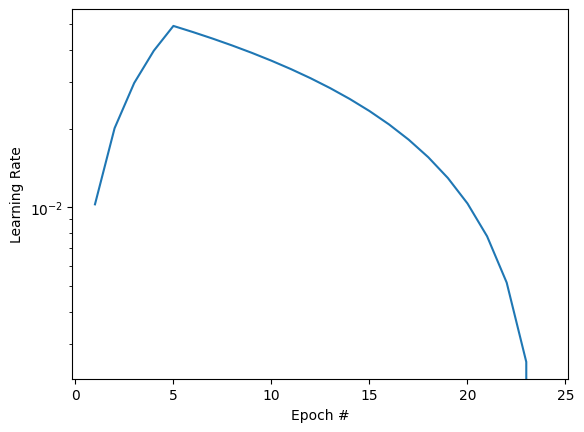

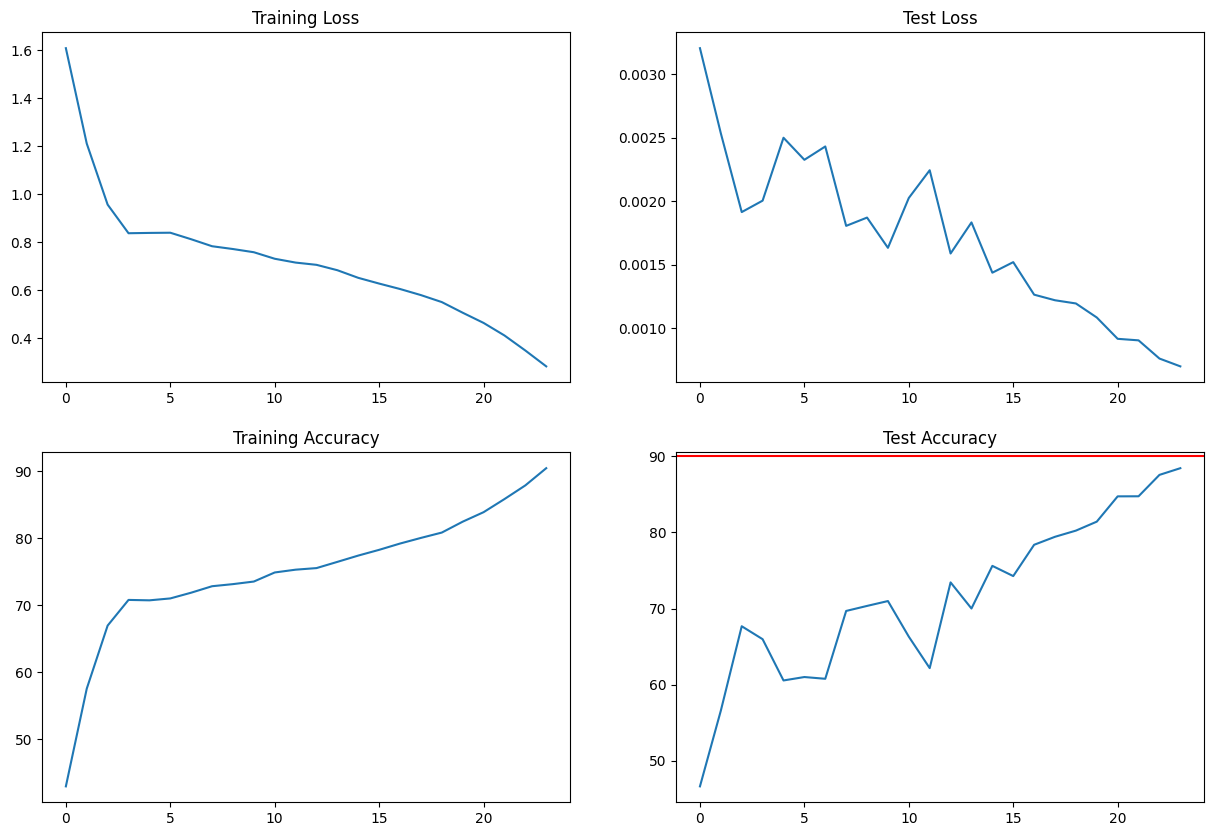

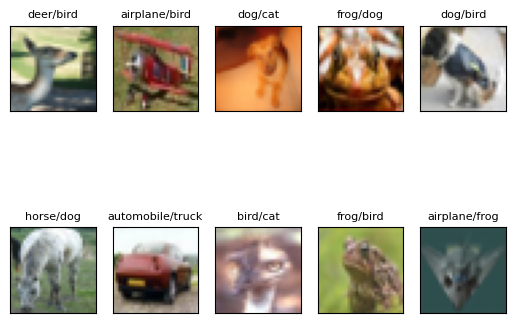

[0.010274361963190183, 0.020055723926380366, 0.02983708588957055, 0.03961844785276073, 0.04927352574113856, 0.0466790483727175, 0.044084571004296455, 0.0414900936358754, 0.038895616267454344, 0.036301138899033296, 0.03370666153061224, 0.03111218416219119, 0.028517706793770137, 0.025923229425349085, 0.023328752056928033, 0.020734274688506985, 0.01813979732008593, 0.015545319951664874, 0.012950842583243825, 0.01035636521482277, 0.007761887846401722, 0.005167410477980666, 0.002572933109559611, -2.154425886143757e-05]


In [12]:
plot_lr_values(lr_values)
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc=90.)
incorrect_predictions_bn = get_incorrect_predictions(resnet_model, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)
print(lr_values)

Print Training Log

In [13]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.6084984784223595 | 0.0032073246359825133 |     42.968     |    46.64     |
|   2   |  1.2108766491315803 |  0.002535485816001892 |     57.558     |    56.59     |
|   3   |  0.9564663962442048 | 0.0019144850075244904 |     66.978     |    67.67     |
|   4   |  0.8371939786842891 | 0.0020047372937202455 |     70.812     |    65.97     |
|   5   |  0.8385243841579982 | 0.0025008652687072753 |     70.75      |    60.55     |
|   6   |  0.8393253459005939 | 0.0023268484473228453 |     71.034     |     61.0     |
|   7   |  0.8121486592049502 | 0.0024320456743240357 |     71.892     |    60.77     |
|   8   |  0.7830252762959928 | 0.0018057711601257324 |     72.856     |    69.68     |
|   9   |  0.7713593201977866 | 